In [7]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.datasets import Planetoid
from torch_geometric.nn.models import InnerProductDecoder, VGAE
from torch_geometric.nn.conv import GCNConv
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
from typing import Optional
from torch_scatter import scatter_add
from torch_sparse import coalesce
from torch_geometric.utils import add_self_loops, remove_self_loops, to_scipy_sparse_matrix
from torch_geometric.utils.num_nodes import maybe_num_nodes
from scipy.sparse.linalg import eigsh
import math
import numpy as np
import scipy as sp
from numpy import linalg as LA
import seaborn as sns
from scipy.optimize import minimize
from scipy.sparse.linalg import eigs
np.random.seed(42)

In [8]:
## VAGE 源码里MAX_LOGSTD = 10
MAX_LOGSTD = 10
from Mgnetic_conv import *

In [57]:
class MagConvEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, k , q ,trainable_q):
        super(MagConvEncoder, self).__init__()
        self.magconv_first = MagNetConv(in_channels, hidden_channels,k,q,trainable_q)
        self.magconv_second = MagNetConv(hidden_channels, out_channels,k,q,trainable_q)
        self.magconv_second_c = MagNetConv(hidden_channels, out_channels,k,q,trainable_q)


    def forward(self, x, edge_index):
            ## x_real & x_img as input
        x_real = x.real.float()
        # x_imag = 1j * x.clone()
        x_imag = x.image.float()
        # x_imag = x_imag_1.float()
        # x_imag = x_imag_1
        x_r , x_i = self.magconv_first(x_real,x_imag,edge_index)
        combined_x = x_r + 1j * x_i
        combined_x_real = combined_x.real.float()
        combined_x_imag = combined_x.imag.float()
        c_r, c_i = self.magconv_second(combined_x_real,combined_x_imag,edge_index)
        z = c_r + 1j * c_i
        z2 = c_r + 1j * c_i

        return z,z2
    

class SyncRankDecoder(nn.Module):
    def __init__(self,C_matrix):
        super(SyncRankDecoder, self).__init__()
        self.C_matrix = C_matrix
    def forward(self,z,g = 0.5):
        psi = z
        n = psi.shape[0]
        psi = psi.view(1,n)
        print('latent representation')
        display(psi)
        angles_radians = torch.angle(psi)
        # display(angles_radians)
        pi = torch.tensor(math.pi)
        angles_modulo_2pi = torch.fmod(angles_radians, 2 * pi)
        angles_degrees = torch.rad2deg(angles_modulo_2pi)
        sorted_indices = torch.argsort(angles_degrees)
        return sorted_indices,self.C_matrix

In [58]:
class DeepVGAE(VGAE):
    def __init__(self,in_channels:int,hidden_channels:int, out_channels:int, K:int, q:float, trainable_q:bool, C_matrix):
        super(DeepVGAE, self).__init__(encoder= MagConvEncoder(in_channels,
                                                        hidden_channels,
                                                        out_channels,
                                                        K,
                                                        q,
                                                        trainable_q
                                                        ),
                                        decoder = SyncRankDecoder(C_matrix))
        self.out_channels = out_channels

    def encode(self,x,edge_index):
            # print(self.encoder)
        # self.__mu__, self.__logstd__ = self.encoder(x,edge_index)
        # gaussian_noise = torch.randn(x.size(0), self.out_channels)
        # print(self.training)
        # z = self.__mu__ + gaussian_noise * torch.exp(self.__logstd__ )
        # z = self.reparametrize(self.__mu__, self.__logstd__)
        # z = self.encoder(x,edge_index)
        z1,z2 = self.encoder(x,edge_index)
        z = self.reparametrize(z1,z2)
        return z
    
    def loss(self, x, pos_edge_index):
        z = self.encode(x, pos_edge_index)
        n = z.shape[0]
        s_projection = self.decoder(z)[0]
        c_matrix = self.decoder(z)[1]
        # obj = 9999999999999
        best_shift = 0
        # for shift in range(n):
        #     obj1 = self.upset(s_projection,c_matrix,shift)
        #     # print(obj1)
        #     if obj1 < obj:
        #         obj = obj1
        #         best_shift = shift
        #         # print(circular_shift(s,best_shift))
        obj1 = self.upset(s_projection,c_matrix,best_shift)
        repre = self.circular_shift(s_projection,best_shift)
        obj_loss = obj1
        obj_loss = obj_loss.to(torch.float32)
        obj_loss.requires_grad = True
        print(obj_loss)
        display(repre)
        return obj_loss
    def circular_shift(self,x, shift):
        if shift == 0:
            return x
        elif shift > 0:
            return torch.cat((x[-shift:], x[:-shift]))
        else:
            shift = -shift
            return torch.cat((x[shift:], x[:shift]))

    def outer_product(self, x, y):
        x_reshaped = x.unsqueeze(1)  # Add a new dimension to x
        x_reshaped = x_reshaped.to(torch.float32)  # Cast to float32
        y = y.to(torch.float32)
        outer_product = torch.matmul(x_reshaped, y.unsqueeze(0))
        return outer_product
    def hadamard_product(self, x, y):
        return x * y
    def upset(self, s, C, shift):
        sigma_s = self.circular_shift(s, shift)
        n = s.shape[1]
        # print("hhhhh",n)
        sigma_s = sigma_s.view(n, 1)
        zzz =  torch.ones(len(sigma_s))
        zzz = zzz.view(100,)
        # print(sigma_s.shape,zzz.shape)
        sigma_outer_ones_T = self.outer_product(sigma_s,zzz)
        ones_outer_sigma_T = self.outer_product(zzz, sigma_s.T)
        term1 = sigma_outer_ones_T - ones_outer_sigma_T
        result = self.hadamard_product(term1, (C != 0).float())
        return 0.5 * torch.sum(torch.abs(torch.sign(result) - torch.sign(C)))

In [59]:
def ERO(r, eta, p):
    n = r.shape[0]
    r = r.reshape(n, 1)
    M = np.max(np.abs(r))
    e = np.ones((n, 1))
    H_star = eta * p * (r.dot(e.T) - e.dot(r.T))
    H = r.dot(e.T) - e.dot(r.T)
    # Generate all random indicators at once
    indicators = np.triu(np.random.choice(3, (n, n), p=[eta*p, p*(1-eta), 1-p]),1)
    # Generate random values for the second case
    Z = np.random.uniform(-M, M, (n, n))
    H[indicators == 2] = 0
    H[indicators == 1] = Z[indicators == 1]
    H = np.triu(H, 1) - np.triu(H, 1).T
    delta = H - H_star
    return H, delta

In [60]:
n = np.arange(100)+1
eta, p = 0.8,0.5
H,delta = ERO(n,eta, p)
H_tensor = torch.tensor(H)
H_tensor

tensor([[  0.,   0.,  -2.,  ...,   0., -98., -99.],
        [  0.,   0.,   0.,  ..., -96.,   0.,   0.],
        [  2.,   0.,   0.,  ..., -95.,   0.,   0.],
        ...,
        [  0.,  96.,  95.,  ...,   0.,   0.,   0.],
        [ 98.,   0.,   0.,  ...,   0.,   0.,   0.],
        [ 99.,   0.,   0.,  ...,   0.,   0.,   0.]], dtype=torch.float64)

In [61]:
edge_index = torch.LongTensor(np.array(H.nonzero()))
edge_index.size()

torch.Size([2, 4930])

In [62]:
HHH = np.array(H_tensor)
iH = torch.from_numpy(1j * HHH)
V,W = torch.linalg.eigh(iH)
X = W[:,:40]
## feature X
X.shape
X

tensor([[-0.1226+0.0000j,  0.1726+0.0000j, -0.2288+0.0000j,  ...,
          0.0544+0.0000j,  0.1112+0.0000j, -0.1017+0.0000j],
        [-0.1135-0.0095j,  0.1162+0.1201j, -0.1427+0.0892j,  ...,
          0.0640-0.0416j,  0.0373-0.0304j,  0.0121+0.0751j],
        [-0.1304-0.0081j, -0.0681+0.1363j,  0.0952+0.0974j,  ...,
          0.1232-0.0298j, -0.0500-0.0142j,  0.0338+0.0031j],
        ...,
        [ 0.0747+0.1184j,  0.1008-0.1053j, -0.0187-0.0074j,  ...,
         -0.0650-0.0026j, -0.0916-0.0354j, -0.0199+0.0132j],
        [ 0.0336+0.0764j, -0.2166-0.1356j, -0.0616+0.1463j,  ...,
         -0.0564-0.0314j,  0.1074-0.1319j, -0.1088-0.0537j],
        [ 0.0580+0.0951j, -0.0319+0.0163j, -0.0166+0.1084j,  ...,
         -0.0150+0.0172j,  0.0074+0.0092j,  0.0356-0.0299j]],
       dtype=torch.complex128)

In [63]:
from torch_geometric.data import Data
data = Data(x = X, edge_index = edge_index)
data = train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1)
data



/Users/leoenoch/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[100, 40], val_pos_edge_index=[2, 123], test_pos_edge_index=[2, 246], train_pos_edge_index=[2, 4192], train_neg_adj_mask=[100, 100], val_neg_edge_index=[2, 123], test_neg_edge_index=[2, 246])

In [64]:
model = DeepVGAE(40,1,1,2,0.5,True,H_tensor)
optimizer = Adam(model.parameters(), lr= 0.05)

In [65]:
repre_index = []
for epoch in range(100):
    print('epoch',epoch)
    model.train()
    optimizer.zero_grad()
    loss = model.loss(data.x, edge_index) ##self.train = True
    loss.backward()
    optimizer.step()

epoch 0
latent representation


tensor([[ 0.0951-1.5256j,  0.5706-0.6302j,  1.0394+0.4895j, -0.4991-0.5017j,
         -0.6474-0.2345j, -0.8978-0.9218j, -0.6440-1.0887j,  0.3347+1.1095j,
         -0.1319+1.2213j, -0.2925-0.2216j, -0.1834+0.5422j, -0.3270-0.8794j,
         -1.0409+0.2828j, -0.5494+0.4772j, -1.8133-0.0532j, -0.3931-0.9319j,
         -0.4163-0.9808j, -0.2942-0.0251j, -0.6319-1.0425j, -0.1473-0.8830j,
          0.4536+0.9319j, -1.5566-1.0082j, -0.6295-0.1081j,  0.1098+0.3364j,
         -1.6487-1.2190j,  0.9618-0.0770j, -0.8807-2.0084j,  0.0669-0.2069j,
         -0.8020+0.0094j,  0.2404-0.4245j, -0.1392-0.6681j, -1.6879-0.2470j,
          0.0858+0.2208j,  0.6765-0.4547j,  1.1863-0.6995j, -0.3469+0.2503j,
         -1.1306-1.8752j,  0.1573-0.1047j, -0.3627-0.9539j,  0.0849-1.0285j,
         -0.4436-0.0414j,  0.3049+0.6866j, -0.6854+0.3556j,  0.6081+1.4230j,
         -0.1996+0.0214j, -0.8769-0.6392j,  0.1945+0.8771j,  0.9919-0.3120j,
          0.3654-0.8546j, -0.0175+1.0717j, -1.0938-0.2917j,  0.4391-0.2169j,

latent representation


tensor([[ 0.0951-1.5256j,  0.5706-0.6302j,  1.0394+0.4895j, -0.4991-0.5017j,
         -0.6474-0.2345j, -0.8978-0.9218j, -0.6440-1.0887j,  0.3347+1.1095j,
         -0.1319+1.2213j, -0.2925-0.2216j, -0.1834+0.5422j, -0.3270-0.8794j,
         -1.0409+0.2828j, -0.5494+0.4772j, -1.8133-0.0532j, -0.3931-0.9319j,
         -0.4163-0.9808j, -0.2942-0.0251j, -0.6319-1.0425j, -0.1473-0.8830j,
          0.4536+0.9319j, -1.5566-1.0082j, -0.6295-0.1081j,  0.1098+0.3364j,
         -1.6487-1.2190j,  0.9618-0.0770j, -0.8807-2.0084j,  0.0669-0.2069j,
         -0.8020+0.0094j,  0.2404-0.4245j, -0.1392-0.6681j, -1.6879-0.2470j,
          0.0858+0.2208j,  0.6765-0.4547j,  1.1863-0.6995j, -0.3469+0.2503j,
         -1.1306-1.8752j,  0.1573-0.1047j, -0.3627-0.9539j,  0.0849-1.0285j,
         -0.4436-0.0414j,  0.3049+0.6866j, -0.6854+0.3556j,  0.6081+1.4230j,
         -0.1996+0.0214j, -0.8769-0.6392j,  0.1945+0.8771j,  0.9919-0.3120j,
          0.3654-0.8546j, -0.0175+1.0717j, -1.0938-0.2917j,  0.4391-0.2169j,

tensor(230073., requires_grad=True)


tensor([[14, 17, 40, 31, 22, 50,  4, 92, 55, 82, 21, 45, 24,  9,  3,  5, 59, 18,
         36,  6, 26, 16, 15, 38, 11, 30, 19, 85, 89,  0, 39, 68, 69, 27, 72, 48,
         29, 53, 95, 63,  1, 91, 90, 81, 33, 37, 34, 51, 74, 47, 64, 25, 71, 62,
         58, 98, 56, 76,  2, 78, 86, 52, 66, 84, 94, 70, 99, 73, 87, 80, 20, 41,
         43, 32, 65, 23,  7, 61, 60, 46, 97, 49, 79,  8, 75, 88, 10, 57, 54, 96,
         67, 13, 93, 35, 42, 77, 12, 83, 44, 28]])

epoch 1
latent representation


tensor([[ 0.0958+0.1139j, -0.1040-0.6484j,  1.3460-0.1168j, -0.0464-1.2097j,
         -0.7443-0.3750j, -0.3196-0.2142j, -0.1541-1.6002j,  0.3449+0.9463j,
          0.9515+0.0453j, -0.0547-1.0574j,  1.3503+0.3295j, -0.2655-0.0068j,
          0.4378+0.5129j, -0.1984-0.0065j, -0.7025+0.3361j,  0.1118-0.0971j,
         -0.0472+1.0601j, -0.5701+0.0469j,  1.0434+1.3716j,  0.8587+0.0617j,
          0.1051+0.4143j,  0.6317-0.2913j, -0.2259+0.2031j,  1.0152+0.5748j,
         -0.6019+0.8560j, -0.2695+0.6417j,  0.7794-0.1283j, -0.4065-0.3090j,
          0.4369+0.4145j,  0.4849+0.5282j, -0.0273-0.0210j,  0.0990+0.3372j,
         -0.2628-0.1271j,  0.9485+0.6275j, -0.2286+0.0157j,  0.4001+1.7235j,
          0.5381-1.5801j, -0.2397-0.8892j,  1.3211-0.9835j,  0.8684-0.7327j,
          0.3410+1.0213j, -0.6510+0.5320j, -0.1068-0.8790j, -1.0739+0.9772j,
          1.6884+0.0887j, -0.3940+0.4851j,  1.1367+0.5129j, -0.2125-0.0069j,
          0.8114-1.2160j,  0.3578-0.1079j, -0.6433-1.0004j,  0.9064-0.4267j,

latent representation


tensor([[ 0.0958+0.1139j, -0.1040-0.6484j,  1.3460-0.1168j, -0.0464-1.2097j,
         -0.7443-0.3750j, -0.3196-0.2142j, -0.1541-1.6002j,  0.3449+0.9463j,
          0.9515+0.0453j, -0.0547-1.0574j,  1.3503+0.3295j, -0.2655-0.0068j,
          0.4378+0.5129j, -0.1984-0.0065j, -0.7025+0.3361j,  0.1118-0.0971j,
         -0.0472+1.0601j, -0.5701+0.0469j,  1.0434+1.3716j,  0.8587+0.0617j,
          0.1051+0.4143j,  0.6317-0.2913j, -0.2259+0.2031j,  1.0152+0.5748j,
         -0.6019+0.8560j, -0.2695+0.6417j,  0.7794-0.1283j, -0.4065-0.3090j,
          0.4369+0.4145j,  0.4849+0.5282j, -0.0273-0.0210j,  0.0990+0.3372j,
         -0.2628-0.1271j,  0.9485+0.6275j, -0.2286+0.0157j,  0.4001+1.7235j,
          0.5381-1.5801j, -0.2397-0.8892j,  1.3211-0.9835j,  0.8684-0.7327j,
          0.3410+1.0213j, -0.6510+0.5320j, -0.1068-0.8790j, -1.0739+0.9772j,
          1.6884+0.0887j, -0.3940+0.4851j,  1.1367+0.5129j, -0.2125-0.0069j,
          0.8114-1.2160j,  0.3578-0.1079j, -0.6433-1.0004j,  0.9064-0.4267j,

tensor(241200., requires_grad=True)


tensor([[11, 47, 13, 81, 64, 54, 32, 75,  4,  5, 70, 27, 30, 58, 62, 53, 50, 74,
         65, 37, 55,  1, 42,  6,  9,  3, 92, 36, 72, 86, 76, 48, 96, 52, 69, 56,
         15, 39, 38, 89, 59, 51, 21, 49, 97, 26,  2, 95, 98,  8, 44, 19, 10, 84,
         46, 78, 23, 61, 33, 73, 63, 28, 29, 12,  0, 68, 18, 99, 90,  7, 40, 87,
         60, 31, 85, 20, 35, 88, 80, 16, 57, 25, 94, 79, 91, 24, 45, 82, 43, 22,
         41, 71, 67, 14, 77, 93, 83, 66, 17, 34]])

epoch 2
latent representation


tensor([[-0.0986+1.2437j,  0.9059+0.7704j, -0.9018-0.9097j,  0.5054+0.6281j,
         -0.4596+0.3222j, -1.6051-0.1243j, -0.9078-0.6146j, -0.6437-0.6146j,
          0.2288-1.1520j,  0.4881+0.5955j,  0.3697-0.2151j, -1.1084-0.3970j,
         -0.9076-0.2322j,  0.9753+0.5204j, -0.7444+0.4694j, -0.1239+0.4348j,
         -0.1069+0.6008j, -0.6633+0.1001j,  1.1464-1.4262j,  0.5532-0.1367j,
          1.8722+0.2991j, -0.9236+0.1033j,  0.6210-0.5148j,  1.1565+0.1600j,
          0.3537-0.4624j, -0.1846+0.7543j, -0.2129+0.7611j,  1.4802+0.1967j,
          0.5061-1.4471j,  0.5211+0.1673j, -0.1077-1.0080j, -0.0708+1.2399j,
         -1.0014-1.0878j, -1.0116+0.1718j, -0.3729-0.6550j, -0.5400-0.0040j,
         -0.0709+0.1947j, -2.1333+0.3805j, -0.3607-0.9675j,  0.5566-1.6708j,
         -0.3198+0.6222j, -0.8803+0.5579j, -1.3152+0.5403j,  0.4136-0.2314j,
         -1.9701-0.0673j, -0.2258-0.2988j,  0.3221+1.1703j,  0.3919+0.0929j,
          0.7506+0.8001j,  0.6953-0.1497j, -0.0253+0.8808j, -0.3072-0.6739j,

latent representation


tensor([[-0.0986+1.2437j,  0.9059+0.7704j, -0.9018-0.9097j,  0.5054+0.6281j,
         -0.4596+0.3222j, -1.6051-0.1243j, -0.9078-0.6146j, -0.6437-0.6146j,
          0.2288-1.1520j,  0.4881+0.5955j,  0.3697-0.2151j, -1.1084-0.3970j,
         -0.9076-0.2322j,  0.9753+0.5204j, -0.7444+0.4694j, -0.1239+0.4348j,
         -0.1069+0.6008j, -0.6633+0.1001j,  1.1464-1.4262j,  0.5532-0.1367j,
          1.8722+0.2991j, -0.9236+0.1033j,  0.6210-0.5148j,  1.1565+0.1600j,
          0.3537-0.4624j, -0.1846+0.7543j, -0.2129+0.7611j,  1.4802+0.1967j,
          0.5061-1.4471j,  0.5211+0.1673j, -0.1077-1.0080j, -0.0708+1.2399j,
         -1.0014-1.0878j, -1.0116+0.1718j, -0.3729-0.6550j, -0.5400-0.0040j,
         -0.0709+0.1947j, -2.1333+0.3805j, -0.3607-0.9675j,  0.5566-1.6708j,
         -0.3198+0.6222j, -0.8803+0.5579j, -1.3152+0.5403j,  0.4136-0.2314j,
         -1.9701-0.0673j, -0.2258-0.2988j,  0.3221+1.1703j,  0.3919+0.0929j,
          0.7506+0.8001j,  0.6953-0.1497j, -0.0253+0.8808j, -0.3072-0.6739j,

tensor(245514., requires_grad=True)


tensor([[35, 44,  5, 81, 12, 97, 11,  6,  7, 77, 84,  2, 32, 45, 53, 79, 34, 93,
         51, 72, 38, 59, 74, 30, 68, 98, 55, 56,  8, 82, 39, 28, 76, 96, 24, 18,
         88, 22, 61, 63, 10, 43, 57, 99, 66, 19, 49, 64, 67, 69, 27, 23, 20, 47,
         60, 92, 29, 62, 54, 13,  1, 48, 73,  9,  3, 58, 46, 89, 71, 78, 87, 91,
         50, 31,  0, 52, 16, 25, 26, 15, 36, 40, 70, 94, 95, 65,  4, 41, 14, 75,
         86, 42, 80, 83, 37, 33, 90, 17, 85, 21]])

epoch 3
latent representation


tensor([[-0.7295+0.1506j, -0.6305+0.1492j, -0.6938+0.0890j, -0.5929-0.0981j,
         -0.4214+0.5671j, -0.3683-0.7248j,  0.0091-1.6432j,  0.5528+0.3812j,
         -1.9178-0.6823j, -0.0530-0.1354j, -0.0200+0.3294j,  0.4035-0.4613j,
          0.2724+1.1425j,  0.6759-0.8793j,  0.3592-0.3625j,  0.1642-1.6869j,
          1.4586-1.6047j, -1.4670-0.1604j,  0.5202-0.0354j,  0.2013+0.4967j,
          0.1872+0.1999j,  1.0965+0.1928j, -0.1121+0.8183j, -0.0098+0.5809j,
         -0.3276-1.1864j, -0.4901-0.3937j,  0.8343+0.1630j, -0.8824-0.5269j,
          1.5070+0.3963j,  1.1564-0.8302j, -0.5036-1.2242j, -0.3697-0.2342j,
         -0.1920-0.2162j, -0.7145-0.8231j, -1.1965+0.7714j, -0.9072+0.8070j,
         -1.3016-0.3760j,  0.4273-0.5965j, -0.1525-1.3071j,  0.4707+1.2839j,
         -1.7441-0.0703j,  0.3674+0.6137j,  0.1073+0.5682j,  0.6706+0.4035j,
          0.5931-0.3277j, -1.0960-1.4739j, -0.7566+1.2280j,  0.1786+0.1762j,
          0.0220+1.3393j, -0.7097+0.1354j, -0.7022+1.1062j,  0.4325-0.0627j,

latent representation


tensor([[-0.7295+0.1506j, -0.6305+0.1492j, -0.6938+0.0890j, -0.5929-0.0981j,
         -0.4214+0.5671j, -0.3683-0.7248j,  0.0091-1.6432j,  0.5528+0.3812j,
         -1.9178-0.6823j, -0.0530-0.1354j, -0.0200+0.3294j,  0.4035-0.4613j,
          0.2724+1.1425j,  0.6759-0.8793j,  0.3592-0.3625j,  0.1642-1.6869j,
          1.4586-1.6047j, -1.4670-0.1604j,  0.5202-0.0354j,  0.2013+0.4967j,
          0.1872+0.1999j,  1.0965+0.1928j, -0.1121+0.8183j, -0.0098+0.5809j,
         -0.3276-1.1864j, -0.4901-0.3937j,  0.8343+0.1630j, -0.8824-0.5269j,
          1.5070+0.3963j,  1.1564-0.8302j, -0.5036-1.2242j, -0.3697-0.2342j,
         -0.1920-0.2162j, -0.7145-0.8231j, -1.1965+0.7714j, -0.9072+0.8070j,
         -1.3016-0.3760j,  0.4273-0.5965j, -0.1525-1.3071j,  0.4707+1.2839j,
         -1.7441-0.0703j,  0.3674+0.6137j,  0.1073+0.5682j,  0.6706+0.4035j,
          0.5931-0.3277j, -1.0960-1.4739j, -0.7566+1.2280j,  0.1786+0.1762j,
          0.0220+1.3393j, -0.7097+0.1354j, -0.7022+1.1062j,  0.4325-0.0627j,

tensor(242039., requires_grad=True)


tensor([[40, 99, 17,  3, 36,  8, 62, 94, 75, 27, 31, 25, 77, 32, 33, 54, 90, 45,
         98,  5, 30,  9, 24, 61, 81, 38, 71,  6, 65, 79, 15, 64, 67, 37, 13, 68,
         11, 16, 14, 29, 44, 83, 53, 84, 51, 55, 89, 18, 96, 21, 26, 76, 28, 60,
         43, 85,  7, 47, 20, 57, 63, 72, 78, 41, 95, 19, 66, 39, 86, 12, 52, 42,
         92, 48, 23, 10, 22, 70, 87, 88, 59, 97, 73, 46, 82, 50, 58,  4, 35, 91,
         80, 34, 69, 56, 74,  1, 93,  0, 49,  2]])

epoch 4
latent representation


tensor([[ 0.5022+0.1528j,  0.8374+1.3122j,  0.8946+0.2252j,  0.5037+0.1429j,
         -0.9986+0.0156j,  0.1128+0.6036j,  0.5473-0.0199j,  0.3737-0.1348j,
         -0.2634+0.7537j,  0.7491-0.5021j, -0.0606-1.2038j, -0.6007+0.2520j,
         -0.2281+0.2816j,  0.5684-0.4655j,  0.0581+0.8914j,  0.4881-1.1297j,
         -0.7931-0.2553j, -0.2445+0.6027j,  2.3143+0.3629j, -1.1626-0.1940j,
          0.5456+0.8100j, -2.1842-1.2782j, -0.3299-0.5215j,  0.3743-0.3244j,
          0.7720-1.1240j,  0.0834-0.2840j,  0.2199-0.0188j,  0.8990-2.4540j,
          0.5486-0.7221j,  0.1458-0.0268j,  0.2739-0.6842j, -0.0562+0.1443j,
         -0.5377-0.1104j,  0.3764+0.1131j,  0.7170+0.6836j,  0.0331+0.1843j,
          1.3699-0.6514j,  0.1425-0.0380j, -0.5108-0.0614j, -0.4207-0.0216j,
         -0.5680+0.6758j, -0.0412-0.1244j,  0.4516-0.3147j, -0.5768+0.4847j,
          0.9780-0.7643j, -0.1555-0.6308j,  0.9003+1.3192j,  0.2034-0.8133j,
          0.6138+0.1510j, -0.1369+0.3356j,  0.5238+1.6404j, -1.8249+1.1556j,

latent representation


tensor([[ 0.5022+0.1528j,  0.8374+1.3122j,  0.8946+0.2252j,  0.5037+0.1429j,
         -0.9986+0.0156j,  0.1128+0.6036j,  0.5473-0.0199j,  0.3737-0.1348j,
         -0.2634+0.7537j,  0.7491-0.5021j, -0.0606-1.2038j, -0.6007+0.2520j,
         -0.2281+0.2816j,  0.5684-0.4655j,  0.0581+0.8914j,  0.4881-1.1297j,
         -0.7931-0.2553j, -0.2445+0.6027j,  2.3143+0.3629j, -1.1626-0.1940j,
          0.5456+0.8100j, -2.1842-1.2782j, -0.3299-0.5215j,  0.3743-0.3244j,
          0.7720-1.1240j,  0.0834-0.2840j,  0.2199-0.0188j,  0.8990-2.4540j,
          0.5486-0.7221j,  0.1458-0.0268j,  0.2739-0.6842j, -0.0562+0.1443j,
         -0.5377-0.1104j,  0.3764+0.1131j,  0.7170+0.6836j,  0.0331+0.1843j,
          1.3699-0.6514j,  0.1425-0.0380j, -0.5108-0.0614j, -0.4207-0.0216j,
         -0.5680+0.6758j, -0.0412-0.1244j,  0.4516-0.3147j, -0.5768+0.4847j,
          0.9780-0.7643j, -0.1555-0.6308j,  0.9003+1.3192j,  0.2034-0.8133j,
          0.6138+0.1510j, -0.1369+0.3356j,  0.5238+1.6404j, -1.8249+1.1556j,

tensor(236186., requires_grad=True)


tensor([[39, 92, 38, 62, 19, 32, 16, 21, 80, 56, 69, 73, 22, 57, 41, 75, 45, 97,
         10, 47, 25, 27, 30, 15, 89, 74, 24, 28, 93, 96, 23, 13, 71, 44, 42,  9,
         88, 36, 83, 82, 76,  7, 78, 37, 29, 26,  6, 55, 18, 48,  2,  3, 60, 33,
          0, 53, 34, 58, 54, 46, 20, 84,  1, 72, 50, 65,  5, 35, 68, 70, 63, 14,
         52, 99, 59, 64, 77,  8, 31, 17, 49, 61, 85, 79, 81, 12, 40, 87, 43, 91,
         51, 86, 11, 66, 95, 67, 90, 98, 94,  4]])

epoch 5
latent representation


tensor([[-0.4306-0.4602j,  0.8335+2.0006j,  0.6699-0.7255j, -0.5339-1.6832j,
          0.3257-0.1348j, -0.5411-0.8729j,  0.3946+0.2571j, -0.4710-1.0238j,
         -0.0169-0.3029j, -0.7866+0.4076j,  1.0506+0.1319j, -0.2380-0.0363j,
         -1.0467+0.8676j,  0.0801-0.4054j,  0.5354-0.2864j,  0.4816-1.1860j,
         -0.3410-0.0495j, -0.1075-0.3173j,  1.4604+0.6242j,  0.1310-0.9662j,
          0.9816+0.8985j, -0.4534+0.9857j,  0.4424+0.3598j,  0.5433+1.9637j,
          0.8428+1.0123j, -1.0703+0.8074j, -0.5235+1.2319j,  0.2240-0.1418j,
         -1.2183-1.5620j, -1.1865+0.8907j, -0.7081-0.7920j,  0.0256+0.0653j,
          0.0736-1.1459j,  0.4512-0.1451j,  0.4273+0.1273j, -0.1733-0.1751j,
          1.3213+0.2070j,  1.0792-1.2320j, -0.8116-1.0958j,  0.3624-0.8703j,
          1.2484+0.9806j,  0.5823-0.7588j, -1.1698-0.8860j,  2.0143+0.3235j,
          1.8548+1.7287j, -0.4098+0.1927j, -0.2829-0.4101j, -0.2629+0.0338j,
          0.7467+1.4959j,  0.2078+0.9792j,  1.9955-0.4763j,  0.2512-0.0220j,

latent representation


tensor([[-0.4306-0.4602j,  0.8335+2.0006j,  0.6699-0.7255j, -0.5339-1.6832j,
          0.3257-0.1348j, -0.5411-0.8729j,  0.3946+0.2571j, -0.4710-1.0238j,
         -0.0169-0.3029j, -0.7866+0.4076j,  1.0506+0.1319j, -0.2380-0.0363j,
         -1.0467+0.8676j,  0.0801-0.4054j,  0.5354-0.2864j,  0.4816-1.1860j,
         -0.3410-0.0495j, -0.1075-0.3173j,  1.4604+0.6242j,  0.1310-0.9662j,
          0.9816+0.8985j, -0.4534+0.9857j,  0.4424+0.3598j,  0.5433+1.9637j,
          0.8428+1.0123j, -1.0703+0.8074j, -0.5235+1.2319j,  0.2240-0.1418j,
         -1.2183-1.5620j, -1.1865+0.8907j, -0.7081-0.7920j,  0.0256+0.0653j,
          0.0736-1.1459j,  0.4512-0.1451j,  0.4273+0.1273j, -0.1733-0.1751j,
          1.3213+0.2070j,  1.0792-1.2320j, -0.8116-1.0958j,  0.3624-0.8703j,
          1.2484+0.9806j,  0.5823-0.7588j, -1.1698-0.8860j,  2.0143+0.3235j,
          1.8548+1.7287j, -0.4098+0.1927j, -0.2829-0.4101j, -0.2629+0.0338j,
          0.7467+1.4959j,  0.2078+0.9792j,  1.9955-0.4763j,  0.2512-0.0220j,

tensor(246907., requires_grad=True)


tensor([[96, 82, 16, 11, 83, 86, 54, 42, 77, 76, 35, 92,  0, 30, 28, 78, 38, 60,
         46,  5, 56, 75, 59,  7, 89, 17, 81,  3, 69, 88,  8, 32, 53, 19, 13, 93,
         15, 39, 79, 94, 41, 87, 37,  2, 27, 70, 14,  4, 66, 57, 33, 50, 90, 51,
         68, 10, 74, 36, 43, 34, 55, 72, 73, 64, 18,  6, 40, 22, 20, 44, 58, 65,
         84, 24, 80, 52, 97, 48,  1, 71, 31, 67, 23, 49, 91, 63, 85, 99, 26, 21,
         98, 12, 25, 29, 61,  9, 45, 62, 95, 47]])

epoch 6
latent representation


tensor([[-0.3942+0.0354j,  2.4172+1.1785j,  0.9642-0.7070j,  0.7533-0.8787j,
         -0.1633-0.2583j,  0.6367+0.2950j,  0.5596-0.3233j,  1.3114-0.0874j,
          0.6644-0.4699j, -1.4489+0.1845j,  0.1571+1.9444j, -1.5676-1.2104j,
         -0.1648+0.4179j,  0.9334-0.1833j, -0.5899+0.2647j, -0.0750+1.3299j,
          0.1542-0.7424j,  0.1273+0.1624j,  0.5895-1.6568j, -0.0351-1.5386j,
         -0.3214+1.5821j, -0.3016-1.3419j, -0.7507+0.6284j, -0.9711+0.0702j,
          1.9513+0.4799j, -0.4916-0.0381j,  1.1831+0.9208j,  0.1307-1.0708j,
          0.5187-1.0964j, -0.0670-1.4698j, -0.4349-0.9763j, -0.4658-0.3417j,
          0.1821-0.4452j,  0.9525-0.8767j, -0.7238+1.1572j, -0.5786+0.7221j,
         -0.6849-0.3947j, -0.7857+0.0046j,  0.3019-1.5987j,  0.8379-0.6399j,
          0.3705+0.8282j, -0.6316-1.1665j,  1.4101+0.0462j,  1.7023+0.0535j,
          0.6750-1.0717j, -0.6052-0.8965j, -1.2085+0.2603j, -1.3337-0.6100j,
          0.1277+1.1761j,  0.6217+0.2447j,  0.0294-0.0929j, -0.0301-2.0362j,

latent representation


tensor([[-0.3942+0.0354j,  2.4172+1.1785j,  0.9642-0.7070j,  0.7533-0.8787j,
         -0.1633-0.2583j,  0.6367+0.2950j,  0.5596-0.3233j,  1.3114-0.0874j,
          0.6644-0.4699j, -1.4489+0.1845j,  0.1571+1.9444j, -1.5676-1.2104j,
         -0.1648+0.4179j,  0.9334-0.1833j, -0.5899+0.2647j, -0.0750+1.3299j,
          0.1542-0.7424j,  0.1273+0.1624j,  0.5895-1.6568j, -0.0351-1.5386j,
         -0.3214+1.5821j, -0.3016-1.3419j, -0.7507+0.6284j, -0.9711+0.0702j,
          1.9513+0.4799j, -0.4916-0.0381j,  1.1831+0.9208j,  0.1307-1.0708j,
          0.5187-1.0964j, -0.0670-1.4698j, -0.4349-0.9763j, -0.4658-0.3417j,
          0.1821-0.4452j,  0.9525-0.8767j, -0.7238+1.1572j, -0.5786+0.7221j,
         -0.6849-0.3947j, -0.7857+0.0046j,  0.3019-1.5987j,  0.8379-0.6399j,
          0.3705+0.8282j, -0.6316-1.1665j,  1.4101+0.0462j,  1.7023+0.0535j,
          0.6750-1.0717j, -0.6052-0.8965j, -1.2085+0.2603j, -1.3337-0.6100j,
          0.1277+1.1761j,  0.6217+0.2447j,  0.0294-0.0929j, -0.0301-2.0362j,

tensor(239566., requires_grad=True)


tensor([[25, 47, 54, 36, 69, 31, 11, 68, 77, 74, 97, 45,  4, 41, 30, 63, 21, 99,
         88, 29, 19, 64, 51, 93, 27, 53, 38, 16, 50, 18, 32, 28, 44, 67,  3, 71,
         33, 58, 39,  2,  8, 66,  6, 62, 73, 13, 96,  7, 61, 43, 42, 59, 24, 80,
         49, 70,  5,  1, 76, 95, 52, 26, 60, 91, 17, 87, 40, 86, 83, 85, 82, 84,
         48, 10, 56, 72, 89, 15, 81, 20, 12, 34, 35, 75, 78, 92, 22, 65, 90, 14,
         79, 94, 46, 57, 98,  9, 55,  0, 23, 37]])

epoch 7
latent representation


tensor([[-0.0512-0.4431j, -0.0069+1.0138j,  0.4209-1.5927j, -0.3598+0.3716j,
          0.5951-0.5689j, -0.5955+0.1806j, -0.2533+0.1269j,  0.2929+0.2516j,
          0.5689-0.0225j, -0.3740+1.4057j,  0.2461+0.2273j, -0.5239-0.3768j,
         -0.4653+1.5440j,  0.2657-0.2751j, -0.4184-0.8590j,  1.3644+0.2863j,
         -0.1902-1.3772j, -0.2727-0.5555j,  0.5570-1.2104j,  1.1466-0.8986j,
         -0.3394+1.1058j,  0.4579-0.3947j, -0.5499-0.3342j,  1.4283+0.2855j,
         -0.2316-0.9290j,  0.0315+0.3985j,  0.6247-0.3861j,  0.9521-1.1036j,
         -0.5553-0.9582j, -0.1886+0.0180j, -0.2048-0.5003j, -0.3499-0.7713j,
          0.7488+0.9646j,  0.8043-1.5952j,  0.1661+0.1359j,  0.5432+0.8024j,
          0.0541-1.3745j,  0.3831+0.1512j, -0.6249+0.0728j, -0.3723+0.3272j,
         -0.5256+0.0878j, -0.9792-0.2635j,  0.4434-0.3157j,  0.1396+0.8042j,
          0.9826-0.8872j, -0.4131-0.6681j, -0.3991-0.3091j, -0.3840-0.8365j,
          1.9583-1.6263j, -0.3895-0.8589j, -0.5043+0.5350j, -0.6444-0.1436j,

latent representation


tensor([[-0.0512-0.4431j, -0.0069+1.0138j,  0.4209-1.5927j, -0.3598+0.3716j,
          0.5951-0.5689j, -0.5955+0.1806j, -0.2533+0.1269j,  0.2929+0.2516j,
          0.5689-0.0225j, -0.3740+1.4057j,  0.2461+0.2273j, -0.5239-0.3768j,
         -0.4653+1.5440j,  0.2657-0.2751j, -0.4184-0.8590j,  1.3644+0.2863j,
         -0.1902-1.3772j, -0.2727-0.5555j,  0.5570-1.2104j,  1.1466-0.8986j,
         -0.3394+1.1058j,  0.4579-0.3947j, -0.5499-0.3342j,  1.4283+0.2855j,
         -0.2316-0.9290j,  0.0315+0.3985j,  0.6247-0.3861j,  0.9521-1.1036j,
         -0.5553-0.9582j, -0.1886+0.0180j, -0.2048-0.5003j, -0.3499-0.7713j,
          0.7488+0.9646j,  0.8043-1.5952j,  0.1661+0.1359j,  0.5432+0.8024j,
          0.0541-1.3745j,  0.3831+0.1512j, -0.6249+0.0728j, -0.3723+0.3272j,
         -0.5256+0.0878j, -0.9792-0.2635j,  0.4434-0.3157j,  0.1396+0.8042j,
          0.9826-0.8872j, -0.4131-0.6681j, -0.3991-0.3091j, -0.3840-0.8365j,
          1.9583-1.6263j, -0.3895-0.8589j, -0.5043+0.5350j, -0.6444-0.1436j,

tensor(242808., requires_grad=True)


tensor([[51, 41, 68, 22, 64, 89, 11, 46, 92, 83, 45, 28, 17, 14, 47, 31, 49, 55,
         30, 24, 67, 98, 16,  0, 36, 52,  2, 82, 76, 18, 33, 70, 27, 13, 79, 66,
          4, 44, 62, 21, 48, 19, 42, 26, 85,  8, 59, 74, 23, 15, 56, 73, 37, 57,
         81, 95, 91, 34,  7, 96, 10, 99, 53, 63, 90, 32, 35, 86, 87, 97, 84, 43,
         69, 25, 88, 58,  1, 72,  9, 12, 20, 71, 65, 75, 50,  3, 77, 61, 94, 39,
         80, 78,  6,  5, 54, 40, 38, 29, 93, 60]])

epoch 8
latent representation


tensor([[ 3.1496e-01-0.0968j, -9.4353e-01-2.1104j, -5.3793e-01+0.3619j,
          7.9333e-01+0.2282j, -1.0205e+00+0.3307j, -4.4271e-01-0.7517j,
         -3.0873e-01+0.4274j,  1.6184e-01+0.0778j,  4.3572e-01-1.4580j,
         -1.1188e+00+0.3876j, -9.5755e-01-0.4120j, -2.5503e-01-0.1822j,
         -9.8532e-01-0.5381j, -4.6479e-01-0.8240j, -1.3163e+00-0.3628j,
         -9.8611e-02+0.9713j,  2.1626e-01+0.1366j,  3.0544e-01+0.3632j,
          6.3693e-02-0.1812j,  4.2789e-01+0.6826j, -1.1201e-01-1.1321j,
         -6.7210e-01+0.2890j, -2.0633e-01-0.0062j, -8.9406e-01+0.2736j,
          1.5637e-01+0.1314j, -5.2877e-01+0.8176j, -4.8936e-01-0.1430j,
          8.0352e-01-0.6396j, -5.7005e-01-0.5306j,  1.2165e+00-0.0913j,
         -1.0371e+00+0.1307j, -3.2249e-01-0.2268j,  1.1616e-01+0.4191j,
         -1.2135e-01+0.0770j, -1.1850e+00-0.3553j, -7.8717e-01-0.5354j,
          7.2209e-01-1.3544j,  3.7995e-01+0.6664j, -7.9816e-01-0.7834j,
         -1.4812e+00-1.0956j,  6.4352e-02+0.3467j, -1.5509e-01+0

latent representation


tensor([[ 3.1496e-01-0.0968j, -9.4353e-01-2.1104j, -5.3793e-01+0.3619j,
          7.9333e-01+0.2282j, -1.0205e+00+0.3307j, -4.4271e-01-0.7517j,
         -3.0873e-01+0.4274j,  1.6184e-01+0.0778j,  4.3572e-01-1.4580j,
         -1.1188e+00+0.3876j, -9.5755e-01-0.4120j, -2.5503e-01-0.1822j,
         -9.8532e-01-0.5381j, -4.6479e-01-0.8240j, -1.3163e+00-0.3628j,
         -9.8611e-02+0.9713j,  2.1626e-01+0.1366j,  3.0544e-01+0.3632j,
          6.3693e-02-0.1812j,  4.2789e-01+0.6826j, -1.1201e-01-1.1321j,
         -6.7210e-01+0.2890j, -2.0633e-01-0.0062j, -8.9406e-01+0.2736j,
          1.5637e-01+0.1314j, -5.2877e-01+0.8176j, -4.8936e-01-0.1430j,
          8.0352e-01-0.6396j, -5.7005e-01-0.5306j,  1.2165e+00-0.0913j,
         -1.0371e+00+0.1307j, -3.2249e-01-0.2268j,  1.1616e-01+0.4191j,
         -1.2135e-01+0.0770j, -1.1850e+00-0.3553j, -7.8717e-01-0.5354j,
          7.2209e-01-1.3544j,  3.7995e-01+0.6664j, -7.9816e-01-0.7834j,
         -1.4812e+00-1.0956j,  6.4352e-02+0.3467j, -1.5509e-01+0

tensor(239795., requires_grad=True)


tensor([[22, 54, 69, 47, 14, 26, 34, 10, 12, 67, 35, 31, 11, 39, 28, 38, 43, 83,
         95,  5, 45, 13,  1, 50, 20, 66, 92, 85, 59, 55, 78, 74,  8, 97, 18, 72,
         96, 36, 77, 52, 44, 27, 56, 73,  0, 62, 51, 86, 49, 29, 48, 42, 80, 81,
         94, 46,  3, 53,  7, 16, 89, 24, 71, 17, 68, 19, 37, 79, 65, 64, 32, 82,
         70, 40, 93, 84, 15, 99, 87, 41, 58, 57, 98, 88, 25,  6, 90, 76, 91, 75,
          2, 33, 21,  9, 60,  4, 23, 61, 30, 63]])

epoch 9
latent representation


tensor([[-1.0282+1.1528j, -0.1108+0.9042j, -0.7545+1.0531j,  0.3648+0.1337j,
         -1.0116+0.5316j,  0.6327-0.2650j,  0.2623-0.7919j,  1.0202-0.8318j,
          0.0453-0.9705j, -1.0423+0.4681j, -0.6641+0.5992j,  0.0154-0.1503j,
         -0.7855-0.0342j,  0.0607-0.8917j,  0.3119+1.4483j,  0.2237+0.8627j,
          1.2444-0.3280j, -0.9683+0.1808j,  1.7420+0.9948j,  0.1489-1.4534j,
          0.1734-0.2726j,  1.5807+0.3997j, -1.4757+1.0460j, -1.7573-0.0328j,
         -0.3220+0.9518j, -0.7201+0.0022j,  0.7032-0.0877j,  1.2166-0.7569j,
         -0.0480-0.1621j, -0.2244+0.6167j,  0.1377-0.6671j, -0.6250+0.0094j,
         -1.0139+0.4784j,  1.1011+0.3417j, -0.4686-0.2811j, -0.8565+0.4903j,
          0.1998-0.7362j,  1.1602+0.2392j, -0.3969-1.1409j,  0.4160-1.2282j,
          0.1405-0.3711j,  1.3637-0.2108j,  0.1620+0.3158j,  0.7650-0.6998j,
         -0.3600-1.0210j,  0.7925-0.6958j, -0.6711+1.0396j, -0.6594-0.2335j,
         -0.2528+0.0329j, -1.1564+1.6147j,  3.4953+0.1530j, -0.2391-0.8156j,

latent representation


tensor([[-1.0282+1.1528j, -0.1108+0.9042j, -0.7545+1.0531j,  0.3648+0.1337j,
         -1.0116+0.5316j,  0.6327-0.2650j,  0.2623-0.7919j,  1.0202-0.8318j,
          0.0453-0.9705j, -1.0423+0.4681j, -0.6641+0.5992j,  0.0154-0.1503j,
         -0.7855-0.0342j,  0.0607-0.8917j,  0.3119+1.4483j,  0.2237+0.8627j,
          1.2444-0.3280j, -0.9683+0.1808j,  1.7420+0.9948j,  0.1489-1.4534j,
          0.1734-0.2726j,  1.5807+0.3997j, -1.4757+1.0460j, -1.7573-0.0328j,
         -0.3220+0.9518j, -0.7201+0.0022j,  0.7032-0.0877j,  1.2166-0.7569j,
         -0.0480-0.1621j, -0.2244+0.6167j,  0.1377-0.6671j, -0.6250+0.0094j,
         -1.0139+0.4784j,  1.1011+0.3417j, -0.4686-0.2811j, -0.8565+0.4903j,
          0.1998-0.7362j,  1.1602+0.2392j, -0.3969-1.1409j,  0.4160-1.2282j,
          0.1405-0.3711j,  1.3637-0.2108j,  0.1620+0.3158j,  0.7650-0.6998j,
         -0.3600-1.0210j,  0.7925-0.6958j, -0.6711+1.0396j, -0.6594-0.2335j,
         -0.2528+0.0329j, -1.1564+1.6147j,  3.4953+0.1530j, -0.2391-0.8156j,

tensor(248683., requires_grad=True)


tensor([[23, 12, 93, 47, 77, 68, 78, 55, 34, 80, 95, 56, 53, 81, 44, 38, 28, 51,
         65, 99,  8, 13, 19, 11, 70, 30, 36, 75,  6, 39, 40, 69, 72, 20, 89, 43,
         45, 91,  7, 62, 27,  5, 85, 86, 16, 41, 26, 50, 37, 61, 21, 33,  3, 71,
         73, 76, 57, 18, 96, 54, 82, 42, 58, 52, 15, 14, 60, 92, 64, 63,  1, 87,
         24, 29, 94, 90, 67, 66, 46, 49,  2, 79,  0, 84, 10, 22, 35, 59,  4, 32,
          9, 98, 97, 83, 74, 17, 88, 48, 31, 25]])

epoch 10
latent representation


tensor([[-0.6777-1.2250j,  1.2568+0.1641j,  0.4609+0.4500j,  0.1622-1.2703j,
         -1.1267+0.2233j,  0.4073-0.3649j, -0.4212-1.1558j,  1.6484+0.4712j,
          0.7028+0.0261j,  0.9659-0.7096j, -1.2220+0.2168j, -0.2501-0.1770j,
         -0.7756+0.2973j,  0.8359+0.2162j,  0.7491-0.0401j,  0.4607-0.2444j,
         -0.0228+0.4676j, -0.2758+0.2923j,  0.3849-1.5158j, -1.0395-1.0330j,
          0.3587-0.4442j,  0.3249-0.0992j, -0.1133-0.8227j,  0.0625+0.1227j,
          0.5207-1.0196j,  0.3923+0.0614j,  1.2523+1.4234j, -1.7277+1.6197j,
         -0.2426+0.1185j,  0.3164+0.6371j, -0.4268-0.4334j, -0.2274+0.7311j,
          0.7068-0.0331j, -0.0892+0.2604j, -1.4754+0.3623j, -0.4117+0.3644j,
          1.6978+0.6731j, -1.4694-1.7009j,  1.2868-0.3855j,  0.1732+0.8477j,
         -0.0480-0.1365j, -0.1277-0.7942j,  0.5286+0.0327j,  0.3565-1.1085j,
          0.9192+0.1147j, -0.0377-0.3565j,  1.0984+0.3187j, -0.9536-2.3340j,
          0.6292-1.0794j,  0.5301+1.6007j, -1.5338+0.5489j, -0.1683-0.2780j,

latent representation


tensor([[-0.6777-1.2250j,  1.2568+0.1641j,  0.4609+0.4500j,  0.1622-1.2703j,
         -1.1267+0.2233j,  0.4073-0.3649j, -0.4212-1.1558j,  1.6484+0.4712j,
          0.7028+0.0261j,  0.9659-0.7096j, -1.2220+0.2168j, -0.2501-0.1770j,
         -0.7756+0.2973j,  0.8359+0.2162j,  0.7491-0.0401j,  0.4607-0.2444j,
         -0.0228+0.4676j, -0.2758+0.2923j,  0.3849-1.5158j, -1.0395-1.0330j,
          0.3587-0.4442j,  0.3249-0.0992j, -0.1133-0.8227j,  0.0625+0.1227j,
          0.5207-1.0196j,  0.3923+0.0614j,  1.2523+1.4234j, -1.7277+1.6197j,
         -0.2426+0.1185j,  0.3164+0.6371j, -0.4268-0.4334j, -0.2274+0.7311j,
          0.7068-0.0331j, -0.0892+0.2604j, -1.4754+0.3623j, -0.4117+0.3644j,
          1.6978+0.6731j, -1.4694-1.7009j,  1.2868-0.3855j,  0.1732+0.8477j,
         -0.0480-0.1365j, -0.1277-0.7942j,  0.5286+0.0327j,  0.3565-1.1085j,
          0.9192+0.1147j, -0.0377-0.3565j,  1.0984+0.3187j, -0.9536-2.3340j,
          0.6292-1.0794j,  0.5301+1.6007j, -1.5338+0.5489j, -0.1683-0.2780j,

tensor(249720., requires_grad=True)


tensor([[69, 67, 56, 59, 11, 88, 97, 19, 30, 90, 37, 83, 51,  0, 93, 62, 47,  6,
         40, 74, 60, 41, 22, 45, 76, 53, 96,  3, 18, 43, 70, 24, 48, 92, 68, 20,
         86, 81, 78,  5,  9, 72, 89, 15, 21, 38, 99, 61, 14, 32, 79,  8, 42, 55,
         84, 44,  1, 25, 13,  7, 46, 66, 36, 65,  2, 26, 82, 63, 57, 95, 58, 23,
         29, 49, 73, 39, 16, 87, 31, 33, 64, 54, 52, 17, 91, 27, 75, 35, 80, 71,
         28, 77, 98, 12, 50, 34, 85,  4, 10, 94]])

epoch 11
latent representation


tensor([[-1.1703e-01-0.3326j, -8.7084e-01-0.8584j, -1.2563e-01+0.8624j,
          3.7036e-01+0.4333j, -8.6873e-01-0.2421j, -1.0079e-01-1.2752j,
         -1.0575e+00-0.3916j, -4.9082e-01-0.8751j, -1.4265e-01-0.2240j,
         -6.6853e-01+0.6861j,  1.0113e+00+1.1326j,  2.9984e-01-0.5095j,
         -1.9391e-01+0.2763j,  5.1172e-01-1.0245j,  4.7329e-01-0.1520j,
         -1.2550e+00+0.3429j,  1.1148e+00+0.1491j, -5.0987e-01+1.2308j,
          1.2486e-01-0.8269j, -7.7276e-02-0.2258j, -8.4733e-01+0.8843j,
         -1.0089e-01+0.5315j, -2.2103e-03-0.1276j,  6.9235e-01+0.2954j,
         -1.0458e+00-0.8521j,  3.3029e-01+0.9646j, -3.6416e-01-0.1305j,
         -1.1014e+00+0.3494j,  1.1244e+00+0.3491j, -1.0256e+00+0.4478j,
          1.7931e-02-0.5524j, -8.0515e-03-0.0253j, -6.1001e-01+0.8060j,
         -4.0572e-01-0.1121j,  1.2870e+00-0.9435j, -3.1087e-01-0.3309j,
          2.3418e+00-0.8821j,  7.7363e-01+0.0683j,  4.7478e-02+0.3853j,
         -1.3769e+00-1.2370j, -1.0470e-01+0.0533j,  8.2174e-01+0

latent representation


tensor([[-1.1703e-01-0.3326j, -8.7084e-01-0.8584j, -1.2563e-01+0.8624j,
          3.7036e-01+0.4333j, -8.6873e-01-0.2421j, -1.0079e-01-1.2752j,
         -1.0575e+00-0.3916j, -4.9082e-01-0.8751j, -1.4265e-01-0.2240j,
         -6.6853e-01+0.6861j,  1.0113e+00+1.1326j,  2.9984e-01-0.5095j,
         -1.9391e-01+0.2763j,  5.1172e-01-1.0245j,  4.7329e-01-0.1520j,
         -1.2550e+00+0.3429j,  1.1148e+00+0.1491j, -5.0987e-01+1.2308j,
          1.2486e-01-0.8269j, -7.7276e-02-0.2258j, -8.4733e-01+0.8843j,
         -1.0089e-01+0.5315j, -2.2103e-03-0.1276j,  6.9235e-01+0.2954j,
         -1.0458e+00-0.8521j,  3.3029e-01+0.9646j, -3.6416e-01-0.1305j,
         -1.1014e+00+0.3494j,  1.1244e+00+0.3491j, -1.0256e+00+0.4478j,
          1.7931e-02-0.5524j, -8.0515e-03-0.0253j, -6.1001e-01+0.8060j,
         -4.0572e-01-0.1121j,  1.2870e+00-0.9435j, -3.1087e-01-0.3309j,
          2.3418e+00-0.8821j,  7.7363e-01+0.0683j,  4.7478e-02+0.3853j,
         -1.3769e+00-1.2370j, -1.0470e-01+0.0533j,  8.2174e-01+0

tensor(242314., requires_grad=True)


tensor([[77, 64, 46, 33,  4, 42, 26,  6, 83, 58, 24, 98, 66, 39, 92,  1, 35, 74,
          8,  7,  0, 19, 31, 61,  5, 56, 22, 55, 30, 62, 18, 88, 99, 13, 11, 43,
         50, 97, 34, 91, 79, 85, 93, 36, 48, 80, 14, 70, 51, 37, 16, 82, 28, 86,
         81, 75, 44, 23, 52, 68, 71, 41, 76, 10,  3, 67, 89, 72, 95, 90, 94, 78,
         25, 47, 87, 57, 38, 45,  2, 65, 21, 17, 53, 60, 63, 12, 32, 20,  9, 69,
         73, 59, 96, 49, 40, 29, 27, 15, 54, 84]])

epoch 12
latent representation


tensor([[ 0.2070+0.4387j, -0.4255+2.6940j, -0.9435-0.2122j,  0.5596-0.4974j,
          0.0244+0.8931j,  1.2037-0.4392j, -0.8722-0.5378j, -0.7504+0.7887j,
         -1.7590-0.6529j, -0.6792-1.2297j,  0.7524-0.3104j, -0.9778-0.6498j,
          0.1500+0.4157j,  0.6567-1.0075j, -1.1339+0.8217j, -0.3742-0.0958j,
          0.4051-1.3604j, -0.0106+0.2055j,  1.0041-0.0415j,  0.1648-0.2883j,
          0.2193-0.9695j,  1.5204-0.3308j, -0.6390-0.3552j,  1.4429-0.9755j,
          1.2161+0.2785j, -0.6016-0.4633j,  1.4307+1.3305j,  0.5366-0.6379j,
         -1.1178-0.4144j, -0.4726+0.9425j, -0.5756-0.9462j, -1.0329-1.1452j,
         -0.7391-1.1706j, -0.9699+0.1316j, -0.2120-0.2669j, -0.5547-0.2879j,
          0.6385+0.6343j,  0.2830-0.8995j, -0.2016-0.9568j, -0.4901+0.1105j,
          0.4266+1.1926j,  0.9310+1.4084j,  0.7634-0.7417j, -0.6060-1.0256j,
         -0.0980-0.2775j, -0.1266-0.6533j,  0.4255+0.4925j,  0.2834-0.5392j,
         -1.1145+0.2376j, -1.5103-0.6312j, -1.1163-0.2792j, -0.6812-0.8284j,

latent representation


tensor([[ 0.2070+0.4387j, -0.4255+2.6940j, -0.9435-0.2122j,  0.5596-0.4974j,
          0.0244+0.8931j,  1.2037-0.4392j, -0.8722-0.5378j, -0.7504+0.7887j,
         -1.7590-0.6529j, -0.6792-1.2297j,  0.7524-0.3104j, -0.9778-0.6498j,
          0.1500+0.4157j,  0.6567-1.0075j, -1.1339+0.8217j, -0.3742-0.0958j,
          0.4051-1.3604j, -0.0106+0.2055j,  1.0041-0.0415j,  0.1648-0.2883j,
          0.2193-0.9695j,  1.5204-0.3308j, -0.6390-0.3552j,  1.4429-0.9755j,
          1.2161+0.2785j, -0.6016-0.4633j,  1.4307+1.3305j,  0.5366-0.6379j,
         -1.1178-0.4144j, -0.4726+0.9425j, -0.5756-0.9462j, -1.0329-1.1452j,
         -0.7391-1.1706j, -0.9699+0.1316j, -0.2120-0.2669j, -0.5547-0.2879j,
          0.6385+0.6343j,  0.2830-0.8995j, -0.2016-0.9568j, -0.4901+0.1105j,
          0.4266+1.1926j,  0.9310+1.4084j,  0.7634-0.7417j, -0.6060-1.0256j,
         -0.0980-0.2775j, -0.1266-0.6533j,  0.4255+0.4925j,  0.2834-0.5392j,
         -1.1145+0.2376j, -1.5103-0.6312j, -1.1163-0.2792j, -0.6812-0.8284j,

tensor(235950., requires_grad=True)


tensor([[ 2, 50, 15, 91, 71, 28,  8, 49, 35, 59, 22,  6, 11, 25, 31, 51, 94, 34,
         32, 30, 43,  9, 81, 83, 44, 38, 79, 45, 61, 77, 74, 73, 84, 99, 87, 20,
         16, 37, 78, 95, 47, 19, 13, 54, 53, 80, 27, 42,  3, 23, 88, 10, 64,  5,
         66, 60, 21, 69, 18, 58, 96, 24, 76, 57, 55, 52, 70, 93, 26, 36, 46, 68,
         41, 63,  0, 12, 40, 67, 98,  4, 17,  1, 62, 82, 29, 72, 75, 56,  7, 97,
         14, 85, 65, 92, 39, 48, 90, 86, 33, 89]])

epoch 13
latent representation


tensor([[-0.5936+0.0292j, -1.4594+0.0816j,  0.4018+0.0633j, -0.3780-0.2314j,
          0.0670+0.3942j, -0.3855-0.5731j, -0.8706+0.1158j, -1.5604-0.2388j,
          0.1866-0.5375j, -0.1740-0.8283j,  1.9613-0.2954j, -0.1400-0.4105j,
          0.1617+0.1981j, -0.8922-0.6911j, -0.3098+0.6677j,  0.7028-0.4542j,
          0.3055+0.1946j, -0.6430+0.7289j,  2.2403-1.4395j, -0.2021+0.3561j,
          0.6794-0.6338j,  0.9919-0.2332j, -1.1406-0.3995j, -0.2752-0.0043j,
         -0.0894+1.4339j, -0.3019+0.1131j, -0.2833+0.6707j,  0.5616-0.4280j,
         -0.2504+1.0863j,  0.2962+0.7323j, -0.1684-0.9708j, -0.0179-0.2383j,
         -0.7409+1.1672j, -0.0574-0.6442j,  0.4795+0.1115j, -0.3661+0.9469j,
          0.4748-0.4894j, -0.7510+0.9083j,  0.4068-0.7651j,  1.3575-0.4758j,
         -0.7603+0.5700j, -0.2602-0.5578j,  0.2261+0.5790j,  0.1445+1.3392j,
          0.9830-0.9672j,  0.1437-0.3679j,  0.4644+0.4617j,  0.2920+0.3061j,
          1.1861+0.6585j,  1.4071-0.3243j,  2.4687+0.0074j,  1.1560-0.7255j,

latent representation


tensor([[-0.5936+0.0292j, -1.4594+0.0816j,  0.4018+0.0633j, -0.3780-0.2314j,
          0.0670+0.3942j, -0.3855-0.5731j, -0.8706+0.1158j, -1.5604-0.2388j,
          0.1866-0.5375j, -0.1740-0.8283j,  1.9613-0.2954j, -0.1400-0.4105j,
          0.1617+0.1981j, -0.8922-0.6911j, -0.3098+0.6677j,  0.7028-0.4542j,
          0.3055+0.1946j, -0.6430+0.7289j,  2.2403-1.4395j, -0.2021+0.3561j,
          0.6794-0.6338j,  0.9919-0.2332j, -1.1406-0.3995j, -0.2752-0.0043j,
         -0.0894+1.4339j, -0.3019+0.1131j, -0.2833+0.6707j,  0.5616-0.4280j,
         -0.2504+1.0863j,  0.2962+0.7323j, -0.1684-0.9708j, -0.0179-0.2383j,
         -0.7409+1.1672j, -0.0574-0.6442j,  0.4795+0.1115j, -0.3661+0.9469j,
          0.4748-0.4894j, -0.7510+0.9083j,  0.4068-0.7651j,  1.3575-0.4758j,
         -0.7603+0.5700j, -0.2602-0.5578j,  0.2261+0.5790j,  0.1445+1.3392j,
          0.9830-0.9672j,  0.1437-0.3679j,  0.4644+0.4617j,  0.2920+0.3061j,
          1.1861+0.6585j,  1.4071-0.3243j,  2.4687+0.0074j,  1.1560-0.7255j,

tensor(247094., requires_grad=True)


tensor([[54, 23, 53,  7, 78, 22,  3, 99, 13, 77, 84,  5, 83, 41, 82, 75, 11,  9,
         80, 30, 55, 33, 66, 31, 79, 92,  8, 45, 59, 57, 38, 93, 91, 36, 44, 20,
         97, 69, 88, 27, 76, 15, 18, 51, 39, 68, 89, 21, 49, 10, 96, 50, 72, 86,
          2, 34, 95, 64, 70, 48, 16, 61, 85, 60, 46, 47, 12, 67, 29, 74, 42, 63,
          4, 65, 43, 87, 24, 28, 94, 62, 35, 26, 14, 73, 19, 32, 37, 17, 56, 40,
         98, 81, 52, 90, 25, 58, 71,  6,  1,  0]])

epoch 14
latent representation


tensor([[ 0.2623-3.5125e-02j,  0.8325+4.3630e-01j, -0.2390+3.4787e-01j,
          1.6955+2.2417e-01j, -0.2145-2.9685e-01j, -0.5544+9.0225e-01j,
          0.3301-4.7943e-01j, -0.8809+1.1242e+00j, -0.8471-2.3091e+00j,
          0.1103+7.1314e-01j, -0.4269+6.4905e-01j,  0.6685-1.4966e-01j,
         -0.4806-1.1498e+00j,  0.4251-1.7867e+00j, -0.3300+1.2842e-01j,
         -1.1875-2.0077e-03j, -0.9905+6.6416e-02j, -0.7178+9.0842e-01j,
          0.2881-1.3729e+00j,  1.1568+1.8601e-01j,  0.5731-5.2305e-01j,
          0.7202-5.4640e-01j, -0.0045+7.9332e-01j,  0.8434-4.7643e-01j,
          0.2310+4.2074e-01j, -0.7531+1.7740e-01j, -0.2429-4.2377e-02j,
         -0.1381-4.9417e-01j, -0.3303+7.3650e-02j,  0.3128+4.0097e-01j,
         -0.1794+9.7385e-02j, -0.7467+1.9151e-01j, -0.1571-1.2363e+00j,
         -0.4756-6.3752e-01j,  1.1556+8.8043e-01j, -0.6412+3.2158e-01j,
          0.1271-6.5297e-01j, -0.9225+7.8765e-01j,  0.5930-8.4644e-01j,
          1.0059+5.1367e-02j,  0.4794+1.0179e+00j,  1.0489+3.523

latent representation


tensor([[ 0.2623-3.5125e-02j,  0.8325+4.3630e-01j, -0.2390+3.4787e-01j,
          1.6955+2.2417e-01j, -0.2145-2.9685e-01j, -0.5544+9.0225e-01j,
          0.3301-4.7943e-01j, -0.8809+1.1242e+00j, -0.8471-2.3091e+00j,
          0.1103+7.1314e-01j, -0.4269+6.4905e-01j,  0.6685-1.4966e-01j,
         -0.4806-1.1498e+00j,  0.4251-1.7867e+00j, -0.3300+1.2842e-01j,
         -1.1875-2.0077e-03j, -0.9905+6.6416e-02j, -0.7178+9.0842e-01j,
          0.2881-1.3729e+00j,  1.1568+1.8601e-01j,  0.5731-5.2305e-01j,
          0.7202-5.4640e-01j, -0.0045+7.9332e-01j,  0.8434-4.7643e-01j,
          0.2310+4.2074e-01j, -0.7531+1.7740e-01j, -0.2429-4.2377e-02j,
         -0.1381-4.9417e-01j, -0.3303+7.3650e-02j,  0.3128+4.0097e-01j,
         -0.1794+9.7385e-02j, -0.7467+1.9151e-01j, -0.1571-1.2363e+00j,
         -0.4756-6.3752e-01j,  1.1556+8.8043e-01j, -0.6412+3.2158e-01j,
          0.1271-6.5297e-01j, -0.9225+7.8765e-01j,  0.5930-8.4644e-01j,
          1.0059+5.1367e-02j,  0.4794+1.0179e+00j,  1.0489+3.523

tensor(250722., requires_grad=True)


tensor([[15, 77, 68, 62, 26, 66, 71, 58, 54, 80, 44, 83, 45, 93, 33,  4, 59, 84,
         88, 12,  8, 27, 32, 43, 76, 36, 18, 13, 96, 65, 95, 57,  6, 38, 20, 63,
         21, 23, 79, 60, 86, 64, 46, 11, 92,  0, 39, 52,  3, 19, 89, 49, 98, 41,
         91, 55,  1, 61, 90, 34, 47, 67, 70, 85, 53, 29, 97, 73, 24, 40, 51, 50,
         56,  9, 78, 48, 22, 82, 74, 75,  5, 10,  2, 72,  7, 17, 94, 37, 81, 99,
         30, 35, 69, 14, 87, 31, 25, 28, 16, 42]])

epoch 15
latent representation


tensor([[ 3.1218e-01-3.9556e-01j,  6.1377e-01-2.4676e-01j,
         -4.5123e-01-2.7197e-01j, -6.0454e-01+2.5737e-01j,
         -1.1792e+00-5.7064e-01j,  7.2058e-02-3.3734e-01j,
          2.0130e-03-1.8953e-01j,  5.3660e-01+7.9802e-01j,
          7.8100e-01-5.4782e-01j, -5.5428e-01-1.1775e+00j,
         -2.3859e-01+2.9869e-01j, -1.0970e-02-9.8420e-02j,
         -5.7851e-01-4.3083e-01j, -3.3001e-01+6.6414e-02j,
          5.8886e-01-2.1549e-01j, -9.5446e-01+6.2338e-02j,
         -5.2272e-01-3.8532e-02j, -7.6703e-02+3.0724e-01j,
          6.2940e-02-1.0401e+00j,  6.2317e-01-4.9341e-01j,
         -6.9609e-01+1.5742e-01j, -1.6018e-01+3.0284e-01j,
         -1.2268e+00-2.1107e-01j, -7.2811e-01-2.1913e-01j,
         -4.4250e-01-6.5212e-01j, -1.4246e+00-8.1367e-01j,
          2.6938e-01-7.7639e-01j, -2.3675e-01-3.6425e-01j,
         -6.1453e-01+8.3221e-01j, -6.4668e-01+6.9215e-01j,
         -8.9079e-01+7.4223e-01j, -9.0618e-01+1.6530e-01j,
          3.0541e-01+6.9578e-01j,  1.1643e+00+4.8875e-01

latent representation


tensor([[ 3.1218e-01-3.9556e-01j,  6.1377e-01-2.4676e-01j,
         -4.5123e-01-2.7197e-01j, -6.0454e-01+2.5737e-01j,
         -1.1792e+00-5.7064e-01j,  7.2058e-02-3.3734e-01j,
          2.0130e-03-1.8953e-01j,  5.3660e-01+7.9802e-01j,
          7.8100e-01-5.4782e-01j, -5.5428e-01-1.1775e+00j,
         -2.3859e-01+2.9869e-01j, -1.0970e-02-9.8420e-02j,
         -5.7851e-01-4.3083e-01j, -3.3001e-01+6.6414e-02j,
          5.8886e-01-2.1549e-01j, -9.5446e-01+6.2338e-02j,
         -5.2272e-01-3.8532e-02j, -7.6703e-02+3.0724e-01j,
          6.2940e-02-1.0401e+00j,  6.2317e-01-4.9341e-01j,
         -6.9609e-01+1.5742e-01j, -1.6018e-01+3.0284e-01j,
         -1.2268e+00-2.1107e-01j, -7.2811e-01-2.1913e-01j,
         -4.4250e-01-6.5212e-01j, -1.4246e+00-8.1367e-01j,
          2.6938e-01-7.7639e-01j, -2.3675e-01-3.6425e-01j,
         -6.1453e-01+8.3221e-01j, -6.4668e-01+6.9215e-01j,
         -8.9079e-01+7.4223e-01j, -9.0618e-01+1.6530e-01j,
          3.0541e-01+6.9578e-01j,  1.1643e+00+4.8875e-01

tensor(240652., requires_grad=True)


tensor([[47, 16, 62, 22, 89, 50, 23,  4, 25,  2, 12, 64, 65, 87, 96, 98, 40, 71,
         99, 59, 24, 27,  9, 39, 44, 11, 97,  6, 18, 74,  5, 53, 37, 26, 60, 69,
         76, 51, 41, 38, 57, 58,  0, 43, 19, 66, 36, 45, 91,  8, 46, 68,  1, 90,
         14, 88, 49, 84, 55, 48, 72, 52, 70, 33, 79, 83, 75, 95, 67, 94,  7, 56,
         78, 32, 61, 92, 85, 35, 63, 42, 86, 17, 77, 21, 28, 10, 73, 29, 30, 80,
         81, 34, 82,  3, 20, 13, 31, 93, 15, 54]])

epoch 16
latent representation


tensor([[-0.3723-0.9762j,  1.0682+1.5345j,  0.6330-1.5137j, -0.3875+0.4035j,
         -0.5598-0.2437j, -0.4794-0.9015j,  0.3278-0.8533j, -1.1557+1.1292j,
          0.8095-0.9016j, -0.2934-0.2032j,  0.7366+0.6478j,  0.0837+0.0528j,
          0.3029-0.0108j, -0.2980-1.3089j, -0.4971-0.7677j, -0.3504+0.4129j,
          0.7944-0.2520j, -0.2194+1.3338j, -1.5343-0.5740j,  1.0054-1.7753j,
          0.2174-0.3456j, -0.3891-1.0856j,  0.0574+0.8007j,  0.4063+0.4936j,
          1.7848+0.4347j,  0.1398-0.6757j, -1.2341+1.0919j, -0.4861+1.5064j,
         -0.6882+0.8756j,  0.5072-0.2041j,  0.0483-0.2525j, -0.1999+0.5051j,
          0.3573+0.9692j,  0.8675+0.8271j,  0.2697+0.0855j, -0.7985+0.0569j,
          1.1764-0.0704j, -1.0281-1.7057j, -1.2473-1.6355j, -0.0319-0.5002j,
         -1.4672-0.2242j, -0.2798-0.2301j, -1.2636-1.3135j,  1.9459+0.2820j,
         -0.3648-0.7281j, -0.6216+0.8218j,  0.5686+0.7420j,  0.3511+0.0341j,
          0.3527-0.5766j, -0.2402+0.4297j, -0.1676+0.2009j, -1.0924+0.7999j,

latent representation


tensor([[-0.3723-0.9762j,  1.0682+1.5345j,  0.6330-1.5137j, -0.3875+0.4035j,
         -0.5598-0.2437j, -0.4794-0.9015j,  0.3278-0.8533j, -1.1557+1.1292j,
          0.8095-0.9016j, -0.2934-0.2032j,  0.7366+0.6478j,  0.0837+0.0528j,
          0.3029-0.0108j, -0.2980-1.3089j, -0.4971-0.7677j, -0.3504+0.4129j,
          0.7944-0.2520j, -0.2194+1.3338j, -1.5343-0.5740j,  1.0054-1.7753j,
          0.2174-0.3456j, -0.3891-1.0856j,  0.0574+0.8007j,  0.4063+0.4936j,
          1.7848+0.4347j,  0.1398-0.6757j, -1.2341+1.0919j, -0.4861+1.5064j,
         -0.6882+0.8756j,  0.5072-0.2041j,  0.0483-0.2525j, -0.1999+0.5051j,
          0.3573+0.9692j,  0.8675+0.8271j,  0.2697+0.0855j, -0.7985+0.0569j,
          1.1764-0.0704j, -1.0281-1.7057j, -1.2473-1.6355j, -0.0319-0.5002j,
         -1.4672-0.2242j, -0.2798-0.2301j, -1.2636-1.3135j,  1.9459+0.2820j,
         -0.3648-0.7281j, -0.6216+0.8218j,  0.5686+0.7420j,  0.3511+0.0341j,
          0.3527-0.5766j, -0.2402+0.4297j, -0.1676+0.2009j, -1.0924+0.7999j,

tensor(246139., requires_grad=True)


tensor([[97, 40, 68, 94, 77, 18, 90, 98,  4,  9, 41, 95, 42, 80, 38, 14, 37, 72,
          5, 44, 99, 85,  0, 21, 13, 69, 55, 39, 56, 30, 25, 71, 74,  6, 78,  2,
         19, 48, 20, 81,  8, 59, 83, 60, 29, 16, 89, 36, 12, 57, 47, 43, 79, 73,
         24, 34, 82, 11, 52, 10, 33, 23, 46,  1, 84, 93, 91, 32, 67, 22, 88, 58,
         64, 17, 27, 31, 87, 63, 49, 92, 96, 45, 28, 50, 15, 70,  3,  7, 65, 26,
         51, 86, 66, 76, 75, 61, 54, 62, 53, 35]])

epoch 17
latent representation


tensor([[ 1.0745-1.1694j,  0.9963-1.5947j,  1.0022-0.8669j, -0.5216+0.9814j,
         -0.1649+0.2102j, -0.3359-0.3584j, -0.1930-1.4442j, -0.5998+0.2910j,
          0.3222+0.0939j,  0.6718-0.1432j,  0.1217+1.2193j,  0.1346+0.2700j,
         -0.4201-0.2435j,  0.0089+0.3191j,  0.8912-0.8785j,  0.0638-0.6783j,
          0.4336-1.5968j, -0.1960-0.0545j,  0.1723-1.9010j,  0.0534-0.5023j,
          0.6432-1.0914j, -0.8777+0.1177j, -0.2854+0.3852j,  0.4866+1.2140j,
          1.9644-1.6117j, -0.6816-0.3248j, -0.4086+0.0583j,  0.7565+0.7552j,
         -0.2493-0.5259j, -1.1592-0.4379j,  0.1987+0.1138j, -0.3990+0.6047j,
         -0.1627-0.2108j, -1.4309-0.2210j, -0.2706-1.0522j,  0.6681+0.7960j,
         -0.0491+0.5787j,  1.5122+0.4513j,  0.0603-1.1578j, -0.2202-0.3323j,
         -0.7074+0.9153j, -0.1427+0.1065j,  0.1009-0.8177j, -0.5371+0.0714j,
         -1.2047-0.2541j, -0.3644-1.0049j,  0.4113-2.4065j, -0.4529-0.5681j,
          0.2043-0.1450j, -0.3451+1.4559j, -0.6016+0.4542j, -0.2825-1.7363j,

latent representation


tensor([[ 1.0745-1.1694j,  0.9963-1.5947j,  1.0022-0.8669j, -0.5216+0.9814j,
         -0.1649+0.2102j, -0.3359-0.3584j, -0.1930-1.4442j, -0.5998+0.2910j,
          0.3222+0.0939j,  0.6718-0.1432j,  0.1217+1.2193j,  0.1346+0.2700j,
         -0.4201-0.2435j,  0.0089+0.3191j,  0.8912-0.8785j,  0.0638-0.6783j,
          0.4336-1.5968j, -0.1960-0.0545j,  0.1723-1.9010j,  0.0534-0.5023j,
          0.6432-1.0914j, -0.8777+0.1177j, -0.2854+0.3852j,  0.4866+1.2140j,
          1.9644-1.6117j, -0.6816-0.3248j, -0.4086+0.0583j,  0.7565+0.7552j,
         -0.2493-0.5259j, -1.1592-0.4379j,  0.1987+0.1138j, -0.3990+0.6047j,
         -0.1627-0.2108j, -1.4309-0.2210j, -0.2706-1.0522j,  0.6681+0.7960j,
         -0.0491+0.5787j,  1.5122+0.4513j,  0.0603-1.1578j, -0.2202-0.3323j,
         -0.7074+0.9153j, -0.1427+0.1065j,  0.1009-0.8177j, -0.5371+0.0714j,
         -1.2047-0.2541j, -0.3644-1.0049j,  0.4113-2.4065j, -0.4529-0.5681j,
          0.2043-0.1450j, -0.3451+1.4559j, -0.6016+0.4542j, -0.2825-1.7363j,

tensor(247741., requires_grad=True)


tensor([[78, 94, 33, 69, 77, 44, 66, 17, 65, 29, 25, 12, 64, 93, 57,  5, 73, 47,
         32, 80, 39, 83, 55, 62, 28, 45, 34, 60, 51,  6, 97, 38, 18, 15, 19, 42,
         46, 82, 54, 16, 68, 87, 74, 20,  1, 72, 76, 56,  0, 14,  2, 99, 24, 48,
         53, 79, 88,  9, 59, 61,  8, 37, 67, 30, 96, 91, 27, 70, 81, 35, 11, 23,
         86, 58, 85, 10, 13, 36, 71, 49, 75, 90, 52, 92,  3, 31, 22, 40,  4, 63,
         89, 95, 84, 50, 41, 98,  7, 26, 21, 43]])

epoch 18
latent representation


tensor([[-0.8321-0.8318j, -0.2758+1.4218j,  0.5174+0.8458j,  0.4887+1.4226j,
         -1.4382-1.2385j,  0.1880-1.0366j,  0.0030-1.2960j,  0.9417+0.2809j,
          0.8149-0.3092j,  0.4394+0.1751j, -0.4672+1.3783j, -1.2900+0.4584j,
          0.5255-0.9316j, -0.0821+0.4985j,  0.7675+0.4201j,  1.0172+0.1738j,
         -0.7946-0.2421j, -0.9878-0.0397j,  1.4330-2.5676j, -0.5519-1.0932j,
          1.3847+0.2219j,  0.4044+0.0948j,  0.2793+0.4442j, -0.0232-0.0076j,
         -0.2869-0.0784j, -0.6427+0.2879j, -0.1969-0.2169j, -0.9324-0.9581j,
          0.3205-0.7514j, -0.3878-0.6738j, -0.6339-0.0458j, -0.3057+0.5456j,
         -0.3489+0.1899j, -1.0428+1.1055j, -0.3803+0.0095j, -1.0309+0.1287j,
         -0.0550-1.0187j, -1.7280-0.3642j, -0.3592+0.3136j,  0.6905-0.9076j,
          0.8918+0.8774j,  0.2274-0.0681j,  0.4741+0.2237j, -0.4464-0.0785j,
         -0.3762-0.6600j, -0.3188-0.6843j, -0.1177+0.9153j, -0.0071-1.0467j,
          0.7044+0.9694j, -0.8239-1.5745j,  0.1472-0.3531j,  0.1250-0.6180j,

latent representation


tensor([[-0.8321-0.8318j, -0.2758+1.4218j,  0.5174+0.8458j,  0.4887+1.4226j,
         -1.4382-1.2385j,  0.1880-1.0366j,  0.0030-1.2960j,  0.9417+0.2809j,
          0.8149-0.3092j,  0.4394+0.1751j, -0.4672+1.3783j, -1.2900+0.4584j,
          0.5255-0.9316j, -0.0821+0.4985j,  0.7675+0.4201j,  1.0172+0.1738j,
         -0.7946-0.2421j, -0.9878-0.0397j,  1.4330-2.5676j, -0.5519-1.0932j,
          1.3847+0.2219j,  0.4044+0.0948j,  0.2793+0.4442j, -0.0232-0.0076j,
         -0.2869-0.0784j, -0.6427+0.2879j, -0.1969-0.2169j, -0.9324-0.9581j,
          0.3205-0.7514j, -0.3878-0.6738j, -0.6339-0.0458j, -0.3057+0.5456j,
         -0.3489+0.1899j, -1.0428+1.1055j, -0.3803+0.0095j, -1.0309+0.1287j,
         -0.0550-1.0187j, -1.7280-0.3642j, -0.3592+0.3136j,  0.6905-0.9076j,
          0.8918+0.8774j,  0.2274-0.0681j,  0.4741+0.2237j, -0.4464-0.0785j,
         -0.3762-0.6600j, -0.3188-0.6843j, -0.1177+0.9153j, -0.0071-1.0467j,
          0.7044+0.9694j, -0.8239-1.5745j,  0.1472-0.3531j,  0.1250-0.6180j,

tensor(240367., requires_grad=True)


tensor([[17, 30, 54, 43, 37, 52, 24, 16, 79, 23, 62, 90,  4, 92,  0, 27, 26, 29,
         44, 83, 49, 19, 45, 85, 95, 36, 74, 47,  6, 88, 65, 57, 97,  5, 51, 53,
         50, 28, 18, 12, 72, 64, 39, 66, 68, 55,  8, 41, 82, 76, 20, 15, 21,  7,
          9, 69, 42, 80, 86, 14, 60, 56, 67, 78, 87, 40, 59, 75, 48, 61, 22,  2,
          3, 89, 94, 93, 99, 46, 71, 13,  1, 73, 98, 10, 63, 70, 31, 77, 33, 38,
         32, 25, 81, 11, 96, 91, 84, 35, 58, 34]])

epoch 19
latent representation


tensor([[ 7.1399e-01+6.9023e-02j,  1.0106e+00-1.5450e+00j,
         -5.5253e-02+1.0297e-01j,  2.5871e-01-2.4231e-01j,
         -5.4185e-01+4.2601e-01j, -9.6017e-01+1.3222e+00j,
          4.5548e-01-9.7784e-01j, -4.6358e-01+4.4211e-01j,
          9.1251e-01+3.4510e-01j, -1.0174e-01-2.7025e-01j,
         -1.3899e-01-8.7377e-02j,  2.4810e-01+4.1834e-01j,
         -4.0285e-01-1.3437e+00j,  5.1202e-01+8.8770e-02j,
          3.5254e-01-4.7300e-01j, -8.8205e-01+1.1113e+00j,
          6.1325e-01-5.5746e-01j, -1.6610e+00+2.9333e-01j,
          9.7019e-01-1.7017e+00j, -9.1573e-02-4.9811e-01j,
          1.0752e+00+1.0075e+00j,  1.5529e+00-1.0500e+00j,
         -4.4784e-01-1.0125e+00j, -1.2922e-01-2.5554e-03j,
          3.2771e-01+3.8487e-01j, -9.4633e-01+2.0942e-01j,
          7.0927e-01-1.3056e-01j, -4.5431e-02+2.1364e+00j,
          2.0787e+00+1.8728e-01j, -1.0990e+00+4.5096e-01j,
         -1.6260e-01-8.2200e-01j, -1.1958e+00+4.1432e-01j,
          2.0272e-01-3.2111e-01j, -3.1893e-01-7.6923e-01

latent representation


tensor([[ 7.1399e-01+6.9023e-02j,  1.0106e+00-1.5450e+00j,
         -5.5253e-02+1.0297e-01j,  2.5871e-01-2.4231e-01j,
         -5.4185e-01+4.2601e-01j, -9.6017e-01+1.3222e+00j,
          4.5548e-01-9.7784e-01j, -4.6358e-01+4.4211e-01j,
          9.1251e-01+3.4510e-01j, -1.0174e-01-2.7025e-01j,
         -1.3899e-01-8.7377e-02j,  2.4810e-01+4.1834e-01j,
         -4.0285e-01-1.3437e+00j,  5.1202e-01+8.8770e-02j,
          3.5254e-01-4.7300e-01j, -8.8205e-01+1.1113e+00j,
          6.1325e-01-5.5746e-01j, -1.6610e+00+2.9333e-01j,
          9.7019e-01-1.7017e+00j, -9.1573e-02-4.9811e-01j,
          1.0752e+00+1.0075e+00j,  1.5529e+00-1.0500e+00j,
         -4.4784e-01-1.0125e+00j, -1.2922e-01-2.5554e-03j,
          3.2771e-01+3.8487e-01j, -9.4633e-01+2.0942e-01j,
          7.0927e-01-1.3056e-01j, -4.5431e-02+2.1364e+00j,
          2.0787e+00+1.8728e-01j, -1.0990e+00+4.5096e-01j,
         -1.6260e-01-8.2200e-01j, -1.1958e+00+4.1432e-01j,
          2.0272e-01-3.2111e-01j, -3.1893e-01-7.6923e-01

tensor(249148., requires_grad=True)


tensor([[40, 23, 92, 56, 39, 10, 94, 54, 47, 67, 22, 33, 52,  9, 85, 80, 62, 12,
         84, 30, 19, 81, 74, 55, 45, 77, 98, 66, 53, 36,  6, 83, 18, 78, 32,  1,
         38, 14, 69,  3, 41, 16, 60, 63, 42, 57, 21, 86, 44, 82, 73, 64, 26, 59,
         91, 34, 75, 28,  0, 13, 72, 87, 76, 99,  8, 68, 96, 48, 37, 70, 51, 20,
         24, 43, 11, 50, 93, 27, 89, 58, 46, 88, 90,  2, 95,  5, 15,  7, 49,  4,
         65, 29, 31, 97, 71, 35, 25, 17, 61, 79]])

epoch 20
latent representation


tensor([[ 0.2983+1.0553j,  0.1310+1.4060j, -0.5358+0.4075j, -1.0554-0.5886j,
          0.4360+0.7061j, -1.3829+0.5070j,  0.0662-0.5686j, -0.7032+0.0794j,
          1.0828-0.4360j,  0.5200+0.7470j,  0.3253+0.6744j, -1.2120-0.7689j,
         -1.2662+0.1469j,  0.4427+0.5500j, -0.3722-0.3962j,  0.2861+1.0035j,
         -0.3484-0.5879j,  0.1763-0.0379j,  2.4901+0.9620j, -0.2724-0.4286j,
          0.9671+0.3602j, -0.8961-0.6901j, -0.7094+0.3177j,  0.8762-0.0462j,
          0.3612-0.1345j,  0.8047-0.0673j, -0.2154-0.4035j,  0.4444-0.3257j,
          1.8138-0.8394j,  0.1359-0.4631j, -0.7157-0.4040j, -0.3047+0.5093j,
         -0.0824+0.3516j,  0.5436-0.8571j, -1.2702-0.6264j,  0.4669+0.0352j,
         -0.1884+0.2120j,  0.5982+0.1495j, -0.5374-0.6141j, -0.2344-0.5587j,
         -1.4578+0.6359j, -0.5334-0.2430j,  0.5430+0.0197j, -0.1544-0.3261j,
         -0.6333+0.4281j, -1.3730+0.4682j,  0.1061+0.1998j, -0.4532-0.5490j,
          0.9507+1.0453j,  0.7720+0.1217j, -2.1549-0.3786j,  0.4564-1.0806j,

latent representation


tensor([[ 0.2983+1.0553j,  0.1310+1.4060j, -0.5358+0.4075j, -1.0554-0.5886j,
          0.4360+0.7061j, -1.3829+0.5070j,  0.0662-0.5686j, -0.7032+0.0794j,
          1.0828-0.4360j,  0.5200+0.7470j,  0.3253+0.6744j, -1.2120-0.7689j,
         -1.2662+0.1469j,  0.4427+0.5500j, -0.3722-0.3962j,  0.2861+1.0035j,
         -0.3484-0.5879j,  0.1763-0.0379j,  2.4901+0.9620j, -0.2724-0.4286j,
          0.9671+0.3602j, -0.8961-0.6901j, -0.7094+0.3177j,  0.8762-0.0462j,
          0.3612-0.1345j,  0.8047-0.0673j, -0.2154-0.4035j,  0.4444-0.3257j,
          1.8138-0.8394j,  0.1359-0.4631j, -0.7157-0.4040j, -0.3047+0.5093j,
         -0.0824+0.3516j,  0.5436-0.8571j, -1.2702-0.6264j,  0.4669+0.0352j,
         -0.1884+0.2120j,  0.5982+0.1495j, -0.5374-0.6141j, -0.2344-0.5587j,
         -1.4578+0.6359j, -0.5334-0.2430j,  0.5430+0.0197j, -0.1544-0.3261j,
         -0.6333+0.4281j, -1.3730+0.4682j,  0.1061+0.1998j, -0.4532-0.5490j,
          0.9507+1.0453j,  0.7720+0.1217j, -2.1549-0.3786j,  0.4564-1.0806j,

tensor(246111., requires_grad=True)


tensor([[50, 69, 85, 41, 83, 34,  3, 30, 11, 75, 63, 21, 55, 93, 14, 38, 47, 80,
         19, 16, 65, 26, 43, 92, 39, 87, 82, 59,  6, 66, 53, 99, 58, 54, 29, 51,
         33, 97, 27, 28, 72,  8, 24, 84, 17, 56, 70, 25, 23, 42, 35, 88, 49, 37,
         20, 18, 68, 94, 96, 61, 89, 62, 76, 52, 60, 48, 79, 13,  9, 74,  4, 46,
         10, 98, 15,  0, 95, 64,  1, 73, 81, 32, 91, 57, 78, 31, 67, 71, 36, 90,
          2, 86, 44, 77, 22, 40,  5, 45, 12,  7]])

epoch 21
latent representation


tensor([[ 0.0838+0.1565j,  1.8733+0.7476j, -0.1826+0.7363j, -0.4498-0.7947j,
         -0.0083-0.0490j,  0.2738-1.3120j, -1.2154-0.6987j, -0.7681-0.2674j,
         -0.2961-1.0124j,  0.3976+1.3461j,  1.0848-1.1283j, -0.7260+0.5105j,
         -1.1254-0.1071j, -0.7086+0.1383j,  1.1731-0.1995j, -0.1823-0.5128j,
          0.3143-1.2776j, -1.2299+0.4824j,  1.7618-0.3513j,  1.2231+0.0060j,
          0.1165-0.1359j, -1.8105-0.6142j,  0.9987-0.6958j, -0.9645-0.4606j,
          1.0956-0.4352j,  0.2553-0.1819j,  0.0668+0.8188j,  3.0008-0.3427j,
          0.3644-0.3148j,  0.6827+0.0423j,  0.1546-0.9192j, -0.0973+0.0744j,
         -0.7518-0.7232j, -0.6469-0.7970j,  0.0101+0.0894j,  0.1464+0.6934j,
          0.3937-1.1717j, -0.8140-0.9033j, -0.7436-0.5691j, -0.7974-0.2824j,
         -1.0109+1.2448j,  0.2916-1.5086j,  0.7466-0.4731j,  0.5879-0.4018j,
         -1.0697-0.7880j, -0.3987-0.1590j,  0.6254+0.5556j,  0.2352+0.2481j,
          1.4517+0.7843j,  1.2504+0.1926j,  0.3389+2.6292j, -0.1423-0.3197j,

latent representation


tensor([[ 0.0838+0.1565j,  1.8733+0.7476j, -0.1826+0.7363j, -0.4498-0.7947j,
         -0.0083-0.0490j,  0.2738-1.3120j, -1.2154-0.6987j, -0.7681-0.2674j,
         -0.2961-1.0124j,  0.3976+1.3461j,  1.0848-1.1283j, -0.7260+0.5105j,
         -1.1254-0.1071j, -0.7086+0.1383j,  1.1731-0.1995j, -0.1823-0.5128j,
          0.3143-1.2776j, -1.2299+0.4824j,  1.7618-0.3513j,  1.2231+0.0060j,
          0.1165-0.1359j, -1.8105-0.6142j,  0.9987-0.6958j, -0.9645-0.4606j,
          1.0956-0.4352j,  0.2553-0.1819j,  0.0668+0.8188j,  3.0008-0.3427j,
          0.3644-0.3148j,  0.6827+0.0423j,  0.1546-0.9192j, -0.0973+0.0744j,
         -0.7518-0.7232j, -0.6469-0.7970j,  0.0101+0.0894j,  0.1464+0.6934j,
          0.3937-1.1717j, -0.8140-0.9033j, -0.7436-0.5691j, -0.7974-0.2824j,
         -1.0109+1.2448j,  0.2916-1.5086j,  0.7466-0.4731j,  0.5879-0.4018j,
         -1.0697-0.7880j, -0.3987-0.1590j,  0.6254+0.5556j,  0.2352+0.2481j,
          1.4517+0.7843j,  1.2504+0.1926j,  0.3389+2.6292j, -0.1423-0.3197j,

tensor(235348., requires_grad=True)


tensor([[12, 74, 91, 21,  7, 39, 45, 23, 76, 77,  6, 44, 38, 32, 84, 37, 33,  3,
         51, 97, 15,  8, 98,  4, 94, 53, 69, 57, 30, 41, 61,  5, 16, 36, 60, 20,
         95, 10, 28, 81, 25, 22, 43, 42, 62, 24, 83, 63, 99, 18, 14, 27, 86, 72,
         19, 82, 29, 49, 66, 88, 80, 75,  1, 58, 55, 48, 85, 46, 79, 47, 92, 52,
          0, 64, 65,  9, 35, 56, 70, 50, 34, 26, 89,  2, 93, 59, 71, 67, 40, 87,
         96, 54, 31, 11, 78, 17, 68, 73, 90, 13]])

epoch 22
latent representation


tensor([[ 1.1189-0.0874j, -0.4598-0.2490j,  1.2015-0.6152j, -0.4843-0.0230j,
         -0.3308+0.3036j,  0.6617-0.8387j, -0.1151-1.9456j, -0.5302+0.1324j,
          0.1088-0.2362j, -1.4954+0.3749j,  1.1529-0.5249j,  0.0298-0.0107j,
          0.1034-0.3060j,  0.7273-1.0303j,  0.5340+0.6204j, -0.9688-0.5235j,
         -1.1851-1.3485j,  0.0598+0.3748j,  0.6602+1.4440j,  0.7012-0.0965j,
          0.6295+0.5350j, -1.4186-0.2213j, -0.4522+0.7917j, -0.6942-0.5443j,
         -0.5008+1.3854j,  0.0417+0.2530j, -0.3400-1.0027j, -1.0572-0.4080j,
         -0.0784-0.7465j,  0.6769-0.4239j,  0.5146+0.0065j, -0.6171-0.6690j,
          0.3514+0.7983j,  0.8054-0.3119j,  0.4710-0.5825j, -0.9747-0.8232j,
         -1.1132+1.5796j, -1.4841+0.5775j, -0.6037+0.1550j, -0.4259-0.7128j,
          0.7225-0.0332j,  0.2345-0.1375j, -0.4297+1.0104j, -1.3441-0.7636j,
          1.5347+0.0951j, -1.4275-1.1008j,  0.7637+0.1076j,  0.0422+0.0420j,
          1.1293-1.1049j,  0.8584-1.2562j,  1.2413+0.5249j,  0.1078-0.2689j,

latent representation


tensor([[ 1.1189-0.0874j, -0.4598-0.2490j,  1.2015-0.6152j, -0.4843-0.0230j,
         -0.3308+0.3036j,  0.6617-0.8387j, -0.1151-1.9456j, -0.5302+0.1324j,
          0.1088-0.2362j, -1.4954+0.3749j,  1.1529-0.5249j,  0.0298-0.0107j,
          0.1034-0.3060j,  0.7273-1.0303j,  0.5340+0.6204j, -0.9688-0.5235j,
         -1.1851-1.3485j,  0.0598+0.3748j,  0.6602+1.4440j,  0.7012-0.0965j,
          0.6295+0.5350j, -1.4186-0.2213j, -0.4522+0.7917j, -0.6942-0.5443j,
         -0.5008+1.3854j,  0.0417+0.2530j, -0.3400-1.0027j, -1.0572-0.4080j,
         -0.0784-0.7465j,  0.6769-0.4239j,  0.5146+0.0065j, -0.6171-0.6690j,
          0.3514+0.7983j,  0.8054-0.3119j,  0.4710-0.5825j, -0.9747-0.8232j,
         -1.1132+1.5796j, -1.4841+0.5775j, -0.6037+0.1550j, -0.4259-0.7128j,
          0.7225-0.0332j,  0.2345-0.1375j, -0.4297+1.0104j, -1.3441-0.7636j,
          1.5347+0.0951j, -1.4275-1.1008j,  0.7637+0.1076j,  0.0422+0.0420j,
          1.1293-1.1049j,  0.8584-1.2562j,  1.2413+0.5249j,  0.1078-0.2689j,

tensor(234756., requires_grad=True)


tensor([[ 3, 21, 97, 80, 27, 15,  1, 43, 45, 23, 35, 75, 31, 90, 16, 93, 39, 68,
         26, 88, 28,  6, 61, 69, 55, 12, 51,  8, 49, 13, 71,  5, 34, 57, 48, 56,
         91, 29, 41, 62,  2, 10, 33, 11, 54, 19,  0, 40, 30, 44, 92, 53, 66, 46,
         58, 60, 82, 86, 83, 50, 96, 73, 98, 65, 20, 76, 47, 87, 14, 70, 67, 64,
         18, 32, 95, 79, 85, 52, 84, 25, 17, 94, 72, 74, 59, 24, 42, 81, 78, 22,
         36, 77, 63,  4, 99, 89, 37, 38,  9,  7]])

epoch 23
latent representation


tensor([[-0.1162-1.7831j, -0.1263+0.8752j, -0.8987-0.8572j, -0.0640+0.6089j,
          0.4014+0.3099j,  0.2024+0.6629j,  0.2398+0.0149j,  0.2892+1.3410j,
          0.2336-1.4087j,  0.1322+0.5679j, -0.6796-0.8020j, -1.2916-0.4768j,
         -0.0573-0.2039j, -1.1309-0.3069j,  1.1314+0.4617j, -0.5999-0.3598j,
         -0.2589-0.6176j,  0.1234+0.8775j, -0.7034-1.4473j,  0.4971-0.1715j,
          0.2541-0.3900j, -1.8085+0.5641j, -1.2837+0.7565j, -0.2341+0.9350j,
          2.1851-0.5769j, -0.4583+0.4659j,  0.2888-0.7073j, -0.2382+0.5249j,
         -0.9734+0.0390j, -0.6339-0.2007j, -0.3767-0.4816j, -0.6553+0.3104j,
         -0.0825+0.5964j,  0.3742-0.1162j, -0.9255-0.3388j, -0.6794+0.5506j,
         -0.5448-0.3052j,  0.2245+1.4274j, -0.5148-0.3843j,  0.6102+0.3865j,
         -0.8056-0.1110j, -0.1631+0.4978j,  0.4223+0.1805j,  0.1078+0.8711j,
         -0.6496+1.0373j, -0.2163+0.2632j,  1.4224+0.7251j, -0.8069-0.8336j,
         -0.0255-0.8174j, -0.9011-0.3210j, -0.1855+1.8746j, -0.0407+0.3762j,

latent representation


tensor([[-0.1162-1.7831j, -0.1263+0.8752j, -0.8987-0.8572j, -0.0640+0.6089j,
          0.4014+0.3099j,  0.2024+0.6629j,  0.2398+0.0149j,  0.2892+1.3410j,
          0.2336-1.4087j,  0.1322+0.5679j, -0.6796-0.8020j, -1.2916-0.4768j,
         -0.0573-0.2039j, -1.1309-0.3069j,  1.1314+0.4617j, -0.5999-0.3598j,
         -0.2589-0.6176j,  0.1234+0.8775j, -0.7034-1.4473j,  0.4971-0.1715j,
          0.2541-0.3900j, -1.8085+0.5641j, -1.2837+0.7565j, -0.2341+0.9350j,
          2.1851-0.5769j, -0.4583+0.4659j,  0.2888-0.7073j, -0.2382+0.5249j,
         -0.9734+0.0390j, -0.6339-0.2007j, -0.3767-0.4816j, -0.6553+0.3104j,
         -0.0825+0.5964j,  0.3742-0.1162j, -0.9255-0.3388j, -0.6794+0.5506j,
         -0.5448-0.3052j,  0.2245+1.4274j, -0.5148-0.3843j,  0.6102+0.3865j,
         -0.8056-0.1110j, -0.1631+0.4978j,  0.4223+0.1805j,  0.1078+0.8711j,
         -0.6496+1.0373j, -0.2163+0.2632j,  1.4224+0.7251j, -0.8069-0.8336j,
         -0.0255-0.8174j, -0.9011-0.3210j, -0.1855+1.8746j, -0.0407+0.3762j,

tensor(240314., requires_grad=True)


tensor([[40, 77, 56, 93, 13, 29, 49, 34, 11, 36, 63, 15, 81, 38, 57,  2, 69, 47,
         64, 68, 52, 71, 10, 30, 54, 18, 16, 12, 85, 91,  0, 48,  8, 26, 83, 76,
         20, 78, 60, 70, 80, 90, 53, 19, 33, 24, 55, 74,  6, 62, 73, 92, 14, 42,
         46, 61, 39, 58,  4, 88, 98,  5, 96,  9,  7, 87, 37, 17, 43, 67, 86, 65,
         50,  3, 51, 32,  1, 75, 97, 23, 41, 89, 79, 82, 27, 44, 95, 66, 99, 45,
         72, 59, 25, 35, 94, 22, 31, 84, 21, 28]])

epoch 24
latent representation


tensor([[ 0.1489-0.9135j, -0.6309-0.3750j, -0.2150-0.6529j,  1.1102-0.2458j,
          0.2155+0.9294j,  0.6998-0.0321j,  0.2456-0.7494j,  0.0918+0.4683j,
          0.7485-1.7339j, -0.0712+0.9056j, -0.4664-0.0684j, -0.2114+0.0578j,
         -1.2192+0.5677j,  1.9725-0.2004j, -0.1497-0.6175j, -0.4882+0.9237j,
         -0.5690+0.5994j,  0.0825+0.3654j,  1.5360-1.7398j, -0.3795-1.2858j,
         -0.0857-0.2967j, -0.1449+0.8101j, -0.2143+0.7362j, -0.5601-0.9918j,
          1.6208+0.0683j,  0.1734-0.2638j,  1.1592+0.0783j,  1.4712+0.5318j,
          0.9385+0.4098j, -0.7465-1.3209j, -1.1291-0.1988j,  0.7339+0.7171j,
         -0.3556-0.4402j, -0.9635-0.7427j,  0.2588-0.0629j,  0.7924+0.1238j,
          0.1039-0.5048j,  0.8109-0.3811j, -0.3043-0.7379j,  1.9917+1.1082j,
         -0.2243-0.5286j,  0.3876+0.1891j, -0.0515+0.0999j,  1.8611+0.7303j,
          0.6146-0.2468j, -0.0651-1.1499j, -0.5878-0.8198j,  1.2094-1.1759j,
         -0.1167-0.4965j,  1.8472-0.1043j, -1.9966+0.6991j, -0.2368+0.3179j,

latent representation


tensor([[ 0.1489-0.9135j, -0.6309-0.3750j, -0.2150-0.6529j,  1.1102-0.2458j,
          0.2155+0.9294j,  0.6998-0.0321j,  0.2456-0.7494j,  0.0918+0.4683j,
          0.7485-1.7339j, -0.0712+0.9056j, -0.4664-0.0684j, -0.2114+0.0578j,
         -1.2192+0.5677j,  1.9725-0.2004j, -0.1497-0.6175j, -0.4882+0.9237j,
         -0.5690+0.5994j,  0.0825+0.3654j,  1.5360-1.7398j, -0.3795-1.2858j,
         -0.0857-0.2967j, -0.1449+0.8101j, -0.2143+0.7362j, -0.5601-0.9918j,
          1.6208+0.0683j,  0.1734-0.2638j,  1.1592+0.0783j,  1.4712+0.5318j,
          0.9385+0.4098j, -0.7465-1.3209j, -1.1291-0.1988j,  0.7339+0.7171j,
         -0.3556-0.4402j, -0.9635-0.7427j,  0.2588-0.0629j,  0.7924+0.1238j,
          0.1039-0.5048j,  0.8109-0.3811j, -0.3043-0.7379j,  1.9917+1.1082j,
         -0.2243-0.5286j,  0.3876+0.1891j, -0.0515+0.0999j,  1.8611+0.7303j,
          0.6146-0.2468j, -0.0651-1.1499j, -0.5878-0.8198j,  1.2094-1.1759j,
         -0.1167-0.4965j,  1.8472-0.1043j, -1.9966+0.6991j, -0.2368+0.3179j,

tensor(230655., requires_grad=True)


tensor([[10, 30, 75, 77, 83, 63,  1, 33, 89, 32, 46, 65, 29, 23, 40, 38,  2, 19,
         20, 14, 48, 55, 45, 54,  0, 57, 36, 66,  6,  8, 25, 93, 18, 47, 96, 37,
         44, 76, 34,  3, 59, 13, 84, 49,  5, 24, 64, 26, 69, 35, 68, 95, 27, 82,
         43, 28, 80, 41, 39, 73, 71, 99, 70, 31, 88, 58, 67, 74, 72, 60,  4, 17,
          7, 61, 56, 78,  9, 90, 97, 21, 79, 92, 22, 62, 42, 15, 85, 51, 86, 16,
         94, 12, 91, 87, 50, 11, 53, 98, 52, 81]])

epoch 25
latent representation


tensor([[-3.6917e-01-0.6163j,  5.2688e-01+0.7119j,  1.2720e+00-1.0063j,
         -8.5105e-02+0.5569j, -5.9916e-01-0.1620j,  2.6969e-01-0.4006j,
         -1.9325e-01-0.3231j, -1.0688e+00-0.4281j,  1.2891e+00-0.6480j,
         -1.3010e+00-0.7296j, -2.7382e-01+0.3500j,  3.0817e-01-1.0618j,
          5.5154e-01+0.2370j, -7.4701e-01-0.4417j, -8.5547e-01+0.0244j,
         -2.0631e-02-0.0412j,  8.2874e-01-1.6438j, -3.9980e-01-0.5202j,
          2.2007e-01+0.3123j,  5.7090e-01+0.1549j, -1.0753e+00-0.2833j,
          1.2922e-01-0.1826j,  8.5111e-02-0.4597j,  1.9218e-01+0.6844j,
          5.7352e-01+1.5614j,  2.4614e-02-0.2383j,  1.0741e+00+1.1726j,
         -1.2569e+00+0.2149j,  1.2722e+00-0.4514j, -1.7933e-01-1.1111j,
         -3.5153e-01-1.0847j, -6.8962e-01-0.7081j,  2.1357e-01+0.2215j,
          4.9919e-01+0.2315j,  7.6335e-01+0.5701j, -1.1576e-01+0.7001j,
          8.1708e-02-1.6457j,  1.1459e+00+2.4737j,  6.8538e-01-0.3630j,
         -1.1972e-02-1.0836j, -4.6912e-02+0.5185j,  8.0617e-02+0

latent representation


tensor([[-3.6917e-01-0.6163j,  5.2688e-01+0.7119j,  1.2720e+00-1.0063j,
         -8.5105e-02+0.5569j, -5.9916e-01-0.1620j,  2.6969e-01-0.4006j,
         -1.9325e-01-0.3231j, -1.0688e+00-0.4281j,  1.2891e+00-0.6480j,
         -1.3010e+00-0.7296j, -2.7382e-01+0.3500j,  3.0817e-01-1.0618j,
          5.5154e-01+0.2370j, -7.4701e-01-0.4417j, -8.5547e-01+0.0244j,
         -2.0631e-02-0.0412j,  8.2874e-01-1.6438j, -3.9980e-01-0.5202j,
          2.2007e-01+0.3123j,  5.7090e-01+0.1549j, -1.0753e+00-0.2833j,
          1.2922e-01-0.1826j,  8.5111e-02-0.4597j,  1.9218e-01+0.6844j,
          5.7352e-01+1.5614j,  2.4614e-02-0.2383j,  1.0741e+00+1.1726j,
         -1.2569e+00+0.2149j,  1.2722e+00-0.4514j, -1.7933e-01-1.1111j,
         -3.5153e-01-1.0847j, -6.8962e-01-0.7081j,  2.1357e-01+0.2215j,
          4.9919e-01+0.2315j,  7.6335e-01+0.5701j, -1.1576e-01+0.7001j,
          8.1708e-02-1.6457j,  1.1459e+00+2.4737j,  6.8538e-01-0.3630j,
         -1.1972e-02-1.0836j, -4.6912e-02+0.5185j,  8.0617e-02+0

tensor(232947., requires_grad=True)


tensor([[56, 61, 46, 20,  4, 54, 77, 98,  7,  9, 13, 90, 76, 31, 66, 17,  0,  6,
         15, 59, 30, 70, 29, 93, 39, 43, 65, 36, 62, 50, 25, 22, 11, 53, 68, 51,
         83, 16,  5, 21, 79, 55, 88, 84,  2, 48, 71, 44, 67, 38,  8, 28, 81, 78,
         58, 69, 41, 19, 12, 33, 60, 85, 34, 91, 32, 26,  1, 18, 49, 37, 63, 24,
         23, 72, 82, 95, 87, 40, 57,  3, 35, 94, 80, 74, 89, 99, 96, 10, 92, 73,
         64, 47, 75, 86, 97, 27, 42, 52, 45, 14]])

epoch 26
latent representation


tensor([[-0.7109+0.0695j,  1.0777+1.6507j, -0.4944-0.0421j, -0.4250+0.5844j,
         -0.1155+0.6010j,  1.1408-0.6333j, -0.9857-1.4389j,  0.0563-1.0871j,
          0.0128-0.5391j,  0.6098+0.8809j,  0.0991-0.5602j, -0.1829+0.3120j,
         -0.6067+0.1630j, -0.1935-0.7977j,  0.2365-0.8864j,  0.8400-1.5754j,
          0.8716-0.9389j, -0.0337+0.2246j, -0.1400-1.5639j,  0.5038-0.8773j,
          0.5590+0.4835j,  0.1206-0.2904j,  0.7438+0.6045j, -0.3121-0.1231j,
          1.0666-0.2299j, -0.1287+0.7548j, -0.0383-1.5425j,  1.3002+0.7865j,
          1.3623-0.1397j, -0.8419+0.7121j, -0.5153-1.0847j, -0.2800+0.6952j,
         -0.5760-0.7506j,  0.6719-0.9209j, -0.6752+0.0460j,  0.0626-0.2645j,
          1.0022-0.0195j,  0.0221-0.0244j, -0.8856-0.0476j, -0.5045+0.1668j,
         -0.0961+0.3631j,  0.1819-1.0139j,  0.5396-0.3819j,  0.2098-0.6983j,
          1.0029-1.1904j, -1.0778-0.2236j, -0.1610+0.1957j,  0.1665-0.6372j,
          1.0589-0.2327j,  0.3179+2.0857j,  0.5338-0.4539j,  0.8336-0.4439j,

latent representation


tensor([[-0.7109+0.0695j,  1.0777+1.6507j, -0.4944-0.0421j, -0.4250+0.5844j,
         -0.1155+0.6010j,  1.1408-0.6333j, -0.9857-1.4389j,  0.0563-1.0871j,
          0.0128-0.5391j,  0.6098+0.8809j,  0.0991-0.5602j, -0.1829+0.3120j,
         -0.6067+0.1630j, -0.1935-0.7977j,  0.2365-0.8864j,  0.8400-1.5754j,
          0.8716-0.9389j, -0.0337+0.2246j, -0.1400-1.5639j,  0.5038-0.8773j,
          0.5590+0.4835j,  0.1206-0.2904j,  0.7438+0.6045j, -0.3121-0.1231j,
          1.0666-0.2299j, -0.1287+0.7548j, -0.0383-1.5425j,  1.3002+0.7865j,
          1.3623-0.1397j, -0.8419+0.7121j, -0.5153-1.0847j, -0.2800+0.6952j,
         -0.5760-0.7506j,  0.6719-0.9209j, -0.6752+0.0460j,  0.0626-0.2645j,
          1.0022-0.0195j,  0.0221-0.0244j, -0.8856-0.0476j, -0.5045+0.1668j,
         -0.0961+0.3631j,  0.1819-1.0139j,  0.5396-0.3819j,  0.2098-0.6983j,
          1.0029-1.1904j, -1.0778-0.2236j, -0.1610+0.1957j,  0.1665-0.6372j,
          1.0589-0.2327j,  0.3179+2.0857j,  0.5338-0.4539j,  0.8336-0.4439j,

tensor(251826., requires_grad=True)


tensor([[38, 98,  2, 87, 95, 45, 82, 23, 75, 58, 32, 88, 89, 79,  6, 77, 85, 30,
         92, 13, 97, 18, 26,  8,  7, 10, 41, 35, 47, 14, 43, 21, 84, 15, 19, 66,
         33, 44, 57, 37, 16, 54, 91, 50, 42,  5, 51, 81, 71, 93, 48, 24, 99, 28,
         80, 96, 36, 73, 70, 69, 59, 83, 90, 64, 27, 55, 22, 20, 78, 53,  9,  1,
         62, 52, 63, 76, 60, 67, 49, 94, 72, 17, 25,  4, 40, 31, 11,  3, 46, 29,
         74, 65, 61, 86, 56, 68, 39, 12,  0, 34]])

epoch 27
latent representation


tensor([[-2.8012e-01-1.4186j,  6.5749e-01+0.3093j,  1.8615e+00+0.8729j,
          4.0143e-01-0.0476j,  2.3199e-01-0.3037j, -9.5737e-01-0.4368j,
         -5.9010e-02+0.2083j,  1.2631e+00+1.4144j,  6.0194e-01-0.3013j,
         -4.8244e-01+0.2994j,  3.0018e-01-0.9500j, -2.5960e-01+0.8076j,
         -5.0871e-01-0.8737j, -2.2670e-01-0.4877j, -1.3988e+00-0.5423j,
         -7.2245e-01-0.8973j,  1.5022e+00+0.5883j, -8.0837e-01-0.5878j,
          5.0782e-01-0.8460j, -1.3781e+00-0.2483j,  4.9202e-01+0.2081j,
         -7.9838e-01-0.3822j,  1.3433e+00+0.5199j,  3.6800e-01-0.0276j,
          4.2373e-01-0.4123j,  3.0651e-01-0.4600j,  2.4738e-01-0.7400j,
         -1.6916e-01+1.0224j, -6.2142e-01+0.1132j, -4.3896e-01+0.2647j,
         -7.6926e-01-0.5343j,  9.0640e-02+0.4141j, -1.3834e-01-0.9566j,
         -1.6341e-01+0.6285j,  3.1077e-01+0.6169j,  4.2803e-01+0.8536j,
          6.2082e-01-1.2086j,  9.8487e-01+0.6517j,  3.9658e-01-0.7043j,
          9.3311e-01-0.2018j, -4.5986e-01-0.0794j,  9.0025e-01-0

latent representation


tensor([[-2.8012e-01-1.4186j,  6.5749e-01+0.3093j,  1.8615e+00+0.8729j,
          4.0143e-01-0.0476j,  2.3199e-01-0.3037j, -9.5737e-01-0.4368j,
         -5.9010e-02+0.2083j,  1.2631e+00+1.4144j,  6.0194e-01-0.3013j,
         -4.8244e-01+0.2994j,  3.0018e-01-0.9500j, -2.5960e-01+0.8076j,
         -5.0871e-01-0.8737j, -2.2670e-01-0.4877j, -1.3988e+00-0.5423j,
         -7.2245e-01-0.8973j,  1.5022e+00+0.5883j, -8.0837e-01-0.5878j,
          5.0782e-01-0.8460j, -1.3781e+00-0.2483j,  4.9202e-01+0.2081j,
         -7.9838e-01-0.3822j,  1.3433e+00+0.5199j,  3.6800e-01-0.0276j,
          4.2373e-01-0.4123j,  3.0651e-01-0.4600j,  2.4738e-01-0.7400j,
         -1.6916e-01+1.0224j, -6.2142e-01+0.1132j, -4.3896e-01+0.2647j,
         -7.6926e-01-0.5343j,  9.0640e-02+0.4141j, -1.3834e-01-0.9566j,
         -1.6341e-01+0.6285j,  3.1077e-01+0.6169j,  4.2803e-01+0.8536j,
          6.2082e-01-1.2086j,  9.8487e-01+0.6517j,  3.9658e-01-0.7043j,
          9.3311e-01-0.2018j, -4.5986e-01-0.0794j,  9.0025e-01-0

tensor(239650., requires_grad=True)


tensor([[92, 40, 19, 61, 14,  5, 21, 57, 51, 84, 30, 17, 93, 98, 86, 72, 45, 15,
         12, 13,  0, 32, 65, 63, 68, 73, 10, 26, 83, 66, 94, 36, 53, 38, 18, 25,
         49,  4, 44, 24, 48, 70,  8, 58, 95, 41, 80, 74, 39, 91,  3, 23, 69, 99,
         97, 76, 22, 16, 20,  2,  1, 78, 54, 37, 43,  7, 59, 56, 87, 34, 35, 75,
         90, 71, 31, 42, 82, 50, 55, 67, 27, 96, 64, 33, 88,  6, 11, 47, 62, 60,
         77,  9, 29, 79, 85, 52, 89, 46, 28, 81]])

epoch 28
latent representation


tensor([[-0.4546-9.6409e-01j, -0.1046-9.2471e-01j, -0.7369+6.5882e-01j,
         -0.7786-7.9077e-01j,  0.0701+2.3577e-01j, -0.8912-2.4906e-01j,
         -0.1054-4.6658e-01j,  0.4780+1.2316e-01j,  0.4622-8.0753e-01j,
         -0.5440-6.5077e-01j,  0.3513+1.7933e-01j,  0.0594+9.7410e-02j,
         -0.8909-1.5200e-01j, -1.3042-7.4513e-01j, -0.2392+1.6348e+00j,
          0.2778-2.8038e-01j, -0.2201-7.9543e-01j, -0.6994-3.1053e-01j,
          0.0331+4.5745e-01j, -2.2626+1.0078e+00j,  0.2079-2.5971e-01j,
          0.5617-5.7387e-01j, -0.2066+2.1356e-01j, -1.0432-4.4982e-01j,
          0.9808+1.1873e+00j,  0.0800-2.0294e-01j, -0.0970-5.6840e-01j,
          1.6418+1.0962e+00j, -0.3748-3.6363e-01j, -0.1686-2.0607e+00j,
          0.1025-4.1167e-03j, -0.2604+4.0385e-01j, -0.0257-5.7845e-01j,
          0.5349-6.6754e-01j, -0.0097-8.0483e-01j, -0.5998+6.3466e-01j,
         -2.7654-7.1453e-01j,  0.1120-1.6171e+00j,  0.6105-7.2124e-01j,
          0.3591+3.7367e-02j, -0.3653-7.7465e-01j,  0.4162+1.331

latent representation


tensor([[-0.4546-9.6409e-01j, -0.1046-9.2471e-01j, -0.7369+6.5882e-01j,
         -0.7786-7.9077e-01j,  0.0701+2.3577e-01j, -0.8912-2.4906e-01j,
         -0.1054-4.6658e-01j,  0.4780+1.2316e-01j,  0.4622-8.0753e-01j,
         -0.5440-6.5077e-01j,  0.3513+1.7933e-01j,  0.0594+9.7410e-02j,
         -0.8909-1.5200e-01j, -1.3042-7.4513e-01j, -0.2392+1.6348e+00j,
          0.2778-2.8038e-01j, -0.2201-7.9543e-01j, -0.6994-3.1053e-01j,
          0.0331+4.5745e-01j, -2.2626+1.0078e+00j,  0.2079-2.5971e-01j,
          0.5617-5.7387e-01j, -0.2066+2.1356e-01j, -1.0432-4.4982e-01j,
          0.9808+1.1873e+00j,  0.0800-2.0294e-01j, -0.0970-5.6840e-01j,
          1.6418+1.0962e+00j, -0.3748-3.6363e-01j, -0.1686-2.0607e+00j,
          0.1025-4.1167e-03j, -0.2604+4.0385e-01j, -0.0257-5.7845e-01j,
          0.5349-6.6754e-01j, -0.0097-8.0483e-01j, -0.5998+6.3466e-01j,
         -2.7654-7.1453e-01j,  0.1120-1.6171e+00j,  0.6105-7.2124e-01j,
          0.3591+3.7367e-02j, -0.3653-7.7465e-01j,  0.4162+1.331

tensor(238955., requires_grad=True)


tensor([[45, 97, 78, 12, 80, 42, 36,  5, 23, 17, 90, 13, 93, 28,  3, 82,  9, 48,
         60, 47, 40,  0, 53, 72, 16, 92,  6, 91, 26, 89,  1, 88, 29, 32, 34, 73,
         37, 98, 66, 59, 81, 25, 49,  8, 79, 71, 20, 33, 51, 69, 43, 38, 21, 15,
         70, 52, 99, 57, 61, 55, 30, 96, 39, 63,  7, 10, 27, 68, 64, 24, 85, 11,
         67, 50, 41,  4, 84, 46, 56, 18, 87, 14, 54, 76, 75, 83, 31, 62, 35, 77,
         22, 44,  2, 95, 58, 19, 74, 65, 94, 86]])

epoch 29
latent representation


tensor([[-1.4193-0.8338j, -0.2919+0.4986j,  1.1322+0.8292j, -0.5479-0.2353j,
         -0.1269-0.5303j,  0.7254+0.3851j,  0.5861-0.3529j,  0.9714+1.4339j,
         -0.1750+0.7436j,  0.5562-0.2492j, -0.4142+0.0773j,  0.3940-0.6146j,
          0.0976-0.7768j,  0.8354-0.6327j, -0.5816-0.5445j,  0.9837-0.9019j,
         -0.5005+0.7915j,  0.1573+0.5426j,  0.3347-0.1798j, -1.1823-1.3776j,
          0.0123-0.6159j,  1.1931+0.6823j, -0.3664+0.4294j, -0.9964-0.3034j,
         -1.5103-0.5246j,  0.3535+0.9941j,  2.1034-0.6312j,  0.1188-1.4100j,
         -0.5236-0.2414j, -0.3359-0.1949j, -0.6427-0.1416j, -0.3639+0.9668j,
          0.0832+0.8372j, -0.6562+0.5519j, -0.1260-0.7950j, -0.3462+1.1143j,
         -0.2486-0.4391j,  0.6937+1.2580j, -0.3366+1.0843j, -0.2161-0.6302j,
          0.3554+0.8797j,  0.4230-1.0349j,  0.3515+0.3092j,  0.9653+0.7254j,
         -1.0441+1.1030j,  0.3582-0.4722j,  0.9235+1.1462j,  0.4932+0.5937j,
         -0.1234+0.5923j, -0.5869-0.3674j,  0.3728+0.2283j, -0.2337-0.1210j,

latent representation


tensor([[-1.4193-0.8338j, -0.2919+0.4986j,  1.1322+0.8292j, -0.5479-0.2353j,
         -0.1269-0.5303j,  0.7254+0.3851j,  0.5861-0.3529j,  0.9714+1.4339j,
         -0.1750+0.7436j,  0.5562-0.2492j, -0.4142+0.0773j,  0.3940-0.6146j,
          0.0976-0.7768j,  0.8354-0.6327j, -0.5816-0.5445j,  0.9837-0.9019j,
         -0.5005+0.7915j,  0.1573+0.5426j,  0.3347-0.1798j, -1.1823-1.3776j,
          0.0123-0.6159j,  1.1931+0.6823j, -0.3664+0.4294j, -0.9964-0.3034j,
         -1.5103-0.5246j,  0.3535+0.9941j,  2.1034-0.6312j,  0.1188-1.4100j,
         -0.5236-0.2414j, -0.3359-0.1949j, -0.6427-0.1416j, -0.3639+0.9668j,
          0.0832+0.8372j, -0.6562+0.5519j, -0.1260-0.7950j, -0.3462+1.1143j,
         -0.2486-0.4391j,  0.6937+1.2580j, -0.3366+1.0843j, -0.2161-0.6302j,
          0.3554+0.8797j,  0.4230-1.0349j,  0.3515+0.3092j,  0.9653+0.7254j,
         -1.0441+1.1030j,  0.3582-0.4722j,  0.9235+1.1462j,  0.4932+0.5937j,
         -0.1234+0.5923j, -0.5869-0.3674j,  0.3728+0.2283j, -0.2337-0.1210j,

tensor(239012., requires_grad=True)


tensor([[77, 30, 97, 23, 91, 24,  3, 28, 51, 59, 29,  0, 49, 66, 14, 19, 86, 36,
         88, 70, 39, 52,  4, 54, 98, 34, 20, 27, 12, 82, 76, 41, 65, 62, 11, 94,
         45, 99, 15, 13,  6, 67, 18, 89,  9, 64, 26, 79, 57, 71, 85, 69, 68, 61,
          5, 21, 50,  2, 43, 42, 47, 46,  7, 96, 37, 60, 78, 40, 53, 25, 17, 58,
         90, 32, 92, 84, 83, 48,  8, 87, 81, 38, 35, 63, 31, 56,  1, 75, 74, 16,
         93, 95, 55, 22, 44, 72, 73, 33, 10, 80]])

epoch 30
latent representation


tensor([[-1.1450e+00+2.0441e-02j,  1.5098e+00+5.6917e-01j,
         -2.5838e-01+5.7539e-01j,  4.7379e-01+1.3915e+00j,
         -2.9474e-01+2.5975e-01j, -6.6703e-01+4.4609e-01j,
          6.7450e-01-1.2100e+00j,  5.9162e-01+5.3162e-01j,
         -1.2932e-01-8.2662e-01j, -3.4173e-01+8.9249e-01j,
          1.9166e-01+9.5243e-01j,  9.7827e-01-3.4410e-01j,
         -5.2666e-02+1.3044e+00j, -9.1702e-01-8.7983e-01j,
          1.9796e+00+4.8216e-01j,  1.9208e+00-2.4435e-01j,
          5.5361e-02-1.5791e+00j,  2.0483e-01+6.6886e-01j,
          1.3497e+00+1.3341e+00j,  4.7769e-01-9.4361e-02j,
         -1.2962e+00-4.7905e-01j,  8.9593e-01+4.0008e-02j,
         -1.2524e+00+7.4307e-01j,  9.9792e-01+1.3419e+00j,
         -2.4523e-01-6.3031e-01j,  6.1055e-01+4.2489e-01j,
          1.0792e+00+9.5608e-01j,  6.3325e-01+1.2101e+00j,
          1.2431e+00+7.2810e-01j,  1.3619e-02+2.9661e-01j,
          1.1240e+00-6.8788e-01j, -2.4393e-01+6.4271e-01j,
         -1.0462e-01-9.4362e-01j,  4.3190e-02-4.7080e-01

latent representation


tensor([[-1.1450e+00+2.0441e-02j,  1.5098e+00+5.6917e-01j,
         -2.5838e-01+5.7539e-01j,  4.7379e-01+1.3915e+00j,
         -2.9474e-01+2.5975e-01j, -6.6703e-01+4.4609e-01j,
          6.7450e-01-1.2100e+00j,  5.9162e-01+5.3162e-01j,
         -1.2932e-01-8.2662e-01j, -3.4173e-01+8.9249e-01j,
          1.9166e-01+9.5243e-01j,  9.7827e-01-3.4410e-01j,
         -5.2666e-02+1.3044e+00j, -9.1702e-01-8.7983e-01j,
          1.9796e+00+4.8216e-01j,  1.9208e+00-2.4435e-01j,
          5.5361e-02-1.5791e+00j,  2.0483e-01+6.6886e-01j,
          1.3497e+00+1.3341e+00j,  4.7769e-01-9.4361e-02j,
         -1.2962e+00-4.7905e-01j,  8.9593e-01+4.0008e-02j,
         -1.2524e+00+7.4307e-01j,  9.9792e-01+1.3419e+00j,
         -2.4523e-01-6.3031e-01j,  6.1055e-01+4.2489e-01j,
          1.0792e+00+9.5608e-01j,  6.3325e-01+1.2101e+00j,
          1.2431e+00+7.2810e-01j,  1.3619e-02+2.9661e-01j,
          1.1240e+00-6.8788e-01j, -2.4393e-01+6.4271e-01j,
         -1.0462e-01-9.4362e-01j,  4.3190e-02-4.7080e-01

tensor(250417., requires_grad=True)


tensor([[99, 89, 69, 74, 20, 59, 44, 83, 73, 13, 45, 93, 37, 68, 81, 55, 39, 79,
         24, 36, 84, 66,  8, 32, 82, 56, 16, 33, 38, 58,  6, 85, 48, 94, 91, 47,
         30, 63, 11, 19, 49, 15, 76, 62, 21, 14,  1, 43, 75, 28, 25, 67, 26,  7,
         18, 50, 64, 23, 92, 27, 53, 52,  3, 17, 70, 10, 98, 96, 72, 97, 29, 87,
         77, 12, 42, 88, 90, 31,  9, 51, 34, 80,  2, 41, 35, 54, 95, 46,  4, 57,
          5, 22, 78, 65, 60, 61, 71, 86, 40,  0]])

epoch 31
latent representation


tensor([[-0.1287-0.2839j, -0.8762-1.7146j, -0.1593-0.1806j,  0.6106-1.6222j,
         -0.3028+0.3819j,  0.5540+0.8212j,  0.6735-0.1232j, -0.6290+0.3234j,
          0.4176-0.9024j,  0.3521+0.4955j, -0.2438-0.7848j, -0.7887+0.8085j,
          0.5570-0.2077j, -0.9752+0.3988j,  1.3730-1.3034j,  0.9901-0.5052j,
         -1.1201-0.2143j, -0.9347+0.3360j,  1.6517+0.0852j, -1.5458-0.7152j,
         -1.1516-0.8181j, -1.1610+0.7521j, -1.0488-0.0708j, -0.4461+0.2197j,
         -0.5815-1.6014j, -0.8320-0.4611j,  0.1297+0.4806j,  1.5353+1.0199j,
          0.6081-1.4979j,  0.3620+0.7607j,  0.0521+0.7716j, -0.3776-0.4556j,
          0.9126-0.2081j,  0.6049-0.7978j,  0.7059-0.3025j, -0.2772+0.3691j,
         -2.9612-1.5425j,  0.7444+0.5143j,  0.1465-0.4941j,  0.6956-1.9912j,
          0.1160+0.2642j,  0.7743+0.3186j, -0.0587+0.7554j, -0.8113-0.0453j,
          0.5125-0.4432j, -0.0433-0.0095j, -1.1898-0.1342j,  0.2279+0.0090j,
          1.6740+1.3233j, -0.6843-0.0313j,  1.8877-2.2621j,  0.3202-1.0040j,

latent representation


tensor([[-0.1287-0.2839j, -0.8762-1.7146j, -0.1593-0.1806j,  0.6106-1.6222j,
         -0.3028+0.3819j,  0.5540+0.8212j,  0.6735-0.1232j, -0.6290+0.3234j,
          0.4176-0.9024j,  0.3521+0.4955j, -0.2438-0.7848j, -0.7887+0.8085j,
          0.5570-0.2077j, -0.9752+0.3988j,  1.3730-1.3034j,  0.9901-0.5052j,
         -1.1201-0.2143j, -0.9347+0.3360j,  1.6517+0.0852j, -1.5458-0.7152j,
         -1.1516-0.8181j, -1.1610+0.7521j, -1.0488-0.0708j, -0.4461+0.2197j,
         -0.5815-1.6014j, -0.8320-0.4611j,  0.1297+0.4806j,  1.5353+1.0199j,
          0.6081-1.4979j,  0.3620+0.7607j,  0.0521+0.7716j, -0.3776-0.4556j,
          0.9126-0.2081j,  0.6049-0.7978j,  0.7059-0.3025j, -0.2772+0.3691j,
         -2.9612-1.5425j,  0.7444+0.5143j,  0.1465-0.4941j,  0.6956-1.9912j,
          0.1160+0.2642j,  0.7743+0.3186j, -0.0587+0.7554j, -0.8113-0.0453j,
          0.5125-0.4432j, -0.0433-0.0095j, -1.1898-0.1342j,  0.2279+0.0090j,
          1.6740+1.3233j, -0.6843-0.0313j,  1.8877-2.2621j,  0.3202-1.0040j,

tensor(241033., requires_grad=True)


tensor([[49, 43, 22, 93, 46, 16, 78, 45, 75, 54, 19, 74, 36, 25, 62, 20, 88, 83,
          2, 31, 82, 84,  1, 95,  0, 24, 53, 10, 80, 77, 38, 51, 39,  3, 28,  8,
         71, 33, 58, 50, 81, 65, 14, 44, 55, 15, 72, 34, 12, 66, 85, 68, 32,  6,
         61, 47, 18, 79, 73, 41, 27, 37, 98, 48, 87, 76,  9, 56,  5, 70, 29, 40,
         63, 52, 69, 26, 91, 86, 64, 59, 30, 92, 42, 57, 67, 35,  4, 97, 11, 99,
         94, 96, 21, 89, 90,  7, 23, 13, 17, 60]])

epoch 32
latent representation


tensor([[-0.3499+0.1088j,  0.4715-1.2968j, -0.1267+0.5625j, -0.6750+0.5608j,
         -0.5614+0.4260j,  0.5026-0.1838j,  0.3660+0.0543j,  0.6543-1.0854j,
         -0.7029+0.5317j,  0.3790-0.1429j,  0.6563-0.1777j, -0.4666+0.6437j,
          0.2861-0.5087j, -0.1674-0.5884j,  1.6237-0.1310j, -1.0742+0.8902j,
         -0.2173-0.6300j,  0.3801-0.1035j,  0.0642-0.9947j,  0.0687-1.0711j,
         -1.6480+0.6204j,  0.0373-0.1485j, -0.5525+0.0607j,  1.0634+0.7465j,
          1.7370-1.2004j, -0.8754-0.0771j, -0.0840-1.1862j,  0.5199+1.4392j,
         -0.1153-0.6190j, -1.3340+0.0758j, -1.2484+0.0326j, -0.3360-0.4159j,
         -0.7476-0.0371j, -1.3412-0.4527j,  0.4615+0.8232j, -0.0460-0.5183j,
          0.3351-0.5883j,  0.5287+0.1613j,  0.4774+0.6685j,  0.4965-1.2297j,
         -0.9161+1.0624j,  0.1403+0.0584j,  0.6455+0.7793j, -0.8532+0.6050j,
          1.1730-1.3366j,  0.2659-0.4632j,  0.9393+0.5996j, -0.9785-0.2906j,
         -1.3542+0.4470j, -0.8182+0.9261j,  2.1406+2.2975j, -0.5748-0.6984j,

latent representation


tensor([[-0.3499+0.1088j,  0.4715-1.2968j, -0.1267+0.5625j, -0.6750+0.5608j,
         -0.5614+0.4260j,  0.5026-0.1838j,  0.3660+0.0543j,  0.6543-1.0854j,
         -0.7029+0.5317j,  0.3790-0.1429j,  0.6563-0.1777j, -0.4666+0.6437j,
          0.2861-0.5087j, -0.1674-0.5884j,  1.6237-0.1310j, -1.0742+0.8902j,
         -0.2173-0.6300j,  0.3801-0.1035j,  0.0642-0.9947j,  0.0687-1.0711j,
         -1.6480+0.6204j,  0.0373-0.1485j, -0.5525+0.0607j,  1.0634+0.7465j,
          1.7370-1.2004j, -0.8754-0.0771j, -0.0840-1.1862j,  0.5199+1.4392j,
         -0.1153-0.6190j, -1.3340+0.0758j, -1.2484+0.0326j, -0.3360-0.4159j,
         -0.7476-0.0371j, -1.3412-0.4527j,  0.4615+0.8232j, -0.0460-0.5183j,
          0.3351-0.5883j,  0.5287+0.1613j,  0.4774+0.6685j,  0.4965-1.2297j,
         -0.9161+1.0624j,  0.1403+0.0584j,  0.6455+0.7793j, -0.8532+0.6050j,
          1.1730-1.3366j,  0.2659-0.4632j,  0.9393+0.5996j, -0.9785-0.2906j,
         -1.3542+0.4470j, -0.8182+0.9261j,  2.1406+2.2975j, -0.5748-0.6984j,

tensor(253957., requires_grad=True)


tensor([[32, 25, 89, 86, 47, 33, 77, 65, 93, 51, 31, 98, 99, 60, 95, 56, 66, 16,
         13, 68, 28, 35, 26, 83, 82, 19, 18, 21, 84,  1, 39, 54, 81, 55, 12, 36,
         45, 62,  7, 61, 44, 80, 71, 85, 24, 53, 64, 88, 76,  9,  5, 75, 17, 10,
         14,  6, 37, 69, 41, 96, 57, 46, 23, 63, 70, 50, 42, 74, 38, 34, 27, 79,
         94, 72, 97, 87, 52,  2, 92, 11, 78, 40, 49, 67,  3, 15,  4,  8, 43, 91,
         58, 20, 48,  0, 59, 90, 73, 22, 29, 30]])

epoch 33
latent representation


tensor([[ 0.9820+0.2331j,  1.5708+1.1780j,  0.3853+1.7045j, -1.3596-0.1431j,
         -0.0094-0.0558j, -0.3477-0.6126j, -0.6472-0.6768j,  0.9577+0.6617j,
          0.8591+0.5844j,  0.1730-1.3253j,  0.0129-0.2593j, -0.6853-0.4245j,
         -0.7293+0.0401j, -0.2958-1.5224j, -0.3126+0.4989j,  0.2508+0.3922j,
          0.5438-1.0140j, -0.6170+1.1373j,  1.8610+0.7447j, -1.3461-1.0360j,
         -0.2192-0.3758j,  0.6558-1.3906j, -0.2855+0.4092j,  0.7374+0.2695j,
          0.7788-0.0922j, -0.7431-1.6983j,  0.0564+0.4820j,  0.0738+1.3679j,
          0.6852-0.7424j, -0.7467+0.1449j,  0.1225+0.5489j, -0.4535+0.8448j,
         -0.1179-0.0463j, -0.4259-0.9907j, -0.0362-0.1470j, -0.7994+0.2847j,
          1.3545+0.8596j, -1.2128-0.6354j, -1.4091-2.5321j, -0.3900+0.1835j,
          1.1627-0.3865j,  0.7074-0.3145j,  0.0521+1.0668j,  0.4152+1.0332j,
          2.1549+0.1222j, -0.0411-0.7190j, -0.3529+0.6301j,  0.2972+0.0440j,
          0.2129-0.5245j,  1.0458-0.1354j,  0.2744-1.5265j, -0.2694+1.1107j,

latent representation


tensor([[ 0.9820+0.2331j,  1.5708+1.1780j,  0.3853+1.7045j, -1.3596-0.1431j,
         -0.0094-0.0558j, -0.3477-0.6126j, -0.6472-0.6768j,  0.9577+0.6617j,
          0.8591+0.5844j,  0.1730-1.3253j,  0.0129-0.2593j, -0.6853-0.4245j,
         -0.7293+0.0401j, -0.2958-1.5224j, -0.3126+0.4989j,  0.2508+0.3922j,
          0.5438-1.0140j, -0.6170+1.1373j,  1.8610+0.7447j, -1.3461-1.0360j,
         -0.2192-0.3758j,  0.6558-1.3906j, -0.2855+0.4092j,  0.7374+0.2695j,
          0.7788-0.0922j, -0.7431-1.6983j,  0.0564+0.4820j,  0.0738+1.3679j,
          0.6852-0.7424j, -0.7467+0.1449j,  0.1225+0.5489j, -0.4535+0.8448j,
         -0.1179-0.0463j, -0.4259-0.9907j, -0.0362-0.1470j, -0.7994+0.2847j,
          1.3545+0.8596j, -1.2128-0.6354j, -1.4091-2.5321j, -0.3900+0.1835j,
          1.1627-0.3865j,  0.7074-0.3145j,  0.0521+1.0668j,  0.4152+1.0332j,
          2.1549+0.1222j, -0.0411-0.7190j, -0.3529+0.6301j,  0.2972+0.0440j,
          0.2129-0.5245j,  1.0458-0.1354j,  0.2744-1.5265j, -0.2694+1.1107j,

tensor(239811., requires_grad=True)


tensor([[99,  3, 92, 32, 37, 75, 11, 19, 70,  6, 81, 55, 62, 20,  5, 38, 25, 33,
         59, 34, 13, 95,  4, 80, 45, 68, 10,  9, 50, 53, 85, 48, 21, 16, 73, 58,
         28, 61, 65, 79, 83, 97, 41, 40, 66, 71, 49, 24, 84, 60, 44, 47, 64,  0,
         76, 23, 18, 96, 57, 89, 36,  8,  7,  1, 91, 69, 56, 15, 88, 43, 63, 98,
         82,  2, 30, 26, 27, 42, 87, 51, 74, 52, 31, 17, 46, 14, 22, 78, 94, 67,
         86, 39, 77, 54, 90, 72, 35, 29, 93, 12]])

epoch 34
latent representation


tensor([[-1.6919+0.5779j,  0.2255+0.7764j, -0.6490+1.1641j,  0.5830-1.2490j,
         -0.3877+0.4502j, -0.0752-1.2755j,  0.6168-1.0914j,  0.2120+0.4636j,
          0.5133-0.8738j, -0.1443+0.4549j, -0.2125+0.9657j, -0.7498+0.5765j,
          0.1499-0.6934j, -1.3466-0.2058j, -1.1233+0.0049j,  0.2081-0.1027j,
          0.1877-0.2185j, -0.0979-0.0720j, -0.4306-0.1327j, -0.3576-0.4332j,
          0.1503+0.2989j,  1.7912-0.0398j, -0.0586-0.0713j,  0.5394+0.5070j,
          1.9201-1.5456j,  0.3056-0.5404j, -0.0794+0.8803j, -0.2558-0.7737j,
         -0.9901+0.4925j,  0.7400+0.3927j,  0.2048-0.6362j, -0.7510-0.0113j,
          0.2235-0.1380j, -0.9326-0.2145j,  0.2247-0.6420j, -0.2159+1.5428j,
          0.7436+0.0117j,  0.0398-0.8186j,  0.8735-0.8633j,  0.0962-1.4623j,
          0.1543+0.5221j, -0.4372+0.6200j,  0.1647+0.6621j, -0.7758+0.0907j,
          0.8616+1.9782j, -0.2834+0.3155j, -0.0615+0.1144j, -0.3202-1.2679j,
          0.8701-2.0314j,  1.0241-0.1778j, -0.8304+0.2692j,  0.8556-0.9741j,

latent representation


tensor([[-1.6919+0.5779j,  0.2255+0.7764j, -0.6490+1.1641j,  0.5830-1.2490j,
         -0.3877+0.4502j, -0.0752-1.2755j,  0.6168-1.0914j,  0.2120+0.4636j,
          0.5133-0.8738j, -0.1443+0.4549j, -0.2125+0.9657j, -0.7498+0.5765j,
          0.1499-0.6934j, -1.3466-0.2058j, -1.1233+0.0049j,  0.2081-0.1027j,
          0.1877-0.2185j, -0.0979-0.0720j, -0.4306-0.1327j, -0.3576-0.4332j,
          0.1503+0.2989j,  1.7912-0.0398j, -0.0586-0.0713j,  0.5394+0.5070j,
          1.9201-1.5456j,  0.3056-0.5404j, -0.0794+0.8803j, -0.2558-0.7737j,
         -0.9901+0.4925j,  0.7400+0.3927j,  0.2048-0.6362j, -0.7510-0.0113j,
          0.2235-0.1380j, -0.9326-0.2145j,  0.2247-0.6420j, -0.2159+1.5428j,
          0.7436+0.0117j,  0.0398-0.8186j,  0.8735-0.8633j,  0.0962-1.4623j,
          0.1543+0.5221j, -0.4372+0.6200j,  0.1647+0.6621j, -0.7758+0.0907j,
          0.8616+1.9782j, -0.2834+0.3155j, -0.0615+0.1144j, -0.3202-1.2679j,
          0.8701-2.0314j,  1.0241-0.1778j, -0.8304+0.2692j,  0.8556-0.9741j,

tensor(242679., requires_grad=True)


tensor([[31, 13, 33, 18, 91, 83, 70, 64, 17, 19, 22, 81, 65, 27, 63, 47, 98, 80,
         74,  5, 37, 39, 54, 68, 12, 79, 30, 34, 48,  3,  6, 25,  8, 85, 55, 16,
         51, 38, 99, 24, 69, 32, 59, 15, 61, 49, 57, 75, 97, 84, 21, 88, 36, 53,
         94, 66, 29, 56, 62, 60, 23, 58, 71, 20,  7, 44, 40,  1, 96, 42, 86, 90,
         76, 67, 26, 35, 89, 10, 52,  9, 46,  2, 73, 41,  4, 45, 72, 11, 92, 28,
         77, 82, 95,  0, 50, 93, 43, 87, 78, 14]])

epoch 35
latent representation


tensor([[-1.1064-0.7741j, -1.2115-0.8652j, -0.0962+0.5463j,  1.1369-0.6979j,
         -0.4628-0.1009j, -0.6534-0.6194j, -0.8768-0.6512j,  0.4082+0.7711j,
         -0.5461-0.0105j,  0.3298+0.2985j,  0.3843-0.8584j,  0.3523-0.5796j,
          1.0408+0.1687j, -1.0303-0.1641j, -0.7167+0.6538j, -0.3137-0.4177j,
         -0.1740-0.5079j, -0.8909-0.0692j,  0.7232-0.5338j,  0.1523+0.1996j,
         -0.7568-1.0289j, -1.3335-0.9789j, -0.7017+0.9972j,  1.0413+1.2750j,
         -0.7485+1.4138j, -0.5541-0.3805j,  0.9330-0.6450j,  1.0728-2.0218j,
          0.4802-0.2631j, -0.9400+0.1897j,  0.4000-0.0871j, -1.5801-0.4878j,
         -0.3343-1.1368j,  0.8428+1.1455j,  0.6554-0.1653j, -1.3083-0.4483j,
          1.0315+0.3066j,  0.0553+0.2385j,  0.6498-0.3594j,  0.1937-0.7509j,
         -0.7195-0.0221j,  1.4773+0.4305j,  0.0438+1.1296j, -0.6181+0.7042j,
         -0.0790+0.1239j, -0.1007-0.3592j,  0.6606+2.4452j,  0.9488+0.5777j,
         -0.8723-0.6574j,  0.9648+0.6757j, -0.0558-0.1434j, -1.6257-1.7070j,

latent representation


tensor([[-1.1064-0.7741j, -1.2115-0.8652j, -0.0962+0.5463j,  1.1369-0.6979j,
         -0.4628-0.1009j, -0.6534-0.6194j, -0.8768-0.6512j,  0.4082+0.7711j,
         -0.5461-0.0105j,  0.3298+0.2985j,  0.3843-0.8584j,  0.3523-0.5796j,
          1.0408+0.1687j, -1.0303-0.1641j, -0.7167+0.6538j, -0.3137-0.4177j,
         -0.1740-0.5079j, -0.8909-0.0692j,  0.7232-0.5338j,  0.1523+0.1996j,
         -0.7568-1.0289j, -1.3335-0.9789j, -0.7017+0.9972j,  1.0413+1.2750j,
         -0.7485+1.4138j, -0.5541-0.3805j,  0.9330-0.6450j,  1.0728-2.0218j,
          0.4802-0.2631j, -0.9400+0.1897j,  0.4000-0.0871j, -1.5801-0.4878j,
         -0.3343-1.1368j,  0.8428+1.1455j,  0.6554-0.1653j, -1.3083-0.4483j,
          1.0315+0.3066j,  0.0553+0.2385j,  0.6498-0.3594j,  0.1937-0.7509j,
         -0.7195-0.0221j,  1.4773+0.4305j,  0.0438+1.1296j, -0.6181+0.7042j,
         -0.0790+0.1239j, -0.1007-0.3592j,  0.6606+2.4452j,  0.9488+0.5777j,
         -0.8723-0.6574j,  0.9648+0.6757j, -0.0558-0.1434j, -1.6257-1.7070j,

tensor(240232., requires_grad=True)


tensor([[93,  8, 40, 17, 59, 13, 76, 73,  4, 31, 35, 77, 79, 25,  0,  1, 21,  6,
         48, 56, 64,  5, 84, 51, 68, 15, 20, 61, 85, 57, 91, 66, 50, 16, 32, 81,
         45, 58, 80, 82, 89, 55, 39, 54, 10, 99, 27, 11, 18, 26, 72,  3, 38, 28,
         95, 53, 86, 34, 30, 74, 69, 97, 75, 12, 41, 36, 88, 96, 47, 49,  9, 71,
         23, 78, 52, 19, 33,  7, 46, 65, 37, 42, 90, 87, 67,  2, 70, 94, 60, 24,
         44, 22, 92, 43, 62, 63, 14, 83, 29, 98]])

epoch 36
latent representation


tensor([[ 0.5668-0.1038j, -0.1350-0.1224j,  0.4771-1.0028j,  0.8476+0.3149j,
         -0.3333+0.1080j, -0.8873-0.0634j, -0.0658-1.2980j,  0.2214-0.3704j,
          0.3403-0.4150j, -1.2397-0.5943j, -0.2319+0.1409j, -1.4312-1.0477j,
         -1.2246+1.1570j, -1.3844-0.2145j, -0.8106+0.0531j,  0.2534-1.3074j,
          0.2275+0.3245j, -0.6497+0.0252j,  2.1221-0.9176j,  1.0159+0.0632j,
          0.4146+0.1493j, -0.2836-0.8283j, -0.3956-0.9159j,  0.4115-0.2784j,
          0.8462+1.2423j, -0.2812-0.0446j, -0.6201+0.1789j,  1.7903+0.1702j,
          0.9537+0.0617j,  0.0203-0.1762j, -0.1327-1.1549j,  0.6595+0.1976j,
         -0.6246+0.6064j, -0.1750-0.6169j, -0.2162-0.8151j, -0.4853-0.1777j,
         -0.1196-1.4495j,  0.8548+0.3412j,  0.0166-0.4545j,  1.5023+0.9129j,
          0.2370+0.5646j,  1.9010+0.8669j,  0.2344+0.0572j, -0.3174+1.0160j,
         -0.4154+0.2470j, -0.2230-0.0108j,  0.4249+1.0258j, -0.9890+0.3277j,
          0.1797+1.0577j,  2.5012-1.5693j, -0.4501-0.4890j, -0.8537+0.0524j,

latent representation


tensor([[ 0.5668-0.1038j, -0.1350-0.1224j,  0.4771-1.0028j,  0.8476+0.3149j,
         -0.3333+0.1080j, -0.8873-0.0634j, -0.0658-1.2980j,  0.2214-0.3704j,
          0.3403-0.4150j, -1.2397-0.5943j, -0.2319+0.1409j, -1.4312-1.0477j,
         -1.2246+1.1570j, -1.3844-0.2145j, -0.8106+0.0531j,  0.2534-1.3074j,
          0.2275+0.3245j, -0.6497+0.0252j,  2.1221-0.9176j,  1.0159+0.0632j,
          0.4146+0.1493j, -0.2836-0.8283j, -0.3956-0.9159j,  0.4115-0.2784j,
          0.8462+1.2423j, -0.2812-0.0446j, -0.6201+0.1789j,  1.7903+0.1702j,
          0.9537+0.0617j,  0.0203-0.1762j, -0.1327-1.1549j,  0.6595+0.1976j,
         -0.6246+0.6064j, -0.1750-0.6169j, -0.2162-0.8151j, -0.4853-0.1777j,
         -0.1196-1.4495j,  0.8548+0.3412j,  0.0166-0.4545j,  1.5023+0.9129j,
          0.2370+0.5646j,  1.9010+0.8669j,  0.2344+0.0572j, -0.3174+1.0160j,
         -0.4154+0.2470j, -0.2230-0.0108j,  0.4249+1.0258j, -0.9890+0.3277j,
          0.1797+1.0577j,  2.5012-1.5693j, -0.4501-0.4890j, -0.8537+0.0524j,

tensor(250181., requires_grad=True)


tensor([[45,  5, 13, 25, 77, 96, 98, 71, 35, 81, 74,  9, 66, 11, 78,  1, 50, 76,
         86, 63, 69, 22, 21, 33, 34, 97, 30, 36, 90,  6, 38, 58, 94, 29, 15, 85,
          2,  7, 83,  8, 79, 55, 68, 75, 23, 49, 72, 18, 93, 92,  0, 89, 88, 19,
         28, 27, 54, 64, 42, 31, 20,  3, 37, 73, 41, 70, 82, 39, 91, 99, 16, 52,
         24, 40, 46, 65, 61, 95, 48, 56, 43, 67, 57, 59, 80, 32, 12, 84, 87, 10,
         44, 47,  4, 26, 62, 60, 53, 14, 51, 17]])

epoch 37
latent representation


tensor([[ 3.3326e-01-1.3646e-01j,  1.4253e+00+1.0701e+00j,
          1.5239e-02-1.1501e+00j, -6.9329e-01+4.4230e-01j,
         -3.6736e-01-6.5198e-02j, -1.1640e-01+1.0249e-01j,
          9.3034e-02-3.1996e-01j,  1.4302e-01-4.0778e-01j,
         -2.5137e-01-1.8893e+00j,  9.1927e-01-5.8954e-01j,
         -3.0912e-02-2.8429e-01j, -1.1827e+00+2.5924e-01j,
         -2.9272e-01+5.8112e-01j, -9.9661e-02-1.0542e+00j,
         -5.5286e-01+1.4487e+00j,  9.3307e-01+9.2828e-02j,
          7.0249e-02-4.6431e-01j, -3.4172e-01-1.7397e-01j,
          6.5934e-01-5.3799e-01j,  2.4126e-01+5.3400e-01j,
          1.5404e-01+8.1582e-01j, -1.0366e+00-1.4144e+00j,
         -1.2090e+00-5.3073e-01j,  4.4888e-01+3.5398e-01j,
         -5.9364e-01-9.3806e-01j, -3.1104e-01-6.2904e-01j,
          1.3554e+00+1.7280e-01j,  1.6530e-01-8.7720e-02j,
         -2.1611e-01-7.4755e-01j, -9.1730e-01-7.4854e-01j,
         -4.2327e-01+6.0742e-01j, -4.2666e-02+2.4225e-01j,
         -9.8677e-01+4.4904e-01j,  1.1339e+00+5.4137e-01

latent representation


tensor([[ 3.3326e-01-1.3646e-01j,  1.4253e+00+1.0701e+00j,
          1.5239e-02-1.1501e+00j, -6.9329e-01+4.4230e-01j,
         -3.6736e-01-6.5198e-02j, -1.1640e-01+1.0249e-01j,
          9.3034e-02-3.1996e-01j,  1.4302e-01-4.0778e-01j,
         -2.5137e-01-1.8893e+00j,  9.1927e-01-5.8954e-01j,
         -3.0912e-02-2.8429e-01j, -1.1827e+00+2.5924e-01j,
         -2.9272e-01+5.8112e-01j, -9.9661e-02-1.0542e+00j,
         -5.5286e-01+1.4487e+00j,  9.3307e-01+9.2828e-02j,
          7.0249e-02-4.6431e-01j, -3.4172e-01-1.7397e-01j,
          6.5934e-01-5.3799e-01j,  2.4126e-01+5.3400e-01j,
          1.5404e-01+8.1582e-01j, -1.0366e+00-1.4144e+00j,
         -1.2090e+00-5.3073e-01j,  4.4888e-01+3.5398e-01j,
         -5.9364e-01-9.3806e-01j, -3.1104e-01-6.2904e-01j,
          1.3554e+00+1.7280e-01j,  1.6530e-01-8.7720e-02j,
         -2.1611e-01-7.4755e-01j, -9.1730e-01-7.4854e-01j,
         -4.2327e-01+6.0742e-01j, -4.2666e-02+2.4225e-01j,
         -9.8677e-01+4.4904e-01j,  1.1339e+00+5.4137e-01

tensor(237171., requires_grad=True)


tensor([[55,  4, 95, 45, 22, 17, 78, 89, 29, 21, 24, 35, 36, 25, 28, 91,  8, 10,
         13, 93, 54,  2, 62, 16, 94, 81, 39,  6,  7, 88, 63, 98, 44, 38, 61, 18,
         69, 79,  9, 70, 65, 27, 41, 48, 53, 49,  0, 37, 43, 58, 92, 66, 15, 26,
         60, 40, 76, 33, 80, 99, 68,  1, 23, 50, 34, 82, 97, 42, 19, 75, 73, 64,
         96, 46, 20, 87, 57, 47, 83, 59, 85, 31, 67, 90, 72, 14, 12, 84, 30, 77,
         51, 74, 71, 52,  5, 86,  3, 32, 11, 56]])

epoch 38
latent representation


tensor([[ 0.5928-0.3418j, -0.6562+2.1697j,  0.2471-0.0180j, -0.4242-0.2126j,
         -1.3889-0.2042j,  0.2885-1.2148j, -0.1081-0.6645j,  0.1016+0.8949j,
          0.4353-0.3107j, -0.5855+0.1575j,  0.5109-1.3380j, -0.7556-1.0476j,
          0.0345-0.7486j, -0.8535-0.9584j,  1.1239-0.2938j,  0.0169+1.1106j,
          0.3277-0.9225j, -0.3847-0.7930j, -1.3912-0.5306j,  0.7732-0.4921j,
          0.1167-0.2905j,  1.8045-0.4076j, -0.5291-0.8459j,  0.1424-0.1360j,
          0.2954+0.9586j, -0.7690+0.7745j, -0.1230-1.2257j,  0.4365-0.8354j,
          0.4236+0.0189j,  0.6194+1.5389j, -0.4621-0.5735j, -0.8202+0.6026j,
         -0.0928+0.4443j,  1.4339-0.1052j, -0.9521-0.1775j, -0.6837-0.2672j,
          0.3180-0.5286j,  0.3161-0.0711j, -0.5710+0.2266j,  0.4889-0.8024j,
         -0.1665+0.0821j,  0.3416+0.7296j, -0.0655+0.6030j,  0.9835-0.1350j,
          0.7604-0.8943j,  0.3610-0.2044j, -0.6307-0.4254j, -0.6630-0.6667j,
         -0.7245+0.4181j, -0.0705+0.6321j,  0.5230-0.3590j,  0.8197-0.9797j,

latent representation


tensor([[ 0.5928-0.3418j, -0.6562+2.1697j,  0.2471-0.0180j, -0.4242-0.2126j,
         -1.3889-0.2042j,  0.2885-1.2148j, -0.1081-0.6645j,  0.1016+0.8949j,
          0.4353-0.3107j, -0.5855+0.1575j,  0.5109-1.3380j, -0.7556-1.0476j,
          0.0345-0.7486j, -0.8535-0.9584j,  1.1239-0.2938j,  0.0169+1.1106j,
          0.3277-0.9225j, -0.3847-0.7930j, -1.3912-0.5306j,  0.7732-0.4921j,
          0.1167-0.2905j,  1.8045-0.4076j, -0.5291-0.8459j,  0.1424-0.1360j,
          0.2954+0.9586j, -0.7690+0.7745j, -0.1230-1.2257j,  0.4365-0.8354j,
          0.4236+0.0189j,  0.6194+1.5389j, -0.4621-0.5735j, -0.8202+0.6026j,
         -0.0928+0.4443j,  1.4339-0.1052j, -0.9521-0.1775j, -0.6837-0.2672j,
          0.3180-0.5286j,  0.3161-0.0711j, -0.5710+0.2266j,  0.4889-0.8024j,
         -0.1665+0.0821j,  0.3416+0.7296j, -0.0655+0.6030j,  0.9835-0.1350j,
          0.7604-0.8943j,  0.3610-0.2044j, -0.6307-0.4254j, -0.6630-0.6667j,
         -0.7245+0.4181j, -0.0705+0.6321j,  0.5230-0.3590j,  0.8197-0.9797j,

tensor(234900., requires_grad=True)


tensor([[83,  4, 93, 85, 34, 90, 18, 35,  3, 46, 47, 13, 30, 11, 59, 22, 17, 58,
         57, 68,  6, 64, 79, 26, 78, 74, 69, 12, 65, 98, 71,  5, 16, 63, 10, 20,
         54, 27, 88, 36, 39, 99, 55, 51, 44, 23, 56,  8, 50, 19,  0, 45, 91, 53,
         14, 60, 21, 37, 43, 33,  2, 73, 70, 28, 66, 52, 86, 96, 41, 29, 24, 97,
         95, 92,  7, 15, 84, 67, 42, 49, 32, 82,  1, 87, 77, 72, 25, 76, 61, 31,
         94, 81, 48, 75, 40, 62, 38, 80,  9, 89]])

epoch 39
latent representation


tensor([[-0.4519-1.2333e+00j, -1.2719-1.1155e+00j, -0.7576+9.7602e-02j,
          0.3765-1.4081e-01j, -0.1760+7.0297e-01j,  0.7955-2.7999e-02j,
         -0.5079-1.1640e+00j, -0.5777-8.9570e-02j,  0.6461-9.1103e-01j,
          0.5943+1.0147e+00j,  1.1386-1.3151e-01j,  1.0314+5.7052e-01j,
         -0.3819-1.2719e-01j, -1.3429-9.2157e-01j,  0.4960-1.1522e+00j,
         -0.3445-1.8036e-01j,  0.0365-2.1679e-01j,  0.2035+2.4911e-01j,
          0.5705-6.8121e-01j,  0.3951+2.1803e-03j, -0.4360+4.5754e-01j,
          0.5723+2.2179e-01j,  0.1269-3.7442e-01j,  1.1487-2.4754e+00j,
          1.2237-9.6912e-01j, -0.5657+7.2167e-01j, -0.8128-1.2800e+00j,
          1.0740-1.6012e+00j, -0.4767-1.9465e-03j,  0.3034-4.4996e-01j,
         -0.4277-2.6315e-01j,  0.2573-1.3726e-01j, -0.2932-7.2710e-01j,
         -1.1364-3.6320e-01j, -0.4696-1.2445e-01j, -0.0662-1.4362e-01j,
          0.4971-9.6582e-01j,  0.5033+5.0534e-01j,  0.3025+4.5581e-02j,
         -0.6091+1.7388e-01j,  0.7929+7.9760e-01j,  0.3466+3.426

latent representation


tensor([[-0.4519-1.2333e+00j, -1.2719-1.1155e+00j, -0.7576+9.7602e-02j,
          0.3765-1.4081e-01j, -0.1760+7.0297e-01j,  0.7955-2.7999e-02j,
         -0.5079-1.1640e+00j, -0.5777-8.9570e-02j,  0.6461-9.1103e-01j,
          0.5943+1.0147e+00j,  1.1386-1.3151e-01j,  1.0314+5.7052e-01j,
         -0.3819-1.2719e-01j, -1.3429-9.2157e-01j,  0.4960-1.1522e+00j,
         -0.3445-1.8036e-01j,  0.0365-2.1679e-01j,  0.2035+2.4911e-01j,
          0.5705-6.8121e-01j,  0.3951+2.1803e-03j, -0.4360+4.5754e-01j,
          0.5723+2.2179e-01j,  0.1269-3.7442e-01j,  1.1487-2.4754e+00j,
          1.2237-9.6912e-01j, -0.5657+7.2167e-01j, -0.8128-1.2800e+00j,
          1.0740-1.6012e+00j, -0.4767-1.9465e-03j,  0.3034-4.4996e-01j,
         -0.4277-2.6315e-01j,  0.2573-1.3726e-01j, -0.2932-7.2710e-01j,
         -1.1364-3.6320e-01j, -0.4696-1.2445e-01j, -0.0662-1.4362e-01j,
          0.4971-9.6582e-01j,  0.5033+5.0534e-01j,  0.3025+4.5581e-02j,
         -0.6091+1.7388e-01j,  0.7929+7.9760e-01j,  0.3466+3.426

tensor(228957., requires_grad=True)


tensor([[28, 51, 55, 93,  7, 34, 33, 12, 85, 15, 30, 13, 53,  1, 79, 42, 26, 35,
         68,  6, 32,  0, 89, 45, 84, 62, 54, 16, 22, 71, 14, 92, 23, 36, 96, 27,
         29, 80,  8, 95, 18, 24, 43, 31, 69, 48,  3, 57, 10, 63,  5, 19, 99, 38,
         58, 47, 21, 73, 70, 86, 76, 11, 88, 91, 60, 87, 41, 37, 40, 52, 72, 98,
         17, 61,  9, 97, 74, 56, 59, 67, 65,  4, 75, 46, 25, 83, 44, 90, 20, 78,
         64, 82, 50, 39, 77, 81, 66,  2, 49, 94]])

epoch 40
latent representation


tensor([[ 0.4013-0.0829j,  1.3902-0.4109j,  1.0410-0.2082j,  0.5794+0.8861j,
          0.3435-0.6474j, -0.1148+0.2622j, -0.7653-0.6387j,  1.9632+0.2190j,
          1.0062-1.2333j, -0.2714+1.0632j,  1.0047-0.9828j, -0.6035-0.4319j,
         -0.9496-0.5734j, -0.6827-0.1290j,  0.1829-0.0988j, -0.6961-0.2669j,
         -0.2541+0.4328j, -0.0047+0.0705j, -0.2659+0.4674j,  0.2764+1.4663j,
         -0.2889+0.3669j, -0.0627-0.3626j, -0.0504+0.2625j, -0.0298-0.3558j,
          0.5548-1.1723j, -0.4264-0.2104j, -0.2185+0.1190j,  0.3501-1.1945j,
          0.6236-0.3867j, -0.5323-0.3381j, -0.5496-0.4934j,  0.8707-0.2933j,
          0.3554+0.0699j, -0.2426+0.5175j, -0.5038-0.0565j, -0.9433+0.9671j,
          0.0517-1.6654j,  1.2728+0.0636j,  0.5339-0.7843j,  0.2733+0.2549j,
         -0.3588-0.0268j,  1.0295+1.1679j, -0.8784-0.2727j, -0.0761-1.2172j,
          0.7853+2.5840j, -0.9653+0.0426j, -0.0672-0.3892j, -1.4642-1.0261j,
          0.1338+0.3404j, -1.5455+0.5757j, -0.4138+0.6511j, -0.4535-0.3259j,

latent representation


tensor([[ 0.4013-0.0829j,  1.3902-0.4109j,  1.0410-0.2082j,  0.5794+0.8861j,
          0.3435-0.6474j, -0.1148+0.2622j, -0.7653-0.6387j,  1.9632+0.2190j,
          1.0062-1.2333j, -0.2714+1.0632j,  1.0047-0.9828j, -0.6035-0.4319j,
         -0.9496-0.5734j, -0.6827-0.1290j,  0.1829-0.0988j, -0.6961-0.2669j,
         -0.2541+0.4328j, -0.0047+0.0705j, -0.2659+0.4674j,  0.2764+1.4663j,
         -0.2889+0.3669j, -0.0627-0.3626j, -0.0504+0.2625j, -0.0298-0.3558j,
          0.5548-1.1723j, -0.4264-0.2104j, -0.2185+0.1190j,  0.3501-1.1945j,
          0.6236-0.3867j, -0.5323-0.3381j, -0.5496-0.4934j,  0.8707-0.2933j,
          0.3554+0.0699j, -0.2426+0.5175j, -0.5038-0.0565j, -0.9433+0.9671j,
          0.0517-1.6654j,  1.2728+0.0636j,  0.5339-0.7843j,  0.2733+0.2549j,
         -0.3588-0.0268j,  1.0295+1.1679j, -0.8784-0.2727j, -0.0761-1.2172j,
          0.7853+2.5840j, -0.9653+0.0426j, -0.0672-0.3892j, -1.4642-1.0261j,
          0.1338+0.3404j, -1.5455+0.5757j, -0.4138+0.6511j, -0.4535-0.3259j,

tensor(241044., requires_grad=True)


tensor([[61, 40, 34, 13, 81, 42, 98, 53, 72, 15, 84, 78, 25, 12, 29, 93, 47, 11,
         51, 69,  6, 30, 76, 74, 54, 70, 21, 46, 23, 43, 36, 52, 27, 24,  4, 59,
         38,  8, 66, 96, 57, 80, 10, 83, 28, 82, 14, 31, 60,  1,  0,  2, 95, 37,
          7, 67, 32, 88, 55, 92, 71, 58, 99, 39, 41,  3, 89, 64, 48, 85, 79, 68,
         44, 87, 19, 86, 17, 22,  9,  5, 33, 75, 18, 16, 50, 20, 65, 35, 73, 63,
         91, 62, 94, 97, 26, 90, 56, 77, 49, 45]])

epoch 41
latent representation


tensor([[-0.8542-5.8727e-01j,  2.7888+6.7480e-01j,  0.7258+4.5380e-01j,
         -0.3903+7.9776e-01j, -0.3602+2.0724e-01j,  0.3503-4.6890e-01j,
          0.0988-6.1986e-01j,  1.2484+7.0996e-01j,  0.2633-1.1306e+00j,
         -0.3519-1.6811e-03j,  0.6298+4.3256e-02j,  0.3193+4.6206e-01j,
         -0.2487+3.1989e-01j,  0.1894+8.0805e-01j,  0.1536-3.5107e-01j,
         -0.1101+5.9880e-01j,  1.0981-7.7412e-01j, -0.7916+1.0525e+00j,
         -0.0270+6.9077e-01j, -0.1367+4.4668e-02j, -1.5000+5.5760e-01j,
         -0.6310-4.2564e-01j, -0.4650+2.1110e-01j, -0.7265+3.9844e-01j,
          0.1789-3.6754e-01j, -0.0987+7.6305e-01j, -0.9205-1.3850e-01j,
         -0.6201-9.2008e-02j, -0.5420-2.2593e-01j, -0.5550-1.8681e-01j,
          0.0967-2.9078e-01j, -0.6491+5.6377e-01j,  0.3218+4.6010e-01j,
          0.0391-1.2624e-01j,  0.5013-3.7050e-01j, -0.1028+4.9247e-01j,
         -1.0542-7.9829e-01j,  0.3285+8.4840e-01j, -0.6104-9.6699e-02j,
         -0.3824-4.6563e-01j, -0.6982-5.7722e-01j,  0.4436-1.777

latent representation


tensor([[-0.8542-5.8727e-01j,  2.7888+6.7480e-01j,  0.7258+4.5380e-01j,
         -0.3903+7.9776e-01j, -0.3602+2.0724e-01j,  0.3503-4.6890e-01j,
          0.0988-6.1986e-01j,  1.2484+7.0996e-01j,  0.2633-1.1306e+00j,
         -0.3519-1.6811e-03j,  0.6298+4.3256e-02j,  0.3193+4.6206e-01j,
         -0.2487+3.1989e-01j,  0.1894+8.0805e-01j,  0.1536-3.5107e-01j,
         -0.1101+5.9880e-01j,  1.0981-7.7412e-01j, -0.7916+1.0525e+00j,
         -0.0270+6.9077e-01j, -0.1367+4.4668e-02j, -1.5000+5.5760e-01j,
         -0.6310-4.2564e-01j, -0.4650+2.1110e-01j, -0.7265+3.9844e-01j,
          0.1789-3.6754e-01j, -0.0987+7.6305e-01j, -0.9205-1.3850e-01j,
         -0.6201-9.2008e-02j, -0.5420-2.2593e-01j, -0.5550-1.8681e-01j,
          0.0967-2.9078e-01j, -0.6491+5.6377e-01j,  0.3218+4.6010e-01j,
          0.0391-1.2624e-01j,  0.5013-3.7050e-01j, -0.1028+4.9247e-01j,
         -1.0542-7.9829e-01j,  0.3285+8.4840e-01j, -0.6104-9.6699e-02j,
         -0.3824-4.6563e-01j, -0.6982-5.7722e-01j,  0.4436-1.777

tensor(242561., requires_grad=True)


tensor([[ 9, 82, 27, 26, 38, 77, 72, 65, 29, 28, 21,  0, 36, 40, 56, 61, 39, 71,
         66, 47, 60, 88, 55, 75, 96,  6,  8, 50, 33, 30, 51, 14, 59, 69, 24,  5,
         89, 85, 54, 78, 34, 16, 83, 45, 68, 41, 44, 95, 91, 10, 43,  1, 86,  7,
          2, 84, 53, 57, 52, 67, 90, 32, 11, 46, 76, 37, 87, 13, 42, 18, 74, 48,
         94, 25, 80, 15, 35, 64, 58, 99,  3, 97, 98, 17, 12, 63, 49, 92, 31, 70,
          4, 23, 62, 22, 73, 20, 93, 19, 81, 79]])

epoch 42
latent representation


tensor([[-0.8296-9.3603e-02j,  0.2049+4.8287e-02j, -0.1087-3.6294e-01j,
          0.3537+1.1818e-01j, -0.9218+2.6039e-01j,  0.1295-3.0708e-01j,
          0.3162+2.4993e-01j,  0.9327-7.6710e-01j,  1.5519-8.6020e-01j,
          0.3002-4.7263e-01j,  0.3553-3.9432e-01j, -0.2102-2.1674e-01j,
         -0.6872+7.6659e-01j, -0.0826-1.3300e+00j,  1.4784+7.3384e-01j,
          0.2311-3.0116e-02j, -0.0080-7.2473e-01j, -1.5929+6.4747e-01j,
         -0.6696+3.6742e-02j, -0.2061-5.5084e-01j,  0.9605+1.1832e+00j,
         -0.1324+1.5792e+00j, -0.1024-2.2573e-01j,  0.5652-5.5582e-01j,
          1.2785-2.3186e-01j, -0.4356+5.9017e-01j,  0.2609+1.9795e-03j,
         -0.1852-7.6638e-01j, -0.4084-3.1350e-01j,  0.1696+3.0769e-01j,
         -0.7380-6.9634e-01j,  0.1905+7.6480e-01j, -0.1452-9.6870e-01j,
          0.3056+1.8378e-01j, -0.0740-6.7085e-01j,  0.0359+7.0907e-01j,
          0.6962-2.4773e-01j,  0.6053-1.3266e+00j,  0.6034-1.7032e+00j,
         -0.6592-5.1378e-01j,  0.1949-2.0985e-01j,  0.0912+1.699

latent representation


tensor([[-0.8296-9.3603e-02j,  0.2049+4.8287e-02j, -0.1087-3.6294e-01j,
          0.3537+1.1818e-01j, -0.9218+2.6039e-01j,  0.1295-3.0708e-01j,
          0.3162+2.4993e-01j,  0.9327-7.6710e-01j,  1.5519-8.6020e-01j,
          0.3002-4.7263e-01j,  0.3553-3.9432e-01j, -0.2102-2.1674e-01j,
         -0.6872+7.6659e-01j, -0.0826-1.3300e+00j,  1.4784+7.3384e-01j,
          0.2311-3.0116e-02j, -0.0080-7.2473e-01j, -1.5929+6.4747e-01j,
         -0.6696+3.6742e-02j, -0.2061-5.5084e-01j,  0.9605+1.1832e+00j,
         -0.1324+1.5792e+00j, -0.1024-2.2573e-01j,  0.5652-5.5582e-01j,
          1.2785-2.3186e-01j, -0.4356+5.9017e-01j,  0.2609+1.9795e-03j,
         -0.1852-7.6638e-01j, -0.4084-3.1350e-01j,  0.1696+3.0769e-01j,
         -0.7380-6.9634e-01j,  0.1905+7.6480e-01j, -0.1452-9.6870e-01j,
          0.3056+1.8378e-01j, -0.0740-6.7085e-01j,  0.0359+7.0907e-01j,
          0.6962-2.4773e-01j,  0.6053-1.3266e+00j,  0.6034-1.7032e+00j,
         -0.6592-5.1378e-01j,  0.1949-2.0985e-01j,  0.0912+1.699

tensor(238287., requires_grad=True)


tensor([[96,  0, 93, 66, 76, 28, 39, 44, 30, 11, 42, 56, 22, 19,  2, 86, 27, 68,
         32, 50, 34, 13, 16, 79, 88, 54, 87, 38,  5, 37, 97,  9, 10, 40, 23, 62,
         94, 69,  7,  8, 36, 98, 24, 70, 46, 15, 91, 72, 58, 26, 60, 99, 71, 74,
         83,  1, 64,  3, 65, 51, 57, 84, 14, 33,  6, 73, 20, 47, 29, 41, 75, 63,
         80, 48, 53, 81, 31, 85, 35, 61, 21, 43, 89, 92, 82, 25, 55, 12, 59, 52,
         90, 67, 49, 95, 17, 78,  4, 45, 18, 77]])

epoch 43
latent representation


tensor([[ 0.5145-1.5384j, -0.0749-0.2114j, -0.4133-0.3295j, -0.1121+1.8165j,
         -0.8082-0.6837j,  0.0188-0.4273j, -0.7051-0.7191j, -0.6382-0.3870j,
         -0.6152+0.0393j, -0.0430+1.1498j, -0.4321+0.8632j,  0.7259-0.2399j,
         -0.4464-0.4469j, -0.1703-0.5313j, -0.2740-0.7446j, -0.4644-2.1050j,
          0.2433-1.6860j,  0.8128-0.2477j,  0.3927+0.3509j,  0.4090+0.3901j,
          0.2943+0.4605j, -0.3355+0.8039j,  0.3627+0.7702j,  1.1998-0.3545j,
          1.3050-1.7431j,  0.3067+0.7177j, -0.1301+0.6970j,  1.4289+0.2718j,
         -0.3663-1.2321j, -0.7807+0.7811j, -0.6133+0.2119j, -0.1161+0.5049j,
         -0.4196-0.1640j,  0.3018-0.3429j,  0.2149+0.0543j,  0.3760+0.6038j,
          0.4661+1.2182j,  0.4173+0.5899j, -0.3082+0.0211j,  0.1750-1.2623j,
         -0.5514+0.0742j,  0.7218+0.8476j,  0.3354-0.7597j,  0.6975+0.3698j,
          0.6140-0.5918j, -0.7191-0.4540j,  0.2633+1.1880j,  0.4258+1.1294j,
         -0.3094+0.5727j,  1.2335+0.4693j,  1.6600+1.5646j, -1.1281+1.4057j,

latent representation


tensor([[ 0.5145-1.5384j, -0.0749-0.2114j, -0.4133-0.3295j, -0.1121+1.8165j,
         -0.8082-0.6837j,  0.0188-0.4273j, -0.7051-0.7191j, -0.6382-0.3870j,
         -0.6152+0.0393j, -0.0430+1.1498j, -0.4321+0.8632j,  0.7259-0.2399j,
         -0.4464-0.4469j, -0.1703-0.5313j, -0.2740-0.7446j, -0.4644-2.1050j,
          0.2433-1.6860j,  0.8128-0.2477j,  0.3927+0.3509j,  0.4090+0.3901j,
          0.2943+0.4605j, -0.3355+0.8039j,  0.3627+0.7702j,  1.1998-0.3545j,
          1.3050-1.7431j,  0.3067+0.7177j, -0.1301+0.6970j,  1.4289+0.2718j,
         -0.3663-1.2321j, -0.7807+0.7811j, -0.6133+0.2119j, -0.1161+0.5049j,
         -0.4196-0.1640j,  0.3018-0.3429j,  0.2149+0.0543j,  0.3760+0.6038j,
          0.4661+1.2182j,  0.4173+0.5899j, -0.3082+0.0211j,  0.1750-1.2623j,
         -0.5514+0.0742j,  0.7218+0.8476j,  0.3354-0.7597j,  0.6975+0.3698j,
          0.6140-0.5918j, -0.7191-0.4540j,  0.2633+1.1880j,  0.4258+1.1294j,
         -0.3094+0.5727j,  1.2335+0.4693j,  1.6600+1.5646j, -1.1281+1.4057j,

tensor(242116., requires_grad=True)


tensor([[77, 93, 60, 32, 96, 54, 59,  7, 45, 81,  2,  4, 12,  6, 88, 99, 92, 76,
         14,  1, 98, 13, 55, 28, 15, 91, 82,  5, 57, 39, 16, 85,  0, 42, 24, 80,
         33, 66, 44, 72, 52, 11, 17, 23, 84, 79, 97, 65, 27, 34, 74, 49, 68, 43,
         87, 18, 50, 19, 41, 53, 37, 20, 35, 61, 73, 22, 90, 25, 36, 47, 58, 86,
         46,  9, 67,  3, 78, 64, 26, 31, 21, 10, 48, 71, 51, 29, 70, 63, 94, 89,
         75, 30, 62, 95, 69, 40, 38,  8, 83, 56]])

epoch 44
latent representation


tensor([[ 0.9406-0.8070j,  0.6946+0.0407j,  0.4676-0.1003j,  0.4882-0.5391j,
         -0.2364+0.5541j, -0.4710+0.2793j,  0.4469-0.9574j, -1.0800-0.0234j,
          0.6701+0.7100j, -0.3254+0.4170j, -1.4616+1.3313j,  0.6964+0.4457j,
         -0.2316+0.7251j,  0.3785-0.5255j, -0.9918-0.0514j,  1.0061-0.2771j,
          0.0289-1.0667j, -0.0513-0.8427j, -0.6305+2.3000j,  0.3887+0.5389j,
          0.7679+1.1392j, -1.3803+0.4720j, -0.4123+1.5092j, -0.2142+0.7857j,
          0.1769-0.1605j, -1.0078+0.6441j, -1.3636+0.8619j,  1.5392+0.2252j,
         -0.7038+0.5867j,  0.9655-0.6585j, -0.5761-0.6447j,  0.5010+1.1478j,
          0.3210+0.7799j, -1.2213-0.0100j, -0.1136-0.9885j, -0.7081-0.5095j,
          0.3908+1.1657j,  0.5261+0.7985j,  0.6711-0.5817j, -0.1086-0.8805j,
          0.4410+1.4124j, -1.2179+1.4547j,  1.2386-1.4003j,  0.1080-1.0090j,
          1.0100-0.2038j, -0.4058-0.5714j,  0.8845+0.6755j, -1.0914-0.2963j,
          1.1242-0.0952j,  1.6623-0.2617j,  1.0996+1.1894j,  1.2094-0.7148j,

latent representation


tensor([[ 0.9406-0.8070j,  0.6946+0.0407j,  0.4676-0.1003j,  0.4882-0.5391j,
         -0.2364+0.5541j, -0.4710+0.2793j,  0.4469-0.9574j, -1.0800-0.0234j,
          0.6701+0.7100j, -0.3254+0.4170j, -1.4616+1.3313j,  0.6964+0.4457j,
         -0.2316+0.7251j,  0.3785-0.5255j, -0.9918-0.0514j,  1.0061-0.2771j,
          0.0289-1.0667j, -0.0513-0.8427j, -0.6305+2.3000j,  0.3887+0.5389j,
          0.7679+1.1392j, -1.3803+0.4720j, -0.4123+1.5092j, -0.2142+0.7857j,
          0.1769-0.1605j, -1.0078+0.6441j, -1.3636+0.8619j,  1.5392+0.2252j,
         -0.7038+0.5867j,  0.9655-0.6585j, -0.5761-0.6447j,  0.5010+1.1478j,
          0.3210+0.7799j, -1.2213-0.0100j, -0.1136-0.9885j, -0.7081-0.5095j,
          0.3908+1.1657j,  0.5261+0.7985j,  0.6711-0.5817j, -0.1086-0.8805j,
          0.4410+1.4124j, -1.2179+1.4547j,  1.2386-1.4003j,  0.1080-1.0090j,
          1.0100-0.2038j, -0.4058-0.5714j,  0.8845+0.6755j, -1.0914-0.2963j,
          1.1242-0.0952j,  1.6623-0.2617j,  1.0996+1.1894j,  1.2094-0.7148j,

tensor(248913., requires_grad=True)


tensor([[33, 95,  7, 14, 47, 67, 80, 84, 35, 83, 30, 45, 65, 59, 72, 39, 34, 17,
         98, 66, 16, 43, 94, 61, 99,  6, 13, 42,  3, 24, 38,  0, 62, 64, 54, 29,
         51, 81, 69, 82, 79, 88, 53, 15, 85,  2, 44, 49, 48, 57, 68, 90,  1, 70,
         27, 63, 11, 46, 92, 58,  8, 50, 78, 19, 20, 37, 56, 31, 32, 76, 96, 36,
         40, 89, 73, 87, 97, 52, 23, 22, 18, 12, 91,  4, 74, 55,  9, 41, 93, 10,
         28, 75, 25, 60, 26, 86,  5, 77, 21, 71]])

epoch 45
latent representation


tensor([[ 5.9842e-01+0.3996j,  1.0687e+00+0.9608j,  5.2984e-01+0.5284j,
          5.5128e-01+0.8774j, -4.8633e-01+0.7870j,  3.0763e-01-0.5610j,
          7.3338e-04+0.1762j,  1.2074e-01+0.7907j, -5.2850e-01-0.8833j,
          2.9534e-01+0.2086j, -5.6734e-01-0.3042j, -1.1780e+00+0.8260j,
          6.0618e-01+0.0099j,  4.5908e-02-0.1562j, -3.4279e-01+1.1543j,
         -6.9674e-01-0.7595j, -1.1569e+00-1.5562j,  8.3292e-01+0.0311j,
          7.9616e-02-0.2179j,  6.1601e-01-0.0710j,  4.6951e-01+1.3246j,
          1.6188e-01-0.8907j, -2.6871e-01-0.3912j, -1.9792e+00-0.0997j,
         -4.9173e-01+0.6366j, -4.2236e-01+0.3311j,  3.6272e-01-0.3969j,
          1.5186e-01+3.7251j, -3.0284e-01-0.2246j, -8.2955e-02+0.6507j,
         -2.8044e-01+0.2383j,  7.2218e-02-0.1098j, -1.9802e-02-1.4476j,
          9.4916e-01-0.0889j, -3.9104e-01-0.2919j,  1.3501e-02+0.3193j,
         -1.7813e-01-1.0127j,  1.2896e-01+1.7568j, -4.3056e-01-0.1337j,
          8.3910e-01-0.6517j,  9.1164e-02+0.1184j, -4.7560e-01+0

latent representation


tensor([[ 5.9842e-01+0.3996j,  1.0687e+00+0.9608j,  5.2984e-01+0.5284j,
          5.5128e-01+0.8774j, -4.8633e-01+0.7870j,  3.0763e-01-0.5610j,
          7.3338e-04+0.1762j,  1.2074e-01+0.7907j, -5.2850e-01-0.8833j,
          2.9534e-01+0.2086j, -5.6734e-01-0.3042j, -1.1780e+00+0.8260j,
          6.0618e-01+0.0099j,  4.5908e-02-0.1562j, -3.4279e-01+1.1543j,
         -6.9674e-01-0.7595j, -1.1569e+00-1.5562j,  8.3292e-01+0.0311j,
          7.9616e-02-0.2179j,  6.1601e-01-0.0710j,  4.6951e-01+1.3246j,
          1.6188e-01-0.8907j, -2.6871e-01-0.3912j, -1.9792e+00-0.0997j,
         -4.9173e-01+0.6366j, -4.2236e-01+0.3311j,  3.6272e-01-0.3969j,
          1.5186e-01+3.7251j, -3.0284e-01-0.2246j, -8.2955e-02+0.6507j,
         -2.8044e-01+0.2383j,  7.2218e-02-0.1098j, -1.9802e-02-1.4476j,
          9.4916e-01-0.0889j, -3.9104e-01-0.2919j,  1.3501e-02+0.3193j,
         -1.7813e-01-1.0127j,  1.2896e-01+1.7568j, -4.3056e-01-0.1337j,
          8.3910e-01-0.6517j,  9.1164e-02+0.1184j, -4.7560e-01+0

tensor(246353., requires_grad=True)


tensor([[62, 23, 56, 75, 38, 89, 94, 80, 10, 28, 34, 51, 70, 15, 92, 16, 22, 91,
          8, 54, 36, 57, 83, 61, 32, 60, 65, 79, 21, 97, 74, 13, 47, 43, 18, 82,
         64,  5, 31, 26, 78, 39, 69, 19, 58, 33, 12, 87, 17, 73, 46,  0,  9,  1,
         50, 88,  2, 42, 48, 59, 40, 71, 67, 66, 81,  3, 85, 20, 72, 95, 76,  7,
         55, 37, 35, 27,  6, 96, 99, 29, 14, 90, 68, 86, 52,  4, 41, 45, 24, 49,
         93, 30, 77, 25, 11, 44, 53, 98, 63, 84]])

epoch 46
latent representation


tensor([[-0.2694-0.9067j, -0.0883-1.4212j,  0.6882-0.6652j, -0.1928-0.2980j,
         -0.0317+0.4238j, -1.0991-0.0864j, -1.3629-0.5502j,  1.2775+1.5149j,
          0.5634-0.2053j, -0.2579+1.0778j, -1.7555+0.9647j, -0.4391-1.4581j,
          0.2493-0.1217j,  0.8318+0.5425j, -0.9561+0.1184j,  0.3249+0.9984j,
         -0.2542-0.4312j, -1.2413+1.0433j, -1.6153-1.1419j, -0.6883+0.0659j,
         -0.6058+1.1572j, -0.0999-2.4266j,  0.6407+0.2515j,  0.2824-0.0093j,
         -0.7697-0.8631j, -0.4769-0.0806j,  0.3890-0.4534j,  1.3549-0.7179j,
         -0.9839-0.5523j,  0.2124-0.9213j,  0.1257-0.5149j, -0.4164-0.1020j,
         -0.3849-0.3544j,  0.1740+0.0110j, -0.1779-1.4245j,  0.4402-0.5336j,
         -0.8804+0.8804j, -0.3316+0.6090j,  0.0286-1.3403j,  0.5982+0.3554j,
          0.8927+1.1648j,  1.7630-0.1996j,  0.2101+0.8558j,  1.2685+1.8666j,
         -1.1560-0.7102j, -0.6193+0.2856j,  0.1896-0.2881j, -0.3042-0.6089j,
         -0.1906+0.8863j,  0.1556+1.6586j, -1.7477+0.2874j,  0.2057-0.2473j,

latent representation


tensor([[-0.2694-0.9067j, -0.0883-1.4212j,  0.6882-0.6652j, -0.1928-0.2980j,
         -0.0317+0.4238j, -1.0991-0.0864j, -1.3629-0.5502j,  1.2775+1.5149j,
          0.5634-0.2053j, -0.2579+1.0778j, -1.7555+0.9647j, -0.4391-1.4581j,
          0.2493-0.1217j,  0.8318+0.5425j, -0.9561+0.1184j,  0.3249+0.9984j,
         -0.2542-0.4312j, -1.2413+1.0433j, -1.6153-1.1419j, -0.6883+0.0659j,
         -0.6058+1.1572j, -0.0999-2.4266j,  0.6407+0.2515j,  0.2824-0.0093j,
         -0.7697-0.8631j, -0.4769-0.0806j,  0.3890-0.4534j,  1.3549-0.7179j,
         -0.9839-0.5523j,  0.2124-0.9213j,  0.1257-0.5149j, -0.4164-0.1020j,
         -0.3849-0.3544j,  0.1740+0.0110j, -0.1779-1.4245j,  0.4402-0.5336j,
         -0.8804+0.8804j, -0.3316+0.6090j,  0.0286-1.3403j,  0.5982+0.3554j,
          0.8927+1.1648j,  1.7630-0.1996j,  0.2101+0.8558j,  1.2685+1.8666j,
         -1.1560-0.7102j, -0.6193+0.2856j,  0.1896-0.2881j, -0.3042-0.6089j,
         -0.1906+0.8863j,  0.1556+1.6586j, -1.7477+0.2874j,  0.2057-0.2473j,

tensor(238568., requires_grad=True)


tensor([[90,  5, 25, 31, 67,  6, 28, 83, 44, 97, 18, 57, 32, 24,  3, 16, 47, 63,
         11,  0, 34, 98,  1, 21, 38, 56, 29, 30, 55, 54, 46, 71, 88, 84, 75, 35,
         51, 26, 66,  2, 64, 69, 76, 27, 12, 61, 86, 96,  8, 58, 92, 41, 23, 85,
         79, 33, 59, 70, 82, 22, 39, 13, 81,  7, 40, 43, 52, 91, 68, 15, 72, 99,
         42, 53, 49, 94,  4, 77, 48,  9, 95, 60, 20, 37, 87, 89, 80, 73, 93, 36,
         17, 10, 74, 45, 78, 65, 62, 50, 14, 19]])

epoch 47
latent representation


tensor([[ 0.2975+9.7625e-01j,  0.8572+1.9802e+00j,  0.8106-4.8383e-01j,
         -1.8903-8.0012e-01j,  0.2291+1.3196e-01j, -1.7494-3.0268e-01j,
         -1.5154-7.2043e-01j, -0.7187-4.7059e-01j, -0.7378-7.0727e-01j,
         -0.3228+2.1705e-01j,  0.0647-4.4179e-01j,  0.3296-1.7280e+00j,
         -0.6111-1.1359e+00j, -0.4318-8.9616e-01j,  0.5020-8.5598e-01j,
          0.5535-3.6863e-01j,  0.3550-8.6748e-01j, -1.0053+9.4032e-04j,
          0.9846-9.1103e-01j, -0.1282-1.0850e+00j,  0.1295-3.0861e-01j,
         -1.1443-2.0228e+00j,  1.2915-2.5079e-02j,  1.3251-3.2595e-01j,
         -0.1106-9.8186e-02j,  0.2884-3.6142e-01j, -1.7705-6.5278e-02j,
         -0.3164-4.6985e-01j, -1.1142+5.0456e-01j,  1.4205-7.3343e-01j,
         -0.4936-8.5933e-01j, -0.0216+9.9268e-01j, -1.1490+1.3276e-01j,
         -0.3184+1.1305e+00j,  0.9932-8.5034e-02j, -0.6168+6.2154e-02j,
          1.2505-1.1958e+00j,  1.6943+1.6297e+00j, -0.1205-1.5468e+00j,
         -0.2238-1.1029e+00j,  0.0449-6.8673e-01j, -0.1777+1.989

latent representation


tensor([[ 0.2975+9.7625e-01j,  0.8572+1.9802e+00j,  0.8106-4.8383e-01j,
         -1.8903-8.0012e-01j,  0.2291+1.3196e-01j, -1.7494-3.0268e-01j,
         -1.5154-7.2043e-01j, -0.7187-4.7059e-01j, -0.7378-7.0727e-01j,
         -0.3228+2.1705e-01j,  0.0647-4.4179e-01j,  0.3296-1.7280e+00j,
         -0.6111-1.1359e+00j, -0.4318-8.9616e-01j,  0.5020-8.5598e-01j,
          0.5535-3.6863e-01j,  0.3550-8.6748e-01j, -1.0053+9.4032e-04j,
          0.9846-9.1103e-01j, -0.1282-1.0850e+00j,  0.1295-3.0861e-01j,
         -1.1443-2.0228e+00j,  1.2915-2.5079e-02j,  1.3251-3.2595e-01j,
         -0.1106-9.8186e-02j,  0.2884-3.6142e-01j, -1.7705-6.5278e-02j,
         -0.3164-4.6985e-01j, -1.1142+5.0456e-01j,  1.4205-7.3343e-01j,
         -0.4936-8.5933e-01j, -0.0216+9.9268e-01j, -1.1490+1.3276e-01j,
         -0.3184+1.1305e+00j,  0.9932-8.5034e-02j, -0.6168+6.2154e-02j,
          1.2505-1.1958e+00j,  1.6943+1.6297e+00j, -0.1205-1.5468e+00j,
         -0.2238-1.1029e+00j,  0.0449-6.8673e-01j, -0.1777+1.989

tensor(241420., requires_grad=True)


tensor([[56, 26, 62,  5, 80, 93, 87, 65, 51,  3,  6,  7, 72, 24, 98,  8, 77, 69,
         27, 45, 61, 30, 21, 12, 63, 13, 90, 83, 58, 59, 44, 92, 39, 19, 38, 94,
         99, 40, 10, 11, 43, 82, 76, 16, 20, 14, 25, 71, 48, 36, 18, 95, 15,  2,
         29, 47, 84, 42, 23, 89, 49, 34, 22, 66, 55,  4, 50, 37, 74, 52,  1, 78,
         79,  0, 86, 91, 54, 96, 31, 41, 68, 33, 75, 53, 57, 97,  9, 85, 88, 60,
         28, 67, 64, 46, 81, 70, 32, 35, 73, 17]])

epoch 48
latent representation


tensor([[-0.2818-0.7069j,  1.4840+0.2027j,  0.3101-0.4450j, -0.4451+0.7285j,
         -1.4138+0.4937j, -1.0500-0.1578j,  0.2534-1.1789j, -1.1612-0.2350j,
         -1.4043-2.4978j, -0.2806+0.1459j, -0.2318+0.5882j, -0.3872+0.6820j,
          0.9040-0.1810j, -0.0733-0.7269j,  0.8885-0.3903j,  1.3204+0.3124j,
         -0.5308+0.1482j, -0.2148+0.6166j, -0.0896-0.1437j, -0.7159+0.0661j,
          0.5578-0.4601j,  0.2230+0.2777j,  0.6215+0.3409j,  0.3419-1.5110j,
         -0.3052+2.0159j, -0.5913+0.3662j,  0.2543+0.2027j, -1.5433+0.7251j,
          0.6435-1.2010j, -0.2378+0.1106j, -0.0567-0.4502j,  0.1119+0.0953j,
         -0.6672-0.4189j,  1.0120+0.3334j, -0.6959-1.0577j,  0.3487-0.1597j,
          0.2184-0.4802j,  1.2213-0.7865j,  0.5207-0.8976j,  0.6145-1.8122j,
         -0.0469-0.4176j, -0.1577+0.1721j, -0.7968-0.5117j, -1.0909-0.5221j,
         -2.3531-0.4017j, -0.7168-0.3237j, -0.7176-0.1234j,  1.2656+0.2069j,
          0.1121+0.5912j, -0.2119-0.0762j, -0.4002+0.4825j,  0.9526+0.1749j,

latent representation


tensor([[-0.2818-0.7069j,  1.4840+0.2027j,  0.3101-0.4450j, -0.4451+0.7285j,
         -1.4138+0.4937j, -1.0500-0.1578j,  0.2534-1.1789j, -1.1612-0.2350j,
         -1.4043-2.4978j, -0.2806+0.1459j, -0.2318+0.5882j, -0.3872+0.6820j,
          0.9040-0.1810j, -0.0733-0.7269j,  0.8885-0.3903j,  1.3204+0.3124j,
         -0.5308+0.1482j, -0.2148+0.6166j, -0.0896-0.1437j, -0.7159+0.0661j,
          0.5578-0.4601j,  0.2230+0.2777j,  0.6215+0.3409j,  0.3419-1.5110j,
         -0.3052+2.0159j, -0.5913+0.3662j,  0.2543+0.2027j, -1.5433+0.7251j,
          0.6435-1.2010j, -0.2378+0.1106j, -0.0567-0.4502j,  0.1119+0.0953j,
         -0.6672-0.4189j,  1.0120+0.3334j, -0.6959-1.0577j,  0.3487-0.1597j,
          0.2184-0.4802j,  1.2213-0.7865j,  0.5207-0.8976j,  0.6145-1.8122j,
         -0.0469-0.4176j, -0.1577+0.1721j, -0.7968-0.5117j, -1.0909-0.5221j,
         -2.3531-0.4017j, -0.7168-0.3237j, -0.7176-0.1234j,  1.2656+0.2069j,
          0.1121+0.5912j, -0.2119-0.0762j, -0.4002+0.4825j,  0.9526+0.1749j,

tensor(251488., requires_grad=True)


tensor([[ 5, 44, 46, 87,  7, 70, 78, 90, 75, 77, 49, 66, 45, 43, 69, 32, 42, 52,
         58, 34, 18,  8,  0, 81, 55, 30, 40, 13, 62, 79, 80, 68, 76,  6, 23, 67,
         39, 36, 28, 38, 57,  2, 83, 84, 97, 20, 89, 37, 35, 94, 14, 96, 12, 63,
         64, 99,  1, 73, 47, 51, 15, 56, 82, 33, 72, 92, 22, 26, 31, 21, 85, 88,
         74, 86, 65, 48, 24, 53, 17, 60, 10, 61, 11, 98,  3, 59, 50, 41, 95, 25,
         71,  9, 27, 29, 93,  4, 54, 16, 91, 19]])

epoch 49
latent representation


tensor([[-0.3920-0.6467j,  0.4047+1.1726j,  0.1761-2.2698j,  0.3109+0.2170j,
         -0.9203-0.3663j,  0.3683+0.3983j, -0.3397-1.0180j,  1.0888+0.3993j,
          0.7627-0.0642j,  0.8247+0.3649j,  0.6171+0.0595j, -0.3360+0.0616j,
          0.9577-1.0432j,  0.3489-1.0070j, -0.4259-1.5571j,  0.0550+1.7377j,
          0.2892-0.4632j, -0.1144-0.2379j,  0.4541-0.4522j,  0.9429-0.0507j,
          0.6174+1.5157j, -0.3637+0.0574j,  0.1482+0.2922j, -1.3705+0.7582j,
         -1.2849+0.9394j,  0.0679+0.5143j,  0.3359+0.5028j,  0.8382-0.4107j,
          0.0541-1.4260j, -0.2314-0.3418j, -0.6448-0.3086j, -0.6509+0.4259j,
         -0.3294-0.5265j,  0.3456-1.2080j, -0.7266-0.0213j, -0.4848+0.6046j,
          0.0301-0.7946j,  1.7079-0.7294j,  0.2283+0.1099j,  0.4500-1.5863j,
         -1.7675+1.2138j,  0.4171-0.4464j, -0.1973+0.5120j,  2.1262-0.4403j,
          0.6357+2.0195j,  0.2783-0.0183j, -0.1077-0.3789j,  0.4688-0.2595j,
          1.0436-0.0480j,  0.8659-1.1543j,  1.3046+0.7736j,  0.5489-0.1035j,

latent representation


tensor([[-0.3920-0.6467j,  0.4047+1.1726j,  0.1761-2.2698j,  0.3109+0.2170j,
         -0.9203-0.3663j,  0.3683+0.3983j, -0.3397-1.0180j,  1.0888+0.3993j,
          0.7627-0.0642j,  0.8247+0.3649j,  0.6171+0.0595j, -0.3360+0.0616j,
          0.9577-1.0432j,  0.3489-1.0070j, -0.4259-1.5571j,  0.0550+1.7377j,
          0.2892-0.4632j, -0.1144-0.2379j,  0.4541-0.4522j,  0.9429-0.0507j,
          0.6174+1.5157j, -0.3637+0.0574j,  0.1482+0.2922j, -1.3705+0.7582j,
         -1.2849+0.9394j,  0.0679+0.5143j,  0.3359+0.5028j,  0.8382-0.4107j,
          0.0541-1.4260j, -0.2314-0.3418j, -0.6448-0.3086j, -0.6509+0.4259j,
         -0.3294-0.5265j,  0.3456-1.2080j, -0.7266-0.0213j, -0.4848+0.6046j,
          0.0301-0.7946j,  1.7079-0.7294j,  0.2283+0.1099j,  0.4500-1.5863j,
         -1.7675+1.2138j,  0.4171-0.4464j, -0.1973+0.5120j,  2.1262-0.4403j,
          0.6357+2.0195j,  0.2783-0.0183j, -0.1077-0.3789j,  0.4688-0.2595j,
          1.0436-0.0480j,  0.8659-1.1543j,  1.3046+0.7736j,  0.5489-0.1035j,

tensor(242363., requires_grad=True)


tensor([[34, 77, 72, 59, 60,  4, 93, 30, 84, 66, 65, 85, 75, 29, 32,  0, 96, 17,
          6, 46, 14, 54, 28, 36, 98, 80,  2, 55, 39, 33, 13, 68, 16, 49, 62, 12,
         41, 18, 82, 47, 27, 76, 37, 97, 79, 43, 51,  8, 78, 45, 19, 48, 58, 10,
         99,  7, 63, 53,  9, 89, 38, 50, 56,  3, 69, 52,  5, 94, 26, 22, 20,  1,
         44, 25, 87, 74, 15, 73, 83, 95, 70, 57, 42, 67, 90, 35, 64, 24, 91, 40,
         71, 31, 23, 92, 61, 11, 21, 81, 88, 86]])

epoch 50
latent representation


tensor([[-0.1935-0.3951j, -0.9285+1.4392j, -0.0254-0.1194j,  0.3688+0.4163j,
         -0.6316-0.0633j, -0.2295-0.5340j, -1.2265-1.3536j, -0.4549+0.0882j,
         -0.4599-1.0488j, -0.8593+0.4102j,  1.6764+1.1484j, -0.2839+0.8877j,
          0.4002-0.8570j, -0.8610-0.1470j, -0.8079-0.0341j,  0.4574-1.3486j,
         -1.5648-0.3429j, -0.0531+1.0526j,  0.0505+1.9235j,  0.0153-0.7240j,
         -0.3265+0.1226j,  1.1821+0.1216j,  0.1291-0.2438j,  0.0256-0.8729j,
          0.4515+0.2060j,  1.0548-0.2190j,  1.0492-0.3973j,  1.6786-2.0903j,
          1.2619-0.3895j,  1.1324-0.4821j,  0.2709-0.1446j, -0.5931-0.3142j,
          0.6481+0.1686j, -0.1366-0.4623j,  0.2710-0.2902j, -1.5351+0.0360j,
         -0.0753-2.0154j, -1.0514+0.5315j,  0.3161-0.6575j,  0.1838-0.4375j,
          0.0524-0.0822j, -0.5741-0.8808j, -0.3832+0.5712j,  0.0096+1.0057j,
         -0.1946-1.0623j, -0.1757-0.0400j, -0.2758+1.2531j,  0.4758+0.6539j,
          0.1655+0.3104j, -0.3979-0.7059j,  0.9316-0.6537j,  1.5976+1.3790j,

latent representation


tensor([[-0.1935-0.3951j, -0.9285+1.4392j, -0.0254-0.1194j,  0.3688+0.4163j,
         -0.6316-0.0633j, -0.2295-0.5340j, -1.2265-1.3536j, -0.4549+0.0882j,
         -0.4599-1.0488j, -0.8593+0.4102j,  1.6764+1.1484j, -0.2839+0.8877j,
          0.4002-0.8570j, -0.8610-0.1470j, -0.8079-0.0341j,  0.4574-1.3486j,
         -1.5648-0.3429j, -0.0531+1.0526j,  0.0505+1.9235j,  0.0153-0.7240j,
         -0.3265+0.1226j,  1.1821+0.1216j,  0.1291-0.2438j,  0.0256-0.8729j,
          0.4515+0.2060j,  1.0548-0.2190j,  1.0492-0.3973j,  1.6786-2.0903j,
          1.2619-0.3895j,  1.1324-0.4821j,  0.2709-0.1446j, -0.5931-0.3142j,
          0.6481+0.1686j, -0.1366-0.4623j,  0.2710-0.2902j, -1.5351+0.0360j,
         -0.0753-2.0154j, -1.0514+0.5315j,  0.3161-0.6575j,  0.1838-0.4375j,
          0.0524-0.0822j, -0.5741-0.8808j, -0.3832+0.5712j,  0.0096+1.0057j,
         -0.1946-1.0623j, -0.1757-0.0400j, -0.2758+1.2531j,  0.4758+0.6539j,
          0.1655+0.3104j, -0.3979-0.7059j,  0.9316-0.6537j,  1.5976+1.3790j,

tensor(241691., requires_grad=True)


tensor([[14,  4, 68, 13, 16, 45, 93, 31, 95, 77, 84, 61,  6, 55, 41, 76, 49, 91,
         59,  0, 60,  8,  5, 58, 33,  2, 44, 83, 65, 36, 19, 23, 54, 98, 15, 39,
         12, 38, 22, 40, 89, 80, 27, 62, 34, 94, 82, 50, 30, 29, 26, 28, 66, 25,
         64, 57, 85, 97, 21, 32, 24, 71, 10, 56, 96, 87, 51, 63,  3, 52, 47, 48,
         88, 99, 73, 74, 70, 67, 18, 43, 17, 46, 81, 11, 69, 53, 79, 75,  1, 42,
         86, 37,  9, 20, 90, 78,  7, 72, 92, 35]])

epoch 51
latent representation


tensor([[-0.3721-0.5393j,  0.0045-0.8959j,  0.5641-0.5327j,  0.4415-0.1115j,
         -0.2944+0.3207j, -0.4446-0.7286j, -0.0836-1.1170j,  0.8742+1.1897j,
          0.7204-0.7450j, -0.2256+0.5407j, -0.5901-1.1052j,  0.3380-0.1035j,
          0.0315+0.0312j, -0.1610-0.4916j,  1.0307+0.4185j,  0.3765-0.6392j,
         -0.1363+0.1939j,  0.0429+0.4752j,  0.2819-0.2271j,  1.9918+0.1802j,
         -0.1350+0.9697j,  0.7877+0.0225j, -0.4751-0.7929j,  0.3870-0.8635j,
         -0.4780+0.2026j,  0.1818+0.4221j, -0.6387+1.0967j,  1.7681+1.0856j,
         -1.3336-0.8040j, -0.7628+0.2609j, -0.4461-0.8227j,  0.1643+0.3756j,
         -1.3708-0.3085j, -0.9125+1.5236j,  0.2544-0.8650j, -0.6892+0.4687j,
          1.8534-1.5996j,  1.2138-0.4209j, -0.7805+0.1818j,  0.6755-0.0618j,
         -0.9447+0.6451j, -0.2494-0.7130j, -0.1341-0.2817j, -0.2110-0.8588j,
         -0.3096+0.0047j, -0.2716-0.2048j, -0.7590+0.4146j, -0.8586+0.3362j,
          0.0280+1.8246j,  1.3545+0.5078j,  0.3827-0.7202j, -0.2833+0.1355j,

latent representation


tensor([[-0.3721-0.5393j,  0.0045-0.8959j,  0.5641-0.5327j,  0.4415-0.1115j,
         -0.2944+0.3207j, -0.4446-0.7286j, -0.0836-1.1170j,  0.8742+1.1897j,
          0.7204-0.7450j, -0.2256+0.5407j, -0.5901-1.1052j,  0.3380-0.1035j,
          0.0315+0.0312j, -0.1610-0.4916j,  1.0307+0.4185j,  0.3765-0.6392j,
         -0.1363+0.1939j,  0.0429+0.4752j,  0.2819-0.2271j,  1.9918+0.1802j,
         -0.1350+0.9697j,  0.7877+0.0225j, -0.4751-0.7929j,  0.3870-0.8635j,
         -0.4780+0.2026j,  0.1818+0.4221j, -0.6387+1.0967j,  1.7681+1.0856j,
         -1.3336-0.8040j, -0.7628+0.2609j, -0.4461-0.8227j,  0.1643+0.3756j,
         -1.3708-0.3085j, -0.9125+1.5236j,  0.2544-0.8650j, -0.6892+0.4687j,
          1.8534-1.5996j,  1.2138-0.4209j, -0.7805+0.1818j,  0.6755-0.0618j,
         -0.9447+0.6451j, -0.2494-0.7130j, -0.1341-0.2817j, -0.2110-0.8588j,
         -0.3096+0.0047j, -0.2716-0.2048j, -0.7590+0.4146j, -0.8586+0.3362j,
          0.0280+1.8246j,  1.3545+0.5078j,  0.3827-0.7202j, -0.2833+0.1355j,

tensor(244218., requires_grad=True)


tensor([[32, 80, 61, 83, 28, 53, 77, 45, 93,  0,  5, 22, 76, 74, 30, 10, 60, 42,
         56, 41, 13, 43,  6,  1, 73, 88, 91, 34, 62, 94, 23, 50, 81, 15,  8,  2,
         36, 18, 79, 54, 68, 59, 98, 37, 11,  3, 97, 69, 39, 21, 84, 19, 63, 49,
         95, 14, 99, 70, 27, 78, 12, 52, 90,  7, 65, 87, 64, 55, 89, 67, 31, 25,
         96, 86, 85, 17, 48, 20, 71, 92,  9, 66, 72, 26, 33, 75, 16, 58,  4, 57,
         82, 40, 35, 46, 51, 24, 47, 29, 38, 44]])

epoch 52
latent representation


tensor([[-0.2323-1.0111j, -0.5522-0.7725j, -0.5325-1.2764j,  0.3569-0.7154j,
         -0.0764-0.1888j,  0.2727-0.5566j, -0.0996-0.6747j, -0.3446+0.3790j,
         -1.1175+0.1304j, -0.4574+1.5102j, -1.3232-0.8173j,  0.9601+0.5692j,
         -0.2952-0.1626j, -0.4404+0.1517j, -0.7787+0.3390j, -0.4473-0.0464j,
         -1.6815-0.7660j, -0.7000+0.3435j,  2.3152-0.6873j, -0.9577+1.4021j,
          1.3801+0.4472j,  0.2279+0.0040j, -0.7622-0.2282j, -1.5439+0.0802j,
          1.4504+0.5211j, -0.7508+0.6932j, -1.6379+0.9568j,  1.9374-1.7793j,
         -0.1003-0.0574j,  1.2084-0.2226j, -0.0405-0.8204j, -0.0613-0.1436j,
          0.0742+0.8223j,  0.3182-0.8951j, -0.1125+0.1008j, -0.5252-0.0064j,
         -0.0403-0.2177j,  0.9436-0.5825j,  0.4410-1.5166j, -1.2100+0.6945j,
         -0.8281+0.0387j, -0.4474+1.2843j,  0.0566-0.4069j,  0.8696-1.0334j,
         -0.6377-0.8039j, -0.3924-0.5368j, -0.2095+0.3897j,  0.8050+0.2262j,
          0.4155+0.6543j,  0.2884-0.7407j, -0.2284+0.1186j, -0.1539+0.0661j,

latent representation


tensor([[-0.2323-1.0111j, -0.5522-0.7725j, -0.5325-1.2764j,  0.3569-0.7154j,
         -0.0764-0.1888j,  0.2727-0.5566j, -0.0996-0.6747j, -0.3446+0.3790j,
         -1.1175+0.1304j, -0.4574+1.5102j, -1.3232-0.8173j,  0.9601+0.5692j,
         -0.2952-0.1626j, -0.4404+0.1517j, -0.7787+0.3390j, -0.4473-0.0464j,
         -1.6815-0.7660j, -0.7000+0.3435j,  2.3152-0.6873j, -0.9577+1.4021j,
          1.3801+0.4472j,  0.2279+0.0040j, -0.7622-0.2282j, -1.5439+0.0802j,
          1.4504+0.5211j, -0.7508+0.6932j, -1.6379+0.9568j,  1.9374-1.7793j,
         -0.1003-0.0574j,  1.2084-0.2226j, -0.0405-0.8204j, -0.0613-0.1436j,
          0.0742+0.8223j,  0.3182-0.8951j, -0.1125+0.1008j, -0.5252-0.0064j,
         -0.0403-0.2177j,  0.9436-0.5825j,  0.4410-1.5166j, -1.2100+0.6945j,
         -0.8281+0.0387j, -0.4474+1.2843j,  0.0566-0.4069j,  0.8696-1.0334j,
         -0.6377-0.8039j, -0.3924-0.5368j, -0.2095+0.3897j,  0.8050+0.2262j,
          0.4155+0.6543j,  0.2884-0.7407j, -0.2284+0.1186j, -0.1539+0.0661j,

tensor(236232., requires_grad=True)


tensor([[35, 15, 22, 81, 16, 78, 12, 28, 77, 10, 58, 70, 68, 56, 93, 44, 45,  1,
         31,  2,  4, 64,  0, 65, 36, 99,  6, 57, 30, 79, 42, 54, 95, 88, 38, 33,
         49,  5,  3, 71, 62, 43, 83, 59, 60, 27, 72, 37, 89, 69, 67, 18, 29, 21,
         52, 47, 96, 20, 24, 66, 53, 11, 55, 86, 87, 76, 74, 85, 48, 98, 73, 92,
         32, 94,  9, 41, 63, 46, 82, 90, 19,  7, 80, 61, 25, 34, 97, 26, 39, 84,
         50, 17, 14, 91, 51, 13, 75,  8, 23, 40]])

epoch 53
latent representation


tensor([[ 1.2474+6.5170e-02j, -0.3882-3.5715e-01j,  1.1345-4.5054e-01j,
         -1.4839+4.7584e-02j,  0.7138+6.0226e-01j, -0.5836-1.8834e-01j,
         -0.0039+3.7762e-01j, -0.8262+3.2846e-01j,  1.4801+2.1287e-01j,
         -0.5682+1.0822e+00j,  0.3095-2.1279e-01j, -0.7043-2.7376e-01j,
         -1.0785+1.3054e-01j, -0.7358+1.2930e-04j, -0.1330+9.3425e-01j,
          0.4544+4.9218e-01j, -0.5609-1.2888e+00j, -0.0631+9.0377e-01j,
          0.9343-5.0291e-02j,  1.0940-1.5141e-03j,  0.7422-2.4582e-01j,
         -0.0892-1.9479e+00j, -0.0717+4.1356e-01j, -0.6382-8.2570e-01j,
          0.7122+1.6769e+00j,  0.0672-5.6429e-01j,  0.1433-2.0705e-01j,
          1.1789-2.7657e+00j,  0.5684-6.4643e-01j, -0.0208-6.4353e-01j,
          0.7182+1.9899e-01j, -0.4145+1.6580e-01j, -0.2344-3.2385e-01j,
         -0.9256-5.8620e-01j,  0.7417+2.4037e-01j,  0.6494-2.2099e-01j,
          1.1287-6.1656e-01j, -0.7569+1.8935e-01j,  0.6209-5.3901e-01j,
         -1.0731-4.2615e-01j, -0.5049+7.0888e-01j,  0.3285-4.737

latent representation


tensor([[ 1.2474+6.5170e-02j, -0.3882-3.5715e-01j,  1.1345-4.5054e-01j,
         -1.4839+4.7584e-02j,  0.7138+6.0226e-01j, -0.5836-1.8834e-01j,
         -0.0039+3.7762e-01j, -0.8262+3.2846e-01j,  1.4801+2.1287e-01j,
         -0.5682+1.0822e+00j,  0.3095-2.1279e-01j, -0.7043-2.7376e-01j,
         -1.0785+1.3054e-01j, -0.7358+1.2930e-04j, -0.1330+9.3425e-01j,
          0.4544+4.9218e-01j, -0.5609-1.2888e+00j, -0.0631+9.0377e-01j,
          0.9343-5.0291e-02j,  1.0940-1.5141e-03j,  0.7422-2.4582e-01j,
         -0.0892-1.9479e+00j, -0.0717+4.1356e-01j, -0.6382-8.2570e-01j,
          0.7122+1.6769e+00j,  0.0672-5.6429e-01j,  0.1433-2.0705e-01j,
          1.1789-2.7657e+00j,  0.5684-6.4643e-01j, -0.0208-6.4353e-01j,
          0.7182+1.9899e-01j, -0.4145+1.6580e-01j, -0.2344-3.2385e-01j,
         -0.9256-5.8620e-01j,  0.7417+2.4037e-01j,  0.6494-2.2099e-01j,
          1.1287-6.1656e-01j, -0.7569+1.8935e-01j,  0.6209-5.3901e-01j,
         -1.0731-4.2615e-01j, -0.5049+7.0888e-01j,  0.3285-4.737

tensor(237963., requires_grad=True)


tensor([[52, 65,  5, 11, 39, 33, 73,  1, 54, 23, 32, 68, 16, 45, 97, 66, 21, 29,
         93, 82, 25, 91, 27, 26, 41, 28, 42, 79, 38, 78, 48, 95, 10, 36, 88,  2,
         35, 20, 99, 18, 19,  0, 80, 89,  8, 76, 51, 30, 34, 61, 60, 71, 44, 59,
         55, 67,  4, 15, 50, 75, 24, 85, 69, 96, 94,  6, 63, 17, 58, 87, 43, 14,
         22, 72, 74, 47, 49,  9, 92, 86, 70, 40, 83, 84, 62, 64, 53, 56, 81, 31,
          7, 90, 98, 37, 57, 46, 77, 12,  3, 13]])

epoch 54
latent representation


tensor([[ 0.1665+0.9156j,  0.9795-0.7897j, -0.6637+0.7446j,  0.2896-0.5058j,
         -0.5762+0.2568j, -0.0481+0.1987j,  0.1899-1.8240j,  0.0500-0.2487j,
         -0.4075-0.6260j, -0.6877-0.2954j,  0.1572-0.3667j,  0.9509-0.7934j,
          0.0137+0.7299j,  0.9108+0.4385j,  0.1834+0.1256j, -0.8089+1.4269j,
          0.0901-0.5307j, -1.3358+0.2460j,  1.8323-1.8206j, -0.3000-0.7726j,
          0.7628+0.1332j,  0.1504-0.8540j,  0.6519+0.1938j, -0.5453-0.4652j,
          0.2792+0.1356j, -0.1420+0.6591j,  0.3731-0.6904j,  0.4497-0.9398j,
          0.1629-0.5104j,  1.0168-0.6406j, -0.9849-0.1070j, -0.2243+0.6270j,
         -0.3324+0.0605j, -1.0486+0.5908j,  0.5979+0.0035j, -0.2217+0.4030j,
         -0.2723+0.2913j, -0.8521-0.6690j,  0.5375-0.6946j,  0.3284-0.8655j,
          0.9556+0.5069j, -0.1906-1.0319j,  0.4248+0.1521j, -0.5813-0.3307j,
          1.4577-0.9604j,  0.1543-0.4926j,  0.1638-0.7977j, -0.1957-1.0360j,
         -0.1128+1.3397j,  0.5682-0.2736j, -0.5877-0.1288j, -0.1241-0.6457j,

latent representation


tensor([[ 0.1665+0.9156j,  0.9795-0.7897j, -0.6637+0.7446j,  0.2896-0.5058j,
         -0.5762+0.2568j, -0.0481+0.1987j,  0.1899-1.8240j,  0.0500-0.2487j,
         -0.4075-0.6260j, -0.6877-0.2954j,  0.1572-0.3667j,  0.9509-0.7934j,
          0.0137+0.7299j,  0.9108+0.4385j,  0.1834+0.1256j, -0.8089+1.4269j,
          0.0901-0.5307j, -1.3358+0.2460j,  1.8323-1.8206j, -0.3000-0.7726j,
          0.7628+0.1332j,  0.1504-0.8540j,  0.6519+0.1938j, -0.5453-0.4652j,
          0.2792+0.1356j, -0.1420+0.6591j,  0.3731-0.6904j,  0.4497-0.9398j,
          0.1629-0.5104j,  1.0168-0.6406j, -0.9849-0.1070j, -0.2243+0.6270j,
         -0.3324+0.0605j, -1.0486+0.5908j,  0.5979+0.0035j, -0.2217+0.4030j,
         -0.2723+0.2913j, -0.8521-0.6690j,  0.5375-0.6946j,  0.3284-0.8655j,
          0.9556+0.5069j, -0.1906-1.0319j,  0.4248+0.1521j, -0.5813-0.3307j,
          1.4577-0.9604j,  0.1543-0.4926j,  0.1638-0.7977j, -0.1957-1.0360j,
         -0.1128+1.3397j,  0.5682-0.2736j, -0.5877-0.1288j, -0.1241-0.6457j,

tensor(241767., requires_grad=True)


tensor([[30, 50,  9, 66, 43, 79, 83, 37, 23, 93,  8, 55, 86, 85, 19, 88, 51, 47,
         41, 87, 60,  6, 16, 21,  7, 46, 45, 28, 81, 84, 39, 10, 27, 69, 26,  3,
         80, 71, 38, 18, 73, 59, 11,  1, 44, 29, 72, 49, 99, 91, 53, 74, 68, 34,
         20, 58, 22, 42, 13, 24, 97, 40, 67, 14, 54, 95, 76, 64, 57, 98,  0, 94,
         65, 12, 52, 70, 48, 96, 25,  5, 63, 82, 31, 89, 35, 15, 75,  2, 36, 33,
          4, 56, 61, 90, 78, 62, 17, 32, 77, 92]])

epoch 55
latent representation


tensor([[-1.8015e-01+0.0569j,  1.5558e+00-0.3821j, -3.7325e-01+0.1934j,
         -4.2575e-01-1.1869j, -9.5198e-02+0.6236j,  2.3251e-01-0.1943j,
         -7.0225e-01-0.5664j,  3.2456e-01+0.2456j,  3.3699e-01-0.4128j,
         -5.6290e-01+1.5284j,  6.9017e-01-0.5202j, -4.1625e-01-0.0339j,
          2.6394e-01-0.1897j,  2.8522e-01+0.0082j, -9.0150e-01+0.2376j,
          9.0898e-01+0.6241j, -5.0731e-01+0.9273j,  9.3087e-01+0.7893j,
          1.8943e+00-0.3485j,  1.4507e+00-0.6597j,  3.3527e-01+0.3151j,
          1.5644e-01-0.9661j,  2.3324e-01-0.2005j, -8.0058e-01+0.0100j,
         -9.6374e-01+0.6929j, -5.0790e-01+0.4286j,  8.0014e-01-0.3977j,
          1.5378e+00-0.9665j,  8.3468e-01-0.1012j, -6.5574e-01+0.6375j,
          1.6844e-01-0.6133j,  3.5596e-02+0.4170j, -3.3134e-01-0.6183j,
         -8.4264e-02+0.6176j, -1.5368e-01+0.4885j, -7.5260e-01+0.6497j,
          3.7702e-01-0.8635j, -5.9186e-01+2.6250j, -7.3254e-01-0.8523j,
         -3.2517e-01-0.5152j,  8.5594e-01+0.3116j,  3.0151e-02-0

latent representation


tensor([[-1.8015e-01+0.0569j,  1.5558e+00-0.3821j, -3.7325e-01+0.1934j,
         -4.2575e-01-1.1869j, -9.5198e-02+0.6236j,  2.3251e-01-0.1943j,
         -7.0225e-01-0.5664j,  3.2456e-01+0.2456j,  3.3699e-01-0.4128j,
         -5.6290e-01+1.5284j,  6.9017e-01-0.5202j, -4.1625e-01-0.0339j,
          2.6394e-01-0.1897j,  2.8522e-01+0.0082j, -9.0150e-01+0.2376j,
          9.0898e-01+0.6241j, -5.0731e-01+0.9273j,  9.3087e-01+0.7893j,
          1.8943e+00-0.3485j,  1.4507e+00-0.6597j,  3.3527e-01+0.3151j,
          1.5644e-01-0.9661j,  2.3324e-01-0.2005j, -8.0058e-01+0.0100j,
         -9.6374e-01+0.6929j, -5.0790e-01+0.4286j,  8.0014e-01-0.3977j,
          1.5378e+00-0.9665j,  8.3468e-01-0.1012j, -6.5574e-01+0.6375j,
          1.6844e-01-0.6133j,  3.5596e-02+0.4170j, -3.3134e-01-0.6183j,
         -8.4264e-02+0.6176j, -1.5368e-01+0.4885j, -7.5260e-01+0.6497j,
          3.7702e-01-0.8635j, -5.9186e-01+2.6250j, -7.3254e-01-0.8523j,
         -3.2517e-01-0.5152j,  8.5594e-01+0.3116j,  3.0151e-02-0

tensor(244780., requires_grad=True)


tensor([[11, 91, 62, 85, 83,  6, 44, 38, 39, 87, 47, 32,  3, 81, 61, 41, 72, 54,
         21, 84, 30, 69, 45, 36, 57,  8, 66, 22,  5, 10, 12, 27, 50, 26, 19, 73,
         79,  1, 18, 96, 28, 58, 99, 13, 43, 42, 75, 48, 95, 40, 52, 93, 64, 15,
         60, 78,  7, 76, 17, 20, 70, 90, 63, 92, 55, 53, 67, 88, 59, 31, 97, 82,
         33,  4, 71, 37, 34, 51, 94,  9, 77, 98, 68, 16, 49, 29, 74, 35, 25, 24,
         46, 65,  2, 89,  0, 14, 80, 56, 86, 23]])

epoch 56
latent representation


tensor([[ 0.6790+0.7478j,  0.5984+0.1951j, -0.6893+0.5297j,  0.1597-0.3387j,
          0.0390+0.6117j,  0.2958-0.4985j,  0.0256-0.7928j, -0.0504+0.3964j,
         -0.4549-0.9802j, -0.5379+0.2765j, -0.5830+0.2985j,  1.4345-0.9107j,
         -0.5726+0.4204j,  0.8491+0.6854j,  0.5962+0.6676j,  0.9807-0.7738j,
         -0.3199+0.7860j, -0.3173-0.6698j, -2.3950-0.4671j,  2.2269-0.3857j,
          1.4727+0.8365j,  0.2704-0.5833j,  0.6936+1.1775j,  0.8897+0.5624j,
         -1.0600-0.5333j, -0.0875+0.0112j, -0.0688+1.2849j,  2.1138-0.9275j,
          0.3264-0.6724j,  0.3891-1.0202j,  0.6475-0.7955j,  0.4443+0.3212j,
         -0.3874+0.2524j, -0.1832-0.2913j,  0.3005-0.5855j, -0.3325+0.9028j,
          0.4477-0.1809j, -0.9068-0.7394j, -1.1360-1.0807j,  0.7403-0.7860j,
         -1.1628+0.1859j,  2.0926-0.4338j, -1.2461+0.1743j, -0.7388+0.8814j,
          0.9835-0.3438j, -1.4266+0.8069j, -0.2988+0.6001j, -0.5899-0.0077j,
          0.0329-0.1156j,  0.6206+0.8345j,  0.3231+0.4804j,  0.2740-0.1826j,

latent representation


tensor([[ 0.6790+0.7478j,  0.5984+0.1951j, -0.6893+0.5297j,  0.1597-0.3387j,
          0.0390+0.6117j,  0.2958-0.4985j,  0.0256-0.7928j, -0.0504+0.3964j,
         -0.4549-0.9802j, -0.5379+0.2765j, -0.5830+0.2985j,  1.4345-0.9107j,
         -0.5726+0.4204j,  0.8491+0.6854j,  0.5962+0.6676j,  0.9807-0.7738j,
         -0.3199+0.7860j, -0.3173-0.6698j, -2.3950-0.4671j,  2.2269-0.3857j,
          1.4727+0.8365j,  0.2704-0.5833j,  0.6936+1.1775j,  0.8897+0.5624j,
         -1.0600-0.5333j, -0.0875+0.0112j, -0.0688+1.2849j,  2.1138-0.9275j,
          0.3264-0.6724j,  0.3891-1.0202j,  0.6475-0.7955j,  0.4443+0.3212j,
         -0.3874+0.2524j, -0.1832-0.2913j,  0.3005-0.5855j, -0.3325+0.9028j,
          0.4477-0.1809j, -0.9068-0.7394j, -1.1360-1.0807j,  0.7403-0.7860j,
         -1.1628+0.1859j,  2.0926-0.4338j, -1.2461+0.1743j, -0.7388+0.8814j,
          0.9835-0.3438j, -1.4266+0.8069j, -0.2988+0.6001j, -0.5899-0.0077j,
          0.0329-0.1156j,  0.6206+0.8345j,  0.3231+0.4804j,  0.2740-0.1826j,

tensor(256676., requires_grad=True)


tensor([[47, 97, 77, 18, 93, 61, 80, 24, 88, 81, 37, 38, 98, 75, 69, 33, 17,  8,
         59, 55, 91, 84, 62, 89,  6, 54, 63, 86, 87, 48, 29, 72, 21,  3, 28, 34,
          5, 30, 66, 39, 15, 51, 11, 73, 27, 58, 36, 44, 65, 82, 41, 19, 90, 53,
         78,  1, 79, 64, 20, 23, 31, 67, 13,  0, 14, 68, 49, 50, 22, 85, 94, 57,
         99, 60, 92, 71,  4, 70, 52, 26,  7, 35, 74, 16, 46, 76, 43, 56,  2, 95,
         12, 83, 32, 96, 45,  9, 10, 40, 42, 25]])

epoch 57
latent representation


tensor([[-0.1268-0.1099j, -0.8361+1.5940j,  0.2317-0.8049j,  1.1962+0.4778j,
          0.0437+0.1075j,  0.3633+0.3909j,  0.9716-1.5377j, -0.3358+0.3042j,
         -0.2355-0.5497j,  0.4189+0.5528j, -0.5484-0.7125j, -0.7011+0.1825j,
          0.6423-0.0969j,  0.3572-0.3440j, -0.3125+0.4865j,  1.2321-0.3730j,
         -1.6819-0.0265j,  0.3121+0.1067j,  0.5069-1.0451j,  0.0929-0.6245j,
          0.1211+0.7453j,  1.1498-1.0776j,  1.0303+0.8120j, -1.2957+0.9226j,
         -0.7274+0.8267j, -0.7665+0.3339j, -0.2238-0.2183j, -0.0992+0.8365j,
          0.3889-0.3530j,  0.7775-0.6918j, -0.1703-0.3301j, -0.6465-0.1244j,
         -0.3034-0.5463j, -0.5200+0.1065j, -0.6036-1.1561j, -1.4653-0.8907j,
          0.4979+0.5227j,  0.0090+1.0727j, -0.5325-1.6201j,  0.1227-0.8525j,
          0.0195-0.4660j,  0.7678-0.7958j, -0.0852+0.0244j,  0.3261-1.2516j,
          0.8224+0.1843j, -1.2741-1.0879j,  0.1270+0.5819j, -0.9710+0.9456j,
          0.4879-0.1156j,  1.0128+1.3328j, -0.8947-0.4815j,  0.9531-0.6350j,

latent representation


tensor([[-0.1268-0.1099j, -0.8361+1.5940j,  0.2317-0.8049j,  1.1962+0.4778j,
          0.0437+0.1075j,  0.3633+0.3909j,  0.9716-1.5377j, -0.3358+0.3042j,
         -0.2355-0.5497j,  0.4189+0.5528j, -0.5484-0.7125j, -0.7011+0.1825j,
          0.6423-0.0969j,  0.3572-0.3440j, -0.3125+0.4865j,  1.2321-0.3730j,
         -1.6819-0.0265j,  0.3121+0.1067j,  0.5069-1.0451j,  0.0929-0.6245j,
          0.1211+0.7453j,  1.1498-1.0776j,  1.0303+0.8120j, -1.2957+0.9226j,
         -0.7274+0.8267j, -0.7665+0.3339j, -0.2238-0.2183j, -0.0992+0.8365j,
          0.3889-0.3530j,  0.7775-0.6918j, -0.1703-0.3301j, -0.6465-0.1244j,
         -0.3034-0.5463j, -0.5200+0.1065j, -0.6036-1.1561j, -1.4653-0.8907j,
          0.4979+0.5227j,  0.0090+1.0727j, -0.5325-1.6201j,  0.1227-0.8525j,
          0.0195-0.4660j,  0.7678-0.7958j, -0.0852+0.0244j,  0.3261-1.2516j,
          0.8224+0.1843j, -1.2741-1.0879j,  0.1270+0.5819j, -0.9710+0.9456j,
          0.4879-0.1156j,  1.0128+1.3328j, -0.8947-0.4815j,  0.9531-0.6350j,

tensor(243874., requires_grad=True)


tensor([[16, 62, 58, 31, 98, 83, 50, 35, 86, 45, 59, 97,  0, 26, 72, 10, 32, 34,
         30, 52,  8, 93, 38, 61, 54, 73, 40, 79, 60, 39, 19, 43,  2, 18,  6, 41,
         71, 13, 21, 28, 29, 64, 57, 51, 96, 77, 88, 55, 15, 48, 12, 95, 80, 78,
         66, 81, 44, 89, 17,  3, 85, 65, 53, 22, 90, 68, 75, 36,  5, 49,  9, 94,
          4, 82, 46, 20, 91, 69, 37, 87, 27, 76,  1, 14, 70, 24, 47,  7, 56, 23,
         63, 74, 25, 99, 42, 11, 92, 33, 67, 84]])

epoch 58
latent representation


tensor([[ 3.6928e-01-0.0968j,  6.8186e-01+1.7376j, -3.8498e-01+0.3757j,
         -9.3789e-01+0.0328j, -3.1584e-01-0.6539j, -9.0193e-02-0.3670j,
         -6.8506e-01-0.3833j,  3.5293e-01+0.4074j,  4.3555e-01+0.3245j,
         -9.7538e-02+0.8049j, -3.1371e-01-0.1808j, -3.7863e-01+0.4593j,
          4.8173e-01+0.9476j, -2.0751e-02-1.2302j,  1.6066e+00+0.5017j,
         -3.2824e-01+1.0121j, -7.0458e-01-0.9691j, -2.1473e-02-0.2162j,
          2.5325e+00-2.3260j,  4.5769e-01+0.3812j, -3.4951e-01+0.0370j,
         -2.8046e-01-1.7288j,  3.2340e-01-0.1873j,  3.8737e-01-0.4301j,
          1.0283e+00-0.1725j, -4.0786e-01+0.0733j,  1.4490e-03-0.4521j,
         -6.9797e-01-1.4560j,  1.0286e+00-0.2684j, -1.2963e+00+0.4705j,
         -1.2556e-02+0.3484j, -5.8427e-01+0.1470j, -6.2896e-01+0.0286j,
         -2.1757e-01-0.2312j,  4.6151e-03-0.5464j,  2.6120e-01-0.1558j,
          1.8657e+00-0.4705j,  2.4516e-01-0.1889j,  4.6667e-01-1.3171j,
         -3.3415e-01+0.3861j,  4.6914e-01+0.5729j, -5.8160e-01+0

latent representation


tensor([[ 3.6928e-01-0.0968j,  6.8186e-01+1.7376j, -3.8498e-01+0.3757j,
         -9.3789e-01+0.0328j, -3.1584e-01-0.6539j, -9.0193e-02-0.3670j,
         -6.8506e-01-0.3833j,  3.5293e-01+0.4074j,  4.3555e-01+0.3245j,
         -9.7538e-02+0.8049j, -3.1371e-01-0.1808j, -3.7863e-01+0.4593j,
          4.8173e-01+0.9476j, -2.0751e-02-1.2302j,  1.6066e+00+0.5017j,
         -3.2824e-01+1.0121j, -7.0458e-01-0.9691j, -2.1473e-02-0.2162j,
          2.5325e+00-2.3260j,  4.5769e-01+0.3812j, -3.4951e-01+0.0370j,
         -2.8046e-01-1.7288j,  3.2340e-01-0.1873j,  3.8737e-01-0.4301j,
          1.0283e+00-0.1725j, -4.0786e-01+0.0733j,  1.4490e-03-0.4521j,
         -6.9797e-01-1.4560j,  1.0286e+00-0.2684j, -1.2963e+00+0.4705j,
         -1.2556e-02+0.3484j, -5.8427e-01+0.1470j, -6.2896e-01+0.0286j,
         -2.1757e-01-0.2312j,  4.6151e-03-0.5464j,  2.6120e-01-0.1558j,
          1.8657e+00-0.4705j,  2.4516e-01-0.1889j,  4.6667e-01-1.3171j,
         -3.3415e-01+0.3861j,  4.6914e-01+0.5729j, -5.8160e-01+0

tensor(239347., requires_grad=True)


tensor([[54, 47, 97, 77, 66,  6, 65, 10, 49, 33, 55, 60, 57, 16,  4, 27, 74, 85,
          5, 21, 17, 13, 26, 34, 73, 91, 38, 72, 43, 58, 98, 23, 18, 37, 35, 22,
         68,  0, 28, 36, 88, 24, 51, 42, 45, 14, 81, 62, 94, 44, 70, 64,  8, 19,
          7, 71, 40, 89, 95, 78, 12, 50, 99, 90,  1, 61, 76, 63, 53, 96, 30,  9,
         67, 80, 15, 52, 56, 87, 48, 86, 11, 84, 39, 92,  2, 41, 79, 75, 93, 29,
         69, 31, 82, 25, 20, 59, 32,  3, 46, 83]])

epoch 59
latent representation


tensor([[-6.5973e-01-1.6533e+00j,  4.1869e-02+4.0711e-01j,
         -4.6758e-01+7.5240e-01j, -5.8704e-02+5.1806e-01j,
         -2.6047e-01-5.2130e-02j,  1.9947e-01-7.2226e-01j,
         -3.1319e-01+3.6005e-01j, -6.8981e-02+1.5005e-01j,
          4.6559e-01-5.6235e-01j, -2.9894e-01-2.1826e-01j,
         -1.5863e-01-9.4960e-01j,  4.0827e-01+7.2742e-01j,
          4.2938e-01-3.0707e-01j,  2.4164e-01-1.2951e+00j,
         -8.8705e-01-5.2305e-01j, -9.0528e-01-1.3178e+00j,
          7.5225e-02-1.8069e-01j, -5.0410e-01+4.8369e-01j,
         -1.4258e+00-1.0384e+00j,  3.7944e-01-1.2066e+00j,
         -1.0726e+00+1.0528e+00j,  1.2698e-01-3.0539e-01j,
          8.5356e-02-4.2184e-01j, -1.2871e+00+2.6484e-01j,
         -6.2498e-01+9.4357e-02j,  9.1864e-02-3.9123e-01j,
         -1.4253e-01-3.4138e-02j,  2.1679e+00-1.0747e+00j,
         -7.7663e-01+2.7621e-02j, -1.2508e+00-3.1035e-01j,
         -8.5346e-01-4.3129e-01j, -7.3106e-01-7.7712e-01j,
         -5.0146e-01+2.3313e-03j,  4.8627e-01+2.9833e-03

latent representation


tensor([[-6.5973e-01-1.6533e+00j,  4.1869e-02+4.0711e-01j,
         -4.6758e-01+7.5240e-01j, -5.8704e-02+5.1806e-01j,
         -2.6047e-01-5.2130e-02j,  1.9947e-01-7.2226e-01j,
         -3.1319e-01+3.6005e-01j, -6.8981e-02+1.5005e-01j,
          4.6559e-01-5.6235e-01j, -2.9894e-01-2.1826e-01j,
         -1.5863e-01-9.4960e-01j,  4.0827e-01+7.2742e-01j,
          4.2938e-01-3.0707e-01j,  2.4164e-01-1.2951e+00j,
         -8.8705e-01-5.2305e-01j, -9.0528e-01-1.3178e+00j,
          7.5225e-02-1.8069e-01j, -5.0410e-01+4.8369e-01j,
         -1.4258e+00-1.0384e+00j,  3.7944e-01-1.2066e+00j,
         -1.0726e+00+1.0528e+00j,  1.2698e-01-3.0539e-01j,
          8.5356e-02-4.2184e-01j, -1.2871e+00+2.6484e-01j,
         -6.2498e-01+9.4357e-02j,  9.1864e-02-3.9123e-01j,
         -1.4253e-01-3.4138e-02j,  2.1679e+00-1.0747e+00j,
         -7.7663e-01+2.7621e-02j, -1.2508e+00-3.1035e-01j,
         -8.5346e-01-4.3129e-01j, -7.3106e-01-7.7712e-01j,
         -5.0146e-01+2.3313e-03j,  4.8627e-01+2.9833e-03

tensor(236797., requires_grad=True)


tensor([[51, 92,  4, 26, 29, 91, 30, 48, 14, 18,  9, 42, 54, 74, 31, 66, 41, 15,
         38,  0, 39, 62, 98, 49, 57, 10, 83, 45, 84, 13, 22, 25,  5, 19, 21, 16,
         79, 55, 80, 89, 93,  8, 36, 90, 88, 12, 44, 27, 65, 40, 82, 33, 69, 60,
         95, 61, 76, 72, 34, 53, 47, 81, 50, 97, 87, 56, 11, 71, 59, 64,  1, 78,
         43, 70,  3, 73, 96, 35, 99,  7,  2,  6, 52, 20, 67, 17, 46, 58, 85, 68,
         63, 75, 86, 23, 24, 28, 77, 94, 37, 32]])

epoch 60
latent representation


tensor([[ 0.1432+0.8179j, -0.1602-0.4586j,  1.5583+0.9932j, -0.5966+0.3162j,
          0.2400+0.2877j, -0.0547-1.4612j, -0.2191-1.1085j,  0.7106+0.5446j,
         -0.2575-0.9040j, -0.4917-0.3884j,  0.0675+0.8585j,  0.0477-1.3082j,
         -0.4450+0.2236j, -0.0321+0.2414j, -0.5206+0.4144j,  0.5550-0.8221j,
          0.3808+1.1038j, -0.0035+0.0520j, -0.3624-2.2451j,  0.9658-0.3862j,
         -0.2446+0.5608j,  0.2026-1.1994j,  0.4533-0.6468j, -0.4190-0.1794j,
         -0.4447-0.1990j,  0.0767-0.1397j,  1.1093-0.3747j,  0.3164-0.7214j,
          0.8446-1.1963j,  1.1307+0.5738j, -0.0988+0.6728j,  0.5043+0.1814j,
         -0.7459+0.4534j, -0.1544+0.0118j,  0.2875-0.5541j, -0.2315-0.3687j,
         -0.4543-0.1834j,  0.2082-0.7430j,  1.5240+0.8781j,  1.7593-1.4519j,
         -0.5093+0.5395j,  0.1256+1.1871j, -0.3316-0.4212j, -0.4846+0.6839j,
         -0.7869-0.9938j, -0.7869-0.1924j, -0.0876+1.0163j,  1.2712-0.0373j,
          1.9700-2.2974j, -0.3017-1.1705j,  1.1396-1.2788j, -1.7645-0.1738j,

latent representation


tensor([[ 0.1432+0.8179j, -0.1602-0.4586j,  1.5583+0.9932j, -0.5966+0.3162j,
          0.2400+0.2877j, -0.0547-1.4612j, -0.2191-1.1085j,  0.7106+0.5446j,
         -0.2575-0.9040j, -0.4917-0.3884j,  0.0675+0.8585j,  0.0477-1.3082j,
         -0.4450+0.2236j, -0.0321+0.2414j, -0.5206+0.4144j,  0.5550-0.8221j,
          0.3808+1.1038j, -0.0035+0.0520j, -0.3624-2.2451j,  0.9658-0.3862j,
         -0.2446+0.5608j,  0.2026-1.1994j,  0.4533-0.6468j, -0.4190-0.1794j,
         -0.4447-0.1990j,  0.0767-0.1397j,  1.1093-0.3747j,  0.3164-0.7214j,
          0.8446-1.1963j,  1.1307+0.5738j, -0.0988+0.6728j,  0.5043+0.1814j,
         -0.7459+0.4534j, -0.1544+0.0118j,  0.2875-0.5541j, -0.2315-0.3687j,
         -0.4543-0.1834j,  0.2082-0.7430j,  1.5240+0.8781j,  1.7593-1.4519j,
         -0.5093+0.5395j,  0.1256+1.1871j, -0.3316-0.4212j, -0.4846+0.6839j,
         -0.7869-0.9938j, -0.7869-0.1924j, -0.0876+1.0163j,  1.2712-0.0373j,
          1.9700-2.2974j, -0.3017-1.1705j,  1.1396-1.2788j, -1.7645-0.1738j,

tensor(246180., requires_grad=True)


tensor([[78, 98, 51, 93, 45, 36, 56, 23, 24,  9, 99, 81, 54, 84, 44, 42, 35, 55,
          1, 64,  8, 59, 49, 57,  6, 18,  5, 11, 73, 21, 37, 62, 27, 66, 34, 85,
         25, 15, 67, 22, 28, 71, 48, 79, 50, 95, 60, 39, 88, 53, 58, 19, 26, 96,
         47, 80, 68, 61, 94, 31, 29, 82, 38, 89,  2,  7, 77, 87, 83,  4, 90, 70,
         16, 65,  0, 41, 76, 10, 17, 52, 46, 13, 30, 20, 92, 97, 91, 43, 72, 86,
         74, 40, 63, 14, 32,  3, 12, 75, 69, 33]])

epoch 61
latent representation


tensor([[-0.3728-1.8333j, -0.0341-0.4513j,  0.6349+0.2986j, -0.9411-0.2011j,
         -0.7185+0.5881j,  0.1376+0.4912j,  0.1321-1.4183j,  0.0414+1.4622j,
         -0.6569-0.8837j, -0.0753+0.3869j,  0.6704+0.8314j,  0.4922-0.1992j,
         -0.4099-0.6935j,  0.7819-0.5333j,  0.0891+0.3799j, -0.3706+0.1986j,
         -0.0219-0.6395j,  0.5904-0.6439j, -0.9557-0.3910j, -0.1910+0.3642j,
         -0.1208+0.7009j,  1.0276-1.8675j,  0.4187+1.3241j, -0.1803-1.2277j,
         -0.0437-0.1733j,  0.6809+0.5879j,  0.0340-0.0114j,  1.1242+2.2310j,
          0.2940+0.0236j, -0.3374-0.9935j, -0.5979+0.3003j, -0.3074+0.7256j,
         -0.3223-0.0492j,  0.3350+0.1206j, -0.0776-0.1120j, -0.7688-0.0442j,
         -0.1366+0.6249j, -0.4694-0.6723j,  0.2290-1.4798j,  0.1684-1.1918j,
         -0.3364-0.6933j,  0.5226-0.4097j, -0.4625-1.0136j, -0.8586+0.8085j,
         -0.2869+0.0371j, -0.3520-0.6601j, -1.4076+0.8976j, -0.5143+0.8767j,
          1.8713-0.1330j,  1.4282+1.7259j,  1.2233+0.7071j,  0.7796+0.0823j,

latent representation


tensor([[-0.3728-1.8333j, -0.0341-0.4513j,  0.6349+0.2986j, -0.9411-0.2011j,
         -0.7185+0.5881j,  0.1376+0.4912j,  0.1321-1.4183j,  0.0414+1.4622j,
         -0.6569-0.8837j, -0.0753+0.3869j,  0.6704+0.8314j,  0.4922-0.1992j,
         -0.4099-0.6935j,  0.7819-0.5333j,  0.0891+0.3799j, -0.3706+0.1986j,
         -0.0219-0.6395j,  0.5904-0.6439j, -0.9557-0.3910j, -0.1910+0.3642j,
         -0.1208+0.7009j,  1.0276-1.8675j,  0.4187+1.3241j, -0.1803-1.2277j,
         -0.0437-0.1733j,  0.6809+0.5879j,  0.0340-0.0114j,  1.1242+2.2310j,
          0.2940+0.0236j, -0.3374-0.9935j, -0.5979+0.3003j, -0.3074+0.7256j,
         -0.3223-0.0492j,  0.3350+0.1206j, -0.0776-0.1120j, -0.7688-0.0442j,
         -0.1366+0.6249j, -0.4694-0.6723j,  0.2290-1.4798j,  0.1684-1.1918j,
         -0.3364-0.6933j,  0.5226-0.4097j, -0.4625-1.0136j, -0.8586+0.8085j,
         -0.2869+0.0371j, -0.3520-0.6601j, -1.4076+0.8976j, -0.5143+0.8767j,
          1.8713-0.1330j,  1.4282+1.7259j,  1.2233+0.7071j,  0.7796+0.0823j,

tensor(243937., requires_grad=True)


tensor([[35, 96, 97, 32,  3, 93, 18, 78, 63, 85, 90, 54,  8, 86, 37, 34, 12, 77,
         45, 40, 42, 29, 24, 83,  0, 23,  1, 16,  6, 39, 38, 81, 59, 68, 60, 21,
         17, 80, 41, 13, 79, 74, 57, 53, 11, 26, 69, 52, 75, 48, 70, 28, 51, 73,
         33,  2, 91, 94, 87, 50, 25, 89, 49, 10, 71, 92, 27, 55, 58, 22,  5, 82,
         14, 95, 98, 84, 64,  7, 20,  9, 36, 31, 19, 47, 99, 67, 43,  4, 76, 62,
         46, 15, 30, 65, 66, 61, 72, 56, 44, 88]])

epoch 62
latent representation


tensor([[ 0.0732-7.4349e-01j, -0.9011-5.0197e-01j,  1.2930+1.7377e-01j,
         -0.1128-5.9108e-01j,  0.2692+4.1607e-02j, -0.2909-5.9555e-01j,
          0.2834-6.4972e-02j,  0.6465-8.2251e-02j, -0.5503-8.8729e-01j,
         -0.9858+4.3603e-01j,  1.9531-1.4469e-01j,  0.2058-3.0623e-01j,
         -0.2345-1.2775e-01j, -0.9013-5.9100e-01j,  0.4673+1.1232e+00j,
         -0.2729+1.7760e-01j, -0.7203-1.0621e-01j,  0.4162+5.0932e-01j,
          1.5983-1.1241e+00j, -0.9052-9.3886e-01j, -0.6881+2.4618e-01j,
          0.4181-2.3600e+00j, -0.2314+5.1614e-01j, -0.5500-1.6589e-03j,
          0.6386+8.4793e-01j, -1.1300+1.0555e+00j, -1.1957-5.5300e-01j,
          0.6326-1.1476e-01j,  0.0604-2.0902e-01j,  0.3874+4.7560e-01j,
         -1.8426-7.5807e-02j, -0.2311+1.5016e-01j, -1.1124-3.0336e-01j,
         -0.6977+3.5726e-02j, -0.2448+8.0030e-01j, -0.6507+2.3804e-01j,
         -0.8202-5.1053e-01j,  0.3094-7.4332e-02j,  0.5551-1.8026e+00j,
          0.1290-1.1558e+00j,  0.3912+6.0839e-01j,  1.2970-2.400

latent representation


tensor([[ 0.0732-7.4349e-01j, -0.9011-5.0197e-01j,  1.2930+1.7377e-01j,
         -0.1128-5.9108e-01j,  0.2692+4.1607e-02j, -0.2909-5.9555e-01j,
          0.2834-6.4972e-02j,  0.6465-8.2251e-02j, -0.5503-8.8729e-01j,
         -0.9858+4.3603e-01j,  1.9531-1.4469e-01j,  0.2058-3.0623e-01j,
         -0.2345-1.2775e-01j, -0.9013-5.9100e-01j,  0.4673+1.1232e+00j,
         -0.2729+1.7760e-01j, -0.7203-1.0621e-01j,  0.4162+5.0932e-01j,
          1.5983-1.1241e+00j, -0.9052-9.3886e-01j, -0.6881+2.4618e-01j,
          0.4181-2.3600e+00j, -0.2314+5.1614e-01j, -0.5500-1.6589e-03j,
          0.6386+8.4793e-01j, -1.1300+1.0555e+00j, -1.1957-5.5300e-01j,
          0.6326-1.1476e-01j,  0.0604-2.0902e-01j,  0.3874+4.7560e-01j,
         -1.8426-7.5807e-02j, -0.2311+1.5016e-01j, -1.1124-3.0336e-01j,
         -0.6977+3.5726e-02j, -0.2448+8.0030e-01j, -0.6507+2.3804e-01j,
         -0.8202-5.1053e-01j,  0.3094-7.4332e-02j,  0.5551-1.8026e+00j,
          0.1290-1.1558e+00j,  0.3912+6.0839e-01j,  1.2970-2.400

tensor(236452., requires_grad=True)


tensor([[23, 70, 30, 76, 16, 54, 32, 26, 99, 12,  1, 36, 13, 61, 19, 89, 55,  8,
         98, 82,  5, 43, 79, 91, 60,  3, 71, 75, 84, 67, 47, 45,  0, 39, 21, 28,
         38, 78, 11, 59, 51, 50, 74, 18, 69, 37,  6, 68, 87, 41, 27, 57,  7, 80,
         10, 62, 73,  2,  4, 53, 65, 85, 48, 95, 92, 72, 17, 29, 24, 40, 42, 46,
         86, 14, 96, 44, 52, 63, 34, 83, 49, 22, 97, 66, 88, 93, 58, 25, 15, 31,
         90,  9, 64, 56, 35, 20, 77, 81, 94, 33]])

epoch 63
latent representation


tensor([[-1.6136+1.5204e-01j,  1.7055+1.0887e+00j,  0.3528-1.5944e+00j,
         -0.3995+4.2350e-01j, -0.6384-1.5087e-03j,  0.3985+1.3247e+00j,
          0.8215-1.3998e-01j, -0.9342+7.8832e-01j,  0.7838-1.1104e+00j,
          0.9603+7.4291e-01j,  0.2929-3.7793e-01j, -0.7385-2.4343e-01j,
         -0.7326-2.0854e-01j,  0.6709-6.8672e-01j,  0.3096+1.2949e-01j,
         -0.2387-7.5260e-01j,  0.4119-4.8790e-01j,  0.1450+1.7398e-01j,
          1.5572+5.7368e-02j,  0.1334-8.4856e-01j, -0.5905-1.4884e-01j,
         -0.3784+6.1881e-01j,  0.8972+5.6135e-01j,  0.3676-3.6940e-01j,
         -0.0323+2.2556e+00j, -1.3036-4.8762e-01j,  0.4637-8.7711e-01j,
          0.1534-1.6573e+00j,  1.3254-9.7936e-01j, -0.3744+1.3388e+00j,
         -0.8746+1.1851e-01j, -0.3837-1.8567e-01j, -0.3496+1.0366e+00j,
          0.6945+7.6999e-02j, -0.0176-7.0918e-01j, -0.3100+2.5749e-01j,
          0.0617-6.1595e-02j, -0.0253+8.3627e-01j,  0.1509-2.9664e-01j,
          0.5627-5.9609e-01j,  0.0765-3.2203e-01j,  0.4178-4.261

latent representation


tensor([[-1.6136+1.5204e-01j,  1.7055+1.0887e+00j,  0.3528-1.5944e+00j,
         -0.3995+4.2350e-01j, -0.6384-1.5087e-03j,  0.3985+1.3247e+00j,
          0.8215-1.3998e-01j, -0.9342+7.8832e-01j,  0.7838-1.1104e+00j,
          0.9603+7.4291e-01j,  0.2929-3.7793e-01j, -0.7385-2.4343e-01j,
         -0.7326-2.0854e-01j,  0.6709-6.8672e-01j,  0.3096+1.2949e-01j,
         -0.2387-7.5260e-01j,  0.4119-4.8790e-01j,  0.1450+1.7398e-01j,
          1.5572+5.7368e-02j,  0.1334-8.4856e-01j, -0.5905-1.4884e-01j,
         -0.3784+6.1881e-01j,  0.8972+5.6135e-01j,  0.3676-3.6940e-01j,
         -0.0323+2.2556e+00j, -1.3036-4.8762e-01j,  0.4637-8.7711e-01j,
          0.1534-1.6573e+00j,  1.3254-9.7936e-01j, -0.3744+1.3388e+00j,
         -0.8746+1.1851e-01j, -0.3837-1.8567e-01j, -0.3496+1.0366e+00j,
          0.6945+7.6999e-02j, -0.0176-7.0918e-01j, -0.3100+2.5749e-01j,
          0.0617-6.1595e-02j, -0.0253+8.3627e-01j,  0.1509-2.9664e-01j,
          0.5627-5.9609e-01j,  0.0765-3.2203e-01j,  0.4178-4.261

tensor(231556., requires_grad=True)


tensor([[ 4, 77, 55, 75, 20, 12, 11, 25, 31, 73, 65, 95, 57, 90, 15, 47, 34, 27,
         93, 19, 66,  2, 40, 81, 62, 54, 38, 26,  8, 10, 16, 39, 13, 41, 23, 36,
         88, 28, 53, 91, 82, 45, 44,  6, 83, 61, 60, 18, 96, 33, 52, 14, 79, 22,
          1, 71, 76,  9, 99, 89, 17, 72, 48, 74, 50, 84, 58,  5, 49, 56, 97, 63,
         24, 37, 46, 42, 70, 80, 67, 29, 51, 32, 59, 78, 21, 87, 86,  3,  7, 35,
         43, 85, 94, 92, 68, 69, 64, 30, 98,  0]])

epoch 64
latent representation


tensor([[ 0.7539+0.0697j, -0.9124-0.4358j,  0.3243-1.6474j,  0.4914-0.5936j,
         -0.0620+0.3297j,  0.6107-0.7547j, -0.2271-0.9297j, -1.4067+0.7286j,
         -0.6625+0.7053j,  1.1950-0.1312j, -1.7746-0.6950j, -0.1328-0.8108j,
         -0.2225-0.1190j,  0.3874-0.5732j, -0.5715+0.2071j,  1.3431-0.8351j,
         -0.4189-0.4704j, -0.1541+0.5644j, -1.1487+0.6814j, -0.5068-0.4464j,
          0.3224+0.4962j, -1.1212-0.5272j, -0.7617-0.5243j,  0.5660-0.8259j,
          1.3610-0.5774j,  0.0862+0.2877j,  0.7098-0.5682j,  0.9789-0.2236j,
         -1.4421+0.3949j, -0.0131+0.7384j, -0.8287-0.9730j, -0.0584-0.2001j,
         -0.0391+0.0525j,  0.4791+1.1371j,  0.9753-0.0256j,  0.3065+0.5417j,
         -0.3633-0.9316j, -0.2966-0.6964j,  1.1688-0.2588j,  1.4768-0.6747j,
         -0.3871+0.1284j, -0.7694-1.5045j,  0.5409+0.7628j,  0.1895-0.3052j,
         -0.2865-0.4869j, -1.0213+0.1389j, -0.1520+0.8404j,  1.0837-0.2437j,
          0.3343-0.7865j, -0.5172+0.9745j,  1.6833-0.7013j, -1.3311-1.0793j,

latent representation


tensor([[ 0.7539+0.0697j, -0.9124-0.4358j,  0.3243-1.6474j,  0.4914-0.5936j,
         -0.0620+0.3297j,  0.6107-0.7547j, -0.2271-0.9297j, -1.4067+0.7286j,
         -0.6625+0.7053j,  1.1950-0.1312j, -1.7746-0.6950j, -0.1328-0.8108j,
         -0.2225-0.1190j,  0.3874-0.5732j, -0.5715+0.2071j,  1.3431-0.8351j,
         -0.4189-0.4704j, -0.1541+0.5644j, -1.1487+0.6814j, -0.5068-0.4464j,
          0.3224+0.4962j, -1.1212-0.5272j, -0.7617-0.5243j,  0.5660-0.8259j,
          1.3610-0.5774j,  0.0862+0.2877j,  0.7098-0.5682j,  0.9789-0.2236j,
         -1.4421+0.3949j, -0.0131+0.7384j, -0.8287-0.9730j, -0.0584-0.2001j,
         -0.0391+0.0525j,  0.4791+1.1371j,  0.9753-0.0256j,  0.3065+0.5417j,
         -0.3633-0.9316j, -0.2966-0.6964j,  1.1688-0.2588j,  1.4768-0.6747j,
         -0.3871+0.1284j, -0.7694-1.5045j,  0.5409+0.7628j,  0.1895-0.3052j,
         -0.2865-0.4869j, -1.0213+0.1389j, -0.1520+0.8404j,  1.0837-0.2437j,
          0.3343-0.7865j, -0.5172+0.9745j,  1.6833-0.7013j, -1.3311-1.0793j,

tensor(241188., requires_grad=True)


tensor([[61, 75, 65, 10, 92, 95, 21,  1, 12, 22, 51, 19, 67, 16, 30, 83, 89, 44,
         41, 93, 81, 37, 36, 80, 76, 31,  6, 11, 98,  2, 69, 48, 43, 13, 23,  5,
          3, 68, 56, 26, 15, 85, 39, 54, 24, 50, 27, 47, 38, 99,  9, 66, 96, 34,
         62, 78,  0, 58, 57, 64, 87, 71, 55, 86, 91, 42, 20, 35, 74, 33, 84, 25,
         52, 63, 29, 53, 73, 46,  4, 70, 94, 17, 88, 60, 79, 82, 49, 32, 77,  8,
         59, 18,  7, 90, 14, 97, 72, 40, 28, 45]])

epoch 65
latent representation


tensor([[ 0.9976+0.1075j,  1.4780+1.4545j,  2.9413-0.6625j, -0.5806-0.6860j,
          0.0858+0.7076j, -0.1216+0.2391j, -0.0658-1.3695j, -0.1401+0.8672j,
          0.0518+0.4509j, -1.2287-0.3030j,  0.3950-0.3718j, -0.3371-0.2986j,
         -0.0724+0.9094j, -0.8514-0.7590j, -0.2687+1.0109j, -1.0154+0.0375j,
         -0.1609+0.7323j,  0.0473+0.9662j,  0.0949-0.3446j, -0.8048-0.4848j,
         -0.8947+1.0346j,  0.2497+0.7624j, -0.8370+0.6155j, -1.2276+0.5914j,
          0.8280+2.3380j, -0.7562+0.0277j,  0.6021-0.2298j,  0.6324+1.3446j,
          0.4389-0.4742j,  1.5222-0.6508j,  0.0814-0.8489j,  0.3758+0.6899j,
         -0.4741-0.0203j,  0.8932-0.3794j, -0.4316-0.4801j, -0.3484-0.9276j,
          0.5217-0.6192j,  0.3806-0.2209j,  0.1135-0.3546j,  0.9470-1.7890j,
          0.4499+1.0923j, -0.1714-0.9962j, -0.4996+0.9812j,  0.9407+0.9036j,
         -0.8822+0.1029j, -1.1000-0.5288j,  1.1688-0.5900j,  0.6785+0.1748j,
          0.8620+1.3700j,  1.4691+0.4258j,  2.0452-0.1108j, -0.6008+0.8177j,

latent representation


tensor([[ 0.9976+0.1075j,  1.4780+1.4545j,  2.9413-0.6625j, -0.5806-0.6860j,
          0.0858+0.7076j, -0.1216+0.2391j, -0.0658-1.3695j, -0.1401+0.8672j,
          0.0518+0.4509j, -1.2287-0.3030j,  0.3950-0.3718j, -0.3371-0.2986j,
         -0.0724+0.9094j, -0.8514-0.7590j, -0.2687+1.0109j, -1.0154+0.0375j,
         -0.1609+0.7323j,  0.0473+0.9662j,  0.0949-0.3446j, -0.8048-0.4848j,
         -0.8947+1.0346j,  0.2497+0.7624j, -0.8370+0.6155j, -1.2276+0.5914j,
          0.8280+2.3380j, -0.7562+0.0277j,  0.6021-0.2298j,  0.6324+1.3446j,
          0.4389-0.4742j,  1.5222-0.6508j,  0.0814-0.8489j,  0.3758+0.6899j,
         -0.4741-0.0203j,  0.8932-0.3794j, -0.4316-0.4801j, -0.3484-0.9276j,
          0.5217-0.6192j,  0.3806-0.2209j,  0.1135-0.3546j,  0.9470-1.7890j,
          0.4499+1.0923j, -0.1714-0.9962j, -0.4996+0.9812j,  0.9407+0.9036j,
         -0.8822+0.1029j, -1.1000-0.5288j,  1.1688-0.5900j,  0.6785+0.1748j,
          0.8620+1.3700j,  1.4691+0.4258j,  2.0452-0.1108j, -0.6008+0.8177j,

tensor(251534., requires_grad=True)


tensor([[32, 90, 83,  9, 52, 61, 45, 19, 11, 13, 85, 34, 59,  3, 35, 81, 58, 95,
         54, 41,  6, 30, 63, 79, 18, 38, 39, 96, 91, 80, 36, 92, 28, 98, 73, 10,
         66, 69, 37, 75, 46, 64, 88, 55, 29, 33, 26, 56, 67,  2, 84, 62, 50,  0,
         68, 47, 49, 60, 53, 89, 43, 86,  1, 82, 78, 48, 74, 31, 72, 27, 40, 24,
         21, 65, 71, 99,  4,  8, 94, 17, 76, 12, 97,  7, 16, 14,  5, 42, 87, 51,
         57, 20, 70, 22, 93, 23, 77, 44, 15, 25]])

epoch 66
latent representation


tensor([[ 0.6435-5.7198e-01j, -0.6344+9.5822e-01j, -0.6345-2.0824e-01j,
         -0.0718-3.7813e-01j, -0.7816+3.6404e-01j,  0.8089-3.0307e-01j,
         -0.2799-8.4099e-01j,  0.4643-2.3789e-01j,  0.9437-2.0205e+00j,
         -0.0786+4.5866e-01j,  0.1726-2.3745e-01j,  1.2141-9.5644e-01j,
          0.4705+2.3985e-01j,  0.2911-2.9044e-03j, -0.9887-8.3783e-01j,
         -1.5225-1.1705e+00j, -0.4074-1.4021e+00j, -0.1576+5.2997e-01j,
          0.7277+6.3181e-01j,  1.3126-4.1197e-01j,  0.2686-1.1065e-01j,
          0.1476-2.8850e-01j, -0.6327+2.9436e-01j, -0.4154-4.8875e-01j,
         -0.1510+2.4007e-01j, -0.9950+1.5859e+00j, -0.6838+1.9558e+00j,
          1.8389-2.7691e+00j, -0.4261+4.5016e-01j, -0.0414-1.3402e+00j,
         -0.9719-4.4960e-01j,  0.1167-7.0808e-01j, -1.1114-5.3553e-01j,
         -0.4942-1.1195e+00j, -0.8226+9.6149e-01j, -0.4743-8.8869e-01j,
          0.3486-6.1516e-01j, -1.0148-1.6578e+00j, -0.8043-2.2345e-01j,
          1.3621-5.5112e-01j,  0.3955-3.3721e-01j,  0.7361-1.272

latent representation


tensor([[ 0.6435-5.7198e-01j, -0.6344+9.5822e-01j, -0.6345-2.0824e-01j,
         -0.0718-3.7813e-01j, -0.7816+3.6404e-01j,  0.8089-3.0307e-01j,
         -0.2799-8.4099e-01j,  0.4643-2.3789e-01j,  0.9437-2.0205e+00j,
         -0.0786+4.5866e-01j,  0.1726-2.3745e-01j,  1.2141-9.5644e-01j,
          0.4705+2.3985e-01j,  0.2911-2.9044e-03j, -0.9887-8.3783e-01j,
         -1.5225-1.1705e+00j, -0.4074-1.4021e+00j, -0.1576+5.2997e-01j,
          0.7277+6.3181e-01j,  1.3126-4.1197e-01j,  0.2686-1.1065e-01j,
          0.1476-2.8850e-01j, -0.6327+2.9436e-01j, -0.4154-4.8875e-01j,
         -0.1510+2.4007e-01j, -0.9950+1.5859e+00j, -0.6838+1.9558e+00j,
          1.8389-2.7691e+00j, -0.4261+4.5016e-01j, -0.0414-1.3402e+00j,
         -0.9719-4.4960e-01j,  0.1167-7.0808e-01j, -1.1114-5.3553e-01j,
         -0.4942-1.1195e+00j, -0.8226+9.6149e-01j, -0.4743-8.8869e-01j,
          0.3486-6.1516e-01j, -1.0148-1.6578e+00j, -0.8043-2.2345e-01j,
          1.3621-5.5112e-01j,  0.3955-3.3721e-01j,  0.7361-1.272

tensor(235645., requires_grad=True)


tensor([[58, 66, 38,  2, 30, 32, 93, 15, 14, 54, 23, 37, 35, 81, 33,  6, 16, 42,
          3, 96, 29, 50, 55, 61, 31, 60, 72, 47,  8, 21, 36, 27, 10, 92, 91, 43,
          0, 40, 11, 56, 59, 62, 79,  7, 51, 76, 71, 85, 20, 39,  5, 88, 19, 57,
         41, 99, 13, 49, 82, 67, 68, 97, 48, 77, 12, 87, 78, 63, 18, 83, 75, 89,
         86, 70, 98, 73, 46, 94, 44, 53, 95,  9, 64, 90, 17, 26, 45, 25, 80, 24,
          1, 34, 28, 69, 65,  4, 22, 52, 84, 74]])

epoch 67
latent representation


tensor([[-0.3378+0.7030j,  0.6399-0.3197j,  1.6794-0.0742j,  0.5810-0.6998j,
         -0.7610+0.0438j,  0.1013+0.5700j, -1.1589-1.0590j,  0.7474+0.2180j,
          0.4604-0.1374j, -0.3601+0.4851j,  0.8126-0.6601j,  0.8281+0.0086j,
         -0.1968+0.2911j,  0.7214+0.8978j,  1.3996+0.3103j, -1.3278+0.4159j,
          0.2871+0.0275j,  0.2029-0.5022j,  1.1521-1.7907j,  0.2260-0.6774j,
          0.5454+0.0154j,  0.0898-0.7291j, -0.6578+0.7458j, -0.7347-1.0705j,
         -0.4277+0.1731j, -0.0888+0.0815j, -0.2520-0.6373j,  0.6771+1.6876j,
          0.1335-0.4965j,  0.6720+0.1755j, -1.1475-0.0809j, -1.0952-0.5465j,
         -0.2788+0.3384j, -0.0871+0.1919j, -0.1196+0.0322j,  0.1273+0.4455j,
          0.7684-0.0537j,  0.2702+1.1357j,  0.8658-1.0554j, -0.7504-1.3647j,
         -0.3885+1.4729j,  0.5032-0.6196j, -0.3345+0.0031j, -1.7593-2.2319j,
         -1.3919-0.0251j, -0.6340-0.6933j, -0.2568+1.4663j,  0.4388-0.2640j,
         -0.3886+1.0049j,  0.0051-0.1012j,  1.0989-1.5606j, -0.9113+1.0594j,

latent representation


tensor([[-0.3378+0.7030j,  0.6399-0.3197j,  1.6794-0.0742j,  0.5810-0.6998j,
         -0.7610+0.0438j,  0.1013+0.5700j, -1.1589-1.0590j,  0.7474+0.2180j,
          0.4604-0.1374j, -0.3601+0.4851j,  0.8126-0.6601j,  0.8281+0.0086j,
         -0.1968+0.2911j,  0.7214+0.8978j,  1.3996+0.3103j, -1.3278+0.4159j,
          0.2871+0.0275j,  0.2029-0.5022j,  1.1521-1.7907j,  0.2260-0.6774j,
          0.5454+0.0154j,  0.0898-0.7291j, -0.6578+0.7458j, -0.7347-1.0705j,
         -0.4277+0.1731j, -0.0888+0.0815j, -0.2520-0.6373j,  0.6771+1.6876j,
          0.1335-0.4965j,  0.6720+0.1755j, -1.1475-0.0809j, -1.0952-0.5465j,
         -0.2788+0.3384j, -0.0871+0.1919j, -0.1196+0.0322j,  0.1273+0.4455j,
          0.7684-0.0537j,  0.2702+1.1357j,  0.8658-1.0554j, -0.7504-1.3647j,
         -0.3885+1.4729j,  0.5032-0.6196j, -0.3345+0.0031j, -1.7593-2.2319j,
         -1.3919-0.0251j, -0.6340-0.6933j, -0.2568+1.4663j,  0.4388-0.2640j,
         -0.3886+1.0049j,  0.0051-0.1012j,  1.0989-1.5606j, -0.9113+1.0594j,

tensor(253255., requires_grad=True)


tensor([[83, 80, 44, 84, 30, 98, 77, 92, 31, 97, 61, 56,  6, 60, 76, 45, 68, 43,
         73, 23, 75, 65, 39, 52, 91, 26, 49, 57, 21, 54, 28, 19, 17, 89, 64, 63,
         18, 50, 53, 41, 38,  3, 85, 10, 47,  1,  8, 81, 86, 58, 36,  2, 70, 11,
         20, 55, 16, 69, 14, 29,  7, 82, 78, 74, 72, 66, 88, 13, 27, 35, 37, 59,
          5, 71, 46, 40, 67, 48, 33, 96,  0, 99, 62, 12,  9, 32, 51, 22, 87, 25,
         79, 95, 24, 15, 34, 94,  4, 90, 93, 42]])

epoch 68
latent representation


tensor([[-0.4753-0.0726j,  0.3816-1.0642j, -0.0986-0.2640j,  0.8068+0.0651j,
         -1.0198-0.5861j,  0.5757+1.3372j, -0.1993-0.7678j,  0.6770+2.2821j,
         -0.6965+0.0826j,  0.7469-0.3516j, -0.2647-0.0285j, -0.7202+0.4881j,
         -1.4753+0.1826j,  0.3296+0.2970j,  0.4727+1.0720j,  0.4050-0.8664j,
          0.1508+0.3781j, -0.1435+0.3343j, -0.4331-1.0406j,  0.2063+0.3128j,
         -0.6992+0.3106j,  0.4871+0.5254j, -0.0964+0.9236j,  0.1798-0.3249j,
          0.3416-1.4243j, -0.0560-0.6701j,  0.1722-1.4472j, -1.2986+1.2335j,
          1.5502-0.6688j, -0.5731+0.0223j,  0.0328-0.3009j, -0.9135-0.1017j,
         -1.2363+0.5068j,  0.3691-1.2336j, -1.5545+0.8914j,  0.2934-0.3868j,
         -0.4079-0.4643j, -0.0911+1.9370j,  0.8731-0.7281j, -0.1244-0.1949j,
          0.5289-0.0483j,  0.1212+1.0583j,  0.3433-0.5658j,  0.7185+0.5848j,
         -1.0322-0.6943j,  0.4746-0.1727j,  0.5737-0.3137j, -0.2012+0.3494j,
          1.6102+0.0935j,  0.8612+0.5086j,  1.3051-0.6003j,  1.5397-0.7431j,

latent representation


tensor([[-0.4753-0.0726j,  0.3816-1.0642j, -0.0986-0.2640j,  0.8068+0.0651j,
         -1.0198-0.5861j,  0.5757+1.3372j, -0.1993-0.7678j,  0.6770+2.2821j,
         -0.6965+0.0826j,  0.7469-0.3516j, -0.2647-0.0285j, -0.7202+0.4881j,
         -1.4753+0.1826j,  0.3296+0.2970j,  0.4727+1.0720j,  0.4050-0.8664j,
          0.1508+0.3781j, -0.1435+0.3343j, -0.4331-1.0406j,  0.2063+0.3128j,
         -0.6992+0.3106j,  0.4871+0.5254j, -0.0964+0.9236j,  0.1798-0.3249j,
          0.3416-1.4243j, -0.0560-0.6701j,  0.1722-1.4472j, -1.2986+1.2335j,
          1.5502-0.6688j, -0.5731+0.0223j,  0.0328-0.3009j, -0.9135-0.1017j,
         -1.2363+0.5068j,  0.3691-1.2336j, -1.5545+0.8914j,  0.2934-0.3868j,
         -0.4079-0.4643j, -0.0911+1.9370j,  0.8731-0.7281j, -0.1244-0.1949j,
          0.5289-0.0483j,  0.1212+1.0583j,  0.3433-0.5658j,  0.7185+0.5848j,
         -1.0322-0.6943j,  0.4746-0.1727j,  0.5737-0.3137j, -0.2012+0.3494j,
          1.6102+0.0935j,  0.8612+0.5086j,  1.3051-0.6003j,  1.5397-0.7431j,

tensor(241782., requires_grad=True)


tensor([[84, 10, 31,  0,  4, 44, 53, 36, 72, 39, 77, 91, 54, 18, 95,  2,  6, 62,
         74, 25, 99, 30, 26, 24, 60, 33,  1, 15, 23, 42, 35, 83, 78, 79, 38, 59,
         88, 46, 51, 85, 71,  9, 50, 28, 45, 76, 75, 40, 92, 48,  3, 68, 66, 61,
         49, 67, 43, 69, 13, 21, 73, 19, 80, 86, 89, 14,  5, 16,  7, 94, 52, 97,
         41, 37, 22, 58, 63, 82, 87, 17, 90, 57, 47, 81, 64, 27, 11, 34, 20, 32,
         93, 70, 98, 12,  8, 65, 56, 55, 29, 96]])

epoch 69
latent representation


tensor([[ 0.2426+0.2628j,  1.3072+0.8902j, -1.6139-1.0882j, -0.1782-0.9433j,
         -1.1760+0.2309j,  0.0718-0.7447j, -0.4920-1.3549j, -0.6240-0.3737j,
         -0.1343+0.9461j, -0.3656+0.5872j, -0.5129-0.8676j, -0.1981-0.0712j,
         -0.3439+0.0679j, -1.0689+0.4275j, -0.3870+0.0049j, -0.4853+0.7924j,
          0.2465+0.0612j, -0.1165-0.1453j,  0.7491-1.2332j,  0.3373-0.4135j,
         -0.3846+1.3333j, -1.3634-1.7995j,  0.2478+1.1128j,  1.0405-0.0416j,
          0.6535-0.5750j,  1.4202+0.1127j,  1.4559-0.4298j,  0.3192-0.5088j,
          0.2025+0.1870j, -0.0656-0.7766j, -0.9474-0.4796j,  0.5676-0.3627j,
         -0.1589+0.1553j,  1.0751-0.3550j, -0.8118-1.7246j, -0.7305+0.1673j,
         -0.9301-0.5799j,  2.5738+0.2811j,  0.0171-0.1746j,  1.2742-1.7708j,
         -0.4344+0.1835j,  0.5334+0.1294j,  0.7393+0.0652j,  0.5061+0.4990j,
         -0.7090-1.2874j, -0.4842-0.2128j,  1.0652-0.4162j,  0.8485-0.2338j,
          0.4466-0.8594j, -0.1409-0.7033j, -0.0985+1.5586j, -0.3923-1.4284j,

latent representation


tensor([[ 0.2426+0.2628j,  1.3072+0.8902j, -1.6139-1.0882j, -0.1782-0.9433j,
         -1.1760+0.2309j,  0.0718-0.7447j, -0.4920-1.3549j, -0.6240-0.3737j,
         -0.1343+0.9461j, -0.3656+0.5872j, -0.5129-0.8676j, -0.1981-0.0712j,
         -0.3439+0.0679j, -1.0689+0.4275j, -0.3870+0.0049j, -0.4853+0.7924j,
          0.2465+0.0612j, -0.1165-0.1453j,  0.7491-1.2332j,  0.3373-0.4135j,
         -0.3846+1.3333j, -1.3634-1.7995j,  0.2478+1.1128j,  1.0405-0.0416j,
          0.6535-0.5750j,  1.4202+0.1127j,  1.4559-0.4298j,  0.3192-0.5088j,
          0.2025+0.1870j, -0.0656-0.7766j, -0.9474-0.4796j,  0.5676-0.3627j,
         -0.1589+0.1553j,  1.0751-0.3550j, -0.8118-1.7246j, -0.7305+0.1673j,
         -0.9301-0.5799j,  2.5738+0.2811j,  0.0171-0.1746j,  1.2742-1.7708j,
         -0.4344+0.1835j,  0.5334+0.1294j,  0.7393+0.0652j,  0.5061+0.4990j,
         -0.7090-1.2874j, -0.4842-0.2128j,  1.0652-0.4162j,  0.8485-0.2338j,
          0.4466-0.8594j, -0.1409-0.7033j, -0.0985+1.5586j, -0.3923-1.4284j,

tensor(244470., requires_grad=True)


tensor([[59, 78, 11, 83, 45, 70, 65, 30,  7, 36,  2, 79, 75, 56, 82, 17, 21, 10,
         44, 58, 34, 54, 95, 68,  6, 84, 51, 49,  3, 63, 93, 29, 62,  5, 92, 38,
         48, 18, 27, 39, 91, 19, 64, 24, 99, 31, 53, 55, 46, 33, 26, 47, 71, 23,
         25, 96, 42, 37, 41, 16, 67, 86,  1, 89, 94, 28, 43, 72,  0, 90, 60, 76,
         57, 52, 22, 66, 87, 80, 50, 73, 88,  8, 20, 77, 15,  9, 85, 98, 97, 32,
         69, 74, 40, 13, 61, 35, 81, 12,  4, 14]])

epoch 70
latent representation


tensor([[ 0.2990-2.2623e+00j, -0.2880+5.2199e-01j, -1.3826+2.7796e-02j,
          0.3170-5.1748e-02j, -0.8869+3.7459e-01j,  0.1354-1.4746e-01j,
          0.7684-9.1279e-01j, -0.9881+2.4552e+00j, -0.9779-4.6421e-01j,
          0.0333-3.5355e-01j,  0.1288-1.1482e+00j, -0.3380-7.2765e-01j,
          0.1398-1.8028e-01j,  0.3832-4.8377e-01j, -0.5140+1.1768e+00j,
         -0.2634-3.9233e-01j, -0.3363-4.9093e-01j, -0.1717+8.1857e-01j,
         -1.0142-1.9395e-01j,  0.4276+7.1467e-01j, -0.8504-3.7014e-01j,
          0.8991+1.6046e+00j, -0.3522+2.9813e-01j,  0.0082-1.3573e+00j,
         -0.1989+1.6751e+00j,  0.0394-3.6287e-01j,  0.7887-4.0443e-01j,
          2.5855-6.2289e-01j, -0.8283-9.3874e-02j, -0.4273-4.0561e-01j,
         -0.2257-2.0306e-01j,  0.0026-2.1876e-02j, -0.4122+4.0541e-01j,
          0.6888-7.0562e-01j,  0.7005-3.4715e-01j,  0.5715-1.9742e-03j,
          1.0029-4.2803e-01j,  0.4022-6.0602e-01j,  0.3426-3.9295e-01j,
          0.5710-1.4609e+00j,  0.3887+1.0012e+00j,  0.6653+2.805

latent representation


tensor([[ 0.2990-2.2623e+00j, -0.2880+5.2199e-01j, -1.3826+2.7796e-02j,
          0.3170-5.1748e-02j, -0.8869+3.7459e-01j,  0.1354-1.4746e-01j,
          0.7684-9.1279e-01j, -0.9881+2.4552e+00j, -0.9779-4.6421e-01j,
          0.0333-3.5355e-01j,  0.1288-1.1482e+00j, -0.3380-7.2765e-01j,
          0.1398-1.8028e-01j,  0.3832-4.8377e-01j, -0.5140+1.1768e+00j,
         -0.2634-3.9233e-01j, -0.3363-4.9093e-01j, -0.1717+8.1857e-01j,
         -1.0142-1.9395e-01j,  0.4276+7.1467e-01j, -0.8504-3.7014e-01j,
          0.8991+1.6046e+00j, -0.3522+2.9813e-01j,  0.0082-1.3573e+00j,
         -0.1989+1.6751e+00j,  0.0394-3.6287e-01j,  0.7887-4.0443e-01j,
          2.5855-6.2289e-01j, -0.8283-9.3874e-02j, -0.4273-4.0561e-01j,
         -0.2257-2.0306e-01j,  0.0026-2.1876e-02j, -0.4122+4.0541e-01j,
          0.6888-7.0562e-01j,  0.7005-3.4715e-01j,  0.5715-1.9742e-03j,
          1.0029-4.2803e-01j,  0.4022-6.0602e-01j,  0.3426-3.9295e-01j,
          0.5710-1.4609e+00j,  0.3887+1.0012e+00j,  0.6653+2.805

tensor(242403., requires_grad=True)


tensor([[45, 92, 28, 83, 18, 86, 93, 42, 75, 74, 20,  8, 50, 61, 30, 29, 57, 49,
         90, 79, 16, 15, 80, 11, 77, 85, 51, 23, 70,  9, 25, 10, 31,  0, 47, 39,
         54, 62, 59, 37, 12, 13,  6, 38,  5, 33, 53, 71, 26, 34, 65, 36, 27, 44,
         95,  3, 35, 48, 60, 52, 58, 82, 41, 88, 67, 43, 68, 64, 56, 72, 46, 55,
         69, 87, 81, 99, 19, 21, 84, 40, 63, 24, 96, 17, 78,  7, 14, 94,  1, 91,
         97, 98, 66, 32, 22, 73, 76,  4, 89,  2]])

epoch 71
latent representation


tensor([[-0.0830+0.3227j,  0.4284-0.6476j, -0.3903-0.2712j,  0.6456+0.4518j,
         -0.1992+0.1135j,  0.0984+0.1072j,  0.7550-0.2734j, -0.2920+0.2731j,
          0.8393-1.3395j,  0.5219-0.4074j, -1.2481-0.6761j, -0.8659-0.1643j,
         -0.1600-0.2320j,  0.6354+0.1222j,  1.8373-0.0218j,  1.0839+0.3974j,
         -0.2425-0.7652j, -1.3949-0.5479j,  0.5402-0.8080j, -1.1650-0.0438j,
         -0.4234+0.2713j,  1.2630-0.5873j,  0.0266-0.2401j,  0.0097-1.4339j,
         -2.0104-0.4286j, -0.6969-0.0968j, -0.3491-0.7253j,  0.6490+0.4407j,
          0.8681+0.3394j, -1.7039+0.5132j,  0.5575+0.0732j,  0.9814-0.0956j,
         -0.4585-0.1427j,  0.4290+0.3737j, -0.1210-1.0905j, -0.9403+0.2879j,
         -0.0658+0.2818j, -0.0938+1.0177j,  1.1591-0.9339j,  0.3321-1.3474j,
          0.2274-0.9628j, -0.6723+0.4966j,  1.2376-1.3301j,  0.4850+0.2019j,
         -0.4921-0.9036j,  0.7804-0.3088j, -0.4203+1.8339j, -0.0768+0.0308j,
         -0.1095-1.0659j, -0.4378-0.8494j,  0.9722-0.1478j, -0.2011+0.0511j,

latent representation


tensor([[-0.0830+0.3227j,  0.4284-0.6476j, -0.3903-0.2712j,  0.6456+0.4518j,
         -0.1992+0.1135j,  0.0984+0.1072j,  0.7550-0.2734j, -0.2920+0.2731j,
          0.8393-1.3395j,  0.5219-0.4074j, -1.2481-0.6761j, -0.8659-0.1643j,
         -0.1600-0.2320j,  0.6354+0.1222j,  1.8373-0.0218j,  1.0839+0.3974j,
         -0.2425-0.7652j, -1.3949-0.5479j,  0.5402-0.8080j, -1.1650-0.0438j,
         -0.4234+0.2713j,  1.2630-0.5873j,  0.0266-0.2401j,  0.0097-1.4339j,
         -2.0104-0.4286j, -0.6969-0.0968j, -0.3491-0.7253j,  0.6490+0.4407j,
          0.8681+0.3394j, -1.7039+0.5132j,  0.5575+0.0732j,  0.9814-0.0956j,
         -0.4585-0.1427j,  0.4290+0.3737j, -0.1210-1.0905j, -0.9403+0.2879j,
         -0.0658+0.2818j, -0.0938+1.0177j,  1.1591-0.9339j,  0.3321-1.3474j,
          0.2274-0.9628j, -0.6723+0.4966j,  1.2376-1.3301j,  0.4850+0.2019j,
         -0.4921-0.9036j,  0.7804-0.3088j, -0.4203+1.8339j, -0.0768+0.0308j,
         -0.1095-1.0659j, -0.4378-0.8494j,  0.9722-0.1478j, -0.2011+0.0511j,

tensor(228971., requires_grad=True)


tensor([[19, 25, 59, 11, 24, 32, 17, 10,  2, 53, 77, 62, 52, 12, 61, 44, 49, 26,
         98, 88, 16, 34, 48, 23, 22, 97, 54, 40, 39, 67, 81,  8,  1, 18, 79, 42,
         94, 85, 38,  9, 75, 21, 45,  6, 58, 64, 95, 50, 31, 60, 14, 96, 30, 13,
         71, 15, 28, 43, 55, 72, 76, 27, 57,  3, 33,  5, 89, 66, 74, 86, 87, 63,
         69, 92, 37, 46, 36, 73,  0, 82, 90, 78, 99, 70,  7, 41, 20,  4, 93, 56,
         47, 68, 91, 35, 29, 51, 80, 65, 83, 84]])

epoch 72
latent representation


tensor([[-5.3323e-01-1.3142e-01j,  2.8701e-01+6.1941e-01j,
         -7.1055e-01+7.0153e-03j, -1.9706e+00-6.9605e-01j,
         -8.3271e-01-1.9380e-01j,  7.3661e-01+2.7843e-01j,
         -4.0264e-01-6.8664e-01j, -1.7594e-03-4.9182e-01j,
         -1.5354e+00-4.4794e-01j,  2.9053e-01+1.5243e-01j,
          1.5856e+00-3.9743e-01j, -6.1315e-01-9.7113e-02j,
         -8.2906e-01-2.3131e-01j,  3.8232e-01-6.5965e-01j,
          7.3688e-01+1.4800e+00j,  8.3149e-02+6.9237e-01j,
          1.0035e-01+8.5915e-02j, -5.4267e-01+3.0122e-02j,
          4.5713e-01+1.1698e+00j,  8.6933e-01-8.5584e-01j,
          6.7309e-01-7.7011e-01j,  3.1643e-01+8.6441e-01j,
          6.1952e-01+1.9865e-01j,  4.3889e-02+9.2816e-01j,
          1.4709e+00-6.5010e-01j,  5.9069e-01-2.1603e-01j,
         -2.0049e+00-9.0615e-01j,  2.4580e+00-3.7175e-02j,
          1.2155e+00-6.5885e-01j, -6.2855e-01-3.3121e-01j,
         -4.7228e-01-4.2267e-01j, -3.2019e-01-1.1789e+00j,
         -2.6453e-02+6.9489e-01j, -1.5687e-01+3.9050e-01

latent representation


tensor([[-5.3323e-01-1.3142e-01j,  2.8701e-01+6.1941e-01j,
         -7.1055e-01+7.0153e-03j, -1.9706e+00-6.9605e-01j,
         -8.3271e-01-1.9380e-01j,  7.3661e-01+2.7843e-01j,
         -4.0264e-01-6.8664e-01j, -1.7594e-03-4.9182e-01j,
         -1.5354e+00-4.4794e-01j,  2.9053e-01+1.5243e-01j,
          1.5856e+00-3.9743e-01j, -6.1315e-01-9.7113e-02j,
         -8.2906e-01-2.3131e-01j,  3.8232e-01-6.5965e-01j,
          7.3688e-01+1.4800e+00j,  8.3149e-02+6.9237e-01j,
          1.0035e-01+8.5915e-02j, -5.4267e-01+3.0122e-02j,
          4.5713e-01+1.1698e+00j,  8.6933e-01-8.5584e-01j,
          6.7309e-01-7.7011e-01j,  3.1643e-01+8.6441e-01j,
          6.1952e-01+1.9865e-01j,  4.3889e-02+9.2816e-01j,
          1.4709e+00-6.5010e-01j,  5.9069e-01-2.1603e-01j,
         -2.0049e+00-9.0615e-01j,  2.4580e+00-3.7175e-02j,
          1.2155e+00-6.5885e-01j, -6.2855e-01-3.3121e-01j,
         -4.7228e-01-4.2267e-01j, -3.2019e-01-1.1789e+00j,
         -2.6453e-02+6.9489e-01j, -1.5687e-01+3.9050e-01

tensor(234363., requires_grad=True)


tensor([[60, 34, 11, 82,  4,  0, 12,  8,  3, 65, 26, 29, 47, 92, 98, 30, 75, 57,
         48, 67,  6, 49, 80, 45, 93, 31, 37, 68,  7, 79, 39, 96, 13, 50, 44, 20,
         19, 78, 54, 53, 84, 28, 36, 24, 40, 25, 10, 85, 59, 27, 71, 76, 95, 22,
          5, 41, 86, 66,  9, 35, 89, 61, 43, 62, 16, 81, 87, 69, 83, 70, 51, 14,
          1, 63, 18, 21, 91, 73, 94, 15, 52, 23, 32, 97, 88, 64, 33, 38, 99, 90,
         42, 56, 72, 46, 77, 58, 17, 55, 74,  2]])

epoch 73
latent representation


tensor([[ 3.7732e-01-0.1310j,  4.8405e-01+0.3396j, -1.2321e+00-0.1467j,
          1.2230e-01+1.1183j, -6.1162e-01+0.9764j, -1.9104e-01-0.5376j,
          4.1272e-01-0.4882j,  7.0189e-02-0.5221j, -1.3290e-02+0.0302j,
         -4.3382e-02-0.2283j,  6.0383e-01+1.7275j,  7.4781e-01+0.2457j,
          3.9563e-01+0.5108j,  2.3864e-01+0.6550j,  7.6586e-01+3.0907j,
          6.2668e-01-0.4080j,  2.7101e-01-0.8710j, -1.0165e+00+0.3658j,
         -1.5684e+00+0.2641j,  1.6625e+00-0.3846j,  6.2540e-01+1.0117j,
          3.3106e-01+0.7150j, -1.2736e-02+0.0839j, -8.8530e-01+0.1844j,
         -2.5765e-01-0.1935j, -8.4763e-01+0.9704j,  4.6729e-01-0.0719j,
         -2.3529e+00+2.2067j,  4.8710e-01-0.5239j,  1.8833e-02-0.9521j,
         -1.9746e-02-0.5563j,  6.9953e-01-0.1487j,  1.5747e-02-0.8657j,
          5.0388e-01+0.0290j,  6.2519e-01+0.4276j, -5.7994e-01-0.3659j,
         -2.9624e-01-0.7759j,  6.8247e-01-1.8952j,  6.3149e-01-0.0741j,
         -1.7872e-01-0.0400j,  5.0499e-01+0.7604j, -2.4517e-01+1

latent representation


tensor([[ 3.7732e-01-0.1310j,  4.8405e-01+0.3396j, -1.2321e+00-0.1467j,
          1.2230e-01+1.1183j, -6.1162e-01+0.9764j, -1.9104e-01-0.5376j,
          4.1272e-01-0.4882j,  7.0189e-02-0.5221j, -1.3290e-02+0.0302j,
         -4.3382e-02-0.2283j,  6.0383e-01+1.7275j,  7.4781e-01+0.2457j,
          3.9563e-01+0.5108j,  2.3864e-01+0.6550j,  7.6586e-01+3.0907j,
          6.2668e-01-0.4080j,  2.7101e-01-0.8710j, -1.0165e+00+0.3658j,
         -1.5684e+00+0.2641j,  1.6625e+00-0.3846j,  6.2540e-01+1.0117j,
          3.3106e-01+0.7150j, -1.2736e-02+0.0839j, -8.8530e-01+0.1844j,
         -2.5765e-01-0.1935j, -8.4763e-01+0.9704j,  4.6729e-01-0.0719j,
         -2.3529e+00+2.2067j,  4.8710e-01-0.5239j,  1.8833e-02-0.9521j,
         -1.9746e-02-0.5563j,  6.9953e-01-0.1487j,  1.5747e-02-0.8657j,
          5.0388e-01+0.0290j,  6.2519e-01+0.4276j, -5.7994e-01-0.3659j,
         -2.9624e-01-0.7759j,  6.8247e-01-1.8952j,  6.3149e-01-0.0741j,
         -1.7872e-01-0.0400j,  5.0499e-01+0.7604j, -2.4517e-01+1

tensor(247965., requires_grad=True)


tensor([[ 2, 39, 59, 94, 85, 68, 54, 57, 56, 35, 24, 81, 90, 47, 53, 65, 89, 93,
         36,  5, 58, 42,  9, 80, 30, 32, 29,  7, 74, 63, 16, 37, 44,  6, 28, 55,
         84, 15, 92, 70, 78, 69,  0, 62, 19, 31, 66, 26, 38, 48, 33, 88, 11, 83,
         76, 49, 43, 71, 64, 34,  1, 79, 12, 97, 40, 20, 45, 21, 72, 13, 10, 14,
         82,  3, 87, 52, 50, 75, 22, 91, 41, 99, 98,  8, 73,  4, 60, 86, 51, 61,
         25, 67, 27, 95, 96, 46, 17, 23, 18, 77]])

epoch 74
latent representation


tensor([[-0.7460-8.4582e-01j, -1.4578-5.5618e-01j, -0.4810+7.2540e-01j,
         -0.2025+5.9387e-02j, -0.0608-2.2976e-01j,  0.2190+2.2496e-01j,
          1.2556-5.5491e-01j, -0.6979-1.9467e+00j, -1.0327+7.5068e-01j,
          0.7213+4.5374e-02j,  0.2907+4.7749e-01j, -0.0445-6.3591e-02j,
         -0.1057+6.5543e-01j,  0.7715-1.7472e-01j, -0.3337+1.4960e-03j,
          0.1000+4.0177e-01j, -0.1182+8.0392e-01j,  0.2749+6.3506e-01j,
         -0.5511-3.0905e-01j, -0.6766-1.7566e-01j,  0.5182+2.0523e-01j,
          0.1640+5.9943e-01j, -0.3296+5.9893e-01j,  0.7705+8.2682e-01j,
          0.3468+5.0439e-01j, -0.6599+1.0690e+00j,  1.0230+6.3205e-01j,
         -1.6867+5.5428e-01j, -1.6493-2.1782e-01j,  0.8116+8.0713e-01j,
         -0.5817-5.7135e-01j,  0.1327-4.4661e-02j,  0.1250-6.8023e-01j,
         -0.3623-2.9094e-01j, -0.0101-5.8100e-01j,  0.7771+6.2035e-01j,
         -0.2225+1.2120e+00j,  0.7634+2.5799e-01j,  0.2091+8.8263e-01j,
         -0.0513-1.1773e+00j, -0.0264-1.9448e-02j,  1.1370-8.259

latent representation


tensor([[-0.7460-8.4582e-01j, -1.4578-5.5618e-01j, -0.4810+7.2540e-01j,
         -0.2025+5.9387e-02j, -0.0608-2.2976e-01j,  0.2190+2.2496e-01j,
          1.2556-5.5491e-01j, -0.6979-1.9467e+00j, -1.0327+7.5068e-01j,
          0.7213+4.5374e-02j,  0.2907+4.7749e-01j, -0.0445-6.3591e-02j,
         -0.1057+6.5543e-01j,  0.7715-1.7472e-01j, -0.3337+1.4960e-03j,
          0.1000+4.0177e-01j, -0.1182+8.0392e-01j,  0.2749+6.3506e-01j,
         -0.5511-3.0905e-01j, -0.6766-1.7566e-01j,  0.5182+2.0523e-01j,
          0.1640+5.9943e-01j, -0.3296+5.9893e-01j,  0.7705+8.2682e-01j,
          0.3468+5.0439e-01j, -0.6599+1.0690e+00j,  1.0230+6.3205e-01j,
         -1.6867+5.5428e-01j, -1.6493-2.1782e-01j,  0.8116+8.0713e-01j,
         -0.5817-5.7135e-01j,  0.1327-4.4661e-02j,  0.1250-6.8023e-01j,
         -0.3623-2.9094e-01j, -0.0101-5.8100e-01j,  0.7771+6.2035e-01j,
         -0.2225+1.2120e+00j,  0.7634+2.5799e-01j,  0.2091+8.8263e-01j,
         -0.0513-1.1773e+00j, -0.0264-1.9448e-02j,  1.1370-8.259

tensor(244132., requires_grad=True)


tensor([[65, 75, 28, 93, 19,  1, 91, 70, 83, 43, 54, 18, 52, 40, 33, 30,  0, 11,
         47, 76,  7, 67, 56,  4, 89, 59, 39, 34, 32, 80, 45, 49, 57, 41,  6, 79,
         58, 69, 31, 51, 42, 13, 95, 71, 68, 72, 86, 50, 53,  9, 73, 37, 20, 85,
         81, 97, 26, 35, 29,  5, 23, 90, 24, 10, 17, 78, 66, 82, 60, 87, 96, 21,
         94, 15, 38, 63, 92, 44, 84, 48, 16, 12, 46, 36, 98, 22, 88, 25,  2, 62,
         99, 77,  8, 55, 27,  3, 74, 64, 61, 14]])

epoch 75
latent representation


tensor([[-0.0457-0.0362j, -0.2041+1.1934j,  0.0703+1.4435j,  0.7092+0.3010j,
         -0.8301+0.6301j,  0.6856-0.2468j, -0.0144-1.7973j,  0.8560+0.7775j,
         -0.6405-1.7736j,  0.1153+0.3116j, -1.3879+0.7892j,  0.0977-0.7013j,
          0.8453-0.4364j, -0.3004-0.7450j, -0.8687+1.1906j,  0.1350-0.1524j,
          0.7469-0.4647j,  0.3370-0.0717j,  0.0418-1.6028j,  0.5262+0.4909j,
         -0.5469+0.2564j,  0.7702-0.2927j,  0.0064+0.2749j,  0.8902+0.5458j,
         -1.6702+0.3725j, -0.5641+1.1028j,  0.7690+0.8719j,  0.4658+0.1718j,
         -1.5007-1.4044j, -0.4986+0.4064j, -1.1339-0.7227j, -1.2902+1.4167j,
         -1.2514+0.8926j, -0.3286-0.0972j,  0.6109+0.3160j, -0.1163+0.1855j,
         -0.4178+0.2008j,  1.5242-0.3490j,  0.0048-0.6584j,  1.1599+0.4409j,
          0.5627-0.5624j,  1.4416+0.8543j,  0.1567-0.8402j,  0.6758-0.4741j,
          0.9732-0.7532j, -0.2878-0.4176j,  0.7274+0.3232j,  0.9217-0.3658j,
          0.9569+0.5429j, -0.7079+1.3797j, -0.1243+1.6113j, -0.0405-1.1684j,

latent representation


tensor([[-0.0457-0.0362j, -0.2041+1.1934j,  0.0703+1.4435j,  0.7092+0.3010j,
         -0.8301+0.6301j,  0.6856-0.2468j, -0.0144-1.7973j,  0.8560+0.7775j,
         -0.6405-1.7736j,  0.1153+0.3116j, -1.3879+0.7892j,  0.0977-0.7013j,
          0.8453-0.4364j, -0.3004-0.7450j, -0.8687+1.1906j,  0.1350-0.1524j,
          0.7469-0.4647j,  0.3370-0.0717j,  0.0418-1.6028j,  0.5262+0.4909j,
         -0.5469+0.2564j,  0.7702-0.2927j,  0.0064+0.2749j,  0.8902+0.5458j,
         -1.6702+0.3725j, -0.5641+1.1028j,  0.7690+0.8719j,  0.4658+0.1718j,
         -1.5007-1.4044j, -0.4986+0.4064j, -1.1339-0.7227j, -1.2902+1.4167j,
         -1.2514+0.8926j, -0.3286-0.0972j,  0.6109+0.3160j, -0.1163+0.1855j,
         -0.4178+0.2008j,  1.5242-0.3490j,  0.0048-0.6584j,  1.1599+0.4409j,
          0.5627-0.5624j,  1.4416+0.8543j,  0.1567-0.8402j,  0.6758-0.4741j,
          0.9732-0.7532j, -0.2878-0.4176j,  0.7274+0.3232j,  0.9217-0.3658j,
          0.9569+0.5429j, -0.7079+1.3797j, -0.1243+1.6113j, -0.0405-1.1684j,

tensor(238117., requires_grad=True)


tensor([[72, 67, 33, 30, 69, 68,  0, 28, 81, 74, 45, 61, 13,  8, 65, 51,  6, 38,
         18, 66, 11, 88, 42, 92, 57, 79, 71, 15, 53, 40, 84, 44, 43, 16, 12, 85,
         47, 21,  5, 59, 37, 17, 82, 54, 63, 95, 27, 39, 70,  3, 46, 34, 48, 41,
         23, 60, 96,  7, 19, 93, 26, 94, 55, 56, 62, 52,  9, 91, 87, 73,  2, 22,
         86, 99, 50,  1, 97, 76, 90, 25, 49, 35, 14, 31, 78, 75, 98, 29,  4, 32,
         80, 64, 10, 36, 20, 77, 83, 89, 58, 24]])

epoch 76
latent representation


tensor([[ 0.8067-1.6483j,  1.0234+0.6523j,  0.9239+0.0047j,  0.3196-0.1623j,
          0.2638-0.2231j, -0.0955-0.5595j, -0.3363-0.9459j, -0.4963+0.4025j,
          1.8317-1.4559j,  0.1210+0.2726j,  0.8923+1.0452j, -0.6542+0.4311j,
          0.2274+0.3022j, -0.3196-0.3165j,  0.8252-0.2044j,  0.8120+0.9318j,
         -0.7467+0.0037j, -1.1703-0.8611j,  0.9238-0.7320j, -0.4258-0.7981j,
          0.3589+0.1198j, -0.7684+0.5652j,  0.0374-0.2435j,  0.1035-1.0506j,
          1.9716+0.1537j, -0.5394-0.0531j, -0.0163-0.7036j,  0.2072-1.2356j,
          1.6369-0.2143j,  0.2896+1.2259j, -0.3001-0.0214j, -1.2396+0.1403j,
         -0.8606-0.1741j,  0.1562+0.0393j, -0.0556+0.3121j, -1.5134+0.7544j,
          1.1380+0.4228j,  0.8703-0.0357j, -1.6410+0.5270j,  0.3273-0.0274j,
          1.2758+0.6784j,  1.3645-0.2294j, -0.1225+0.4951j, -0.2617+1.1212j,
         -0.6293+0.3593j, -0.9324-0.1550j,  0.1833+0.1274j, -0.1075-0.0579j,
          1.1673+0.5566j,  0.0698-1.7761j,  0.1708+0.5315j, -0.1331-0.2790j,

latent representation


tensor([[ 0.8067-1.6483j,  1.0234+0.6523j,  0.9239+0.0047j,  0.3196-0.1623j,
          0.2638-0.2231j, -0.0955-0.5595j, -0.3363-0.9459j, -0.4963+0.4025j,
          1.8317-1.4559j,  0.1210+0.2726j,  0.8923+1.0452j, -0.6542+0.4311j,
          0.2274+0.3022j, -0.3196-0.3165j,  0.8252-0.2044j,  0.8120+0.9318j,
         -0.7467+0.0037j, -1.1703-0.8611j,  0.9238-0.7320j, -0.4258-0.7981j,
          0.3589+0.1198j, -0.7684+0.5652j,  0.0374-0.2435j,  0.1035-1.0506j,
          1.9716+0.1537j, -0.5394-0.0531j, -0.0163-0.7036j,  0.2072-1.2356j,
          1.6369-0.2143j,  0.2896+1.2259j, -0.3001-0.0214j, -1.2396+0.1403j,
         -0.8606-0.1741j,  0.1562+0.0393j, -0.0556+0.3121j, -1.5134+0.7544j,
          1.1380+0.4228j,  0.8703-0.0357j, -1.6410+0.5270j,  0.3273-0.0274j,
          1.2758+0.6784j,  1.3645-0.2294j, -0.1225+0.4951j, -0.2617+1.1212j,
         -0.6293+0.3593j, -0.9324-0.1550j,  0.1833+0.1274j, -0.1075-0.0579j,
          1.1673+0.5566j,  0.0698-1.7761j,  0.1708+0.5315j, -0.1331-0.2790j,

tensor(245893., requires_grad=True)


tensor([[30, 93, 25, 77, 45, 32, 90, 47, 63, 88, 52, 17, 13, 97, 86, 19, 79, 51,
         62, 68,  6,  5, 26, 49, 23, 99, 71, 22, 27, 70,  0, 73, 61, 67,  4, 89,
          8, 18, 59, 85, 84, 69,  3, 14, 41, 28, 95, 39, 37,  2, 66, 24, 92, 33,
         20, 36, 54, 48, 40,  1, 91, 96, 46, 57, 15, 10, 53, 12, 55,  9, 94, 50,
         87, 82, 29, 81, 72, 64, 34, 58, 43, 42, 76, 83, 56, 60,  7, 21, 11, 44,
         35, 38, 78, 80, 75, 98, 31, 74, 65, 16]])

epoch 77
latent representation


tensor([[-0.1277-1.3216j,  0.4848-0.1559j,  0.0618-0.8327j,  0.0476-0.1038j,
          0.0157-0.8771j,  0.8502-0.7852j, -0.7208-0.5452j, -0.5382-0.7273j,
         -0.2525+0.4143j,  0.1819+0.7415j, -0.3543+1.0368j, -0.7957+0.8992j,
          0.3760-0.1929j, -0.4356+0.0079j,  0.6624-0.3668j,  0.5867+0.1802j,
          0.1576-0.0358j, -1.0364+0.6471j, -0.2688+1.2085j,  0.3728+1.1740j,
         -0.0228-0.3190j,  0.2222-0.2706j,  0.4503+0.3188j, -0.0717-0.7193j,
         -1.0722+0.0493j,  0.2225-0.0958j, -0.0467-0.0888j,  0.1910+0.9915j,
          0.0776+0.5461j, -0.6795+0.0763j, -1.0951-0.3820j, -0.7743-0.9707j,
          0.4487+1.0899j,  1.1701-1.2866j, -0.3260-0.6668j, -0.0272+0.1273j,
         -1.4999-0.0234j,  1.7014-0.9099j, -0.5589-1.4522j, -0.0714-1.7794j,
          0.1617+0.1403j,  0.0035+0.3793j, -0.1779-0.1217j, -0.2615-0.2511j,
          0.2989-0.1874j, -0.6008-0.5004j,  0.4277+0.4798j,  0.4414+0.4369j,
         -0.2863+0.4634j,  1.4980+0.0727j,  2.6697+1.1365j, -1.3683+0.5220j,

latent representation


tensor([[-0.1277-1.3216j,  0.4848-0.1559j,  0.0618-0.8327j,  0.0476-0.1038j,
          0.0157-0.8771j,  0.8502-0.7852j, -0.7208-0.5452j, -0.5382-0.7273j,
         -0.2525+0.4143j,  0.1819+0.7415j, -0.3543+1.0368j, -0.7957+0.8992j,
          0.3760-0.1929j, -0.4356+0.0079j,  0.6624-0.3668j,  0.5867+0.1802j,
          0.1576-0.0358j, -1.0364+0.6471j, -0.2688+1.2085j,  0.3728+1.1740j,
         -0.0228-0.3190j,  0.2222-0.2706j,  0.4503+0.3188j, -0.0717-0.7193j,
         -1.0722+0.0493j,  0.2225-0.0958j, -0.0467-0.0888j,  0.1910+0.9915j,
          0.0776+0.5461j, -0.6795+0.0763j, -1.0951-0.3820j, -0.7743-0.9707j,
          0.4487+1.0899j,  1.1701-1.2866j, -0.3260-0.6668j, -0.0272+0.1273j,
         -1.4999-0.0234j,  1.7014-0.9099j, -0.5589-1.4522j, -0.0714-1.7794j,
          0.1617+0.1403j,  0.0035+0.3793j, -0.1779-0.1217j, -0.2615-0.2511j,
          0.2989-0.1874j, -0.6008-0.5004j,  0.4277+0.4798j,  0.4414+0.4369j,
         -0.2863+0.4634j,  1.4980+0.0727j,  2.6697+1.1365j, -1.3683+0.5220j,

tensor(241684., requires_grad=True)


tensor([[36, 69, 30, 42,  6, 77, 71, 45, 43, 31,  7, 26, 34, 38, 94, 23,  0, 20,
         39,  4,  2, 88, 56, 73, 68,  3, 57, 66, 92, 21, 33,  5, 90, 62, 55, 53,
         44, 96, 99, 61, 14, 37, 89, 60, 12, 25, 81,  1, 16, 79, 63, 83, 86, 49,
         91, 85, 82, 15, 78, 84, 97, 58, 50, 52, 76, 22, 40, 47, 46, 67, 59, 80,
         32, 19, 74,  9, 27, 28, 41, 35, 18, 10, 93, 87, 95,  8, 48, 75, 98, 11,
         17, 70, 54, 65, 64, 51, 72, 29, 24, 13]])

epoch 78
latent representation


tensor([[ 0.0859-9.0516e-01j,  0.3684+8.2876e-01j,  0.0756+1.0048e+00j,
          0.3588-3.0555e-01j, -0.6586-3.3034e-02j,  0.7569-7.1057e-01j,
         -0.1929-6.1383e-01j, -0.0966+6.2098e-01j,  0.2687-6.4849e-01j,
         -0.2862+2.0416e-01j, -0.0736+1.8966e-02j, -0.8924-1.0474e+00j,
         -0.5969-5.8115e-01j, -0.1808-8.2818e-01j,  0.8848-6.2402e-01j,
         -0.3728-9.0487e-01j, -0.6538-1.1975e+00j,  0.2340+3.1248e-01j,
         -1.5806+5.5720e-02j,  1.2427-1.0928e+00j, -0.3908-6.9541e-01j,
          0.7049-2.3721e-01j,  0.0730+2.1997e-01j,  0.3265+3.4355e-01j,
          1.3241-8.7098e-01j, -0.1195-1.6886e-02j, -0.1389+3.5944e-01j,
         -0.3582+1.5867e-04j, -0.9457+3.5636e-01j,  0.4193-4.1411e-01j,
         -0.6778-4.8863e-01j,  0.3070+7.1531e-01j, -0.4556+4.0084e-01j,
          0.4277+3.4084e-01j, -0.9264-7.3938e-01j, -0.0301+5.7890e-01j,
         -1.2882+2.7931e-01j, -0.1614-9.9111e-02j, -0.4851+9.2399e-01j,
         -0.5195-1.1469e+00j,  0.7361+1.0471e-01j,  1.4160+6.511

latent representation


tensor([[ 0.0859-9.0516e-01j,  0.3684+8.2876e-01j,  0.0756+1.0048e+00j,
          0.3588-3.0555e-01j, -0.6586-3.3034e-02j,  0.7569-7.1057e-01j,
         -0.1929-6.1383e-01j, -0.0966+6.2098e-01j,  0.2687-6.4849e-01j,
         -0.2862+2.0416e-01j, -0.0736+1.8966e-02j, -0.8924-1.0474e+00j,
         -0.5969-5.8115e-01j, -0.1808-8.2818e-01j,  0.8848-6.2402e-01j,
         -0.3728-9.0487e-01j, -0.6538-1.1975e+00j,  0.2340+3.1248e-01j,
         -1.5806+5.5720e-02j,  1.2427-1.0928e+00j, -0.3908-6.9541e-01j,
          0.7049-2.3721e-01j,  0.0730+2.1997e-01j,  0.3265+3.4355e-01j,
          1.3241-8.7098e-01j, -0.1195-1.6886e-02j, -0.1389+3.5944e-01j,
         -0.3582+1.5867e-04j, -0.9457+3.5636e-01j,  0.4193-4.1411e-01j,
         -0.6778-4.8863e-01j,  0.3070+7.1531e-01j, -0.4556+4.0084e-01j,
          0.4277+3.4084e-01j, -0.9264-7.3938e-01j, -0.0301+5.7890e-01j,
         -1.2882+2.7931e-01j, -0.1614-9.9111e-02j, -0.4851+9.2399e-01j,
         -0.5195-1.1469e+00j,  0.7361+1.0471e-01j,  1.4160+6.511

tensor(244530., requires_grad=True)


tensor([[ 4, 94, 25, 98, 81, 97, 45, 75, 55, 51, 37, 30, 34, 76, 12, 11, 20, 16,
         47, 39, 15, 80,  6, 54, 87, 13, 89, 88, 68, 43,  0,  8, 86, 83, 29,  5,
         19,  3, 67, 14, 93, 24, 48, 72, 53, 70, 21, 66, 49, 40, 96, 85, 91, 41,
         95, 84, 46, 65, 33, 50, 82, 23, 57, 17, 52,  1, 31, 62, 22, 79, 42,  2,
         78, 44, 35, 63,  7, 64, 92, 26, 38, 60, 71, 61, 69, 32, 56,  9, 73, 77,
         90, 99, 28, 74, 59, 10, 36, 58, 18, 27]])

epoch 79
latent representation


tensor([[-0.6655+6.3408e-01j, -0.0227+6.3814e-01j, -0.6124-6.3863e-02j,
          0.2625-2.7104e-01j, -0.7239+5.8708e-01j,  0.3061+2.2668e-01j,
         -0.7650+1.0943e+00j, -0.9093-6.0255e-01j,  2.1131-1.0803e+00j,
          1.3137+1.0208e+00j,  1.4360+3.7429e-01j,  0.0574+9.1665e-02j,
         -1.4528-7.3613e-01j,  1.4984+2.9102e-01j, -1.3891+1.2130e+00j,
         -0.0237+2.1944e-01j, -0.0152+9.9942e-01j, -0.2840+3.4684e-01j,
          0.6456-1.4092e+00j, -0.5759-1.7644e+00j,  1.3928-7.8704e-01j,
         -0.0992-1.1557e+00j,  1.1101+2.3107e-01j, -0.9616+6.3142e-01j,
         -0.5616-7.4297e-01j, -0.9858+1.6315e-01j,  1.2288+1.6225e-01j,
          1.5338-1.0311e+00j, -1.0320-6.8535e-01j,  0.1823+2.8081e-01j,
         -0.1226-5.4946e-01j, -0.3259+4.9271e-01j, -0.3837-1.7661e+00j,
          0.7768-1.7752e-01j, -0.5434-4.1366e-01j, -0.0062-1.8057e-01j,
          0.5756+2.6141e-01j, -0.5319-5.0807e-01j, -0.2252-1.0219e-01j,
          0.3495-1.3567e+00j,  0.7185+1.9407e+00j,  0.9169-1.089

latent representation


tensor([[-0.6655+6.3408e-01j, -0.0227+6.3814e-01j, -0.6124-6.3863e-02j,
          0.2625-2.7104e-01j, -0.7239+5.8708e-01j,  0.3061+2.2668e-01j,
         -0.7650+1.0943e+00j, -0.9093-6.0255e-01j,  2.1131-1.0803e+00j,
          1.3137+1.0208e+00j,  1.4360+3.7429e-01j,  0.0574+9.1665e-02j,
         -1.4528-7.3613e-01j,  1.4984+2.9102e-01j, -1.3891+1.2130e+00j,
         -0.0237+2.1944e-01j, -0.0152+9.9942e-01j, -0.2840+3.4684e-01j,
          0.6456-1.4092e+00j, -0.5759-1.7644e+00j,  1.3928-7.8704e-01j,
         -0.0992-1.1557e+00j,  1.1101+2.3107e-01j, -0.9616+6.3142e-01j,
         -0.5616-7.4297e-01j, -0.9858+1.6315e-01j,  1.2288+1.6225e-01j,
          1.5338-1.0311e+00j, -1.0320-6.8535e-01j,  0.1823+2.8081e-01j,
         -0.1226-5.4946e-01j, -0.3259+4.9271e-01j, -0.3837-1.7661e+00j,
          0.7768-1.7752e-01j, -0.5434-4.1366e-01j, -0.0062-1.8057e-01j,
          0.5756+2.6141e-01j, -0.5319-5.0807e-01j, -0.2252-1.0219e-01j,
          0.3495-1.3567e+00j,  0.7185+1.9407e+00j,  0.9169-1.089

tensor(246672., requires_grad=True)


tensor([[81,  2, 62, 38, 12,  7, 28, 34, 94, 54, 37, 93, 24, 19, 63, 30, 32, 91,
         47, 21, 35, 51, 74, 56, 39, 79, 18, 71, 66, 97, 41, 57, 80,  3, 27, 45,
         20,  8, 83, 48, 69, 72, 92, 88, 33, 55, 58, 26, 13, 22, 99, 10, 75, 85,
         68, 59, 76, 36,  5,  9, 95, 89, 87, 67, 52, 29, 11, 86, 60, 43, 46, 96,
         40, 84, 82, 16,  1, 15, 50, 42, 73, 31,  6, 17,  0, 14, 53,  4, 70, 44,
         23, 78, 65, 98, 25, 90, 49, 64, 77, 61]])

epoch 80
latent representation


tensor([[-0.0719-0.4526j,  0.2320-0.8594j,  0.2145+0.2325j, -0.6238-0.0097j,
          0.2193-0.0121j, -0.9182-1.3643j,  0.0780-0.2906j,  1.9101+0.2389j,
         -0.2865-0.1536j, -1.0273+0.0450j,  1.0128+1.4009j, -0.0751-0.0034j,
         -1.6618+0.2558j, -0.8197-1.5504j, -0.0191-0.6432j, -0.3822+0.7017j,
          0.1626-0.5194j, -0.2510+0.0725j,  0.8642+0.3478j,  0.1118-0.4312j,
         -0.5620+0.4834j, -1.1617-0.8400j, -1.2215+0.0726j,  0.5155-1.2863j,
         -0.2445+0.6577j, -0.1686+0.2450j,  1.2478+0.2123j,  0.5432-1.8362j,
         -0.2589-0.8834j, -0.0975+0.4341j, -1.1178-0.0888j,  0.6630+1.0555j,
         -0.3127-0.1030j, -0.7067-0.0997j,  0.1852+0.9279j, -0.1385-0.4666j,
         -0.5237+0.3259j,  0.5580+0.4576j, -0.0549-1.2427j, -0.3748-0.8348j,
          0.3186-0.0407j,  1.4230+0.7483j, -0.6765-0.2128j, -1.2192-0.6742j,
         -0.5219+0.0458j, -0.8941-0.4973j, -0.9997-0.2828j, -0.8543-0.8148j,
          0.6969-0.6988j, -0.2422+0.9390j,  0.6540-0.8081j,  0.7975-0.6204j,

latent representation


tensor([[-0.0719-0.4526j,  0.2320-0.8594j,  0.2145+0.2325j, -0.6238-0.0097j,
          0.2193-0.0121j, -0.9182-1.3643j,  0.0780-0.2906j,  1.9101+0.2389j,
         -0.2865-0.1536j, -1.0273+0.0450j,  1.0128+1.4009j, -0.0751-0.0034j,
         -1.6618+0.2558j, -0.8197-1.5504j, -0.0191-0.6432j, -0.3822+0.7017j,
          0.1626-0.5194j, -0.2510+0.0725j,  0.8642+0.3478j,  0.1118-0.4312j,
         -0.5620+0.4834j, -1.1617-0.8400j, -1.2215+0.0726j,  0.5155-1.2863j,
         -0.2445+0.6577j, -0.1686+0.2450j,  1.2478+0.2123j,  0.5432-1.8362j,
         -0.2589-0.8834j, -0.0975+0.4341j, -1.1178-0.0888j,  0.6630+1.0555j,
         -0.3127-0.1030j, -0.7067-0.0997j,  0.1852+0.9279j, -0.1385-0.4666j,
         -0.5237+0.3259j,  0.5580+0.4576j, -0.0549-1.2427j, -0.3748-0.8348j,
          0.3186-0.0407j,  1.4230+0.7483j, -0.6765-0.2128j, -1.2192-0.6742j,
         -0.5219+0.0458j, -0.8941-0.4973j, -0.9997-0.2828j, -0.8543-0.8148j,
          0.6969-0.6988j, -0.2422+0.9390j,  0.6540-0.8081j,  0.7975-0.6204j,

tensor(235773., requires_grad=True)


tensor([[ 3, 11, 30, 33, 46, 42, 32, 75, 83,  8, 43, 45, 21, 95, 47, 76, 77,  5,
         71, 13, 39, 35, 28, 70,  0, 38, 66, 14, 72, 91, 63, 82, 19,  6,  1, 27,
         16, 23, 65, 68, 59, 50, 81, 48, 80, 96, 51, 55, 97, 40,  4, 74,  7, 26,
         53, 18, 86, 41, 84, 88, 99, 37, 85,  2, 64, 98, 10, 58, 31, 34, 87, 73,
         60, 29, 49, 94, 24, 15, 25, 78, 62, 93, 90, 57, 92, 89, 20, 56, 52, 79,
         54, 36, 67, 17, 12, 69, 44, 61, 22,  9]])

epoch 81
latent representation


tensor([[-1.3415e+00+0.7369j,  1.7021e+00+0.9667j,  1.3791e+00+0.3817j,
          1.0158e+00+0.2837j, -2.8821e-01+0.3522j, -3.7809e-01-1.6857j,
         -2.1610e-01-1.3609j,  5.1694e-01+1.5205j, -1.4577e+00+0.5012j,
          1.1746e-01-0.0116j,  1.8551e-01+0.2275j, -9.7895e-01+0.3087j,
         -6.5358e-01+0.5174j, -4.0748e-01-0.2912j,  3.6452e-01-0.8764j,
         -1.4235e+00-0.2030j, -7.1375e-02-0.2869j, -2.9905e-01+0.6395j,
          9.0028e-01-1.3601j, -4.5348e-01-0.2421j,  1.2074e-01+0.3755j,
         -3.1055e-02-0.3359j, -2.5057e-01+0.8889j,  8.6792e-01-0.3710j,
         -5.0630e-01-0.1919j, -5.2731e-01+0.3578j,  3.4017e-01-0.5733j,
          2.9415e-01-0.7508j,  1.5832e-01-2.1120j,  2.3624e-01+0.2604j,
         -2.4787e-01-0.2764j,  1.8906e-02-0.3349j,  2.2356e-01-0.6227j,
         -1.7897e-02+0.1140j,  1.3008e-01-0.8935j,  9.8885e-02+0.2483j,
         -2.6740e-01-0.8451j,  5.0906e-01+0.5403j,  8.2482e-01-1.6409j,
          4.2459e-01-0.1317j,  6.4396e-01+0.8821j,  1.3312e+00-0

latent representation


tensor([[-1.3415e+00+0.7369j,  1.7021e+00+0.9667j,  1.3791e+00+0.3817j,
          1.0158e+00+0.2837j, -2.8821e-01+0.3522j, -3.7809e-01-1.6857j,
         -2.1610e-01-1.3609j,  5.1694e-01+1.5205j, -1.4577e+00+0.5012j,
          1.1746e-01-0.0116j,  1.8551e-01+0.2275j, -9.7895e-01+0.3087j,
         -6.5358e-01+0.5174j, -4.0748e-01-0.2912j,  3.6452e-01-0.8764j,
         -1.4235e+00-0.2030j, -7.1375e-02-0.2869j, -2.9905e-01+0.6395j,
          9.0028e-01-1.3601j, -4.5348e-01-0.2421j,  1.2074e-01+0.3755j,
         -3.1055e-02-0.3359j, -2.5057e-01+0.8889j,  8.6792e-01-0.3710j,
         -5.0630e-01-0.1919j, -5.2731e-01+0.3578j,  3.4017e-01-0.5733j,
          2.9415e-01-0.7508j,  1.5832e-01-2.1120j,  2.3624e-01+0.2604j,
         -2.4787e-01-0.2764j,  1.8906e-02-0.3349j,  2.2356e-01-0.6227j,
         -1.7897e-02+0.1140j,  1.3008e-01-0.8935j,  9.8885e-02+0.2483j,
         -2.6740e-01-0.8451j,  5.0906e-01+0.5403j,  8.2482e-01-1.6409j,
          4.2459e-01-0.1317j,  6.4396e-01+0.8821j,  1.3312e+00-0

tensor(243890., requires_grad=True)


tensor([[65, 59, 92, 15, 24, 19, 13, 84, 47, 30, 97, 49, 83, 51, 36, 16,  5, 91,
         42,  6, 61, 21, 43, 98, 87, 54, 31, 28, 34, 62, 68, 76, 32, 27, 14, 50,
         38, 26, 72, 18, 80, 58, 55, 57, 88, 23, 89, 39, 96, 64, 44,  9, 41, 95,
         46,  2,  3, 69,  1, 66, 85, 37, 63, 75, 29, 10, 82, 40, 48, 94, 70, 35,
          7, 20, 45, 53, 74, 67, 33, 22, 17, 71, 90, 81,  4, 79, 78, 12, 73, 60,
         25, 86, 56,  0, 52,  8, 93, 11, 99, 77]])

epoch 82
latent representation


tensor([[ 0.1555+0.1553j, -0.6110-0.3055j, -0.8093-0.1023j, -0.5359+0.4342j,
         -0.9030+0.1700j,  1.6945-0.6379j,  0.4213-0.3974j, -0.0271+1.2383j,
         -0.5138-2.5977j,  0.6341+0.9048j, -0.3673+0.8376j, -0.7879-0.0628j,
         -1.1969+0.1645j, -0.4037+0.3483j,  1.1122+1.0829j, -0.8935+0.2758j,
         -1.1757-0.0045j, -0.4669-0.2819j, -0.1270-1.3977j,  0.4812-0.4680j,
          1.0449-0.7117j,  1.8989+0.2498j,  0.6620+0.1971j,  0.2216-0.3868j,
          4.0145+0.8140j, -0.2588+0.1792j,  0.7704+0.3770j,  1.5301+0.3163j,
         -0.2898+0.7075j, -0.3922+0.0463j, -0.3915-0.6084j,  0.3677-0.2505j,
         -0.1739+0.2312j, -0.9333-1.7123j, -0.1112-0.6169j, -0.2848+0.6574j,
         -0.2066-1.0190j,  1.2537-0.0666j, -0.8185+0.4308j, -0.1665-1.8182j,
          0.1807+0.8181j, -1.0962-0.5603j, -0.2282+0.1830j,  0.7128-0.3577j,
          0.0160+1.2992j, -0.3935-0.1767j,  0.3483+1.2320j,  0.9319+0.2642j,
         -0.1973+0.2992j,  0.4042-1.7868j,  0.0373-0.1849j,  0.1326+0.0265j,

latent representation


tensor([[ 0.1555+0.1553j, -0.6110-0.3055j, -0.8093-0.1023j, -0.5359+0.4342j,
         -0.9030+0.1700j,  1.6945-0.6379j,  0.4213-0.3974j, -0.0271+1.2383j,
         -0.5138-2.5977j,  0.6341+0.9048j, -0.3673+0.8376j, -0.7879-0.0628j,
         -1.1969+0.1645j, -0.4037+0.3483j,  1.1122+1.0829j, -0.8935+0.2758j,
         -1.1757-0.0045j, -0.4669-0.2819j, -0.1270-1.3977j,  0.4812-0.4680j,
          1.0449-0.7117j,  1.8989+0.2498j,  0.6620+0.1971j,  0.2216-0.3868j,
          4.0145+0.8140j, -0.2588+0.1792j,  0.7704+0.3770j,  1.5301+0.3163j,
         -0.2898+0.7075j, -0.3922+0.0463j, -0.3915-0.6084j,  0.3677-0.2505j,
         -0.1739+0.2312j, -0.9333-1.7123j, -0.1112-0.6169j, -0.2848+0.6574j,
         -0.2066-1.0190j,  1.2537-0.0666j, -0.8185+0.4308j, -0.1665-1.8182j,
          0.1807+0.8181j, -1.0962-0.5603j, -0.2282+0.1830j,  0.7128-0.3577j,
          0.0160+1.2992j, -0.3935-0.1767j,  0.3483+1.2320j,  0.9319+0.2642j,
         -0.1973+0.2992j,  0.4042-1.7868j,  0.0373-0.1849j,  0.1326+0.0265j,

tensor(255276., requires_grad=True)


tensor([[16, 76, 83, 11, 98, 95,  2, 63, 91, 45,  1, 41, 17, 59, 60, 55, 30, 33,
         81, 94, 36,  8, 34, 66, 54, 39, 18, 88, 50, 49, 70, 78, 61, 23, 68, 86,
         79, 85, 58, 19,  6, 74, 99, 69, 31, 20, 71, 43,  5, 93, 52, 57, 37, 21,
         51, 24, 27, 89, 47, 22, 92, 26, 64, 80, 14,  0,  9, 82, 96, 87, 75, 46,
         40, 97, 44, 65,  7, 28, 35, 10, 53, 48, 32, 84, 77, 13,  3, 42, 25, 67,
         38, 73, 90, 56, 15, 62,  4, 12, 72, 29]])

epoch 83
latent representation


tensor([[ 0.6204-5.6961e-01j,  0.9638-2.0395e+00j,  0.3769+2.0305e-01j,
          0.1540+1.6075e+00j, -1.3605-3.2167e-01j, -0.2668+2.8171e-01j,
          0.6486-8.5060e-01j, -0.6924+8.7705e-01j,  1.5099-1.8115e+00j,
         -0.0699-5.7511e-01j,  0.5375+1.1892e+00j,  0.4678-2.8856e-01j,
         -0.2221+6.3076e-01j, -0.4420-5.1466e-01j,  0.5828+1.8543e-01j,
          0.4584-2.4361e+00j, -2.3069-3.6737e-01j, -0.5258+1.0963e+00j,
          1.0793+1.0035e+00j,  0.3017-2.6630e-01j,  0.0953-2.2921e-01j,
          0.4147+3.5482e-01j,  0.9975-3.0921e-01j, -0.5480-1.2207e+00j,
          2.2224-2.2129e+00j,  0.6807+3.0434e-01j, -0.3492-3.3620e-02j,
          1.9084-1.6259e+00j, -0.2090-4.1249e-04j, -1.3273-6.6918e-01j,
         -0.0258-8.2029e-01j,  0.8982+3.2425e-03j, -0.4103+2.2783e-02j,
         -0.7111-6.8054e-02j,  0.9736-1.4417e-01j, -0.6007+3.7665e-02j,
          1.0873+3.9923e-01j, -0.0258-1.5217e-03j,  1.1989-6.3908e-01j,
         -0.3944-1.7103e-01j,  0.1834-3.7998e-01j,  0.3531-9.530

latent representation


tensor([[ 0.6204-5.6961e-01j,  0.9638-2.0395e+00j,  0.3769+2.0305e-01j,
          0.1540+1.6075e+00j, -1.3605-3.2167e-01j, -0.2668+2.8171e-01j,
          0.6486-8.5060e-01j, -0.6924+8.7705e-01j,  1.5099-1.8115e+00j,
         -0.0699-5.7511e-01j,  0.5375+1.1892e+00j,  0.4678-2.8856e-01j,
         -0.2221+6.3076e-01j, -0.4420-5.1466e-01j,  0.5828+1.8543e-01j,
          0.4584-2.4361e+00j, -2.3069-3.6737e-01j, -0.5258+1.0963e+00j,
          1.0793+1.0035e+00j,  0.3017-2.6630e-01j,  0.0953-2.2921e-01j,
          0.4147+3.5482e-01j,  0.9975-3.0921e-01j, -0.5480-1.2207e+00j,
          2.2224-2.2129e+00j,  0.6807+3.0434e-01j, -0.3492-3.3620e-02j,
          1.9084-1.6259e+00j, -0.2090-4.1249e-04j, -1.3273-6.6918e-01j,
         -0.0258-8.2029e-01j,  0.8982+3.2425e-03j, -0.4103+2.2783e-02j,
         -0.7111-6.8054e-02j,  0.9736-1.4417e-01j, -0.6007+3.7665e-02j,
          1.0873+3.9923e-01j, -0.0258-1.5217e-03j,  1.1989-6.3908e-01j,
         -0.3944-1.7103e-01j,  0.1834-3.7998e-01j,  0.3531-9.530

tensor(234213., requires_grad=True)


tensor([[28, 37, 33, 26, 16,  4, 51, 64, 39, 29, 98, 47, 13, 88, 77, 55, 23, 61,
         45, 83, 79,  9, 63, 30, 15, 81, 41, 20,  1, 40, 42, 56, 44,  6,  8, 54,
         85, 69, 24,  0, 19, 27, 68, 75, 65, 11, 96, 38, 53, 82, 22, 99, 49, 34,
         73, 71, 31, 72, 97, 57, 95, 14, 36, 48, 25, 59,  2, 50, 80, 93, 60, 21,
         18, 84, 66, 10, 87, 89,  3, 90, 52, 74, 70, 94, 12, 46, 58, 92, 17, 86,
         91, 43,  7,  5, 62, 67, 78, 76, 35, 32]])

epoch 84
latent representation


tensor([[ 5.9877e-02-0.4014j, -4.2716e-01-0.8252j, -7.3623e-01-0.1116j,
         -1.8628e-01-1.0638j, -5.2512e-01+0.3527j, -9.8536e-01+0.1455j,
          1.0711e+00-0.7391j,  1.2775e-01-0.5386j,  3.4660e-01+0.4398j,
         -5.1958e-01+0.8973j,  1.5959e+00+1.1640j, -6.9291e-01-0.4384j,
          8.3794e-02-0.0722j,  5.0415e-02-0.4384j,  3.7903e-01+1.0709j,
          7.2887e-01-0.1811j,  6.3039e-01+0.0482j, -1.0662e+00+1.2612j,
         -1.3610e-01-0.9002j, -2.0691e-01-1.1467j,  3.3080e-01+1.3006j,
         -1.2028e-01-0.1083j,  2.2086e-01-0.0527j, -6.7979e-02-0.0339j,
          2.0033e+00-1.2884j, -1.1677e+00-0.3249j, -5.9538e-01+0.0724j,
         -3.5421e-01-2.3494j,  4.9467e-01-0.3368j,  3.5873e-01+1.8971j,
         -4.1787e-01-0.8218j, -1.3359e-01-0.3934j,  1.0452e-01-0.7966j,
         -8.7361e-01+0.8899j,  2.4882e-02+0.1975j, -1.3012e-01+0.2262j,
          3.2168e-01-0.9061j,  7.0826e-01+1.9843j, -1.2187e+00-0.2319j,
          2.8490e-01-0.9964j,  8.4783e-01+0.5117j,  1.8606e-01+0

latent representation


tensor([[ 5.9877e-02-0.4014j, -4.2716e-01-0.8252j, -7.3623e-01-0.1116j,
         -1.8628e-01-1.0638j, -5.2512e-01+0.3527j, -9.8536e-01+0.1455j,
          1.0711e+00-0.7391j,  1.2775e-01-0.5386j,  3.4660e-01+0.4398j,
         -5.1958e-01+0.8973j,  1.5959e+00+1.1640j, -6.9291e-01-0.4384j,
          8.3794e-02-0.0722j,  5.0415e-02-0.4384j,  3.7903e-01+1.0709j,
          7.2887e-01-0.1811j,  6.3039e-01+0.0482j, -1.0662e+00+1.2612j,
         -1.3610e-01-0.9002j, -2.0691e-01-1.1467j,  3.3080e-01+1.3006j,
         -1.2028e-01-0.1083j,  2.2086e-01-0.0527j, -6.7979e-02-0.0339j,
          2.0033e+00-1.2884j, -1.1677e+00-0.3249j, -5.9538e-01+0.0724j,
         -3.5421e-01-2.3494j,  4.9467e-01-0.3368j,  3.5873e-01+1.8971j,
         -4.1787e-01-0.8218j, -1.3359e-01-0.3934j,  1.0452e-01-0.7966j,
         -8.7361e-01+0.8899j,  2.4882e-02+0.1975j, -1.3012e-01+0.2262j,
          3.2168e-01-0.9061j,  7.0826e-01+1.9843j, -1.2187e+00-0.2319j,
          2.8490e-01-0.9964j,  8.4783e-01+0.5117j,  1.8606e-01+0

tensor(233125., requires_grad=True)


tensor([[54, 71, 78,  2, 38, 45, 25, 67, 23, 51, 43, 11, 93, 21, 92,  1, 30, 98,
         31, 19,  3, 18, 27, 85, 49, 48, 70, 13, 32,  0, 44,  7, 39, 62, 56, 36,
         95, 12, 72,  6, 28, 24, 55, 63, 84, 74, 81, 15, 22, 50, 79, 97, 16, 57,
         99, 40, 91, 10, 73, 88, 69, 52,  8, 82, 53, 58, 37, 14, 89, 20, 41, 29,
         94, 60, 34, 59, 87, 77, 83, 80, 90, 35,  9, 17, 33, 61, 46, 86,  4, 47,
         75, 68, 65, 42,  5, 76, 26, 96, 66, 64]])

epoch 85
latent representation


tensor([[ 0.0683-0.1399j,  2.1623+1.7583j,  0.7196+0.4658j, -1.5397-0.1990j,
         -0.0562+0.0621j, -0.3455-0.9543j,  0.4450-0.8517j,  0.9592+0.1651j,
          0.6343-1.1627j, -0.4983+0.7715j, -0.2775+0.6548j,  0.1440-0.3703j,
         -0.4782+0.9772j,  0.2299+0.7756j,  0.5270+0.7544j, -0.7565-0.7711j,
         -0.7694+0.4168j,  0.2582-0.2941j, -0.3872-1.5733j, -0.2061-0.4629j,
         -0.0515+1.3801j,  0.4216-1.9119j, -1.1536-0.4773j, -0.8818+0.0877j,
          0.8501-0.1542j,  0.0419+0.2161j, -0.8873-0.5554j,  0.1828-0.2259j,
          1.5003+0.4010j,  0.3675+0.1570j, -0.5421-0.4091j, -0.1396+0.1262j,
         -0.3697-0.5468j, -0.2029+1.2229j, -0.3432+0.4935j,  1.0407+0.1589j,
          0.3315-0.7323j, -0.7357+1.5360j,  0.9575+0.5381j, -0.3649-0.4739j,
         -0.5888+1.3445j,  0.1599+0.5520j,  1.0350+0.1050j,  2.2216-0.4072j,
          1.1525-1.1615j,  0.2188-0.1161j,  0.5678+0.1678j,  0.5236-0.0534j,
         -0.6072+0.3913j,  1.4163+0.4937j,  1.0467-0.8144j,  0.1382-0.2566j,

latent representation


tensor([[ 0.0683-0.1399j,  2.1623+1.7583j,  0.7196+0.4658j, -1.5397-0.1990j,
         -0.0562+0.0621j, -0.3455-0.9543j,  0.4450-0.8517j,  0.9592+0.1651j,
          0.6343-1.1627j, -0.4983+0.7715j, -0.2775+0.6548j,  0.1440-0.3703j,
         -0.4782+0.9772j,  0.2299+0.7756j,  0.5270+0.7544j, -0.7565-0.7711j,
         -0.7694+0.4168j,  0.2582-0.2941j, -0.3872-1.5733j, -0.2061-0.4629j,
         -0.0515+1.3801j,  0.4216-1.9119j, -1.1536-0.4773j, -0.8818+0.0877j,
          0.8501-0.1542j,  0.0419+0.2161j, -0.8873-0.5554j,  0.1828-0.2259j,
          1.5003+0.4010j,  0.3675+0.1570j, -0.5421-0.4091j, -0.1396+0.1262j,
         -0.3697-0.5468j, -0.2029+1.2229j, -0.3432+0.4935j,  1.0407+0.1589j,
          0.3315-0.7323j, -0.7357+1.5360j,  0.9575+0.5381j, -0.3649-0.4739j,
         -0.5888+1.3445j,  0.1599+0.5520j,  1.0350+0.1050j,  2.2216-0.4072j,
          1.1525-1.1615j,  0.2188-0.1161j,  0.5678+0.1678j,  0.5236-0.0534j,
         -0.6072+0.3913j,  1.4163+0.4937j,  1.0467-0.8144j,  0.1382-0.2566j,

tensor(246501., requires_grad=True)


tensor([[53, 81,  3, 70, 22, 77, 85, 26, 93, 30, 15, 39, 32, 75, 19,  5, 90, 18,
         83, 52, 73, 72, 21, 11, 91, 36,  0,  6, 51,  8, 55, 79, 59, 58, 62, 27,
         17, 96, 44, 50, 89, 45, 68, 66, 78, 95, 87, 43, 24, 47, 65, 71, 42, 35,
         61,  7, 28, 46, 69, 49, 88, 29, 38,  2,  1, 82, 74, 99, 60, 14, 13, 41,
         25, 54, 20, 92, 84, 76, 33, 94, 64, 10, 40, 37, 80, 12, 86,  9, 34, 57,
          4, 97, 56, 31, 67, 63, 48, 16, 98, 23]])

epoch 86
latent representation


tensor([[ 0.9692+0.0082j,  1.3376-1.0009j, -0.1771+1.1423j, -0.4234+0.4235j,
         -0.2188-0.1247j, -0.4876+0.0824j,  0.0074-1.2367j, -0.6184+1.1485j,
          0.0844-0.8322j,  0.8559-0.5778j,  1.6687+1.7611j, -0.6502+0.4652j,
         -0.2673-0.4045j, -0.4222-0.0788j, -0.8986-0.2915j,  0.2129-2.1698j,
         -0.8188-2.3677j, -0.9708+0.0662j,  1.2602-0.7342j, -0.0315-0.5163j,
          1.7087-1.3062j, -1.2699-0.7686j,  0.6545+0.4552j,  0.6335+0.6857j,
          0.7894+2.3405j,  0.0628-0.4692j,  1.4106-0.4213j,  1.1203-0.0927j,
          0.0473-1.2097j,  0.6878+0.4361j,  0.0939+0.0871j,  1.8492+0.4980j,
         -0.6644-0.0697j,  0.0291-0.8186j,  0.2248-0.0053j,  0.6765-0.0090j,
         -0.7478-1.1781j,  0.1928+0.3869j,  0.5841+0.6664j,  0.8661+1.3652j,
         -0.0127+0.8803j,  0.1894-0.7388j, -0.4130+0.1229j,  0.7624+0.9462j,
         -0.1738-0.1036j, -0.1087-1.0612j, -0.7176+0.0411j, -0.1366+0.2749j,
         -0.1793+1.1943j, -0.8701+0.5466j,  1.0739+1.3525j, -0.2974+1.1481j,

latent representation


tensor([[ 0.9692+0.0082j,  1.3376-1.0009j, -0.1771+1.1423j, -0.4234+0.4235j,
         -0.2188-0.1247j, -0.4876+0.0824j,  0.0074-1.2367j, -0.6184+1.1485j,
          0.0844-0.8322j,  0.8559-0.5778j,  1.6687+1.7611j, -0.6502+0.4652j,
         -0.2673-0.4045j, -0.4222-0.0788j, -0.8986-0.2915j,  0.2129-2.1698j,
         -0.8188-2.3677j, -0.9708+0.0662j,  1.2602-0.7342j, -0.0315-0.5163j,
          1.7087-1.3062j, -1.2699-0.7686j,  0.6545+0.4552j,  0.6335+0.6857j,
          0.7894+2.3405j,  0.0628-0.4692j,  1.4106-0.4213j,  1.1203-0.0927j,
          0.0473-1.2097j,  0.6878+0.4361j,  0.0939+0.0871j,  1.8492+0.4980j,
         -0.6644-0.0697j,  0.0291-0.8186j,  0.2248-0.0053j,  0.6765-0.0090j,
         -0.7478-1.1781j,  0.1928+0.3869j,  0.5841+0.6664j,  0.8661+1.3652j,
         -0.0127+0.8803j,  0.1894-0.7388j, -0.4130+0.1229j,  0.7624+0.9462j,
         -0.1738-0.1036j, -0.1087-1.0612j, -0.7176+0.0411j, -0.1366+0.2749j,
         -0.1793+1.1943j, -0.8701+0.5466j,  1.0739+1.3525j, -0.2974+1.1481j,

tensor(239032., requires_grad=True)


tensor([[32, 67, 13, 97, 14,  4, 44, 21, 93, 86, 96, 12, 36, 92, 65, 81, 16, 45,
         19, 79,  6, 66, 33, 28, 62, 15,  8, 25, 59, 69, 41, 53, 20,  1, 82,  9,
         57, 99, 18, 85, 76, 26, 52, 61, 27, 34, 35,  0, 73, 71, 31, 74, 78, 56,
         58, 29, 22, 60, 30, 10, 23, 38, 43, 50, 54, 39, 37, 94, 70, 24, 64, 87,
         80, 89, 40, 48,  2, 51, 91, 55, 84, 47,  7, 63, 83,  3, 68, 11, 49, 98,
         77, 72, 75, 42, 95,  5, 88, 17, 46, 90]])

epoch 87
latent representation


tensor([[ 0.0388-3.5378e-01j,  2.1704+3.2140e-01j, -0.6787+9.8364e-01j,
         -0.2892+5.9396e-01j, -0.7521+6.9167e-02j,  0.3470+1.0619e+00j,
         -0.2776+1.9168e-01j,  0.6919-8.4890e-01j, -0.1346+1.9619e-01j,
         -0.6967+7.9418e-02j,  0.4597+5.7106e-01j, -0.1874-1.5985e-01j,
         -0.6528+1.1822e+00j,  0.7942-5.5167e-01j,  0.2592-2.4217e-01j,
          1.1376-2.6753e-01j, -1.0375-2.5105e-01j, -0.4320+1.3956e+00j,
          0.2574-5.0588e-01j, -0.3862-6.1927e-01j,  0.4917-2.2263e-01j,
         -0.7970+7.5561e-02j,  1.2681+1.0557e-01j, -0.5868-1.6083e-03j,
         -0.1078+3.1321e-02j,  0.7180-6.4014e-01j, -0.0138+9.8579e-01j,
          1.0476+1.0795e+00j,  0.3529-1.8082e+00j,  0.3804-3.3936e-01j,
         -0.6192-7.7598e-02j,  0.1497+7.4875e-01j,  0.7691-1.9647e-01j,
         -0.3966-2.7983e-01j, -0.2298-6.3647e-01j,  0.3942+2.0756e-01j,
         -0.8557+1.5618e+00j,  1.0505-4.2161e-01j,  1.0784+8.9456e-02j,
         -0.7561-3.1684e-01j, -0.4292+2.9908e-01j,  0.1273-2.989

latent representation


tensor([[ 0.0388-3.5378e-01j,  2.1704+3.2140e-01j, -0.6787+9.8364e-01j,
         -0.2892+5.9396e-01j, -0.7521+6.9167e-02j,  0.3470+1.0619e+00j,
         -0.2776+1.9168e-01j,  0.6919-8.4890e-01j, -0.1346+1.9619e-01j,
         -0.6967+7.9418e-02j,  0.4597+5.7106e-01j, -0.1874-1.5985e-01j,
         -0.6528+1.1822e+00j,  0.7942-5.5167e-01j,  0.2592-2.4217e-01j,
          1.1376-2.6753e-01j, -1.0375-2.5105e-01j, -0.4320+1.3956e+00j,
          0.2574-5.0588e-01j, -0.3862-6.1927e-01j,  0.4917-2.2263e-01j,
         -0.7970+7.5561e-02j,  1.2681+1.0557e-01j, -0.5868-1.6083e-03j,
         -0.1078+3.1321e-02j,  0.7180-6.4014e-01j, -0.0138+9.8579e-01j,
          1.0476+1.0795e+00j,  0.3529-1.8082e+00j,  0.3804-3.3936e-01j,
         -0.6192-7.7598e-02j,  0.1497+7.4875e-01j,  0.7691-1.9647e-01j,
         -0.3966-2.7983e-01j, -0.2298-6.3647e-01j,  0.3942+2.0756e-01j,
         -0.8557+1.5618e+00j,  1.0505-4.2161e-01j,  1.0784+8.9456e-02j,
         -0.7561-3.1684e-01j, -0.4292+2.9908e-01j,  0.1273-2.989

tensor(256682., requires_grad=True)


tensor([[23, 82, 30, 48, 72, 83, 16, 45, 89, 97, 39, 62, 33, 90, 11, 81, 93, 19,
         88, 34, 42, 84, 63, 79, 57, 92,  0, 28, 59, 41, 18, 73, 91, 54, 85,  7,
         43, 14, 29, 25, 71, 13, 44, 20, 37, 58, 32, 66, 15, 67, 69, 87, 94, 53,
         86, 38, 22, 46,  1, 78, 55, 74, 35, 64, 95, 27, 10, 70, 47, 68,  5, 31,
         26, 96, 49, 17, 99, 61,  3, 36, 12, 65,  8,  2, 75, 60, 56, 51, 76, 40,
          6, 80, 50, 52, 77, 98, 24,  9, 21,  4]])

epoch 88
latent representation


tensor([[-0.3291+0.2274j, -0.6623-2.1355j, -1.0992-1.2062j, -0.6096-1.1826j,
         -0.9661+0.6277j, -0.4669-0.7971j,  0.5529-0.2710j, -0.2450-1.1094j,
         -0.4502-0.3052j, -0.0255+0.8110j, -1.3155+0.4946j, -0.5600-2.1273j,
          0.4447+0.1561j,  0.2718-1.7949j, -0.1708-1.5142j, -0.2030-0.3172j,
         -0.4524-0.0609j, -0.5940-0.1992j,  2.9500+0.0877j,  0.7135+1.3684j,
         -0.1094-0.4433j,  0.1795+0.2007j, -0.3924-0.1634j,  0.2363+0.3039j,
         -2.2903+1.9223j, -0.1937+0.6664j,  0.1752-0.1361j,  0.0508-0.9668j,
          0.0175-0.8971j,  0.3587+0.4981j, -0.0442-0.3323j,  0.1501-0.8613j,
         -0.2416-0.1300j,  0.4231-0.6054j,  1.0287+0.5027j, -0.1540+0.3363j,
         -0.2301+0.1132j, -0.0948-0.3718j,  0.0201+0.1883j, -0.7912-2.4368j,
         -0.5796+0.9926j, -0.3516+0.5882j,  0.5822+0.9685j,  0.6653-0.2972j,
         -0.7624+2.3511j, -0.1553-1.4022j,  0.8233+0.3067j, -0.2994+0.4993j,
         -0.1179-0.8205j,  0.1808-0.2895j,  0.2470-0.1547j, -2.0917-0.4537j,

latent representation


tensor([[-0.3291+0.2274j, -0.6623-2.1355j, -1.0992-1.2062j, -0.6096-1.1826j,
         -0.9661+0.6277j, -0.4669-0.7971j,  0.5529-0.2710j, -0.2450-1.1094j,
         -0.4502-0.3052j, -0.0255+0.8110j, -1.3155+0.4946j, -0.5600-2.1273j,
          0.4447+0.1561j,  0.2718-1.7949j, -0.1708-1.5142j, -0.2030-0.3172j,
         -0.4524-0.0609j, -0.5940-0.1992j,  2.9500+0.0877j,  0.7135+1.3684j,
         -0.1094-0.4433j,  0.1795+0.2007j, -0.3924-0.1634j,  0.2363+0.3039j,
         -2.2903+1.9223j, -0.1937+0.6664j,  0.1752-0.1361j,  0.0508-0.9668j,
          0.0175-0.8971j,  0.3587+0.4981j, -0.0442-0.3323j,  0.1501-0.8613j,
         -0.2416-0.1300j,  0.4231-0.6054j,  1.0287+0.5027j, -0.1540+0.3363j,
         -0.2301+0.1132j, -0.0948-0.3718j,  0.0201+0.1883j, -0.7912-2.4368j,
         -0.5796+0.9926j, -0.3516+0.5882j,  0.5822+0.9685j,  0.6653-0.2972j,
         -0.7624+2.3511j, -0.1553-1.4022j,  0.8233+0.3067j, -0.2994+0.4993j,
         -0.1179-0.8205j,  0.1808-0.2895j,  0.2470-0.1547j, -2.0917-0.4537j,

tensor(242633., requires_grad=True)


tensor([[77, 16, 51, 67, 17, 54, 22, 99, 32,  8, 89, 88, 98, 92, 93,  2, 90, 71,
         15,  5,  3, 68, 39,  1, 11, 37, 20,  7, 48, 30, 14, 45, 58, 55, 28, 95,
         84, 27, 13, 31, 65, 49, 33, 57, 83, 26, 59, 50, 79, 85, 73,  6, 80, 43,
         66, 63, 18, 52, 87, 76, 82, 12, 46, 86, 56, 34, 72, 62, 96, 61, 21, 23,
         29, 42, 19, 97, 91, 38,  9, 94, 70, 60, 25, 69, 44, 35, 40, 41, 47, 78,
         64, 74, 24, 81,  0,  4, 36, 10, 53, 75]])

epoch 89
latent representation


tensor([[ 0.5999-7.1017e-01j,  1.5522+1.5486e+00j,  0.5252+4.9559e-01j,
         -0.7515+1.0902e+00j, -1.0329+9.6126e-01j, -0.5513-1.9826e-01j,
         -0.1892-2.4412e-01j, -0.2860-2.0872e-01j,  0.1567+1.8166e-01j,
         -0.5244-1.3959e+00j,  0.6558-4.3303e-01j, -0.1980-6.0484e-01j,
         -1.3719-1.6268e-02j, -0.1110-2.1418e-01j, -0.2889-9.0492e-01j,
          1.5473-3.4984e-01j, -0.2173+8.5824e-02j, -0.6841+4.1320e-01j,
          0.0606+4.1665e-01j, -0.6386+1.8841e-01j, -0.2945-8.1030e-01j,
          0.9634-2.5750e+00j,  1.0812-1.2299e-01j, -0.4519-4.5371e-01j,
          1.7879+1.6226e-01j, -0.2212-7.8036e-02j,  1.0177-1.1869e+00j,
         -0.8821-1.3177e+00j,  0.6640-3.0814e-01j,  0.0630-8.7824e-01j,
         -0.2061-7.6045e-01j,  0.1332-8.7750e-02j,  0.0972-3.6507e-02j,
          0.4339-1.1788e+00j,  0.2551+3.5490e-01j, -1.1288+4.0009e-01j,
          1.3812-9.5054e-01j,  0.6351-5.5616e-01j,  0.0212+3.0737e-02j,
         -0.1276-4.7146e-01j,  0.2858+1.1296e+00j,  1.5827+2.636

latent representation


tensor([[ 0.5999-7.1017e-01j,  1.5522+1.5486e+00j,  0.5252+4.9559e-01j,
         -0.7515+1.0902e+00j, -1.0329+9.6126e-01j, -0.5513-1.9826e-01j,
         -0.1892-2.4412e-01j, -0.2860-2.0872e-01j,  0.1567+1.8166e-01j,
         -0.5244-1.3959e+00j,  0.6558-4.3303e-01j, -0.1980-6.0484e-01j,
         -1.3719-1.6268e-02j, -0.1110-2.1418e-01j, -0.2889-9.0492e-01j,
          1.5473-3.4984e-01j, -0.2173+8.5824e-02j, -0.6841+4.1320e-01j,
          0.0606+4.1665e-01j, -0.6386+1.8841e-01j, -0.2945-8.1030e-01j,
          0.9634-2.5750e+00j,  1.0812-1.2299e-01j, -0.4519-4.5371e-01j,
          1.7879+1.6226e-01j, -0.2212-7.8036e-02j,  1.0177-1.1869e+00j,
         -0.8821-1.3177e+00j,  0.6640-3.0814e-01j,  0.0630-8.7824e-01j,
         -0.2061-7.6045e-01j,  0.1332-8.7750e-02j,  0.0972-3.6507e-02j,
          0.4339-1.1788e+00j,  0.2551+3.5490e-01j, -1.1288+4.0009e-01j,
          1.3812-9.5054e-01j,  0.6351-5.5616e-01j,  0.0212+3.0737e-02j,
         -0.1276-4.7146e-01j,  0.2858+1.1296e+00j,  1.5827+2.636

tensor(244496., requires_grad=True)


tensor([[12, 45, 25,  5, 80, 65, 51, 77, 69,  7, 91, 88, 23, 81, 61,  6, 27, 75,
         95, 13,  9, 20, 44, 52, 11, 14, 93, 30, 39, 43, 78, 83, 29, 72, 33, 21,
         47, 42, 92,  0, 26, 79, 37, 76, 36, 10, 31, 56, 64, 86, 28, 73, 32, 53,
         15, 74, 22, 84, 59, 62, 90, 24, 41, 63, 94, 58, 89, 82, 57,  2,  1,  8,
         34, 38, 99, 67, 40, 60, 96, 18, 68, 46, 71, 87, 97,  3, 50, 54,  4, 17,
         48, 85, 16, 35, 98, 49, 19, 66, 70, 55]])

epoch 90
latent representation


tensor([[-0.9196-0.6503j,  0.1011-0.1472j,  1.4879+0.7870j,  0.3103-0.6959j,
         -0.2847+0.3034j, -0.6482-0.9730j, -0.8484-1.6431j,  0.3416+1.5890j,
         -0.2937+0.4512j, -0.2729+0.0084j,  0.1902+0.4647j, -0.2133-1.1251j,
         -0.2631-1.4264j, -0.2111-0.6383j,  1.6227-0.5523j,  0.2290+0.0620j,
         -0.6760+0.5984j,  0.1830-0.1561j,  0.6413+0.0187j,  0.0411+0.1202j,
          0.5748-0.1842j,  1.4075+0.2679j, -0.1861+0.8482j,  1.0660-0.1869j,
         -1.3797+1.2003j,  1.0272-0.6172j,  0.0813-0.5622j,  0.9713-0.8252j,
          0.5521-0.9507j,  0.2109+0.3089j, -0.9878-0.1258j,  0.0506-0.6758j,
          0.5614-0.4567j, -0.7739+0.4788j,  0.2180-0.6957j,  0.0199+0.4929j,
          1.2393+1.4074j, -0.5725+1.2386j, -0.9109-1.3263j,  1.1063-0.1400j,
         -0.4201+0.7052j,  0.2541-0.3475j,  0.0133-0.5902j,  0.9510+2.8526j,
          0.3106+0.3394j, -0.1966-0.4920j, -0.7238+0.2983j,  0.9347-1.1895j,
          1.3914-0.1832j, -0.6036+0.5307j,  0.2533+2.3527j,  0.7198-1.0484j,

latent representation


tensor([[-0.9196-0.6503j,  0.1011-0.1472j,  1.4879+0.7870j,  0.3103-0.6959j,
         -0.2847+0.3034j, -0.6482-0.9730j, -0.8484-1.6431j,  0.3416+1.5890j,
         -0.2937+0.4512j, -0.2729+0.0084j,  0.1902+0.4647j, -0.2133-1.1251j,
         -0.2631-1.4264j, -0.2111-0.6383j,  1.6227-0.5523j,  0.2290+0.0620j,
         -0.6760+0.5984j,  0.1830-0.1561j,  0.6413+0.0187j,  0.0411+0.1202j,
          0.5748-0.1842j,  1.4075+0.2679j, -0.1861+0.8482j,  1.0660-0.1869j,
         -1.3797+1.2003j,  1.0272-0.6172j,  0.0813-0.5622j,  0.9713-0.8252j,
          0.5521-0.9507j,  0.2109+0.3089j, -0.9878-0.1258j,  0.0506-0.6758j,
          0.5614-0.4567j, -0.7739+0.4788j,  0.2180-0.6957j,  0.0199+0.4929j,
          1.2393+1.4074j, -0.5725+1.2386j, -0.9109-1.3263j,  1.1063-0.1400j,
         -0.4201+0.7052j,  0.2541-0.3475j,  0.0133-0.5902j,  0.9510+2.8526j,
          0.3106+0.3394j, -0.1966-0.4920j, -0.7238+0.2983j,  0.9347-1.1895j,
          1.3914-0.1832j, -0.6036+0.5307j,  0.2533+2.3527j,  0.7198-1.0484j,

tensor(237887., requires_grad=True)


tensor([[80, 30, 65, 69, 81, 92,  0, 56, 38,  5,  6, 45, 13, 11, 12, 42, 98, 31,
         26, 82, 34,  3, 28, 51,  1, 41, 47, 17, 27, 32, 25, 91, 14, 20, 71, 53,
         74, 23, 48, 39, 83, 97, 18, 54, 66, 58, 21, 89, 96, 15, 99, 79, 55, 84,
         60, 68,  2, 94, 44, 36, 76, 29, 61, 10, 19, 43, 86, 67, 87, 88,  7, 75,
         64, 50, 57, 35, 73, 85, 52, 78, 22, 77, 37, 40, 62,  8, 95, 93,  4, 16,
         49, 24, 59, 33, 46, 90, 70, 63, 72,  9]])

epoch 91
latent representation


tensor([[ 9.6904e-01+0.5467j,  3.0637e-01-1.0899j,  9.2285e-01+0.4729j,
          5.3958e-01+0.5921j, -2.2670e-01+0.6360j, -4.4947e-01-1.5142j,
         -2.0360e-01-0.8286j,  3.9942e-01+2.0891j,  1.2074e+00-0.0942j,
         -8.7039e-01+0.9052j,  7.6401e-01-0.3308j, -9.2374e-02-0.4428j,
          2.8681e-01-0.6965j, -3.1827e-01-0.1400j, -3.6615e-03+0.7622j,
         -2.9048e-01+0.3418j, -1.2524e-01-1.0130j, -6.0593e-02-0.8439j,
          5.0384e-01-1.6130j, -1.8453e-02-1.3021j, -3.3536e-01-0.3817j,
          4.5073e-01-0.5113j, -2.6067e-01+0.1680j, -5.8855e-01-0.8288j,
         -1.0001e+00-0.1885j, -4.3754e-01+0.2808j, -1.5827e-02+0.0149j,
          4.0361e-01+0.4411j, -5.1999e-01-0.7580j,  5.9565e-01-0.2902j,
         -1.7081e-01-1.2874j, -3.6085e-01+0.0920j,  4.2374e-01-0.7277j,
          1.9048e+00-0.4871j, -1.6139e-01-0.6373j,  6.2044e-01+0.1873j,
         -6.8525e-01+0.1945j, -6.4621e-01-0.2284j,  6.9884e-01+0.0884j,
          2.5993e-01-0.9524j, -1.6737e-01-1.0050j, -9.5916e-01+0

latent representation


tensor([[ 9.6904e-01+0.5467j,  3.0637e-01-1.0899j,  9.2285e-01+0.4729j,
          5.3958e-01+0.5921j, -2.2670e-01+0.6360j, -4.4947e-01-1.5142j,
         -2.0360e-01-0.8286j,  3.9942e-01+2.0891j,  1.2074e+00-0.0942j,
         -8.7039e-01+0.9052j,  7.6401e-01-0.3308j, -9.2374e-02-0.4428j,
          2.8681e-01-0.6965j, -3.1827e-01-0.1400j, -3.6615e-03+0.7622j,
         -2.9048e-01+0.3418j, -1.2524e-01-1.0130j, -6.0593e-02-0.8439j,
          5.0384e-01-1.6130j, -1.8453e-02-1.3021j, -3.3536e-01-0.3817j,
          4.5073e-01-0.5113j, -2.6067e-01+0.1680j, -5.8855e-01-0.8288j,
         -1.0001e+00-0.1885j, -4.3754e-01+0.2808j, -1.5827e-02+0.0149j,
          4.0361e-01+0.4411j, -5.1999e-01-0.7580j,  5.9565e-01-0.2902j,
         -1.7081e-01-1.2874j, -3.6085e-01+0.0920j,  4.2374e-01-0.7277j,
          1.9048e+00-0.4871j, -1.6139e-01-0.6373j,  6.2044e-01+0.1873j,
         -6.8525e-01+0.1945j, -6.4621e-01-0.2284j,  6.9884e-01+0.0884j,
          2.5993e-01-0.9524j, -1.6737e-01-1.0050j, -9.5916e-01+0

tensor(246828., requires_grad=True)


tensor([[45, 97, 24, 47, 37, 13, 56, 88, 93, 59, 94, 73, 85, 20, 42, 62, 84, 23,
         28, 81, 61, 52,  5, 34,  6, 95, 11, 40, 30, 16, 17, 79, 54, 19, 66, 43,
         39,  1, 18, 12, 53, 32, 21, 55, 71, 29, 10, 68, 33,  8, 72, 82, 50, 86,
         38, 96, 76, 35, 58,  2,  0, 99, 60, 78, 89, 98, 87, 74, 27,  3, 65, 75,
         70,  7, 92, 14, 46, 44, 67, 80, 64, 69, 63, 49,  4, 48, 90, 51, 15,  9,
         26, 83, 22, 25, 91, 77, 41, 57, 36, 31]])

epoch 92
latent representation


tensor([[ 0.0848-0.4189j,  0.9267+2.3935j,  0.9374-0.9126j, -0.6566+0.4493j,
         -0.1730-0.4952j, -0.1600+0.3501j,  0.0428-0.7313j, -0.3457+1.0346j,
          0.8266-1.6610j, -0.8267+0.3485j, -0.3582+0.4219j,  0.0977-0.6013j,
          1.1003+0.2292j,  0.3171-1.8622j,  0.3866-0.1608j,  0.3299+0.9435j,
          0.0907-2.0806j, -0.9280-0.5164j,  0.3712-1.2072j,  0.0548-0.6564j,
         -0.6234+0.0228j,  1.0904+1.5727j,  0.0308-0.2425j,  0.8755-1.8132j,
          2.4610+0.5762j, -0.4191+0.8132j,  1.5054+0.1030j, -0.2964+0.9707j,
          0.7241-0.4158j, -0.7638+0.5051j, -0.7757-0.6512j, -0.2087+0.8678j,
         -0.5095+0.1054j,  0.9241+0.0478j,  0.0421-1.0264j, -0.7460-0.2948j,
          0.3210-0.8639j,  1.0467+0.4055j, -0.7238-1.2271j,  0.1266-0.7298j,
          1.1472+0.8109j,  1.1352-0.1737j,  0.2981+0.2351j, -0.2533+0.2992j,
          0.0279+1.9041j, -0.6540-0.8953j, -1.6315+0.1104j, -0.3355-0.0146j,
          0.1979+0.4074j, -1.0740-0.0474j, -1.5599+0.8844j, -0.3395-0.6382j,

latent representation


tensor([[ 0.0848-0.4189j,  0.9267+2.3935j,  0.9374-0.9126j, -0.6566+0.4493j,
         -0.1730-0.4952j, -0.1600+0.3501j,  0.0428-0.7313j, -0.3457+1.0346j,
          0.8266-1.6610j, -0.8267+0.3485j, -0.3582+0.4219j,  0.0977-0.6013j,
          1.1003+0.2292j,  0.3171-1.8622j,  0.3866-0.1608j,  0.3299+0.9435j,
          0.0907-2.0806j, -0.9280-0.5164j,  0.3712-1.2072j,  0.0548-0.6564j,
         -0.6234+0.0228j,  1.0904+1.5727j,  0.0308-0.2425j,  0.8755-1.8132j,
          2.4610+0.5762j, -0.4191+0.8132j,  1.5054+0.1030j, -0.2964+0.9707j,
          0.7241-0.4158j, -0.7638+0.5051j, -0.7757-0.6512j, -0.2087+0.8678j,
         -0.5095+0.1054j,  0.9241+0.0478j,  0.0421-1.0264j, -0.7460-0.2948j,
          0.3210-0.8639j,  1.0467+0.4055j, -0.7238-1.2271j,  0.1266-0.7298j,
          1.1472+0.8109j,  1.1352-0.1737j,  0.2981+0.2351j, -0.2533+0.2992j,
          0.0279+1.9041j, -0.6540-0.8953j, -1.6315+0.1104j, -0.3355-0.0146j,
          0.1979+0.4074j, -1.0740-0.0474j, -1.5599+0.8844j, -0.3395-0.6382j,

tensor(241521., requires_grad=True)


tensor([[47, 49, 55, 83, 54, 35, 17, 87, 76, 30, 45, 78, 95, 82, 38, 99, 51, 92,
         80,  4, 53, 34, 16,  6, 19, 22, 11, 13, 39,  0, 18, 36, 68, 23,  8, 88,
         52,  2, 58, 67, 28, 74, 69, 14, 57, 72, 60, 41, 81, 89, 33, 26, 75, 12,
         24, 85, 37, 73, 40, 42, 56, 71, 21, 94, 48, 63, 61,  1, 15, 64, 79, 66,
         44, 31, 27, 90, 65,  7, 97,  5, 25, 62, 43, 10, 96, 98, 86,  3, 70, 29,
         50, 84,  9, 91, 77, 32, 59, 46, 93, 20]])

epoch 93
latent representation


tensor([[ 1.3138-0.9668j, -0.0400+0.8408j, -0.4163-0.2631j,  1.7347+0.2572j,
         -1.1538+0.0658j, -0.4440-1.3925j, -0.8256-2.1920j, -1.2333+0.4567j,
         -0.2611+1.3353j, -0.5954+1.2579j,  0.5630-0.0746j,  0.5189-0.7019j,
         -0.4062+1.1437j,  0.0220+0.4995j,  0.6465-0.8434j, -1.0909-0.4703j,
          0.1527+0.2983j, -0.2704+0.2540j, -0.5579-0.8211j, -1.0564-0.6804j,
         -1.1167-0.2781j, -0.5818-1.5303j,  0.9969-0.4535j,  0.0623+0.1297j,
          1.3801-0.2041j, -1.2646+0.3339j,  1.8916-0.3819j,  0.3182-0.5546j,
         -1.3111-0.2316j, -1.0184+0.2269j, -0.4742-0.8256j, -0.0977+0.4653j,
         -0.6702-0.4217j, -0.1405-0.1306j, -0.2236-0.4305j,  0.3684-0.2030j,
         -0.4144-0.8318j,  1.2676+0.7930j, -0.6298-0.0186j, -0.1906-0.8199j,
          0.4012-0.0972j,  1.0613-0.1537j, -0.8574+0.2568j,  1.2375-0.4614j,
          0.5873-0.0656j,  0.1034+0.2944j,  0.1883+0.5882j, -1.4040-0.5349j,
          0.0478+1.2285j,  0.5314+0.2397j, -1.2088+1.5641j,  0.0640-0.4288j,

latent representation


tensor([[ 1.3138-0.9668j, -0.0400+0.8408j, -0.4163-0.2631j,  1.7347+0.2572j,
         -1.1538+0.0658j, -0.4440-1.3925j, -0.8256-2.1920j, -1.2333+0.4567j,
         -0.2611+1.3353j, -0.5954+1.2579j,  0.5630-0.0746j,  0.5189-0.7019j,
         -0.4062+1.1437j,  0.0220+0.4995j,  0.6465-0.8434j, -1.0909-0.4703j,
          0.1527+0.2983j, -0.2704+0.2540j, -0.5579-0.8211j, -1.0564-0.6804j,
         -1.1167-0.2781j, -0.5818-1.5303j,  0.9969-0.4535j,  0.0623+0.1297j,
          1.3801-0.2041j, -1.2646+0.3339j,  1.8916-0.3819j,  0.3182-0.5546j,
         -1.3111-0.2316j, -1.0184+0.2269j, -0.4742-0.8256j, -0.0977+0.4653j,
         -0.6702-0.4217j, -0.1405-0.1306j, -0.2236-0.4305j,  0.3684-0.2030j,
         -0.4144-0.8318j,  1.2676+0.7930j, -0.6298-0.0186j, -0.1906-0.8199j,
          0.4012-0.0972j,  1.0613-0.1537j, -0.8574+0.2568j,  1.2375-0.4614j,
          0.5873-0.0656j,  0.1034+0.2944j,  0.1883+0.5882j, -1.4040-0.5349j,
          0.0478+1.2285j,  0.5314+0.2397j, -1.2088+1.5641j,  0.0640-0.4288j,

tensor(239117., requires_grad=True)


tensor([[38, 97, 83, 77, 28, 20, 47, 15, 79, 32,  2, 19, 92, 33, 71, 18, 64, 30,
         98, 34, 36, 82, 21,  6,  5, 80, 72, 57, 39, 62, 51, 69, 55, 27, 11, 14,
         61, 59, 75, 91,  0, 35, 68, 22, 43, 84, 40, 26, 81, 24, 41, 70, 10, 44,
         85,  3, 49, 99, 37, 65, 58, 67, 16, 73, 23, 45, 46, 56, 60, 86, 87, 13,
         48, 88,  1, 95, 90,  8, 31, 89, 12, 53,  9, 63, 96, 76, 52, 50, 17, 66,
         74, 94,  7, 54, 42, 25, 78, 29, 93,  4]])

epoch 94
latent representation


tensor([[-0.2212-0.2702j,  1.8968+0.0068j, -0.1643+0.3717j,  0.3381-1.1888j,
         -0.9200+0.2730j,  0.2757-0.7223j, -0.2570-0.5948j, -0.4271+0.0858j,
          0.0256-0.4903j, -1.1927+0.2373j,  0.1804+0.7971j, -0.6464-0.2127j,
          0.6205+1.0190j, -0.9831-0.2983j,  0.5255-0.3446j, -0.2813-0.7564j,
         -0.0991-0.4251j,  0.7070+0.6299j, -1.3765-1.8003j,  0.5870-0.5459j,
          0.3204-0.4170j,  0.0673+1.2884j, -0.9786-0.0686j,  1.8450+0.1409j,
         -0.8664+0.1479j, -0.3696-0.3852j,  0.2556-0.3823j, -1.0568+1.8603j,
          0.9400+1.0326j, -0.0642-0.6181j,  0.5004+0.1454j,  0.5369+0.0047j,
         -0.1414-0.2726j, -0.5762+0.2686j,  1.1138+0.9602j, -0.2711+1.0038j,
         -1.2197+0.1770j, -1.1376-0.2459j,  0.5755+0.1649j,  0.6430-0.7564j,
         -1.0428-0.2053j, -1.0316-0.9884j,  0.2198-1.1335j, -1.1632+0.4982j,
          0.2847-0.3721j, -1.0489+0.1075j,  0.9678+0.0334j,  0.3575+0.9493j,
          0.2619+1.0746j, -0.3336+0.8832j, -1.2293+1.0467j, -0.1759+0.7482j,

latent representation


tensor([[-0.2212-0.2702j,  1.8968+0.0068j, -0.1643+0.3717j,  0.3381-1.1888j,
         -0.9200+0.2730j,  0.2757-0.7223j, -0.2570-0.5948j, -0.4271+0.0858j,
          0.0256-0.4903j, -1.1927+0.2373j,  0.1804+0.7971j, -0.6464-0.2127j,
          0.6205+1.0190j, -0.9831-0.2983j,  0.5255-0.3446j, -0.2813-0.7564j,
         -0.0991-0.4251j,  0.7070+0.6299j, -1.3765-1.8003j,  0.5870-0.5459j,
          0.3204-0.4170j,  0.0673+1.2884j, -0.9786-0.0686j,  1.8450+0.1409j,
         -0.8664+0.1479j, -0.3696-0.3852j,  0.2556-0.3823j, -1.0568+1.8603j,
          0.9400+1.0326j, -0.0642-0.6181j,  0.5004+0.1454j,  0.5369+0.0047j,
         -0.1414-0.2726j, -0.5762+0.2686j,  1.1138+0.9602j, -0.2711+1.0038j,
         -1.2197+0.1770j, -1.1376-0.2459j,  0.5755+0.1649j,  0.6430-0.7564j,
         -1.0428-0.2053j, -1.0316-0.9884j,  0.2198-1.1335j, -1.1632+0.4982j,
          0.2847-0.3721j, -1.0489+0.1075j,  0.9678+0.0334j,  0.3575+0.9493j,
          0.2619+1.0746j, -0.3336+0.8832j, -1.2293+1.0467j, -0.1759+0.7482j,

tensor(243786., requires_grad=True)


tensor([[22, 40, 37, 68, 13, 11, 95, 54, 85, 41, 25,  0, 18, 56, 59, 32, 84,  6,
         96, 15, 16, 62, 83, 29, 71,  8, 42, 76,  3, 80,  5, 64, 79, 69, 53, 61,
         93, 26, 81, 44, 20, 39, 19, 73, 78, 14, 91,  1, 31, 46, 23, 74, 88, 38,
         30, 99, 52, 70, 57, 34, 17, 55, 97, 86, 94, 72, 28, 82, 12, 87, 47, 48,
         10, 67, 77, 21, 63, 58, 66, 51, 35, 49, 75,  2, 27, 65, 98, 90, 50, 89,
         33, 43,  4,  7,  9, 24, 36, 45, 60, 92]])

epoch 95
latent representation


tensor([[ 0.0066-1.0709e-01j, -0.3548+1.1194e+00j, -0.4199+9.7858e-01j,
          1.0617-1.2039e+00j,  0.0349+5.4207e-01j,  0.8031+6.5754e-01j,
          0.3712-1.3306e+00j,  0.3853+4.9422e-01j,  1.0715-1.6439e+00j,
         -0.7182-4.0625e-01j,  1.1120+1.1077e+00j, -0.2048-9.5795e-01j,
          0.0239-2.9209e-01j,  1.0510-7.5916e-01j,  1.6731+2.6463e-02j,
          1.1627-1.2304e+00j, -0.5940+1.7451e-01j, -1.0004-5.0195e-01j,
          0.0202-5.6336e-01j,  1.0422-1.1176e+00j, -0.2207+1.2719e+00j,
         -0.0349-5.0610e-02j,  0.8058+1.4762e+00j,  0.5577-9.1050e-01j,
         -0.8279+1.1533e+00j, -0.1605+7.2382e-01j,  0.2401-8.0049e-01j,
          0.0321-1.2747e+00j,  0.1512-2.7316e-01j,  0.0429+4.2234e-01j,
          0.2307-8.1890e-02j,  0.0380-7.9598e-01j, -0.4472-4.8196e-02j,
          0.4877-7.0495e-02j,  0.0737+6.3089e-01j, -0.3247-6.9105e-01j,
          1.2226-9.8683e-01j,  0.6588-1.7333e-01j, -1.5277+6.6351e-01j,
         -0.4294-6.5374e-01j,  0.3624+4.9257e-01j,  0.0530-1.015

latent representation


tensor([[ 0.0066-1.0709e-01j, -0.3548+1.1194e+00j, -0.4199+9.7858e-01j,
          1.0617-1.2039e+00j,  0.0349+5.4207e-01j,  0.8031+6.5754e-01j,
          0.3712-1.3306e+00j,  0.3853+4.9422e-01j,  1.0715-1.6439e+00j,
         -0.7182-4.0625e-01j,  1.1120+1.1077e+00j, -0.2048-9.5795e-01j,
          0.0239-2.9209e-01j,  1.0510-7.5916e-01j,  1.6731+2.6463e-02j,
          1.1627-1.2304e+00j, -0.5940+1.7451e-01j, -1.0004-5.0195e-01j,
          0.0202-5.6336e-01j,  1.0422-1.1176e+00j, -0.2207+1.2719e+00j,
         -0.0349-5.0610e-02j,  0.8058+1.4762e+00j,  0.5577-9.1050e-01j,
         -0.8279+1.1533e+00j, -0.1605+7.2382e-01j,  0.2401-8.0049e-01j,
          0.0321-1.2747e+00j,  0.1512-2.7316e-01j,  0.0429+4.2234e-01j,
          0.2307-8.1890e-02j,  0.0380-7.9598e-01j, -0.4472-4.8196e-02j,
          0.4877-7.0495e-02j,  0.0737+6.3089e-01j, -0.3247-6.9105e-01j,
          1.2226-9.8683e-01j,  0.6588-1.7333e-01j, -1.5277+6.6351e-01j,
         -0.4294-6.5374e-01j,  0.3624+4.9257e-01j,  0.0530-1.015

tensor(237590., requires_grad=True)


tensor([[32, 94, 77, 17,  9, 47, 89, 93, 45, 66, 75, 21, 39, 35, 81, 49, 11, 48,
         27, 18, 31, 41,  0, 12, 56, 95,  6, 64, 26, 65, 82, 54, 28, 57, 97, 23,
          8, 50, 63,  3, 19, 15, 88, 36, 73, 13, 55, 59, 84, 30, 76, 69, 37, 33,
         60, 79, 14, 43, 78, 68, 86,  5, 10,  7, 40, 22, 99, 46, 67, 34, 29, 70,
          4, 80, 92, 44, 91, 96, 52, 42, 20, 25, 87, 74,  1, 85,  2, 62, 72, 51,
         83, 24, 90, 71, 53, 61, 38, 58, 98, 16]])

epoch 96
latent representation


tensor([[ 1.0490-0.5276j, -1.2065-0.6858j,  0.4889-0.9391j,  0.5498+0.8355j,
         -0.6676-0.2310j, -0.0806-0.0872j, -0.6419-0.4199j,  0.6509+0.7259j,
         -1.2421+0.3969j, -0.0998+0.9821j, -1.0039-0.9682j,  0.0143-0.5407j,
          0.9607-0.1100j,  0.4754-2.0652j,  0.0506+0.6989j, -0.2026-0.0957j,
         -0.2147+1.1185j, -0.2786+0.7754j, -0.5712+1.2546j, -0.1805+0.2604j,
          0.5346+1.4747j,  1.5532-0.8160j,  1.0795+0.9811j,  0.6614-0.5178j,
         -0.4295+1.0270j, -1.4210+1.1284j, -0.5951+1.4767j,  1.2916+0.3411j,
          0.8490-0.8963j,  0.6636-0.3950j, -0.9959+0.3574j, -0.8679+0.3315j,
          0.2135+0.2267j, -1.3455-0.2048j,  0.2305-0.1767j, -0.5750+0.6535j,
         -0.2675-0.7757j, -1.9095+0.2257j,  0.2982-0.0103j,  0.9295+0.0910j,
          0.9205+1.4586j,  0.9520+0.6227j, -0.0300-0.3036j, -0.5738-1.2210j,
          1.1711+0.0229j, -1.0317-0.2985j,  0.5616-0.0124j,  0.0528+0.5926j,
          1.5280-2.0963j, -0.0989-0.1463j,  1.9635-1.6603j, -0.4168-0.8187j,

latent representation


tensor([[ 1.0490-0.5276j, -1.2065-0.6858j,  0.4889-0.9391j,  0.5498+0.8355j,
         -0.6676-0.2310j, -0.0806-0.0872j, -0.6419-0.4199j,  0.6509+0.7259j,
         -1.2421+0.3969j, -0.0998+0.9821j, -1.0039-0.9682j,  0.0143-0.5407j,
          0.9607-0.1100j,  0.4754-2.0652j,  0.0506+0.6989j, -0.2026-0.0957j,
         -0.2147+1.1185j, -0.2786+0.7754j, -0.5712+1.2546j, -0.1805+0.2604j,
          0.5346+1.4747j,  1.5532-0.8160j,  1.0795+0.9811j,  0.6614-0.5178j,
         -0.4295+1.0270j, -1.4210+1.1284j, -0.5951+1.4767j,  1.2916+0.3411j,
          0.8490-0.8963j,  0.6636-0.3950j, -0.9959+0.3574j, -0.8679+0.3315j,
          0.2135+0.2267j, -1.3455-0.2048j,  0.2305-0.1767j, -0.5750+0.6535j,
         -0.2675-0.7757j, -1.9095+0.2257j,  0.2982-0.0103j,  0.9295+0.0910j,
          0.9205+1.4586j,  0.9520+0.6227j, -0.0300-0.3036j, -0.5738-1.2210j,
          1.1711+0.0229j, -1.0317-0.2985j,  0.5616-0.0124j,  0.0528+0.5926j,
          1.5280-2.0963j, -0.0989-0.1463j,  1.9635-1.6603j, -0.4168-0.8187j,

tensor(235669., requires_grad=True)


tensor([[33, 66, 45,  4, 81, 15,  1,  6, 10,  5, 49, 51, 43, 36, 84, 89, 93, 42,
         11, 73, 92, 13, 85,  2, 55, 48, 62, 28, 53, 50, 72, 23, 34, 83, 29, 21,
          0, 79, 78, 63, 96, 12, 64, 71, 38, 46, 57, 44, 69, 70, 39, 27, 41, 95,
         22, 32,  7, 60, 97, 82, 75,  3, 40, 94, 20, 58, 90, 99, 47, 14, 68, 91,
          9, 87, 16, 65, 17, 26, 24, 18, 52, 77, 19, 35, 56, 86, 25, 61, 98, 74,
         76, 31, 30, 88,  8, 67, 80, 37, 54, 59]])

epoch 97
latent representation


tensor([[ 1.1127-0.7202j,  1.8210-0.5032j, -0.2517+0.3667j, -0.1143+0.7485j,
         -0.8291+0.7710j, -1.1413-0.4380j,  0.1216-0.4939j,  0.4922+0.1508j,
         -0.8639-0.8505j,  0.2307-1.5892j,  0.0583-0.7407j,  0.1413+0.4885j,
         -0.8302+0.3308j, -0.2744+0.0037j, -0.2588-1.9523j,  2.3867+1.4311j,
         -0.8939-0.5161j,  0.0834+0.3318j,  2.9468-1.0942j, -0.2617-0.2572j,
          0.4280-0.4931j,  0.9607-0.7149j,  0.0985+0.9146j, -0.3506-1.2091j,
         -0.5358-2.2601j, -0.0156+0.3171j,  0.1598-0.2419j, -0.8366-0.5931j,
         -0.4209+0.1078j, -0.5286-0.9815j, -0.2580-0.2361j, -0.5632-0.0783j,
         -0.0090-0.2892j, -0.6950+0.0434j, -0.2249-0.4345j, -0.0617-0.4717j,
         -0.1616+1.3662j,  1.1638+1.9041j, -1.1311-0.7813j, -0.6756-0.3377j,
          0.3238+0.5501j, -1.1498+1.5222j, -0.0547+1.1005j,  0.8168-0.8293j,
          1.4223-0.5178j, -1.4421-1.2040j, -0.8944+0.7682j,  0.7932-0.3481j,
          1.8548+0.8744j,  0.2732-0.5467j, -0.9072-2.1832j,  0.6372-0.0826j,

latent representation


tensor([[ 1.1127-0.7202j,  1.8210-0.5032j, -0.2517+0.3667j, -0.1143+0.7485j,
         -0.8291+0.7710j, -1.1413-0.4380j,  0.1216-0.4939j,  0.4922+0.1508j,
         -0.8639-0.8505j,  0.2307-1.5892j,  0.0583-0.7407j,  0.1413+0.4885j,
         -0.8302+0.3308j, -0.2744+0.0037j, -0.2588-1.9523j,  2.3867+1.4311j,
         -0.8939-0.5161j,  0.0834+0.3318j,  2.9468-1.0942j, -0.2617-0.2572j,
          0.4280-0.4931j,  0.9607-0.7149j,  0.0985+0.9146j, -0.3506-1.2091j,
         -0.5358-2.2601j, -0.0156+0.3171j,  0.1598-0.2419j, -0.8366-0.5931j,
         -0.4209+0.1078j, -0.5286-0.9815j, -0.2580-0.2361j, -0.5632-0.0783j,
         -0.0090-0.2892j, -0.6950+0.0434j, -0.2249-0.4345j, -0.0617-0.4717j,
         -0.1616+1.3662j,  1.1638+1.9041j, -1.1311-0.7813j, -0.6756-0.3377j,
          0.3238+0.5501j, -1.1498+1.5222j, -0.0547+1.1005j,  0.8168-0.8293j,
          1.4223-0.5178j, -1.4421-1.2040j, -0.8944+0.7682j,  0.7932-0.3481j,
          1.8548+0.8744j,  0.2732-0.5467j, -0.9072-2.1832j,  0.6372-0.0826j,

tensor(238438., requires_grad=True)


tensor([[31,  5, 77, 39, 16, 38, 27, 45, 61, 30, 81, 19,  8, 95, 29, 34, 50, 23,
         96, 69, 24, 14, 35, 32, 57, 58, 10,  9, 99,  6, 72, 49, 26, 20, 68, 43,
         79, 21, 66,  0, 76, 98, 64, 47, 84, 18, 44, 78,  1, 73, 75, 51, 82, 67,
         89, 54, 85,  7, 53, 65, 48, 83, 60, 15, 86, 91, 56, 94, 88, 37, 59, 40,
         62, 11, 71, 17, 22, 80, 25, 42, 36,  3, 52, 97,  2, 41,  4, 55, 46, 74,
         70, 92, 12, 90, 28, 87, 93, 33, 13, 63]])

epoch 98
latent representation


tensor([[ 1.6948e+00-0.0708j,  2.0075e+00-2.2592j, -8.3025e-01+0.9549j,
          1.0672e-01+0.5721j, -5.2937e-01-0.2144j, -7.3256e-01-0.3109j,
          8.1104e-01-0.5594j, -1.5887e-03+0.8297j,  6.2402e-01+1.5534j,
         -2.0570e-02-0.6950j,  6.0255e-01-0.9377j, -9.6391e-01+0.0439j,
          4.1515e-01-0.5504j,  2.0280e-01-0.6215j,  2.4715e-01-0.0141j,
         -1.2202e+00-1.1623j, -3.6425e-01+0.6197j,  2.6424e-02+0.7031j,
         -9.4243e-01-1.9120j,  1.1330e+00-1.0915j,  2.1110e-01-0.1604j,
          2.7943e-01-1.0990j, -6.2894e-01+0.6342j, -1.0655e+00-0.9448j,
          6.0709e-01-0.8000j, -3.0568e-01+0.6671j, -1.2921e+00-0.6645j,
          1.0129e+00-0.2417j, -2.6412e-01-1.0384j, -6.6975e-01+0.2405j,
         -1.4725e+00+0.7531j, -3.1798e-01-0.3350j, -3.9345e-01+1.2893j,
         -5.0012e-01+0.6257j,  5.3230e-01-0.3020j, -6.1496e-01+0.0541j,
         -2.9238e-01+0.5718j,  3.9767e-01+0.7182j,  3.7880e-01-0.7716j,
          1.8865e+00-1.7970j, -5.4948e-01+0.3429j, -1.4619e+00+2

latent representation


tensor([[ 1.6948e+00-0.0708j,  2.0075e+00-2.2592j, -8.3025e-01+0.9549j,
          1.0672e-01+0.5721j, -5.2937e-01-0.2144j, -7.3256e-01-0.3109j,
          8.1104e-01-0.5594j, -1.5887e-03+0.8297j,  6.2402e-01+1.5534j,
         -2.0570e-02-0.6950j,  6.0255e-01-0.9377j, -9.6391e-01+0.0439j,
          4.1515e-01-0.5504j,  2.0280e-01-0.6215j,  2.4715e-01-0.0141j,
         -1.2202e+00-1.1623j, -3.6425e-01+0.6197j,  2.6424e-02+0.7031j,
         -9.4243e-01-1.9120j,  1.1330e+00-1.0915j,  2.1110e-01-0.1604j,
          2.7943e-01-1.0990j, -6.2894e-01+0.6342j, -1.0655e+00-0.9448j,
          6.0709e-01-0.8000j, -3.0568e-01+0.6671j, -1.2921e+00-0.6645j,
          1.0129e+00-0.2417j, -2.6412e-01-1.0384j, -6.6975e-01+0.2405j,
         -1.4725e+00+0.7531j, -3.1798e-01-0.3350j, -3.9345e-01+1.2893j,
         -5.0012e-01+0.6257j,  5.3230e-01-0.3020j, -6.1496e-01+0.0541j,
         -2.9238e-01+0.5718j,  3.9767e-01+0.7182j,  3.7880e-01-0.7716j,
          1.8865e+00-1.7970j, -5.4948e-01+0.3429j, -1.4619e+00+2

tensor(241908., requires_grad=True)


tensor([[58, 79, 45,  4,  5, 26, 91, 23, 77, 15, 31, 44, 53, 18, 98, 68, 52, 28,
         89,  9, 94, 93, 61, 21, 13, 38, 55, 10, 12, 24, 67,  1, 92, 19, 39, 71,
         48, 69, 20, 85,  6, 34, 73, 57, 54, 27, 14,  0, 72, 82, 60, 65, 99, 88,
         83, 86, 75, 62, 70, 59, 37, 64,  8, 50, 42, 66,  3, 17,  7, 90, 80, 96,
         32, 25, 84, 36, 81, 16, 41, 33, 51,  2, 47, 22, 97, 78, 46, 74, 40, 30,
         49, 95, 76, 43, 87, 29, 35, 56, 63, 11]])

epoch 99
latent representation


tensor([[ 0.8463-2.9331e-02j, -0.1582-5.1332e-01j,  0.2792+1.3291e-01j,
          1.3130+1.4293e+00j, -0.8503+1.7903e-01j, -0.8287-5.7165e-01j,
         -0.2598-1.3105e+00j, -2.0787+1.1155e+00j, -0.4592-9.2602e-01j,
          0.1623-2.1940e-02j, -1.4272+4.9691e-01j,  0.6030+6.9907e-01j,
         -0.0990+2.8452e-01j,  1.0733-1.4567e+00j,  1.6623+7.6660e-01j,
         -0.3654+1.5296e-01j, -0.3358+3.7563e-01j, -0.3380+3.1585e-01j,
         -0.6713-1.6618e+00j, -0.0325-9.3877e-01j, -0.1287+5.6827e-01j,
          1.0034-5.9510e-01j,  0.0433+6.6663e-01j,  1.2097-3.5252e-01j,
          1.2292+4.2148e-01j, -0.1381-6.5198e-01j, -0.8806-8.5295e-01j,
          0.0210+2.0070e-01j,  0.9636+2.5263e-01j,  0.1231-7.5326e-01j,
         -1.0337-9.9224e-02j, -0.5982+7.1729e-02j, -0.7949+5.6376e-01j,
         -0.3986-8.1024e-01j,  0.2071-6.0381e-01j, -0.3196+8.1078e-01j,
         -0.5142+1.5833e+00j,  0.4174-1.0970e+00j, -0.2481-1.2954e+00j,
         -0.5085+2.3142e-01j,  0.0996-7.1133e-01j,  1.1302+3.716

latent representation


tensor([[ 0.8463-2.9331e-02j, -0.1582-5.1332e-01j,  0.2792+1.3291e-01j,
          1.3130+1.4293e+00j, -0.8503+1.7903e-01j, -0.8287-5.7165e-01j,
         -0.2598-1.3105e+00j, -2.0787+1.1155e+00j, -0.4592-9.2602e-01j,
          0.1623-2.1940e-02j, -1.4272+4.9691e-01j,  0.6030+6.9907e-01j,
         -0.0990+2.8452e-01j,  1.0733-1.4567e+00j,  1.6623+7.6660e-01j,
         -0.3654+1.5296e-01j, -0.3358+3.7563e-01j, -0.3380+3.1585e-01j,
         -0.6713-1.6618e+00j, -0.0325-9.3877e-01j, -0.1287+5.6827e-01j,
          1.0034-5.9510e-01j,  0.0433+6.6663e-01j,  1.2097-3.5252e-01j,
          1.2292+4.2148e-01j, -0.1381-6.5198e-01j, -0.8806-8.5295e-01j,
          0.0210+2.0070e-01j,  0.9636+2.5263e-01j,  0.1231-7.5326e-01j,
         -1.0337-9.9224e-02j, -0.5982+7.1729e-02j, -0.7949+5.6376e-01j,
         -0.3986-8.1024e-01j,  0.2071-6.0381e-01j, -0.3196+8.1078e-01j,
         -0.5142+1.5833e+00j,  0.4174-1.0970e+00j, -0.2481-1.2954e+00j,
         -0.5085+2.3142e-01j,  0.0996-7.1133e-01j,  1.1302+3.716

tensor(255961., requires_grad=True)


tensor([[77, 91, 30, 95, 93, 61, 76, 62, 74, 65,  5, 94, 83, 88, 26, 79,  8, 33,
         18,  1, 92, 25,  6, 38, 19, 45, 80, 40, 29, 49, 85, 34, 37, 47, 13, 42,
         99, 67, 81, 89, 46, 21, 48, 70, 63, 23, 84, 69, 78,  9,  0, 68, 28, 41,
         59, 24, 51, 14, 73,  2, 44, 87,  3, 11, 98, 86, 57, 90, 53, 27, 60, 22,
         66, 82, 64, 20, 52, 36, 12, 35, 75, 56, 97, 50, 16, 54, 55, 17, 58, 32,
          7, 39, 15, 10, 72,  4, 71, 43, 31, 96]])

<Axes: >

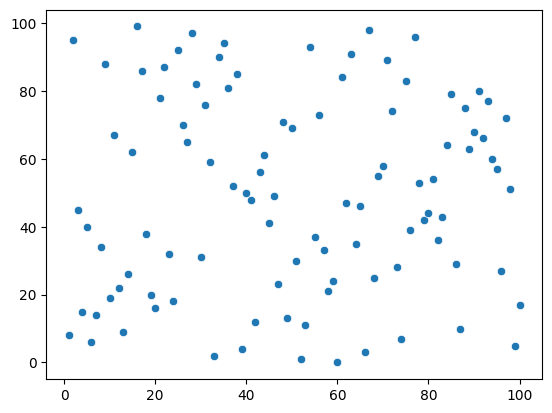

In [56]:
list1 = np.array([ 8, 95, 45, 15, 40,  6, 14, 34, 88, 19, 67, 22,  9, 26, 62, 99, 86, 38,
         20, 16, 78, 87, 32, 18, 92, 70, 65, 97, 82, 31, 76, 59,  2, 90, 94, 81,
         52, 85,  4, 50, 48, 12, 56, 61, 41, 49, 23, 71, 13, 69, 30,  1, 11, 93,
         37, 73, 33, 21, 24,  0, 84, 47, 91, 35, 46,  3, 98, 25, 55, 58, 89, 74,
         28,  7, 83, 39, 96, 53, 42, 44, 54, 36, 43, 64, 79, 29, 10, 75, 63, 68,
         80, 66, 77, 60, 57, 27, 72, 51,  5, 17])
sns.scatterplot(x = np.arange(100)+1, y = list1)

In [142]:
z = torch.tensor([[-0.2120, -0.0043,  2.0758, -1.1846, -0.8903, -0.3060,  0.1899,  0.3193,
          0.4868,  1.0167, -0.2652,  3.0763,  1.5640,  1.0682, -0.6414, -0.2082,
          0.1002,  0.1348, -0.1369,  0.5273, -1.2751, -1.5204, -0.4366,  1.2952,
          0.5492, -0.5632,  1.8069, -1.0760,  0.1513,  1.5860,  1.2919,  0.3640,
         -0.6216,  1.1579, -1.1675, -1.2747, -0.6404,  2.0884, -0.0427,  2.2990,
         -2.5486,  0.0604,  2.2295, -0.6419,  0.3174,  0.6398,  1.7232, -0.3623,
          0.0325,  0.2107,  0.0798, -0.9962, -0.4310,  1.7226,  1.8546, -0.5354,
         -0.0196, -1.3207, -0.3057,  1.0870,  1.4884, -3.3079,  1.5673, -0.2911,
         -0.4342, -0.6653, -1.4429,  0.5049,  0.3400, -1.1968,  1.5241,  0.9019,
         -1.0657, -1.7945,  0.5459,  0.0490, -0.6431,  1.3956, -0.4549, -0.0685,
         -0.9580, -0.4061, -0.0951,  0.1139,  1.5751, -0.7549, -0.5528, -0.5493,
         -0.0804, -0.3681, -0.3438,  0.2726,  1.2983,  0.1650,  1.0343,  2.2338,
          0.5516,  0.7481, -0.0772, -0.9075]])

In [143]:
z = torch.angle(z)
z

tensor([[3.1416, 3.1416, 0.0000, 3.1416, 3.1416, 3.1416, 0.0000, 0.0000, 0.0000,
         0.0000, 3.1416, 0.0000, 0.0000, 0.0000, 3.1416, 3.1416, 0.0000, 0.0000,
         3.1416, 0.0000, 3.1416, 3.1416, 3.1416, 0.0000, 0.0000, 3.1416, 0.0000,
         3.1416, 0.0000, 0.0000, 0.0000, 0.0000, 3.1416, 0.0000, 3.1416, 3.1416,
         3.1416, 0.0000, 3.1416, 0.0000, 3.1416, 0.0000, 0.0000, 3.1416, 0.0000,
         0.0000, 0.0000, 3.1416, 0.0000, 0.0000, 0.0000, 3.1416, 3.1416, 0.0000,
         0.0000, 3.1416, 3.1416, 3.1416, 3.1416, 0.0000, 0.0000, 3.1416, 0.0000,
         3.1416, 3.1416, 3.1416, 3.1416, 0.0000, 0.0000, 3.1416, 0.0000, 0.0000,
         3.1416, 3.1416, 0.0000, 0.0000, 3.1416, 0.0000, 3.1416, 3.1416, 3.1416,
         3.1416, 3.1416, 0.0000, 0.0000, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416,
         3.1416, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.1416,
         3.1416]])

In [138]:

# pi = torch.tensor(math.pi)
# angles_modulo_2pi = torch.fmod(z, 2 * pi)
z = torch.rad2deg(z)
sorted_indices = torch.argsort(z)
sorted_indices



tensor([[50, 97,  2, 96, 95, 94,  6,  7,  8,  9, 93, 11, 12, 13, 92, 91, 16, 17,
         84, 19, 83, 77, 75, 23, 24, 74, 26, 71, 28, 29, 30, 31, 70, 33, 68, 67,
         62, 37, 60, 39, 59, 41, 42, 54, 44, 45, 46, 53, 48, 49,  0, 51, 52, 47,
         43, 55, 56, 57, 58, 40, 38, 61, 36, 63, 64, 65, 66, 35, 34, 69, 32, 27,
         72, 73, 25, 22, 76, 21, 78, 79, 80, 81, 82, 20, 18, 85, 86, 87, 88, 89,
         90, 15, 14, 10,  5,  4,  3,  1, 98, 99]])

In [131]:
list2 = np.array([ -12.1467,   -0.2464,  118.9346,  -67.8726,  -51.0104,  -17.5325,
           10.8805,   18.2945,   27.8916,   58.2526,  -15.1948,  176.2590,
           89.6106,   61.2034,  -36.7495,  -11.9290,    5.7410,    7.7235,
           -7.8438,   30.2121,  -73.0578,  -87.1125,  -25.0153,   74.2095,
           31.4668,  -32.2690,  103.5277,  -61.6503,    8.6689,   90.8711,
           74.0204,   20.8557,  -35.6151,   66.3428,  -66.8928,  -73.0349,
          -36.6922,  119.6565,   -2.4465,  131.7230, -146.0240,    3.4607,
          127.7409,  -36.7782,   18.1857,   36.6578,   98.7321,  -20.7583,
            1.8621,   12.0722,    4.5722,  -57.0781,  -24.6945,   98.6977,
          106.2607,  -30.6762,   -1.1230,  -75.6705,  -17.5153,   62.2805,
           85.2790, -189.5287,   89.7997,  -16.6788,  -24.8778,  -38.1189,
          -82.6721,   28.9286,   19.4806,  -68.5716,   87.3245,   51.6751,
          -61.0601, -102.8173,   31.2778,    2.8075,  -36.8469,   79.9620,
          -26.0639,   -3.9248,  -54.8894,  -23.2678,   -5.4488,    6.5260,
           90.2466,  -43.2526,  -31.6731,  -31.4726,   -4.6066,  -21.0906,
          -19.6983,   15.6188,   74.3871,    9.4538,   59.2610,  127.9873,
           31.6044,   42.8630,   -4.4232,  -51.9959])

In [35]:
list1 = np.array([50,  1,  2, 95,  4,  5,  6, 94, 92, 91, 10, 11, 89, 87, 14, 15, 85, 84,
         18, 19, 83, 21, 22, 23, 24, 82, 26, 27, 28, 29, 81, 31, 32, 80, 78, 77,
         76, 37, 38, 75, 74, 73, 71, 43, 69, 45, 46, 63, 62, 61, 55, 51, 52, 54,
         53,  0, 56, 57, 58, 59, 60, 49, 48, 47, 64, 65, 66, 67, 68, 44, 70, 42,
         72, 41, 40, 39, 36, 35, 34, 79, 33, 30, 25, 20, 17, 16, 86, 13, 88, 12,
         90,  9,  8, 93,  7,  3, 96, 97, 98, 99])

In [36]:
def find_equal_values_and_indexes(arr):
    result = []
    for i in range(len(arr)):
        if arr[i] == i:
            result.append(i)
    return result

# Example usage
equal_values_and_indexes = find_equal_values_and_indexes(list1)
np.array(equal_values_and_indexes)

array([ 1,  2,  4,  5,  6, 10, 11, 14, 15, 18, 19, 21, 22, 23, 24, 26, 27,
       28, 29, 31, 32, 37, 38, 43, 45, 46, 51, 52, 56, 57, 58, 59, 60, 64,
       65, 66, 67, 68, 70, 72, 79, 86, 88, 90, 93, 96, 97, 98, 99])

<Axes: >

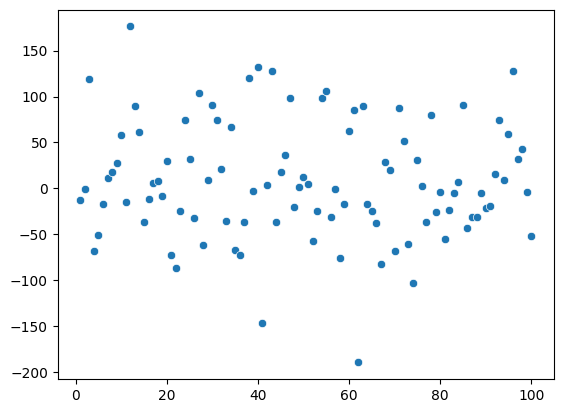

In [88]:
sns.scatterplot(x = np.arange(100)+1, y = list2)